In [1]:
import tensorflow as tf
from pandas.plotting._matplotlib import scatter_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pyodbc
import os
import math 


Parametre, ktorými sa dá aplikácia jemne nastaviť 
- database = tabulka z ktorej sa budu vytahovat informacie
- zastavky = zoznam zastávok, ktoré bude aplikácia sledovať

In [2]:
database = '[CZ-PREOS_GTN]'
zastavky = ['Ostrava-Svinov', 'Polanka n. O.', 'Jistebník', 'Studénka', 'Suchdol nad Odr.', 'Polom',
                'Hranice na Mor.', 'Drahotue', 'Lipník nad Beèv.', 'Prosenice', 'Pøerov os.n.', 'Výh Dluhonice']

Funkcie ktoré pomáhaju so spacovaním dát
- outlier_treatment = odstráni z dát outliery na základe IQR
- track%monitor = vyberie z dát iba tie, ktoré majú určenú trasu pomocou zoznamu zástavok a sleduje meškanie na každej zástavke

In [3]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1, Q3 = np.percentile(datacolumn, [25, 75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range, upper_range


def track_monitor(stops_list, df_p, title, directory):
    cesty = {}
    lastId = -1
    for index, row in df_p.iterrows():
        trainId = row['TrainId']
        if (row['FromName'] in stops_list) & (row['ToName'] in stops_list):
            if trainId == lastId:
                cesty.setdefault(trainId, []).append(row['RealDrivingTime'])
            elif (row['SectIdx'] == 0) & (row['FromName'] == stops_list[0]):
                cesty[row['TrainId']] = [0.0, row['RealDrivingTime']]
                lastId = trainId
        else:
            if trainId == lastId:
                cesty.pop(lastId, None)

    total = [0] * len(stops_list)
    
    trainsCount = 0
    for value in cesty.values():
        if len(value) == 11:
            plt.plot(zastavky, value)
            total = np.add(value, total)
            trainsCount += 1
    plt.title(title)
    plt.xticks(fontsize=7, rotation=15)
    plt.savefig(directory + 'AllTrains')
    plt.close()

    dividers = [trainsCount] * len(stops_list)

    means = np.divide(total, dividers)

    plt.title(title)
    plt.xticks(fontsize=7, rotation=15)
    plt.plot(zastavky, means)
    plt.savefig(directory + 'Mean')
    plt.close()

Nastavenia ktore dovoluju pandas zobrazit cely dataframe ako tabulku
- neodporúča sa používať
- môže spôsobiť spadnutie systému pri veľkom množstve dát 
- použivať iba na kontrolu

In [4]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)

Select ktorý z databázy vytiahne všetky potrebné dáta.
- TrainId = unikátny kľúč vlaku, spája jednu celú jazdu vlaku
- FromName = Meno zastávky úseku, odkiaľ vlak vyráža
- ToName = Meno zastávky úseku, kam vlak smeruje
- TrainType = Typ Vlaku = (Os,Ex,R,Nex,Pn,Vlec,Sluz, atď.)
- Length = dĺžka vlaku v metroch 
- CarCount = počet vagónov vlaku na danom úseku vrátane pohonných súprav
- AxisCount = počet náprav vlaku
- EngineType = typ pohonnej súpravy
- DepRealTimeStamp = timestamp reálneho odchodu zo zástavky
- ArrRealTimeStamp = timestamp reálneho príchodu do cieľovej zastávky
- DepPlanTimeStamp = timestamp plánovaného odchodu zo zástavky
- ArrPlanTimeStamp = timestamp plánovaného príchodu do cieľovej zastávky
- PlanDrivingTime = plánované trvanie cesty v sekundách
- DelayDeparture = meškanie odchodu vlaku zo stanice v sekundách 
- DelayArrive = meškanie príchodu vlaku do stanice v sekundách 
- LengthSect = dĺžka úseku v km
- PredLength = dĺžka predošlého úseku v km
- SectIdx = poradie úseku v ceste vlaku (0 = 1. úsek, 1 = 2. úsek)
- Season = ročné obdobie v ktorom sa cesta uskutočnila
- DayTime = obdobie dňa v ktorom sa trasa uskutočnila(Ráno, Obed, Večer, Noc)


In [5]:
cnxn = pyodbc.connect("Driver={SQL Server};"
                      "Server=dokelu.kst.fri.uniza.sk;"
                      "Database=TrainsDB20-01-23;"
                      "uid=Lukas;pwd=lukas")

DFBASE = pd.read_sql_query(
      'SELECT [TrainId]'
      ',[FromName]'
      ',[ToName]'
      ',[TrainType]'
      ',[Weight]'
      ',[Length]'
      ',[CarCount]'
      ',[AxisCount]'
      ',SUBSTRING([EngineType],1,4) as EngineType'
      ',DATEDIFF(SECOND,\'1970-01-01\',[DepRealTime]) as DepRealTimeStamp'
      ',DATEDIFF(SECOND,\'1970-01-01\',[ArrRealTime]) as ArrRealTimeStamp'
      ',DATEDIFF(SECOND,\'1970-01-01\',[DepPlanTime]) as DepPlanTimeStamp'
      ',DATEDIFF(SECOND,\'1970-01-01\',[ArrPlanTime]) as ArrPlanTimeStamp'
      ',COALESCE(DATEDIFF(SECOND,\'1970-01-01\',[ArrPlanTime])-DATEDIFF(SECOND,\'1970-01-01\',[DepPlanTime]),0) as PlanDrivingTime'
      ',COALESCE(DATEDIFF(SECOND,\'1970-01-01\',[DepRealTime])-DATEDIFF(SECOND,\'1970-01-01\',[DepPlanTime]),0) as DelayDeparture'
      ',COALESCE(DATEDIFF(SECOND,\'1970-01-01\',[ArrRealTime])-DATEDIFF(SECOND,\'1970-01-01\',[ArrPlanTime]),0) as DelayArrive'
      ',COALESCE([LengthSect],0) as LengthSect'
      ',COALESCE([PredLength],0) as PredLength'
      ',SectIdx'
      ',CASE WHEN DATEPART(MONTH,DepPlanTime) in (3,4,5) then \'Jar\''
            ' WHEN DATEPART(MONTH,DepPlanTime) in (6,7,8) then \'Leto\''
            ' WHEN DATEPART(MONTH,DepPlanTime) in (9,10,11) then \'Jesen\''
            ' WHEN DATEPART(MONTH,DepPlanTime) in (12,1,2) then \'Zima\''
      ' END as Season'
      ',CASE WHEN DATEPART(HOUR,DepRealTime) in (5,6,7,8,9,10) THEN \'Rano\''
            ' WHEN DATEPART(HOUR,DepRealTime) in (11,12,13,14,15,16) THEN \'Obed\''
            ' WHEN DATEPART(HOUR,DepRealTime) in (17,18,19,20,21,22) THEN \'Vecer\''
            ' WHEN DATEPART(HOUR,DepRealTime) in (23,0,1,2,3,4) THEN \'Noc\''
     ' END as DayTime'
    ' FROM [TrainsDb20-01-23].[dbo].' + database +
    ' where DepPlanTime IS NOT NULL'
    ' and DepRealTime IS NOT NULL'
    ' and ArrRealTime IS NOT NULL'
    ' and ArrPlanTime IS NOT NULL'
    ' and Traintype not in (\'PMD\')'
    ' order by TrainId,SectIdx ASC'
    , cnxn)
    

Deklarácia ďalších atribútov, ktoré priamo v programe získame z dát
- PredDelay = Meškanie získané na predošlom úseku v sekundách 
- PredLength = Kvôli neúplnosti databázy túto hodnotu musíme získať dopočítaním
- DelayDiff = Získané meškanie na úseku v sekundách 
    = RealDrivingTime - PlanDrivingTime
- DelayDiffPercent = DelayDiff v pomere s Plánovaým trvaním trasy 
    = DelayDiff / PlanDrivingTime 
- NoStop = bool ktorý označuje, či vlak šiel trasu bez zastávok 
    (1 = bez zástavok, 0 = so zástavkami) - nedokončené
- PredDelayDiffPercent = DelayDiffPercent zazanmenané na predošlom úseku. Ak nemá predošlý úsek tak 0


- Ar1, Ar2, Ar3 = Rovnaký princíp ako PredDelayDiffPercent ale rozšírený na 3 predošlé úseky


In [6]:
DFBASE['PredDelay'] = 0
DFBASE['PredLength'] = 0
DFBASE['DelayDiff'] = 0
DFBASE['DelayDiffPercent'] = 0.0
DFBASE['NoStop'] = 1
DFBASE['DelayPercent'] = 0
DFBASE['Speed'] = 0

In [7]:
DFBASE['Ar1'] = 0.0
DFBASE['Ar2'] = 0.0
DFBASE['Ar3'] = 0.0
DFBASE['Ar4'] = 0.0
DFBASE['Ar5'] = 0.0
DFBASE['Ar6'] = 0.0
DFBASE['Ar7'] = 0.0
DFBASE['Ar8'] = 0.0
DFBASE['Ar9'] = 0.0

In [8]:
fromStops = DFBASE.FromName.unique()
toStops = DFBASE.ToName.unique()

Kombinácie atribútov použitých pri testovaní a filtre.

In [9]:
train_types = DFBASE.TrainType.unique()
season_types = DFBASE.Season.unique()
daytime_types = DFBASE.DayTime.unique()

In [10]:
seasons_dataframes = {}
stops_dataframes = {}
train_type_dataframes = {}
daytimes_dataframes = {}

filters = {'TrainTypes': [train_types, train_type_dataframes, 'TrainType'],
           'Seasons': [season_types, seasons_dataframes, 'Season'],
           'DayTimes': [daytime_types, daytimes_dataframes, 'DayTime']}

# Filtrácia
Filtrovaním dát sa snažím opraviť dáta, ktoré dokážem označiť za nesprávne a odstániť ich v prípade, ak ich oprava nieje možná. Robím to z toho dôvodu, aby mal model ideálne podmienky na nájdenie vzorov v dátach. Dáta môžu mať vzor, ale ak sú narušené dátami, ktoré sú nesprávne, alebo sú takzvanými outliermi, ktoré tento vzor zahaľujú, tak je v niektorých prípadoch lepšie dáta vyfiltrovať. 

Pre porovnanie výsledkov, budem na hodnotenie modelov používať rôzne vyfiltrované dáta, aby som mohol potvrdiť ako sa jednotlivé modely správajú s rôznými dátami. V rámci jednej filtrácie budú všetky modely trénované a testované na totožných dátach. 

#### Dáta bez Filtrácie BASE 
    - Chýbajúce dáta sú dopočítané a žiadny údaj nieje nezadaný, čo je potrebné pre správne fungovanie trénovacích algoritmov

Dáta budem filtrovať vo viacerých úrovniach:
#### Prvá Filtrácia FILTER1
    - Táto filtrácia bude iba o odstánení veľmi jednoznačných a ľahko odhaliteľných chýb, a oprava dát.
    - oprava dát pri prechode na letný/zimný čas
    - všetky dáta kladné 
    - Počet vozňov musí byť väčší ako 1
    - Plánovaná jazdná doba nesmie presiahnuť 4 násobok reálnej plánovanej doby a obe musia mať trvanie aspoň minútu
    
#### Druhá Filtrácia FILTER2
     - Párny počet náprav a menší počet ako 225
     - Počet vozňov musí byť menší ako 60
     - Váha vlakov musí byť menšia ako 4000 ton
     - Plánované jazdné doby musia byť menšie ako 40 000 s ~ 11 hodín
     
#### Tretia Filtrácia FILTER3
    - Dĺžka vlaku musí byť kratšia ako 750 metrov
    - Váha vlakov musí byť menšia ako 2000 ton
    - Počet vozňov musí byť menší ako 45
    - Plánované jazdné doby musia byť menšie ako 15 000 s ~ 4 hodiny
    - Reálna jazdná trasa nesmie prekročiť 20 násobok plánovanej jazdnej doby

#### Upozornenie!
Nasledujúce operácie môž mať veľký dopad na rýchlosť programu, pre veľké zaťaženie RAM, keďže budeme mať 4 kópie 1.5 GB dát = 6 GB. Pre lepšiu stabilitu odporúčam pracovať iba s dvoma kópiami

# BASE
Pre základnú databázu dopočítame všetky ďalšie atribúty

In [ ]:
DFBASE['Speed'] = (DFBASE['LengthSect'] / DFBASE['PlanDrivingTime'])

In [11]:
DFFILTER1 = DFBASE.copy()

In [12]:
DFBASE['RealDrivingTime'] = (DFBASE['ArrRealTimeStamp'] - DFBASE['DepRealTimeStamp'])
DFBASE['DelayDiff'] = (DFBASE['RealDrivingTime'] - DFBASE['PlanDrivingTime'])
DFBASE['DelayDiffPercent'] = (DFBASE['DelayDiff'] / DFBASE['PlanDrivingTime'])
DFBASE['DelayPercent'] = (DFBASE['RealDrivingTime'] / DFBASE['PlanDrivingTime'])

## Filtrácia a oprava chybných dát

V tejto časti sa pokúšam opraviť dáta, a odstrániť všetky tie, ktoré podľa môjho uváženia sú nepresné alebo chybné.
Už na začiatku som niektoré dáta vyfiltroval:

#### Váha, dĺžka, počet vozňov a počet náprav musí byť kladné číslo
Táto operácia neodstánila žiadne úseky, takže dáta sú v tomto smere správne
- Weight > 0  
- Length > 0
- CarCount > 0
- AxisCount > 0

#### Dĺžka úseku musí byť kladné číslo
V tomto prípade ide o to, že úsek nesmie vycestovať z tej istej stanice ako jeho finálna stanica. Tým pádom, nesmie mať nulovú dĺžku trate. Takto som odstánil 216 záznamov
- LengthSect > 0
- FromName <> ToName

#### Oprava chyby jazdných dôb spôsobených presunom na letný alebo zimný čas
Tu sa snažím lokalizovať ktoré úseky boli posunom času zasiahnuté, a následne opraviť ich jazdnú dobu a meškanie tak, aby lepšie predstavolali realitu. Zahŕňa roky 2016 - 2019
Za zmenu na letný čas bolo opravených 113 záznamov a za zimný 84

#### Jazdné doby dlhšie ako 1 minúta
Týmto som sa snažil odstrániť všetky dáta, ktoré som neopravil pri presune na zimný čas
- PlanDrivingTime > 60 = 1926 záznamov odstánených
- RealDrivingTime > 60 = 4043 záznamov odstánených

#### Vlaky ktorých reálne jazdné doby boli 4x kratšie ako plánované jazné doby
Tieto dáta sú väčšinou vlaky, ktorých jazdné doby mali trvať niekoľko hodín ale trvali menej ako 10 minút
- PlanDrivingTime/RealDrivingTime > 4 = 253 záznamov odstánených

#### Vlaky každý vozeň má aspoň 3 nápravy a dĺžku 5 metrov
Týmto spôsobom som sa snažil opraviť dáta, ktoré vykazovali menší počet náprav ako vozňov. Keď som sa bližšie na dáta pozrel, videl som, že niektoré dáta sú prehodené, a po opravení dávajú zmysel. Taktiež, žiaden vlak nemá iba jeden vozeň - tieto dáta mali v sebe najväčší počet chýb.
- usporiadanie dát CarCount < AxisCount < Length
- CarCount > 1 = odstánenie 

# Filter1
- oprava dát pri prechode na letný/zimný čas
- všetky dáta kladné 
- Počet vozňov musí byť väčší ako 1
- Plánovaná jazdná doba nesmie presiahnuť 4 násobok reálnej plánovanej doby a obe musia mať trvanie aspoň minútu

Odstránenie meškaní a skorých príchodov spôsobených zmenou na letný/zimný čas 

In [13]:
# zmena casu ----------------- NA ZIMNY-----------------------------------------------
DFFILTER1.loc[(((DFFILTER1['DepRealTimeStamp'] > 1477792800) & (DFFILTER1['DepRealTimeStamp'] < 1477807200))
        # ------------------------2017-------------------------------------------------
        | ((DFFILTER1['DepRealTimeStamp'] > 1509242400) & (DFFILTER1['DepRealTimeStamp'] < 1509256800))
        # ------------------------2018-------------------------------------------------
        | ((DFFILTER1['DepRealTimeStamp'] > 1540692000) & (DFFILTER1['DepRealTimeStamp'] < 1540706400))
        # ------------------------2019-------------------------------------------------
       | ((DFFILTER1['DepRealTimeStamp'] > 1572141600) & (DFFILTER1['DepRealTimeStamp'] < 1572156000)))
       & (DFFILTER1['DelayDeparture'] < -1500)
       & (DFFILTER1['DelayDeparture'] > -5000),
       ['DelayDeparture', 'DepRealTimeStamp']] += 3600

#  -------------------------------2016-------------------------------------------------
DFFILTER1.loc[(((DFFILTER1['ArrRealTimeStamp'] > 1477792800) & (DFFILTER1['ArrRealTimeStamp'] < 1477807200))
        # ------------------------2017-------------------------------------------------
        | ((DFFILTER1['ArrRealTimeStamp'] > 1509242400) & (DFFILTER1['ArrRealTimeStamp'] < 1509256800))
        # ------------------------2018-------------------------------------------------
        | ((DFFILTER1['ArrRealTimeStamp'] > 1540692000) & (DFFILTER1['ArrRealTimeStamp'] < 1540706400))
        # ------------------------2019-------------------------------------------------
       | ((DFFILTER1['ArrRealTimeStamp'] > 1572141600) & (DFFILTER1['ArrRealTimeStamp'] < 1572156000)))
       & (DFFILTER1['DelayArrive'] < -1500)
       & (DFFILTER1['DelayArrive'] > -5000),
       ['DelayArrive', 'ArrRealTimeStamp']] += 3600


# zmena casu ----------------- NA LETNY-----------------------------------------------
# -------------------------------2016-------------------------------------------------
DFFILTER1.loc[(((DFFILTER1['DepRealTimeStamp'] > 1459044000) & (DFFILTER1['DepRealTimeStamp'] < 1459058400))
        # ------------------------2017-------------------------------------------------
        | ((DFFILTER1['DepRealTimeStamp'] > 1490493600) & (DFFILTER1['DepRealTimeStamp'] < 1490508000))
        # ------------------------2018-------------------------------------------------
        | ((DFFILTER1['DepRealTimeStamp'] > 1521943200) & (DFFILTER1['DepRealTimeStamp'] < 1521957600))
        # ------------------------2019-------------------------------------------------
       | ((DFFILTER1['DepRealTimeStamp'] > 1553997600) & (DFFILTER1['DepRealTimeStamp'] < 1554012000)))
       & (DFFILTER1['DelayDeparture'] > 2200)
       & (DFFILTER1['DelayDeparture'] < 5700),
       ['DelayDeparture', 'DepRealTimeStamp']] -= 3600

#  -------------------------------2016-------------------------------------------------
DFFILTER1.loc[(((DFFILTER1['ArrRealTimeStamp'] > 1459044000) & (DFFILTER1['ArrRealTimeStamp'] < 1459058400))
        # ------------------------2017-------------------------------------------------
        | ((DFFILTER1['ArrRealTimeStamp'] > 1490493600) & (DFFILTER1['ArrRealTimeStamp'] < 1490508000))
        # ------------------------2018-------------------------------------------------
        | ((DFFILTER1['ArrRealTimeStamp'] > 1521943200) & (DFFILTER1['ArrRealTimeStamp'] < 1521957600))
        # ------------------------2019-------------------------------------------------
       | ((DFFILTER1['ArrRealTimeStamp'] > 1553997600) & (DFFILTER1['ArrRealTimeStamp'] < 1554012000)))
       & (DFFILTER1['DelayArrive'] > 2200)
       & (DFFILTER1['DelayArrive'] < 5700),
       ['DelayArrive', 'ArrRealTimeStamp']] -= 3600

Výpočet viacerých atribútov, a odstránenie neplatných dát. 
- RealDrivingTime = reálny čas ktorý trvala cesta
- DelayDiff = časový rozdiel medzi reálnym časom trvania cesty a plánovaným 
- DelayDiffPercent = DelayDiff v pomere ku plánovanej časovej dĺžke trasy
- CarCount,AxisCount,Length = výmena poradia týchto atribútov aby dávali zmysel 
- PredLength = priradenie hodnoty pri chýbajúcich údajoch

In [14]:
DFFILTER1['RealDrivingTime'] = (DFFILTER1['ArrRealTimeStamp'] - DFFILTER1['DepRealTimeStamp'])

In [15]:
DFFILTER1.loc[((DFFILTER1['RealDrivingTime'] >= -87000) & (DFFILTER1['RealDrivingTime'] <= -85000 )),
       ['RealDrivingTime']] += 86400
DFFILTER1.loc[((DFFILTER1['PlanDrivingTime'] >= -87000) & (DFFILTER1['PlanDrivingTime'] <= -85000 )),
       ['PlanDrivingTime']] += 86400

In [16]:
print(DFFILTER1.shape)
DFFILTER1 = DFFILTER1[(DFFILTER1['PlanDrivingTime'] > 60)]
print(DFFILTER1.shape)
DFFILTER1 = DFFILTER1[(DFFILTER1['RealDrivingTime'] > 60)]
print(DFFILTER1.shape)

(3106825, 36)
(3104980, 36)
(3100673, 36)


In [17]:
DFFILTER1 = DFFILTER1[(DFFILTER1['PlanDrivingTime'] / DFFILTER1['RealDrivingTime'] <= 4)]
print(DFFILTER1.shape)

(3100406, 36)


In [18]:
DFFILTER1['DelayDiff'] = (DFFILTER1['RealDrivingTime'] - DFFILTER1['PlanDrivingTime'])
DFFILTER1['DelayDiffPercent'] = (DFFILTER1['DelayDiff'] / DFFILTER1['PlanDrivingTime'])
DFFILTER1['DelayPercent'] = (DFFILTER1['RealDrivingTime'] / DFFILTER1['PlanDrivingTime'])

In [19]:
lastId = -1
lastKm = 0

lastDelays = [0]*9

# vypocet hodnot pre dlzku predosleho useku a posledneho meskania
for index in DFFILTER1.index:
    # vymena stlpcov
    vymena = []
    vymena.insert(0, DFFILTER1.at[index, 'CarCount'])
    vymena.insert(1, DFFILTER1.at[index, 'AxisCount'])
    vymena.insert(2, DFFILTER1.at[index, 'Length'])
    vymena.sort()
    DFFILTER1.at[index, 'CarCount'] = vymena[0]
    DFFILTER1.at[index, 'AxisCount'] = vymena[1]
    DFFILTER1.at[index, 'Length'] = vymena[2]

    if DFFILTER1.at[index, 'TrainId'] == lastId:
        DFFILTER1.at[index, 'PredLength'] = lastKm
        
        DFFILTER1.at[index, 'Ar1'] = lastDelays[-1]
        DFFILTER1.at[index, 'Ar2'] = lastDelays[-2]
        DFFILTER1.at[index, 'Ar3'] = lastDelays[-3]
        DFFILTER1.at[index, 'Ar4'] = lastDelays[-4]
        DFFILTER1.at[index, 'Ar5'] = lastDelays[-5]
        DFFILTER1.at[index, 'Ar6'] = lastDelays[-6]
        DFFILTER1.at[index, 'Ar7'] = lastDelays[-7]
        DFFILTER1.at[index, 'Ar8'] = lastDelays[-8]
        DFFILTER1.at[index, 'Ar9'] = lastDelays[-9]
    else:
        lastId = DFFILTER1.at[index, 'TrainId']
        lastDelays = [0]*9
        
    lastDelays.append(DFFILTER1.at[index, 'DelayDiffPercent'])
    lastKm = DFFILTER1.at[index, 'LengthSect']

print(DFFILTER1.shape)

(3100406, 36)


In [20]:
DFFILTER1 = DFFILTER1[(DFFILTER1['CarCount'] > 1)]
print(DFFILTER1.shape)

(2608809, 36)


In [21]:
DFFILTER1['DelayDepartureReduced'] = 0

lastId = -1
firstDelay = 0
for index in DFFILTER1.index:
    if DFFILTER1.at[index, 'TrainId'] != lastId:
        lastId = DFFILTER1.at[index, 'TrainId']
        firstDelay = DFFILTER1.at[index, 'DelayDeparture']
    DFFILTER1.at[index,'DelayDepartureReduced'] = DFFILTER1.at[index, 'DelayDeparture'] - firstDelay

In [22]:
DFFILTER2 = DFFILTER1.copy()

# FILTER 2
- Párny počet náprav a menší počet ako 225
- Počet vozňov musí byť menší ako 60
- Váha vlakov musí byť menšia ako 4000 ton
- Plánované jazdné doby musia byť menšie ako 40 000 s ~ 11 hodín

In [23]:
DFFILTER2 = DFFILTER2[(DFFILTER2['AxisCount'] <= 225)]
DFFILTER2 = DFFILTER2[(DFFILTER2['CarCount'] <= 60)]
DFFILTER2 = DFFILTER2[(DFFILTER2['Weight'] <= 4000)]
DFFILTER2 = DFFILTER2[(DFFILTER2['PlanDrivingTime'] <= 40000)]
print(DFFILTER2.shape)

(2608753, 37)


In [24]:
DFFILTER3 = DFFILTER2.copy()

# FILTER 3
- Dĺžka vlaku musí byť kratšia ako 750 metrov
- Váha vlakov musí byť menšia ako 2000 ton
- Počet vozňov musí byť menší ako 45
- Plánované jazdné doby musia byť menšie ako 15 000 s ~ 4 hodiny
- Reálna jazdná trasa nesmie prekročiť 20 násobok plánovanej jazdnej doby

In [25]:
DFFILTER3 = DFFILTER3[(DFFILTER3['Length'] <= 750)]
DFFILTER3 = DFFILTER3[(DFFILTER3['Weight'] <= 2000)]
DFFILTER3 = DFFILTER3[(DFFILTER3['CarCount'] <= 45)]
DFFILTER3 = DFFILTER3[(DFFILTER3['PlanDrivingTime'] <= 750)]
DFFILTER3 = DFFILTER3[((DFFILTER3['RealDrivingTime'] / DFFILTER3['PlanDrivingTime']) <= 20)]
print(DFFILTER3.shape)

(2443458, 37)


# !!!!!!!!!!
# Doriesit filter podla rocnika grafikonu
# !!!!!!!!


In [26]:
if not os.path.exists(database + '/AllData'):
    os.makedirs(database + '/AllData')
    os.makedirs(database + '/AllData/ScatterPlots')


## Normovanie (Štandardizácia)
Normovanie prevedie všetky dáta okrem výsledkov do intervalu <0,1> a tu vidíme rozdiely

In [27]:
def norm(x):
    return (x-train_stats['mean']) / train_stats['std']

Metóda v ktorej môžeme definovať hyperparametre nášho modelu.
Definujeme počet vrstiev v sieti a počet perceptrónov v každej vrstve.
Každému perceptrónu zadeľujeme aj jeho aktivačnú funkciu, v tomto prípade relu=rectified linear unit
Nastavujeme aj optimalizér, čo je funkcia, ktorá vypočíta gradient, alebo smer, ktorým sa parametre majú upraviť pre zlepšenie výsledku. Zadávame v nej aj veľkosť kroku, teda o koľko sa parametre neurónovej siete posunú v smere gradientu.
Pri regresnom probléme ako je tento budem sledovať hlavne Mean Absolute Error a Mean Squared Error, kde náš model sa bude riadiť práve MSE.

In [28]:
def build_model(lr_par=0.01):
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(normed_train_data.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(lr_par)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae','mse'])
    return model

Metóda PrintDot slúži iba na to, aby sme mohli sledovať priebeh účenia sa siete. Prejdenie všetkých trénovacích dát neurónovou sieťou nazývame epocha. Za každou touto epochou vykreslíme bodku, a tým vieme, že sa sieť stále účí.
Sieť sa upravuje práve medzi jednotlivými epochami.
Pre učenie siete použijeme ako maximum 1000 epoch, avšak zavedieme aj techniku early stop, ktorá zabezpečí, že ak sa sieť zachytí na nájdenom minime na dlhšiu dobu, tak predpokladáme, že našlo absolútne minimum funkcie a teda učenie ukončíme.

In [29]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 20 == 0:
            print('')
        print('.', end='')

In [43]:
EPOCHS = 150

In [42]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=17)

In [32]:
def save_best_model(model_name):
    return keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)

In [33]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epocha')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],
             label='Chyba na trénovacej mn.')
    plt.plot(hist['epoch'], hist['val_mae'],
             label='Chyba na validačnej mn.')
    plt.legend()
    plt.show()

    plt.figure()
    plt.xlabel('Epocha')
    plt.ylabel('Mean Squared Error')
    plt.plot(hist['epoch'], hist['mse'],
             label='Chyba na trénovacej mn.')
    plt.plot(hist['epoch'], hist['val_mse'],
             label='Chyba na validačnej mn.')
    plt.legend()
    plt.show()

In [34]:
def show_predictions():
    predictions = testModel.predict(normed_test_data).flatten()

    f, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(test_labels, predictions)
    plt.xlabel('Reálne hodnoty [' + label + ']')
    plt.ylabel('Odhadované hodnoty [' + label + ']')
    
    plt.plot([0,30000],[0,30000],'r')
    plt.show()

In [35]:
def show_errors(margin):
    error = new_test_predictions - test_labels

    print("Najväčšia chyba:" + str(max(error)))
    print("Najväčšia chyba v zápornom smere:" + str(min(error)))

    lessThan2Min = error[abs(error) < margin] 
    print("% približne správnych odhadov: " + str(len(lessThan2Min)/len(error)))


    plt.hist(error)
    plt.xlabel('Veľkosť chyby ['+label+']')
    plt.ylabel("Počet")
    plt.show()

In [36]:
def eval_Model(filter_type, model, attribute_list, margin=120):
    if filter_type == "BASE":
        dfCut = DFBASE[attribute_list]
    elif filter_type == "FILTER1":
        dfCut = DFFILTER1[attribute_list]
    elif filter_type == "FILTER2":
        dfCut = DFFILTER2[attribute_list]
    elif filter_type == "FILTER3":
        dfCut = DFFILTER3[attribute_list]
    else:
        print("ERROR")
        return
    
    label = attribute_list[-1]
    
    train_dataset = dfCut.sample(frac=0.8, random_state=0)
    test_dataset = dfCut.drop(train_dataset.index)

    train_labels = train_dataset.pop(label)
    test_labels = test_dataset.pop(label)

    train_stats = train_dataset.describe()
    train_stats = train_stats.transpose() 

    normed_train_data = (train_dataset-train_stats['mean']) / train_stats['std']
    normed_test_data = (test_dataset-train_stats['mean']) / train_stats['std']
    
    print("------Presnosť na " + filter_type + " dátach-------- ")
    loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
    
    print("Testing set Mean Abs Error: {:5.2f} {} ".format(mae, label))
    print("Testing set Mean Sqrt Error: {:5.2f} {} ".format(mse, label))
    print("Testing set Root Mean Sqrt Error: {:5.2f} {} ".format(math.sqrt(mse),label))
    
    # -------------PREDIKCIE--------------------------
    predictions = model.predict(normed_test_data).flatten()

    f, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(test_labels, predictions)
    plt.xlabel('Reálne hodnoty [' + label + ']')
    plt.ylabel('Odhadované hodnoty [' + label + ']')
    
    ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c="r")
    plt.show()
    
    # -------------ERRORS - chyby--------------------- 
    error = predictions - test_labels

    print("Najväčšia chyba:" + str(max(error)))
    print("Najväčšia chyba v zápornom smere:" + str(min(error)))

    smallErrors = error[abs(error) < margin] 
    bigErrors = error[abs(error) > 10000] 
    print("% približne správnych odhadov: " + str(len(smallErrors)/len(error)))

    plt.hist(error)
    plt.xlabel('Veľkosť chyby ['+label+']')
    plt.ylabel("Počet")
    plt.show()
    
    #np.sort(bigErrors)    
    #display(dfCut[dfCut.index.isin(bigErrors.index)])

In [37]:
def CreateAndFitModel(filter_type,learning_rate, margin, name, attributes_list):       
    if filter_type == "BASE":
        dfCut = DFBASE[attributes_list]
    elif filter_type == "FILTER1":
        dfCut = DFFILTER1[attributes_list]
    elif filter_type == "FILTER2":
        dfCut = DFFILTER2[attributes_list]
    elif filter_type == "FILTER3":
        dfCut = DFFILTER3[attributes_list]
    else:
        print("ERROR")
        return
    label = attributes_list[-1]
    
    train_dataset = dfCut.sample(frac=0.8, random_state=0)
    test_dataset = dfCut.drop(train_dataset.index)

    train_labels = train_dataset.pop(label)
    test_labels = test_dataset.pop(label)

    print("-----------------------------" + filter_type + "---------------------------------")
    print("Veľkosť trénovacej množniy: " + str(train_dataset.shape))
    print("Veľkosť testovacej množniy: " + str(test_dataset.shape))

    train_stats = train_dataset.describe()
    train_stats = train_stats.transpose() 
    
    normed_train_data = (train_dataset-train_stats['mean']) / train_stats['std']
    normed_test_data = (test_dataset-train_stats['mean']) / train_stats['std']
    
    #tvorba modelu
    testModel = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(normed_train_data.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate)

    testModel.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae','mse'])
    
    testModelHistory = testModel.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop,save_best_model(name + ".h5"), PrintDot()])
    
    testModel = load_model(name + ".h5")
    
    
    plot_history(testModelHistory)
    
    eval_Model("BASE", testModel, attributes_list, margin)
    eval_Model("FILTER1", testModel, attributes_list, margin)
    eval_Model("FILTER2", testModel, attributes_list, margin)
    eval_Model("FILTER3", testModel, attributes_list, margin)

In [38]:
def CreateAndFitModelLocations(filter_type,learning_rate, margin, name, attributes_list):
                               
    if filter_type == "BASE":
        dfCut = DFBASE[attributes_list]
    elif filter_type == "FILTER1":
        dfCut = DFFILTER1[attributes_list]
    elif filter_type == "FILTER2":
        dfCut = DFFILTER2[attributes_list]
    elif filter_type == "FILTER3":
        dfCut = DFFILTER3[attributes_list]
    else:
        print("ERROR")
        return
    label = attributes_list[-1]
    
    train_dataset = dfCut.sample(frac=0.8, random_state=0)
    test_dataset = dfCut.drop(train_dataset.index)

    train_labels = train_dataset.pop(label)
    test_labels = test_dataset.pop(label)

    print("-----------------------------" + filter_type + "---------------------------------")
    print("Veľkosť trénovacej množniy: " + str(train_dataset.shape))
    print("Veľkosť testovacej množniy: " + str(test_dataset.shape))

    train_stats = train_dataset.describe()
    train_stats = train_stats.transpose() 
    
    normed_train_data = (train_dataset-train_stats['mean']) / train_stats['std']
    normed_test_data = (test_dataset-train_stats['mean']) / train_stats['std']
    
    #tvorba modelu
    testModel = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(normed_train_data.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate)

    testModel.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae','mse'])
    
    testModelHistory = testModel.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop,save_best_model(name + ".h5"), PrintDot()])
    
    testModel = load_model(name + ".h5")
    
    plot_history(testModelHistory)
    
    if filter_type in ("BASE","FILTER1","FILTER2","FILTER3"):
        eval_Model("BASE", testModel, attributes_list, margin)
    if filter_type in ("FILTER1","FILTER2","FILTER3"):
        eval_Model("FILTER1", testModel, attributes_list, margin)
    if filter_type in ("FILTER2","FILTER3"):
        eval_Model("FILTER2", testModel, attributes_list, margin) 
    if filter_type in ("FILTER3"):
        eval_Model("FILTER3", testModel, attributes_list, margin)

In [39]:
def just_Eval(model_name,attributes_list):
    testModel = load_model(model_name)
    eval_Model("BASE", testModel, attributes_list)
    eval_Model("FILTER1", testModel, attributes_list)
    eval_Model("FILTER2", testModel, attributes_list)
    eval_Model("FILTER3", testModel, attributes_list)

# Odstránenie málo početných dát
Pre normalizáciu. 

### TrainTypes

In [40]:
for stop in DFBASE.TrainType.unique():
    check = DFBASE[(DFBASE['TrainType'] == stop)].index
    if(len(check) < 5):
        DFBASE.drop(check,inplace=True)
    
# FILTER1
for stop in DFFILTER1.TrainType.unique():
    check = DFFILTER1[(DFFILTER1['TrainType'] == stop)].index
    if(len(check) < 5):
        DFFILTER1.drop(check,inplace=True)
        
# FILTER2
for stop in DFFILTER2.TrainType.unique():
    check = DFFILTER2[(DFFILTER2['TrainType'] == stop)].index
    if(len(check) < 5):
        DFFILTER2.drop(check,inplace=True)
        
# FILTER3
for stop in DFFILTER3.TrainType.unique():
    check = DFFILTER3[(DFFILTER3['TrainType'] == stop)].index
    if(len(check) < 5):
        DFFILTER3.drop(check,inplace=True)


### Locations

In [41]:
# BASE 
for stop in DFBASE.FromName.unique():
    check = DFBASE[(DFBASE['FromName'] == stop)].index
    if(len(check) < 5):
        DFBASE.drop(check,inplace=True)
    
for stop in DFBASE.ToName.unique():
    check = DFBASE[(DFBASE['ToName'] == stop)].index
    if(len(check) < 5):
        DFBASE.drop(check,inplace=True)

# FILTER1
for stop in DFFILTER1.FromName.unique():
    check = DFFILTER1[(DFFILTER1['FromName'] == stop)].index
    if(len(check) < 5):
        DFFILTER1.drop(check,inplace=True)
    
for stop in DFFILTER1.ToName.unique():
    check = DFFILTER1[(DFFILTER1['ToName'] == stop)].index
    if(len(check) < 5):
        DFFILTER1.drop(check,inplace=True)
        
# FILTER2
for stop in DFFILTER2.FromName.unique():
    check = DFFILTER2[(DFFILTER2['FromName'] == stop)].index
    if(len(check) < 5):
        DFFILTER2.drop(check,inplace=True)
    
for stop in DFFILTER2.ToName.unique():
    check = DFFILTER2[(DFFILTER2['ToName'] == stop)].index
    if(len(check) < 5):
        DFFILTER2.drop(check,inplace=True)
        
# FILTER3
for stop in DFFILTER3.FromName.unique():
    check = DFFILTER3[(DFFILTER3['FromName'] == stop)].index
    if(len(check) < 5):
        DFFILTER3.drop(check,inplace=True)
    
for stop in DFFILTER3.ToName.unique():
    check = DFFILTER3[(DFFILTER3['ToName'] == stop)].index
    if(len(check) < 5):
        DFFILTER3.drop(check,inplace=True)

## BASELINE MODEL 
Na porovnanie, že náš model je naozaj vhodné použitie, a že funguje lepšie ako náhodné hádanie hodnoty, musím vytvoriť baseline model, ktorý je veľmi jednoduchým riešením problému. Väčšinou nevyužíva žiadne znaky skúmaného súboru, a hodnotu odhadne vždy rovnako. V regresií teda existujú 3 druhy baseline modelov 


- medián = vždy predpovedá, že nasledujúca hodnota testovacieho datasetu sa rovná mediánu trénovacieho datasetu
- kvantil = vždy predpovedá konkrétny kvantil trénovacieho datasetu, ale kvantil vyberá priamo užívateľ
- konštanta = vždy predpovedá jednu hodnotu nezávisle od dát. Túto hodnotu priamo zadáva užívateľ

Ja teda využijem prvú možnosť a mojím prediktorom bude medián.

In [71]:
def BaseLineEval(Filter_type, metric):
    if Filter_type == "BASE":
        DFCUT = DFBASE['RealDrivingTime']
    elif Filter_type == "FILTER1":
        DFCUT = DFFILTER1['RealDrivingTime']
    elif Filter_type == "FILTER2":
        DFCUT = DFFILTER2['RealDrivingTime']
    elif Filter_type == "FILTER3":
        DFCUT = DFFILTER3['RealDrivingTime']
    else:
        print("ERROR")
        return

    train_dataset = DFCUT.sample(frac=0.8, random_state=0)
    test_dataset = DFCUT.drop(train_dataset.index)

    if metric == "median":
        train_metric = train_dataset.median()
    elif metric == "mean":
        train_metric = train_dataset.mean()
        
    print("Hodnota metriky trénovacieho datasetu: " + str(train_metric))
    
    predictions = [train_metric] * len(test_dataset)

    MAE = sum(abs(predictions - test_dataset)) / len(predictions)
    MSE = sum((predictions - test_dataset)**2) /  len(predictions)
    RMSE = math.sqrt(MSE)

    print("MAE: " + str(MAE))
    print("MSE: " + str(MSE))
    print("RMSE: " + str(RMSE))

In [70]:
BaseLineEval("BASE","median")
BaseLineEval("BASE","mean")

Hodnota metriky trénovacieho datasetu: 293.0
MAE: 134.68408101518432
MSE: 1686618.1864797664
RMSE: 1298.6986511426608
Hodnota metriky trénovacieho datasetu: 298.7220985250215
MAE: 134.7670813155152
MSE: 1686528.5770497213
RMSE: 1298.6641509835101


In [72]:
BaseLineEval("FILTER1",'median')
BaseLineEval("FILTER1",'mean')

Hodnota metriky trénovacieho datasetu: 288.0
MAE: 110.26661006359221
MSE: 37830.31644121266
RMSE: 194.50017079995754
Hodnota metriky trénovacieho datasetu: 316.8716832922306
MAE: 112.91979273918137
MSE: 37037.033751087445
RMSE: 192.4500811927276


In [73]:
BaseLineEval("FILTER2",'median')
BaseLineEval("FILTER2",'mean')

Hodnota metriky trénovacieho datasetu: 288.0
MAE: 110.81969751854813
MSE: 41296.084155085475
RMSE: 203.2143797940625
Hodnota metriky trénovacieho datasetu: 316.6744272406064
MAE: 113.39280433444233
MSE: 40473.932283009264
RMSE: 201.18134178648194


In [74]:
BaseLineEval("FILTER3",'median')
BaseLineEval("FILTER3",'mean')

Hodnota metriky trénovacieho datasetu: 280.0
MAE: 100.05658574316747
MSE: 18747.713146521735
RMSE: 136.92228871342218
Hodnota metriky trénovacieho datasetu: 302.15722291056835
MAE: 101.51873715255934
MSE: 18261.61423757673
RMSE: 135.13554024599424


## Vyhodotenie 
Ako baseline model budem teda používať medián. Vidím, že tento model nieje vôbec zlý, čisto z hľadiska metrík. Priemerná chyba sa pohybuje okolo 2 minút. Môže to znamenať, že v týchto dátach sa ťažšie budú hľadať prediktory, ktoré výrazne zlepšia presnosť odhadu oproti baseline modelu. Tieto hodnoty budeme používať na refernciu, ako neurónová sieť zlepšila presnosť a či vôbec sa neurónová sieť je vhodná na daný problém.

### BASE 
- MAE: 134.68
- MSE: 1686618.18
- RMSE: 1298.69

### FILTER1 
- MAE: 110.26
- MSE: 37830.31
- RMSE: 194.50

### FITLER2
- MAE: 110.81
- MSE: 41296.08
- RMSE: 203.21

### FILTER3
- MAE: 100.05
- MSE: 18747.71
- RMSE: 136.92

## Experiment - Baseline model založený na jednom prediktore 
Chcem použiť jediný prediktor PlanDrivingTime = teda plánovaná jazdná doba. Teda aký presný by bol model, ak by predpokladal, že vlak nikdy nebude meškať

In [99]:
def BaseLineEvalPlanDriving(Filter_type):
    if Filter_type == "BASE":
        DFCUT = DFBASE[['PlanDrivingTime','RealDrivingTime']]
    elif Filter_type == "FILTER1":
        DFCUT = DFFILTER1[['PlanDrivingTime','RealDrivingTime']]
    elif Filter_type == "FILTER2":
        DFCUT = DFFILTER2[['PlanDrivingTime','RealDrivingTime']]
    elif Filter_type == "FILTER3":
        DFCUT = DFFILTER3[['PlanDrivingTime','RealDrivingTime']]
    else:
        print("ERROR")
        return

    train_dataset = DFCUT.sample(frac=0.8, random_state=0)
    test_dataset = DFCUT.drop(train_dataset.index)
    
    predictions = test_dataset['PlanDrivingTime']

    MAE = sum(abs(predictions - test_dataset['RealDrivingTime'])) / len(predictions)
    MSE = sum((predictions - test_dataset['RealDrivingTime'])**2) / len(predictions)
    RMSE = math.sqrt(MSE)

    print("MAE: " + str(MAE))
    print("MSE: " + str(MSE))
    print("RMSE: " + str(RMSE))
    
    f, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(test_dataset['RealDrivingTime'], predictions)
    plt.title("BASELINE - PlanDrivingTime")
    plt.xlabel('True Values [' + label + ']')
    plt.ylabel('Predictions [' + label + ']')

    ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c="r")
    plt.show()

MAE: 51.756587512975464
MSE: 729741.1651348241
RMSE: 854.248889454838


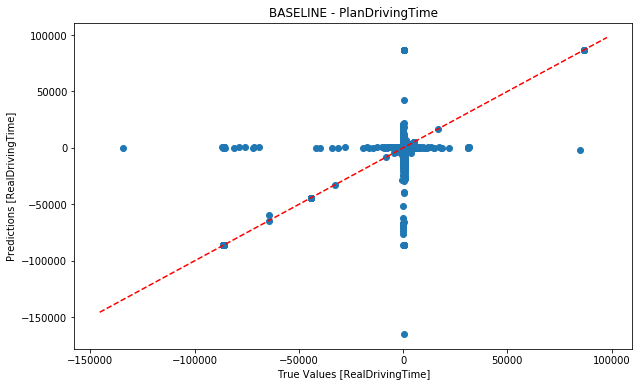

In [100]:
BaseLineEvalPlanDriving("BASE")

MAE: 41.391230101080566
MSE: 19448.34144878316
RMSE: 139.45731048884875


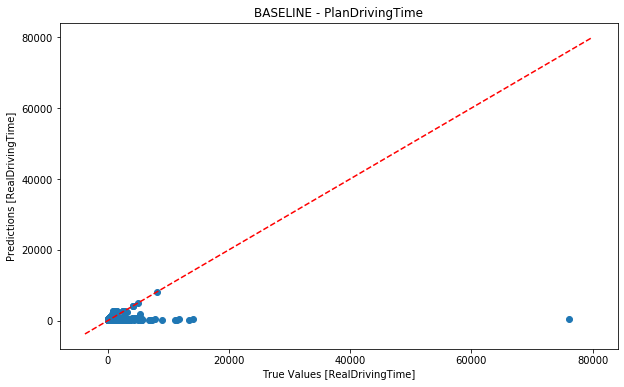

In [101]:
BaseLineEvalPlanDriving("FILTER1")

MAE: 41.69374280068462
MSE: 21140.70809255756
RMSE: 145.39844597710652


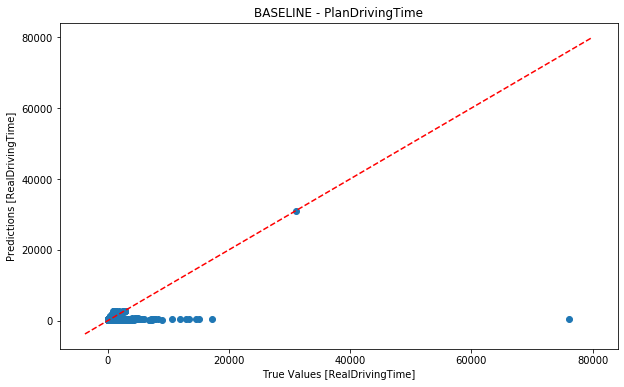

In [102]:
BaseLineEvalPlanDriving("FILTER2")

MAE: 39.00420305632177
MSE: 5684.058003814263
RMSE: 75.39269197882686


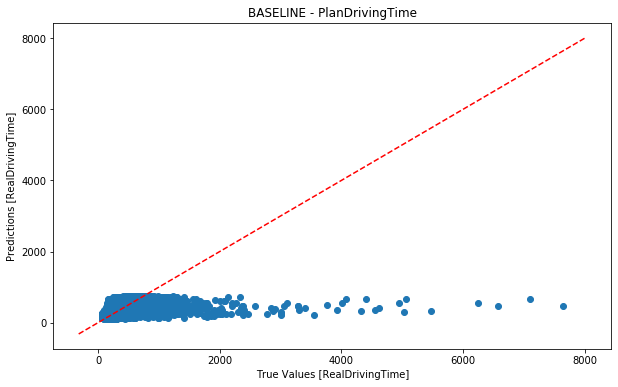

In [103]:
BaseLineEvalPlanDriving("FILTER3")

## Vyhodnotenie Experimentu
Ako najlepší quasi Baseline model sa ukázal model naložený na jedinom prediktore. Ako vidíme, na zlepšenie tu nieje veľký priestor, a chyby v predikcií nastávajú iba pri meškaniach, kde pri iných modeloch môže nastať chyba aj keď vlak nemešká

### BASE 
- MAE: 51.75
- MSE: 729741.16
- RMSE: 854.24

### FILTER1 
- MAE: 41.39
- MSE: 19448.34
- RMSE: 139.45

### FITLER2
- MAE: 41.69
- MSE: 21140.70
- RMSE: 145.39


### FILTER3
- MAE: 39.00
- MSE: 5684.05
- RMSE: 75.39

# Prvý Test - Vytvorenie modelu zo základných dát

Na začiatok pracujem z dátami ktoré sa nachádzajú priamo v databáze. Dáta boli upravené tak, aby obsahovali čo najmenej chýb a nemožných údajov.
Pracujem teda s týmito vlastnosťami:
- Weigth = váha vlakovej súpravy v tonách
- Length = dĺžka vlaku v metroch 
- CarCount = počet vagónov vlaku na danom úseku vrátane pohonných súprav
- AxisCount = počet náprav vlaku
- PlanDrivingTime = plánované trvanie cesty v sekundách
- DelayDeparture = meškanie odchodu vlaku zo stanice v sekundách 
- LengthSect = dĺžka úseku v km
- PredLength = dĺžka predošlého úseku v km
- SectIdx = poradie úseku v ceste vlaku (0 = 1. úsek, 1 = 2. úsek)

a sledujem jazdnú dobu vlaku
- RealDrivingTime

In [183]:
first_attributes = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDeparture',
                    'RealDrivingTime']

In [184]:
used_attributes = first_attributes
label = used_attributes[-1]

## Analýza - Výpočet lineárneho vplyvu atribútov na skúmanú vlastnosť
- korelácia so sledovanou vlastnosťou
- korelačné matice a histogram

korelácia: 

BASE
- RealDrivingTime    1.000000
- PlanDrivingTime    0.831802
- LengthSect         0.026890
- CarCount           0.009292
- AxisCount          0.008214
- Weight             0.004331
- Length             0.000130
- SectIdx           -0.004530
- DelayDeparture    -0.007265

FILTER1


FILTER2


FILTER3


## BASE

In [185]:
DFCUT = DFBASE[used_attributes]
cor = DFCUT.corr()
print(cor[label].sort_values(ascending=False))

RealDrivingTime    1.000000
PlanDrivingTime    0.831802
LengthSect         0.026890
CarCount           0.009292
AxisCount          0.008214
Weight             0.004331
Length             0.000130
SectIdx           -0.004530
DelayDeparture    -0.007265
Name: RealDrivingTime, dtype: float64


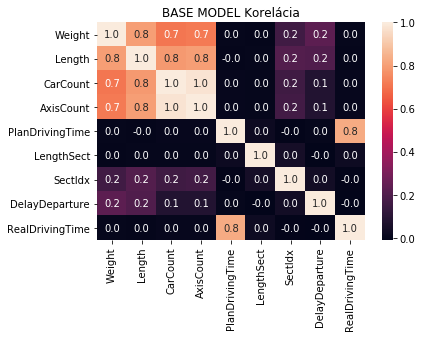

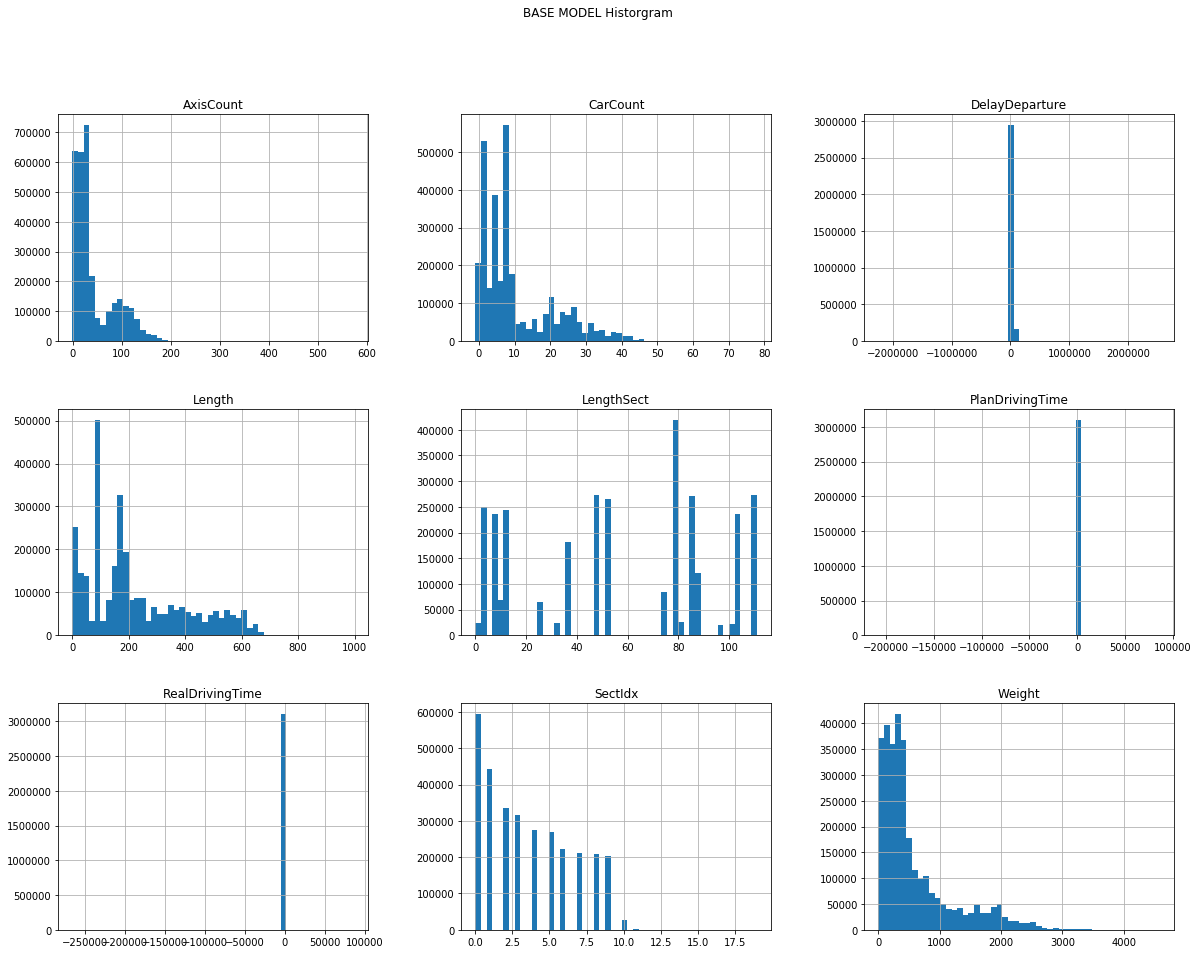

In [58]:
plt.title("BASE MODEL Korelácia")
sns.heatmap(cor, annot = True, fmt='.1f')    
    
DFCUT.hist(bins=50, figsize=(20, 15))
plt.suptitle("BASE MODEL Historgram")
plt.show()

Porovnanie závislosti trvania trasy od parametrov trasy.
Logicky, najväčší vplyv ukazuje plánovaný čas trvania trasy(PlanDrivingTime), keďže v prípade že vlak nemešká sa tieto dve hodnoty rovnajú. Vidíme, že v dátach je mnoho outlierov.

Je aj veľmi ľahko vidieť koreláciu atribútov CarCount, AxisCount, Length a Weigth ktorých vzor je veľmi podobný a ihneď rozoznateľný. 

Vidím aj veľmi veľkú prezenciu dát, v ktorých RealDrivingTime sa drží na línií okolo -86000 sekúnd ~ 1 deň. Toto sú veľmi zjavne chybné dáta ktoré identifikujeme podľa meškania veľmi blízkeho 24 hodinám a opravíme vo FILTER1

Ďalej pri Scatter plote PlanDrivingTime x RealDrivingTime sú ľahko viditeľné všetky hodnoty ktoré sú chybné

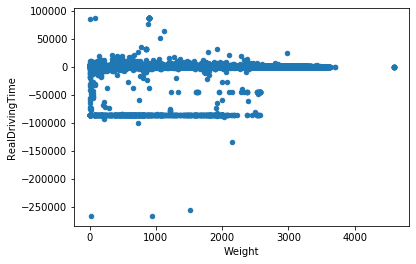

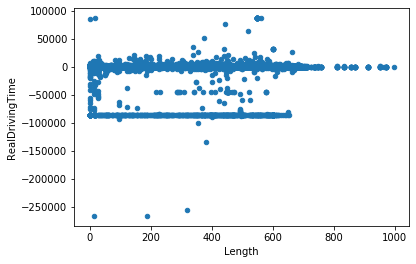

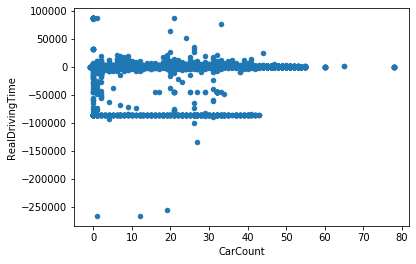

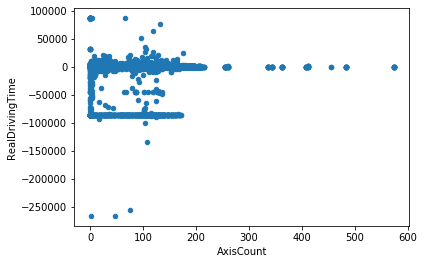

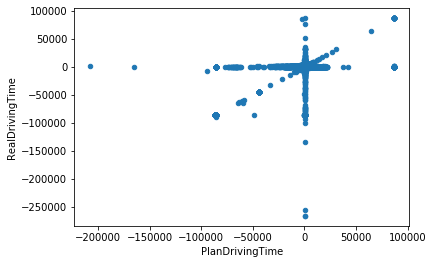

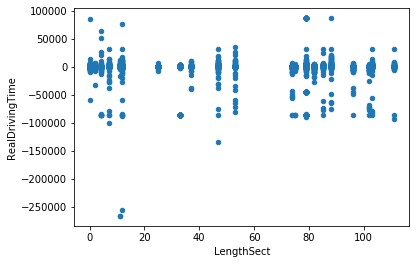

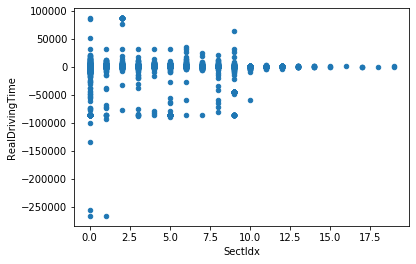

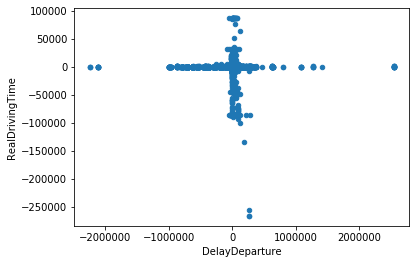

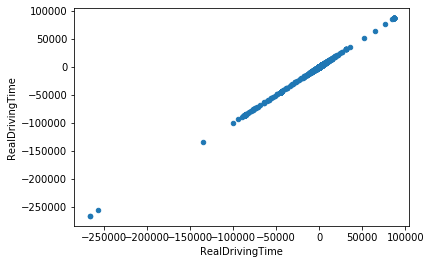

In [59]:
for attr in used_attributes:
    DFCUT.plot(kind='scatter', x=attr, y=label)
    plt.show()

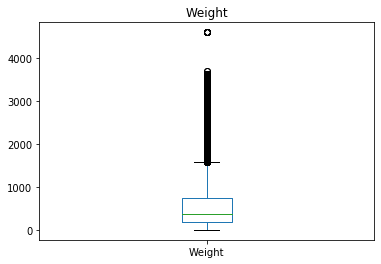

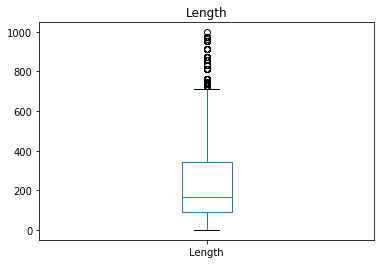

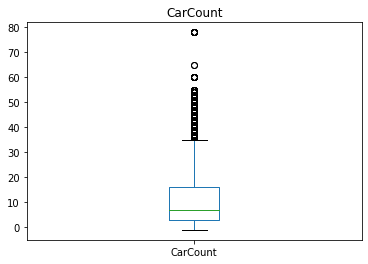

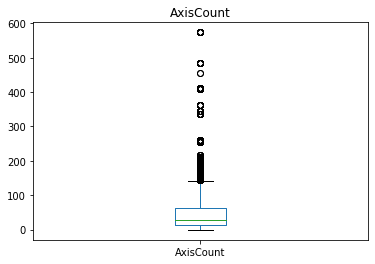

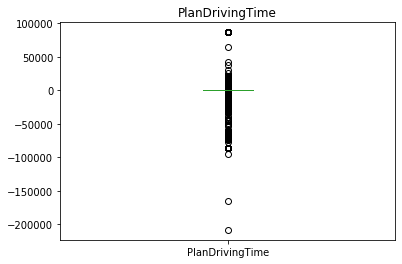

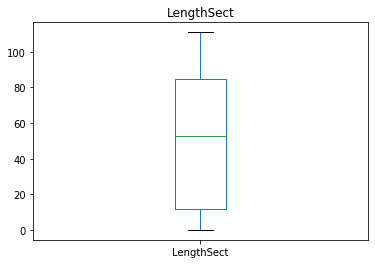

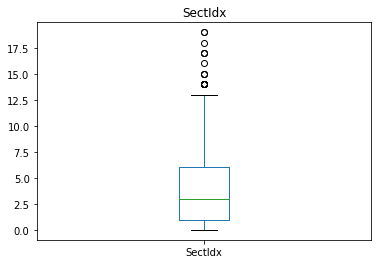

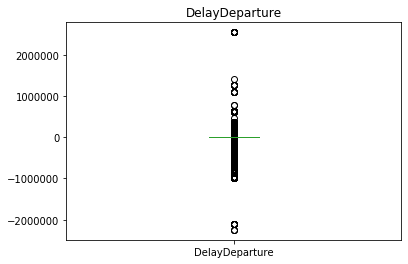

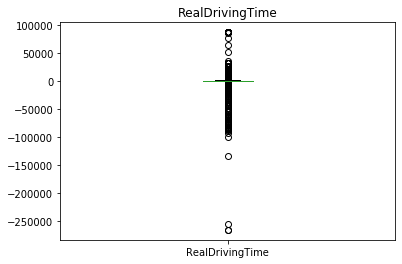

In [60]:
for attr in used_attributes:
    DFCUT.plot(kind='box', y=attr)
    plt.title(attr)
    plt.show()

Zúži dataframe iba na skúmané vlastnosti. Rozdelí dataset na trénovaniu a testovaciu množinu a oddelí sledovanú vlastnosť.

In [187]:
train_dataset = DFCUT.sample(frac=0.8, random_state=0)
test_dataset = DFCUT.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

(2485460, 8)
(621365, 8)


## Normovanie
Normovanie prevedie všetky dáta okrem výsledkov do intervalu <0,1> a tu vidíme rozdiely

In [186]:
def norm(x):
    return (x-train_stats['mean']) / train_stats['std']

In [188]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Metóda v ktorej môžeme definovať hyperparametre nášho modelu.
Definujeme počet vrstiev v sieti a počet perceptrónov v každej vrstve.
Každému perceptrónu zadeľujeme aj jeho aktivačnú funkciu, v tomto prípade relu=rectified linear unit
Nastavujeme aj optimalizér, čo je funkcia, ktorá vypočíta gradient, alebo smer, ktorým sa parametre majú upraviť pre zlepšenie výsledku. Zadávame v nej aj veľkosť kroku, teda o koľko sa parametre neurónovej siete posunú v smere gradientu.
Pri regresnom probléme ako je tento budem sledovať hlavne Mean Absolute Error a Mean Squared Error, kde náš model sa bude riadiť práve MSE.

In [189]:
def build_model(lr_par=0.01):
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(normed_train_data.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(lr_par)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae','mse'])
    return model

In [190]:
test1Model = build_model(0.001)
print(test1Model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 64)                576       
_________________________________________________________________
dense_36 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________
None


Metóda PrintDot slúži iba na to, aby sme mohli sledovať priebeh účenia sa siete. Prejdenie všetkých trénovacích dát neurónovou sieťou nazývame epocha. Za každou touto epochou vykreslíme bodku, a tým vieme, že sa sieť stále účí.
Sieť sa upravuje práve medzi jednotlivými epochami.
Pre učenie siete použijeme ako maximum 1000 epoch, avšak zavedieme aj techniku early stop, ktorá zabezpečí, že ak sa sieť zachytí na nájdenom minime na dlhšiu dobu, tak predpokladáme, že našlo absolútne minimum funkcie a teda učenie ukončíme.

In [191]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 20 == 0:
            print('')
        print('.', end='')

In [192]:
EPOCHS = 150

In [193]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [194]:
def save_best_model(model_name):
    return keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)

Po natrénovaní siete, chcem vidieť akú presnosť mal model po jednotlivých epochách. Preto použijem metódu plot_history na ktorej grafoch zobrazujúcich vývoj MSE a MAE vidieť aj rozdiel medzi trénovacou množinou a validačnou množinou.

In [195]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [DelayDiffPercent]')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label='Val Error')
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error [$DelayDiffPercent^2$]')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label='Val Error')
    plt.legend()

Následne začnem učenie siete, kde 25% z trénovacích dát využijem na validáciu, aby model dokázal určiť kedy dochádza k pretrénovaniu = validation loss. Teda slúži na to, aby model fungoval správne aj na dátach ktoré predtým nevidel, a teda aby zlepšoval svoju generalizáciu a zároveň nestrácal presnosť.

In [ ]:
test1ModelFit = test1Model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop,save_best_model("BASEModel.h5"), PrintDot()])
plot_history(test1ModelFit)

In [198]:
testModel = load_model("BASEModel.h5")

Model po natrénovaní otestujem aj na testovacích dátach. Získané hodnoty teda napovedajú o tom ako model pracuje s dátami ktoré nikdy predtým nevidel.
Sledujem MAE, MSE=Loss a RMSE ako metriky ktorými hodnotím presnosť modelu.

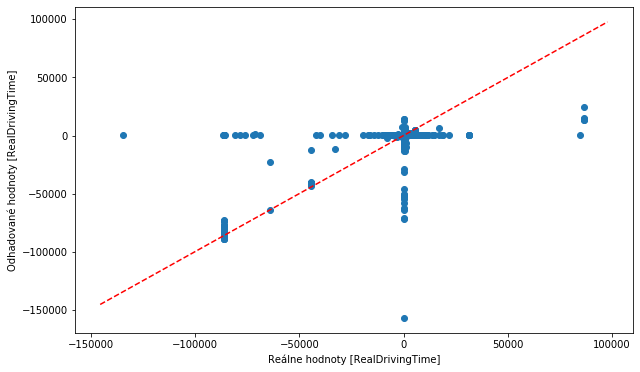

In [75]:
test_predictions = testModel.predict(normed_test_data).flatten()

f, ax = plt.subplots(figsize=(10, 6))
ax.scatter(test_labels, test_predictions)
plt.xlabel('Reálne hodnoty [' + label + ']')
plt.ylabel('Odhadované hodnoty [' + label + ']')

ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c="r")
plt.show()



Chybu vypočítame ako rozdiel medzi hodnotami, ktoré model predpovedal a ozajstnými výsledkami.
Vídím, že histogram veľkosti chýb pripomína väčšinou gaussovu krivku a teda najčastejšie sa chyby pohybujú v rozdmedzí 2 minút od ozajstnej hodnoty.
Avšak model sa pomýlil v niektorých prípadoch až o polhodinu.
Štatistika ukazuje aj, že sa pomýlil takmer o 10 hodín. Toto môže byť prípadom nesprávneho záznamu.

Najväčšia chyba:134730.859375
Najväčšia chyba v zápornom smere:-157850.0
% chýb menších ako 2 minúty: 0.913144448110209


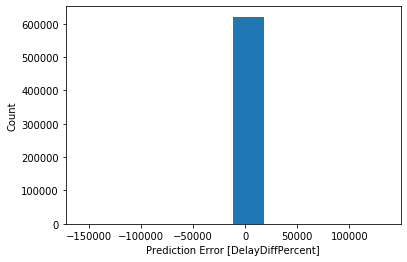

In [76]:
error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error)
plt.xlabel('Prediction Error [DelayDiffPercent]')
#plt.xlim([-1000,1000])
_ = plt.ylabel("Count")

In [80]:
just_Eval("BASEModel.h5",used_attributes)

------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 57.56 RealDrivingTime
Testing set Mean Sqrt Error: 391051.41 RealDrivingTime
Testing set Root Mean Sqrt Error: 625.34 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 360.84 RealDrivingTime
Testing set Mean Sqrt Error: 388068.62 RealDrivingTime
Testing set Root Mean Sqrt Error: 622.95 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 385.60 RealDrivingTime
Testing set Mean Sqrt Error: 434461.53 RealDrivingTime
Testing set Root Mean Sqrt Error: 659.14 RealDrivingTime
------Presnosť na FILTER3 dátach-------- 
Testing set Mean Abs Error: 437.11 RealDrivingTime
Testing set Mean Sqrt Error: 483233.78 RealDrivingTime
Testing set Root Mean Sqrt Error: 695.15 RealDrivingTime


## FILTER1

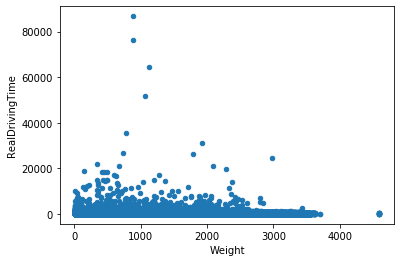

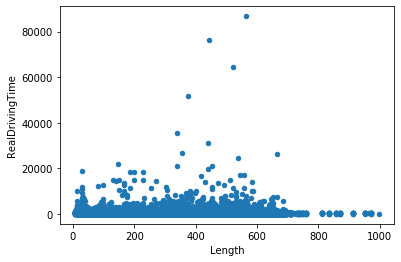

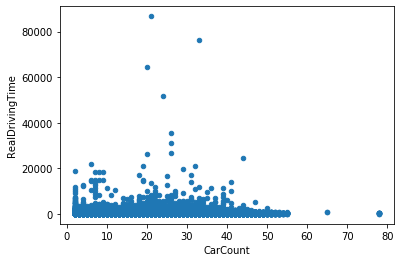

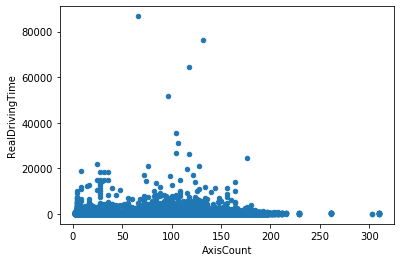

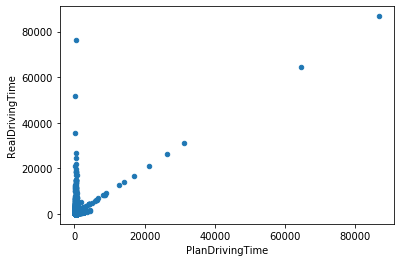

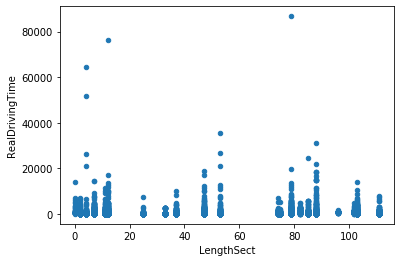

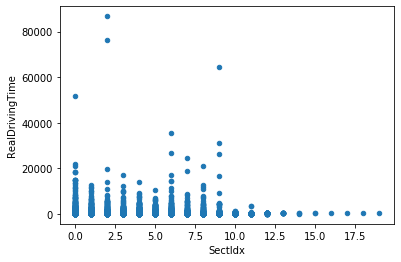

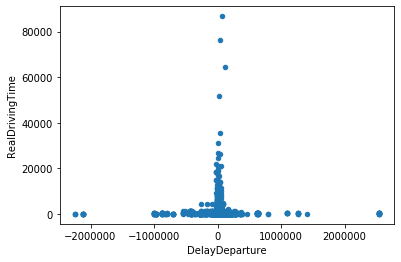

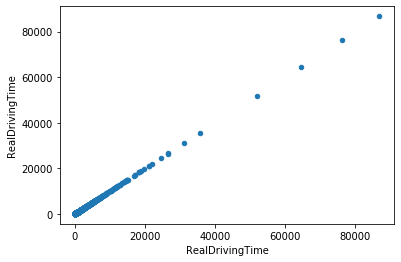

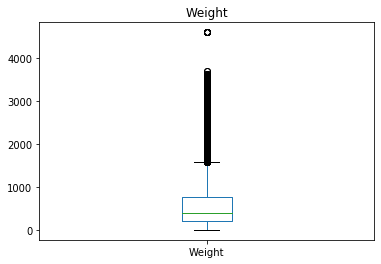

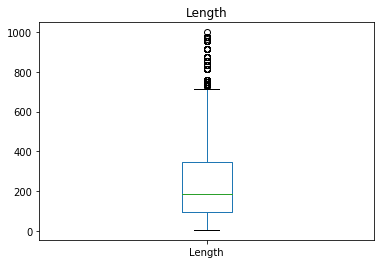

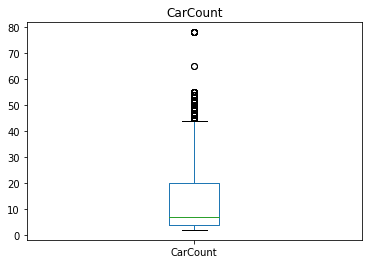

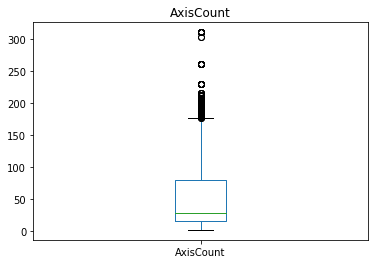

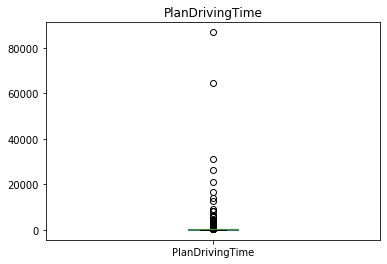

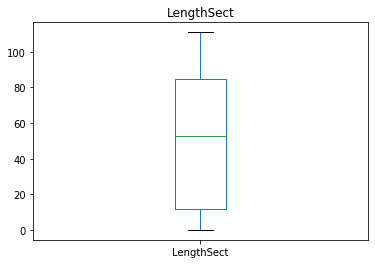

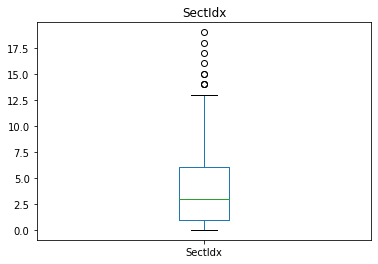

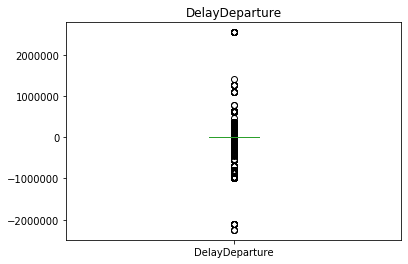

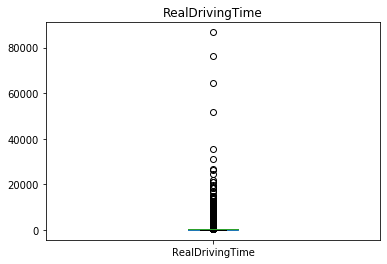

In [40]:
DFCUT = DFFILTER1[used_attributes]
for attr in used_attributes:
    DFCUT.plot(kind='scatter', x=attr, y=label)
    plt.show()
for attr in used_attributes:
    DFCUT.plot(kind='box', y=attr)
    plt.title(attr)
    plt.show()

-----------------------------FILTER1---------------------------------
Veľkosť trénovacej množniy: (2087046, 8)
Veľkosť testovacej množniy: (521762, 8)

....................
....................
.....------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 104.61 RealDrivingTime
Testing set Mean Sqrt Error: 1699037.88 RealDrivingTime
Testing set Root Mean Sqrt Error: 1303.47 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 35.90 RealDrivingTime
Testing set Mean Sqrt Error: 24492.51 RealDrivingTime
Testing set Root Mean Sqrt Error: 156.50 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 36.79 RealDrivingTime
Testing set Mean Sqrt Error: 24968.63 RealDrivingTime
Testing set Root Mean Sqrt Error: 158.01 RealDrivingTime
------Presnosť na FILTER3 dátach-------- 
Testing set Mean Abs Error: 41.57 RealDrivingTime
Testing set Mean Sqrt Error: 5116.63 RealDrivingTime
Testing set Root Mean Sqrt Error: 71.53 RealDr

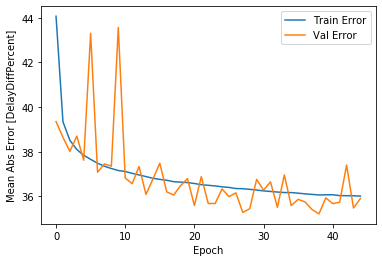

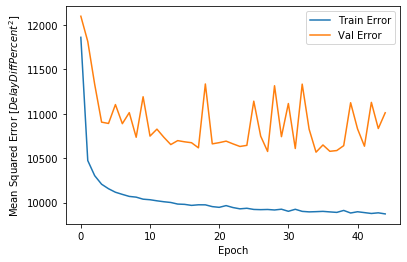

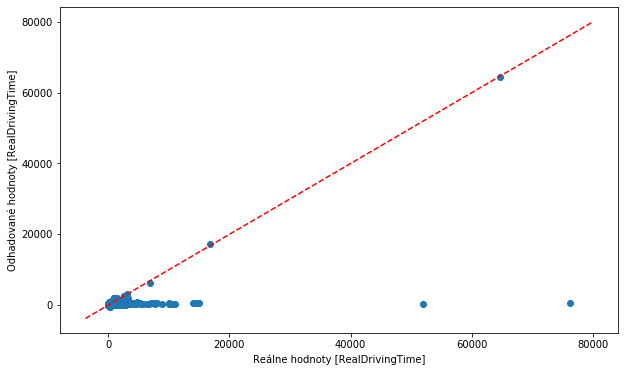

Najväčšia chyba:1020.33154296875
Najväčšia chyba v zápornom smere:-75584.359375
% približne správnych odhadov: 0.9563153315113021


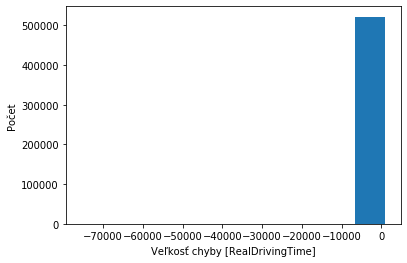

In [82]:
CreateAndFitModel("FILTER1", 0.0005, 120, "FILTER1ModelBasic",used_attributes)

Veľkosť trénovacej množniy: (2087002, 8)
Veľkosť testovacej množniy: (521751, 8)

....................
....................
....................
....................
.....

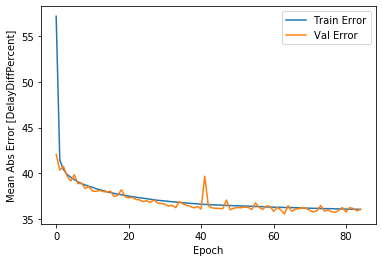

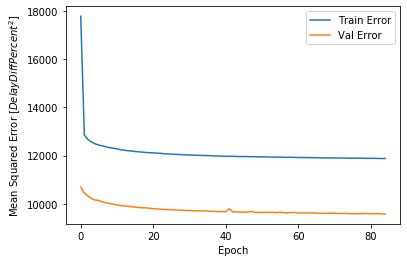

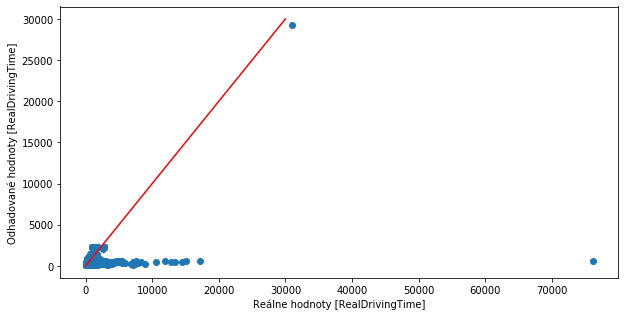

Najväčšia chyba:1374.6630859375
Najväčšia chyba v zápornom smere:-75588.2109375
% približne správnych odhadov: 0.9558505877324625


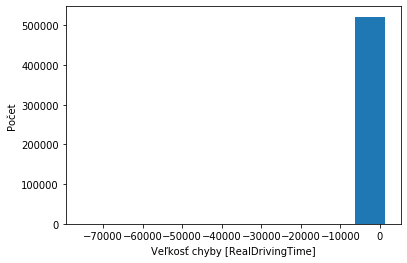

In [46]:
CreateAndFitModel("FILTER2", 0.0001, 120, "FILTER2ModelBasic",used_attributes)

In [78]:
just_Eval("FILTER2ModelBasic.h5",used_attributes)

------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 106.62 RealDrivingTime
Testing set Mean Sqrt Error: 1509959.00 RealDrivingTime
Testing set Root Mean Sqrt Error: 1228.80 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 41.89 RealDrivingTime
Testing set Mean Sqrt Error: 32704.80 RealDrivingTime
Testing set Root Mean Sqrt Error: 180.84 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 40.06 RealDrivingTime
Testing set Mean Sqrt Error: 26231.65 RealDrivingTime
Testing set Root Mean Sqrt Error: 161.96 RealDrivingTime
------Presnosť na FILTER3 dátach-------- 
Testing set Mean Abs Error: 32.68 RealDrivingTime
Testing set Mean Sqrt Error: 4353.25 RealDrivingTime
Testing set Root Mean Sqrt Error: 65.98 RealDrivingTime


-----------------------------FILTER3---------------------------------
Veľkosť trénovacej množniy: (1954766, 8)
Veľkosť testovacej množniy: (488691, 8)

....................
....................
...------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 106.10 RealDrivingTime
Testing set Mean Sqrt Error: 1579098.12 RealDrivingTime
Testing set Root Mean Sqrt Error: 1256.62 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 42.63 RealDrivingTime
Testing set Mean Sqrt Error: 27645.22 RealDrivingTime
Testing set Root Mean Sqrt Error: 166.27 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 40.76 RealDrivingTime
Testing set Mean Sqrt Error: 25947.53 RealDrivingTime
Testing set Root Mean Sqrt Error: 161.08 RealDrivingTime
------Presnosť na FILTER3 dátach-------- 
Testing set Mean Abs Error: 33.40 RealDrivingTime
Testing set Mean Sqrt Error: 4394.77 RealDrivingTime
Testing set Root Mean Sqrt Error: 66.29 RealDriv

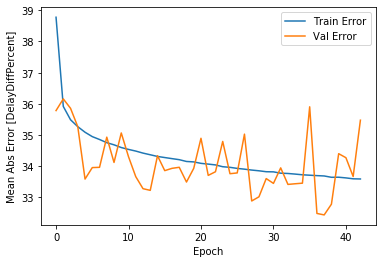

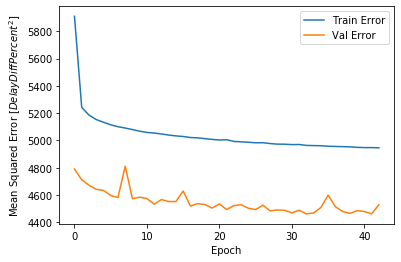

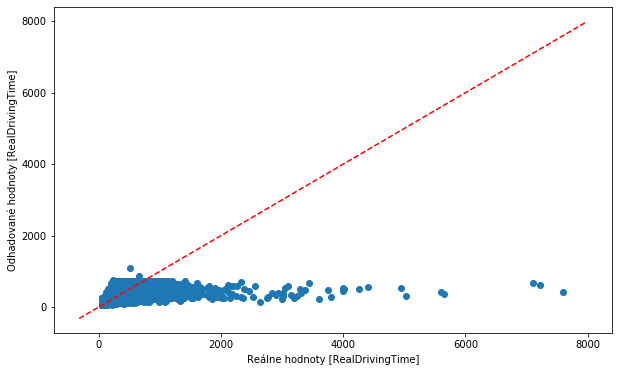

Najväčšia chyba:599.71923828125
Najväčšia chyba v zápornom smere:-7164.90283203125
% približne správnych odhadov: 0.962462987859404


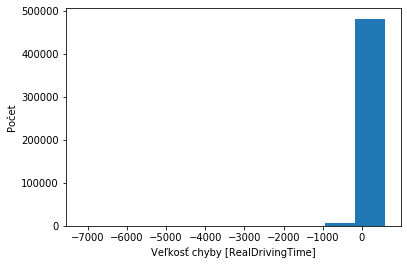

In [79]:
CreateAndFitModel("FILTER3", 0.001, 120, "FILTER2ModelBasic",used_attributes)

# Vyhodnotenie - TEST1

Môžem vidieť, že 

### BASELINE 

------Presnosť na BASE dátach-------- 
- MAE: 51.75
- MSE: 729741.16
- RMSE: 854.24

------Presnosť na FILTER1 dátach-------- 
- MAE: 41.39
- MSE: 19448.34
- RMSE: 139.45

------Presnosť na FILTER2 dátach-------- 
- MAE: 41.69
- MSE: 21140.70
- RMSE: 145.39

------Presnosť na FILTER3 dátach-------- 
- MAE: 39.00
- MSE: 5684.05
- RMSE: 75.39



### BASE

#### ------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 57.56 RealDrivingTime [+5,81‬]
- Testing set Mean Sqrt Error: 391051.41 RealDrivingTime [-338 690]
- Testing set Root Mean Sqrt Error: 625.34 RealDrivingTime [-229]

------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 360.84 RealDrivingTime
- Testing set Mean Sqrt Error: 388068.62 RealDrivingTime
- Testing set Root Mean Sqrt Error: 622.95 RealDrivingTime

------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 385.60 RealDrivingTime
- Testing set Mean Sqrt Error: 434461.53 RealDrivingTime
- Testing set Root Mean Sqrt Error: 659.14 RealDrivingTime

------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 437.11 RealDrivingTime
- Testing set Mean Sqrt Error: 483233.78 RealDrivingTime
- Testing set Root Mean Sqrt Error: 695.15 RealDrivingTime

### FILTER1

------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 104.61 RealDrivingTime
- Testing set Mean Sqrt Error: 1699037.88 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1303.47 RealDrivingTime

#### ------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 35.90 RealDrivingTime [-5,49]
- Testing set Mean Sqrt Error: 24492.51 RealDrivingTime[+5 044]
- Testing set Root Mean Sqrt Error: 156.50 RealDrivingTime [+17]

------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 36.79 RealDrivingTime
- Testing set Mean Sqrt Error: 24968.63 RealDrivingTime
- Testing set Root Mean Sqrt Error: 158.01 RealDrivingTime

------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 41.57 RealDrivingTime
- Testing set Mean Sqrt Error: 5116.63 RealDrivingTime
- Testing set Root Mean Sqrt Error: 71.53 RealDrivingTime

### FILTER2 

------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 106.62 RealDrivingTime
- Testing set Mean Sqrt Error: 1509959.00 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1228.80 RealDrivingTime

------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 41.89 RealDrivingTime
- Testing set Mean Sqrt Error: 32704.80 RealDrivingTime
- Testing set Root Mean Sqrt Error: 180.84 RealDrivingTime

#### ------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 40.06 RealDrivingTime [+0,2]
- Testing set Mean Sqrt Error: 26231.65 RealDrivingTime [+5 091‬]
- Testing set Root Mean Sqrt Error: 161.96 RealDrivingTime [+16‬]

------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 32.68 RealDrivingTime
- Testing set Mean Sqrt Error: 4353.25 RealDrivingTime
- Testing set Root Mean Sqrt Error: 65.98 RealDrivingTime

### FILTER3

------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 106.10 RealDrivingTime
- Testing set Mean Sqrt Error: 1579098.12 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1256.62 RealDrivingTime

------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 42.63 RealDrivingTime
- Testing set Mean Sqrt Error: 27645.22 RealDrivingTime
- Testing set Root Mean Sqrt Error: 166.27 RealDrivingTime

------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 40.76 RealDrivingTime
- Testing set Mean Sqrt Error: 25947.53 RealDrivingTime
- Testing set Root Mean Sqrt Error: 161.08 RealDrivingTime

#### ------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 33.40 RealDrivingTime [-5,6]
- Testing set Mean Sqrt Error: 4394.77 RealDrivingTime [-1 290]
- Testing set Root Mean Sqrt Error: 66.29 RealDrivingTime [-9]

# Experiment - dropout DelayDeparture

In [62]:
Exp_NoDelay = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx',
                    'RealDrivingTime']

In [64]:
used_attributes = Exp_NoDelay
label = used_attributes[-1]

In [ ]:
CreateAndFitModelLocations("FILTER1",0.01, 120, "FILTER1ModelNoDelay", used_attributes)

# Experiment - nahradenie premennej DelayDeparture  DelayDepartureReduced
Táto premenná odstráni počiatočné meškanie, a sleduje meškanie získané iba od začatia trasy. 

In [56]:
Exp_reducedDelay = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDepartureReduced',
                    'RealDrivingTime']

In [57]:
used_attributes = Exp_reducedDelay
label = used_attributes[-1]

In [58]:
CreateAndFitModel("FILTER1",0.001, 120, "FILTER1ModelReducedDelay", used_attributes)

-----------------------------FILTER1---------------------------------
Veľkosť trénovacej množniy: (2087046, 8)
Veľkosť testovacej množniy: (521762, 8)

.

KeyboardInterrupt: 

In [86]:
DFCUT = DFFILTER1[used_attributes]
cor = DFCUT.corr()
print(cor[label].sort_values(ascending=False))

RealDrivingTime          1.000000
PlanDrivingTime          0.786623
CarCount                 0.176910
AxisCount                0.168994
LengthSect               0.168222
Weight                   0.147740
Length                   0.120951
DelayDepartureReduced    0.038888
SectIdx                 -0.068993
Name: RealDrivingTime, dtype: float64


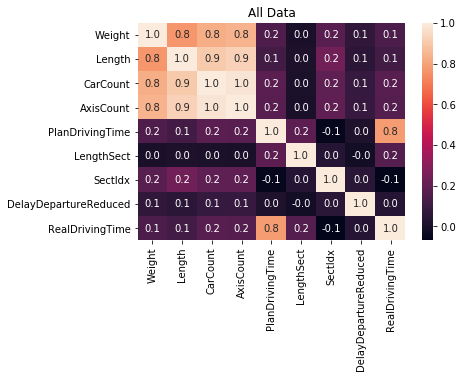

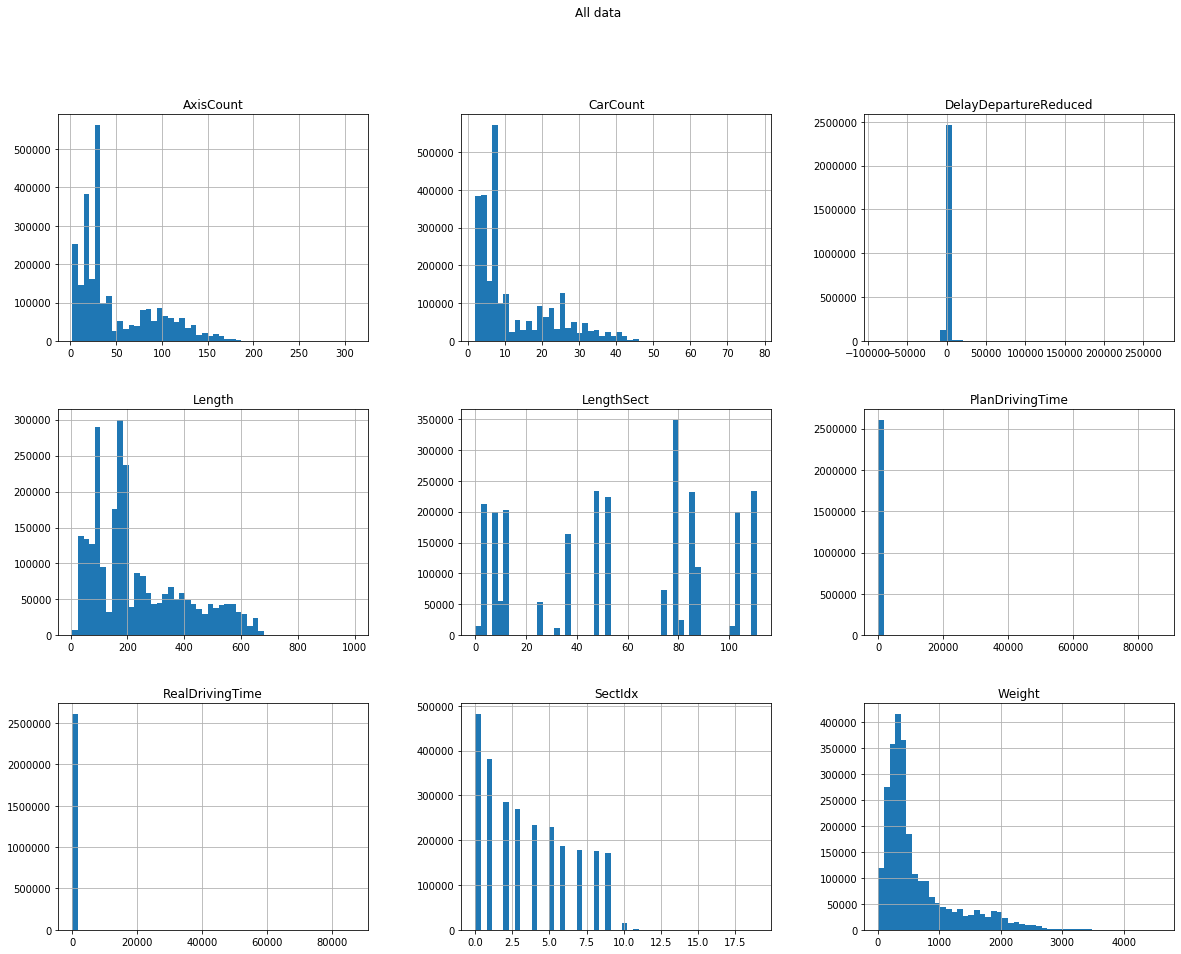

In [87]:
plt.title("All Data")
sns.heatmap(cor, annot = True, fmt='.1f')    
    
DFCUT.hist(bins=50, figsize=(20, 15))
plt.suptitle("All data")
plt.show()

Najväčšia chyba:790.657470703125
Najväčšia chyba v zápornom smere:-75588.6640625
% chýb menších ako 2 minúty: 0.959621436593696


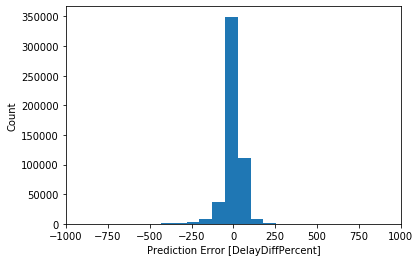

In [79]:
error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1000,1000])
_ = plt.ylabel("Count")

-----------------------------FILTER1---------------------------------
Veľkosť trénovacej množniy: (2087046, 8)
Veľkosť testovacej množniy: (521762, 8)

....................
....................
........------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 34.41 RealDrivingTime
Testing set Mean Sqrt Error: 24340.14 RealDrivingTime
Testing set Root Mean Sqrt Error: 156.01 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 35.36 RealDrivingTime
Testing set Mean Sqrt Error: 24807.94 RealDrivingTime
Testing set Root Mean Sqrt Error: 157.51 RealDrivingTime
------Presnosť na FILTER3 dátach-------- 
Testing set Mean Abs Error: 40.68 RealDrivingTime
Testing set Mean Sqrt Error: 4978.77 RealDrivingTime
Testing set Root Mean Sqrt Error: 70.56 RealDrivingTime


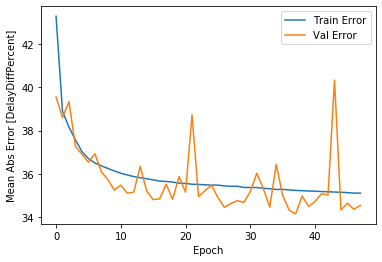

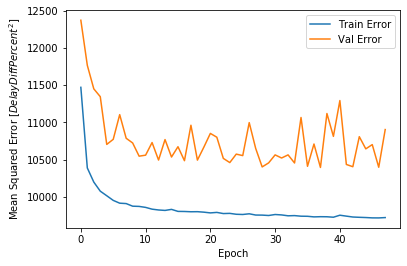

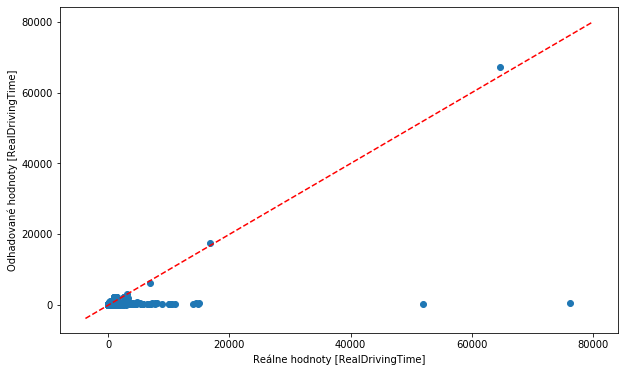

Najväčšia chyba:2624.40625
Najväčšia chyba v zápornom smere:-75609.9609375


NameError: name 'margin' is not defined

In [91]:
dfCut = DFFILTER1[used_attributes]

train_dataset = dfCut.sample(frac=0.8, random_state=0)
test_dataset = dfCut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print("-----------------------------" + "FILTER1" + "---------------------------------")
print("Veľkosť trénovacej množniy: " + str(train_dataset.shape))
print("Veľkosť testovacej množniy: " + str(test_dataset.shape))

train_stats = train_dataset.describe()
train_stats = train_stats.transpose() 
    
normed_train_data = (train_dataset-train_stats['mean']) / train_stats['std']
normed_test_data = (test_dataset-train_stats['mean']) / train_stats['std']
    
#tvorba modelu
testModel = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(normed_train_data.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(0.0005)

testModel.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae','mse'])
    
testModelHistory = testModel.fit(normed_train_data, train_labels, epochs=EPOCHS,
            validation_split=0.25, verbose=0, callbacks=[early_stop,save_best_model("FILTER1ModelReducedDelay.h5"), PrintDot()])
    
testModel = load_model("FILTER1ModelReducedDelay.h5")
    
plot_history(testModelHistory)
    
eval_Model("FILTER1", testModel, used_attributes)
eval_Model("FILTER2", testModel, used_attributes)
eval_Model("FILTER3", testModel, used_attributes)
    
predictions = testModel.predict(normed_test_data).flatten()

f, ax = plt.subplots(figsize=(10, 6))
ax.scatter(test_labels, predictions)
plt.xlabel('Reálne hodnoty [' + label + ']')
plt.ylabel('Odhadované hodnoty [' + label + ']')

ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c="r")
plt.show()
    
error = predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% približne správnych odhadov: " + str(len(lessThan2Min)/len(error)))


plt.hist(error)
plt.xlabel('Veľkosť chyby ['+label+']')
plt.ylabel("Počet")
plt.show()

# Vyhodnotenie


# OPRAVIT
FILTER1

------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 34.41 RealDrivingTime
- Testing set Mean Sqrt Error: 24340.14 RealDrivingTime
- Testing set Root Mean Sqrt Error: 156.01 RealDrivingTime

------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 35.36 RealDrivingTime
- Testing set Mean Sqrt Error: 24807.94 RealDrivingTime
- Testing set Root Mean Sqrt Error: 157.51 RealDrivingTime

------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 40.68 RealDrivingTime
- Testing set Mean Sqrt Error: 4978.77 RealDrivingTime
- Testing set Root Mean Sqrt Error: 70.56 RealDrivingTime



# Test 2 - sledovanie vplyvu typu vlaku na jazdnu dobu
V tomto teste sledujem, aký vplyv na presnosť modelu má vlastnosť typ vlaku.
Novými sledovanými vlastnosťami teda budú:
- Ex 
- Mn
- Nex
- Os 
- Pn
- R
- Sluz
- Sp
- Sv
- Vlec

Vynechané z databázy sú vlaky typu PMD a Lv ktoré v datasete neboli dostatočne zastúpené, a nepatria medzi vlaky osobnej alebo nákladnej dopravy

In [81]:
test2 = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDeparture',
         'Ex', 'Mn', 'Nex', 'Os', 'Pn', 'R', 'Sluz', 'Sp', 'Sv', 'Vlec',
         'RealDrivingTime']

In [82]:
used_attributes = test2
label = used_attributes[-1]

In [86]:
nakladne = DFFILTER1[(DFFILTER1['TrainType'].isin(['Nex','Mn','Pn']))]
osobne = DFFILTER1[(DFFILTER1['TrainType'].isin(['Os','Ex','R']))]
ostatne = DFFILTER1[(DFFILTER1['TrainType'].isin(['Sluz','Sp','Sv','Vlec']))]

In [87]:
vlaky = []
for typ in train_types:
    vlaky.append(DFFILTER1[(DFFILTER1['TrainType'] == typ)])

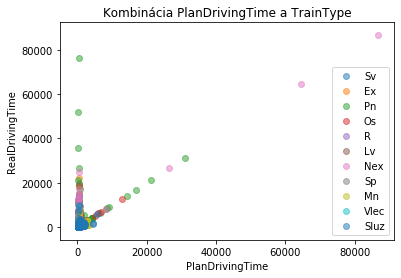

In [88]:
for vlak in vlaky:
    label = vlak['TrainType'].iat[0]
    plt.scatter(vlak['PlanDrivingTime'],vlak['RealDrivingTime'],alpha=0.5,label=label)

plt.ylabel("RealDrivingTime")
plt.xlabel("PlanDrivingTime")
plt.title("Kombinácia PlanDrivingTime a TrainType")
plt.legend()
plt.show()


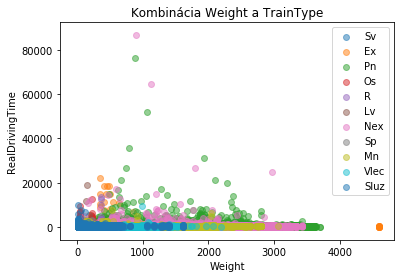

In [89]:
for vlak in vlaky:
    label = vlak['TrainType'].iat[0]
    plt.scatter(vlak['Weight'],vlak['RealDrivingTime'],alpha=0.5,label=label)

plt.ylabel("RealDrivingTime")
plt.xlabel("Weight")
plt.title("Kombinácia Weight a TrainType")
plt.legend()
plt.show()

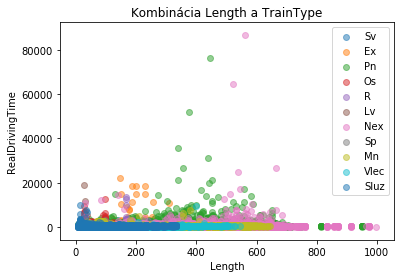

In [90]:
for vlak in vlaky:
    label = vlak['TrainType'].iat[0]
    plt.scatter(vlak['Length'],vlak['RealDrivingTime'],alpha=0.5,label=label)

plt.ylabel("RealDrivingTime")
plt.xlabel("Length")
plt.title("Kombinácia Length a TrainType")
plt.legend()
plt.show()

## One-Hot encoding
Typy vlakov získame z vlastnosti TrainType, ale keďže je hodnota kategorická a neordinálna, tak algoritmus strojového učenia s ňou nevie pracovať. Preto použijem techniku nazvanú one-hot encoding ktorá každému údaju pridá aj informáciu o tom, či daný vlak je alebo nieje daného typu

In [91]:
type = DFBASE['TrainType']
for train_type in train_types:
    DFBASE[train_type] = (type == train_type)*1.0
    
type = DFFILTER1['TrainType']
for train_type in train_types:
    DFFILTER1[train_type] = (type == train_type)*1.0
    
type = DFFILTER2['TrainType']
for train_type in train_types:
    DFFILTER2[train_type] = (type == train_type)*1.0
    
type = DFFILTER3['TrainType']
for train_type in train_types:
    DFFILTER3[train_type] = (type == train_type)*1.0

Najväčší lineárny plyv na meškanie má vlastnosť Ex, čo znamená, že vlaky Typu Ex mávajú menšie meškania ako iné vlaky. Podobný vlpyv májú aj vlaky typu R. 
Naopak väčšie meškania majú vlaky typu Pn, Os, Nex, Mn 

Avšak tieto korelácie sú veľmi slabé

In [102]:
cor_vlastnosti = train_types.copy()
cor_vlastnosti = np.append(cor_vlastnosti,['RealDrivingTime'])

DFCUT = DFFILTER1[cor_vlastnosti]
cor = DFCUT.corr()
print(cor[label].sort_values(ascending=False))

Sluz               1.000000
RealDrivingTime    0.044686
Vlec              -0.002233
Mn                -0.005182
Sp                -0.006934
Sv                -0.007077
Lv                -0.007597
R                 -0.027409
Nex               -0.030765
Os                -0.041391
Pn                -0.041400
Ex                -0.048724
Name: Sluz, dtype: float64


Počet vlakov pre každý typ:
Sv: 21261
Ex: 731321
Pn: 572598
Os: 572404
R: 286275
Lv: 24472
Nex: 350679
Sp: 20418
Mn: 11445
Vlec: 2132
Sluz: 15804


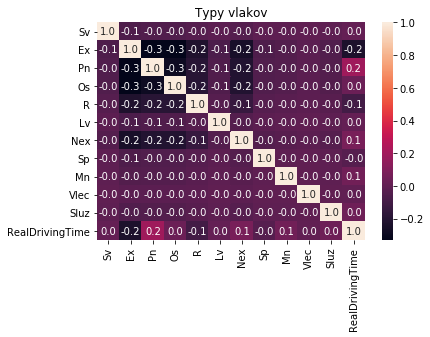

In [103]:
plt.title("Typy vlakov")
sns.heatmap(cor, annot = True, fmt='.1f')    

print("Počet vlakov pre každý typ:")
for typ_vlaku in train_types:
    print(typ_vlaku + ": " + str(len(DFFILTER1[(DFFILTER1[typ_vlaku] == 1.0)])))

-----------------------------BASE---------------------------------
Veľkosť trénovacej množniy: (2485460, 18)
Veľkosť testovacej množniy: (621365, 18)

....................
................------Presnosť na BASE dátach-------- 
Testing set Loss : 301176.06 RealDrivingTime
Testing set Mean Abs Error: 49.04 RealDrivingTime
Testing set Mean Sqrt Error: 301175.59 RealDrivingTime
Testing set Root Mean Sqrt Error: 548.79 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Loss : 532327.75 RealDrivingTime
Testing set Mean Abs Error: 464.12 RealDrivingTime
Testing set Mean Sqrt Error: 532327.06 RealDrivingTime
Testing set Root Mean Sqrt Error: 729.61 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Loss : 665447.58 RealDrivingTime
Testing set Mean Abs Error: 518.79 RealDrivingTime
Testing set Mean Sqrt Error: 665448.25 RealDrivingTime
Testing set Root Mean Sqrt Error: 815.75 RealDrivingTime
------Presnosť na FILTER3 dátach-------- 
Testing set Loss : 76048

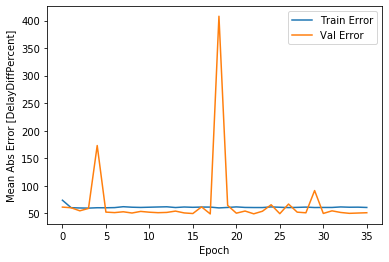

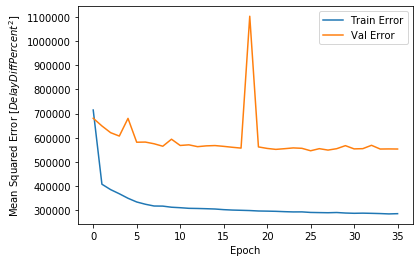

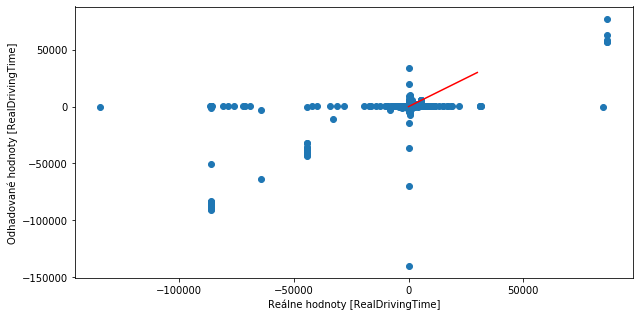

Najväčšia chyba:134513.609375
Najväčšia chyba v zápornom smere:-140454.921875
% približne správnych odhadov: 0.9327545001730062


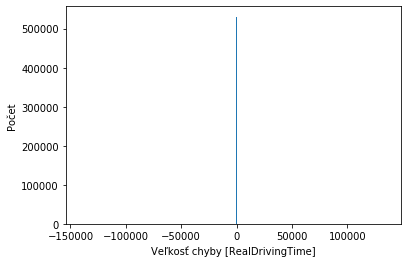

In [104]:
CreateAndFitModel("BASE",0.001, 120, "BASEModelTrainType", used_attributes)

-----------------------------FILTER1---------------------------------
Veľkosť trénovacej množniy: (2087047, 18)
Veľkosť testovacej množniy: (521762, 18)

....................
...------Presnosť na BASE dátach-------- 
Testing set Loss : 1675611.57 RealDrivingTime
Testing set Mean Abs Error: 109.89 RealDrivingTime
Testing set Mean Sqrt Error: 1675617.00 RealDrivingTime
Testing set Root Mean Sqrt Error: 1294.46 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Loss : 17814.88 RealDrivingTime
Testing set Mean Abs Error: 35.23 RealDrivingTime
Testing set Mean Sqrt Error: 17814.88 RealDrivingTime
Testing set Root Mean Sqrt Error: 133.47 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Loss : 19694.34 RealDrivingTime
Testing set Mean Abs Error: 37.08 RealDrivingTime
Testing set Mean Sqrt Error: 19694.25 RealDrivingTime
Testing set Root Mean Sqrt Error: 140.34 RealDrivingTime
------Presnosť na FILTER3 dátach-------- 
Testing set Loss : 5190.81 RealDrivi

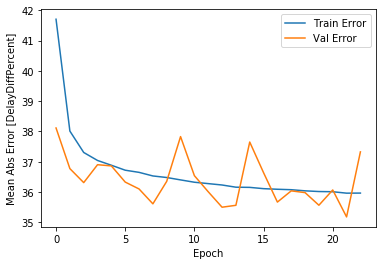

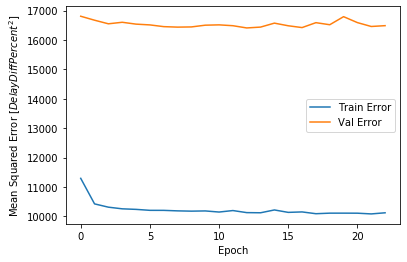

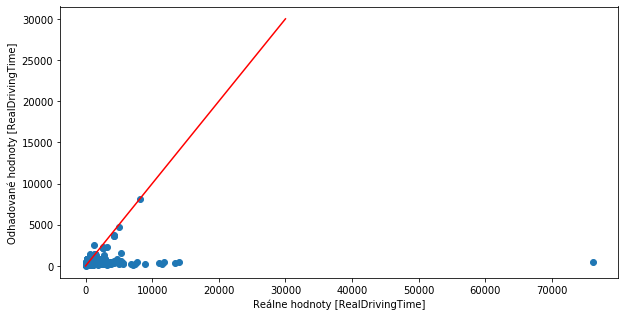

Najväčšia chyba:1253.189208984375
Najväčšia chyba v zápornom smere:-75596.234375
% približne správnych odhadov: 0.9573100379100049


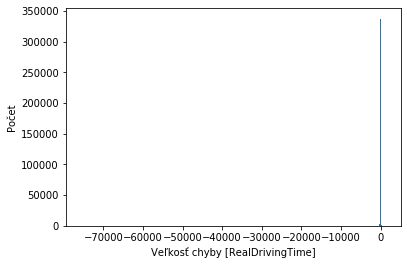

In [105]:
CreateAndFitModel("FILTER1", 0.001, 120, "FILTER1ModelTrainType",used_attributes)

-----------------------------FILTER2---------------------------------
Veľkosť trénovacej množniy: (2087002, 18)
Veľkosť testovacej množniy: (521751, 18)

....................
....................
....................
....................
.....------Presnosť na BASE dátach-------- 
Testing set Loss : 1277618.86 RealDrivingTime
Testing set Mean Abs Error: 110.16 RealDrivingTime
Testing set Mean Sqrt Error: 1277611.38 RealDrivingTime
Testing set Root Mean Sqrt Error: 1130.31 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Loss : 17891.02 RealDrivingTime
Testing set Mean Abs Error: 38.11 RealDrivingTime
Testing set Mean Sqrt Error: 17891.04 RealDrivingTime
Testing set Root Mean Sqrt Error: 133.76 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Loss : 19515.39 RealDrivingTime
Testing set Mean Abs Error: 36.00 RealDrivingTime
Testing set Mean Sqrt Error: 19515.37 RealDrivingTime
Testing set Root Mean Sqrt Error: 139.70 RealDrivingTime
------Presnos

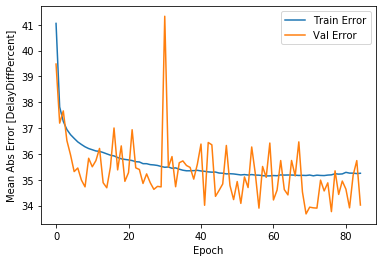

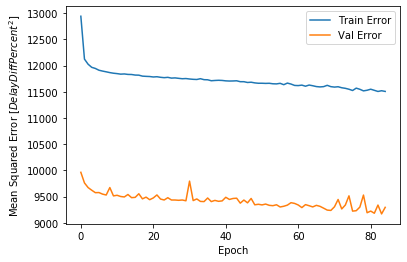

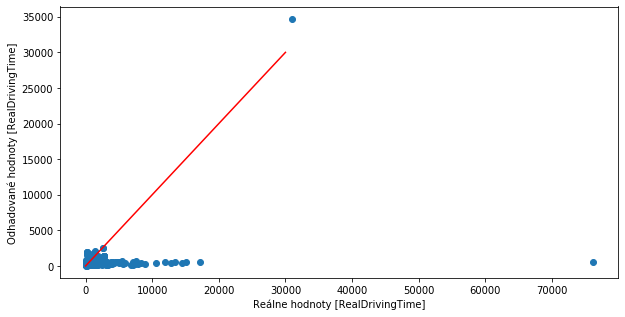

Najväčšia chyba:3655.7109375
Najväčšia chyba v zápornom smere:-75575.5
% približne správnych odhadov: 0.9592832596391765


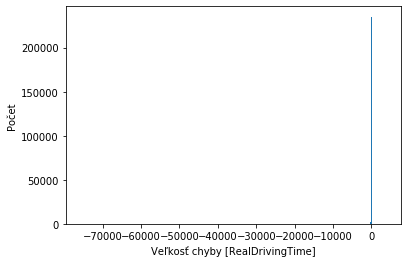

In [106]:
CreateAndFitModel("FILTER2", 0.001, 120, "FILTER2ModelTrainType",used_attributes)

-----------------------------FILTER3---------------------------------
Veľkosť trénovacej množniy: (1954766, 18)
Veľkosť testovacej množniy: (488692, 18)

....................
....................
................. 
------Presnosť na BASE dátach-------- 
Testing set Loss : 1611438.94 RealDrivingTime
Testing set Mean Abs Error: 111.15 RealDrivingTime
Testing set Mean Sqrt Error: 1611435.50 RealDrivingTime
Testing set Root Mean Sqrt Error: 1269.42 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Loss : 18950.18 RealDrivingTime
Testing set Mean Abs Error: 41.34 RealDrivingTime
Testing set Mean Sqrt Error: 18950.19 RealDrivingTime
Testing set Root Mean Sqrt Error: 137.66 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Loss : 20452.85 RealDrivingTime
Testing set Mean Abs Error: 38.57 RealDrivingTime
Testing set Mean Sqrt Error: 20452.76 RealDrivingTime
Testing set Root Mean Sqrt Error: 143.01 RealDrivingTime
------Presnosť na FILTER3 dátach-------- 

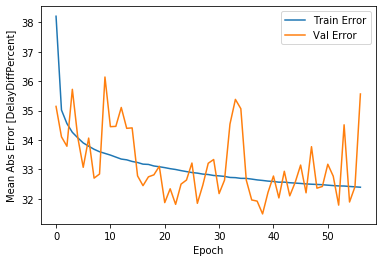

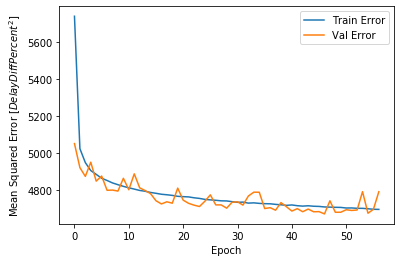

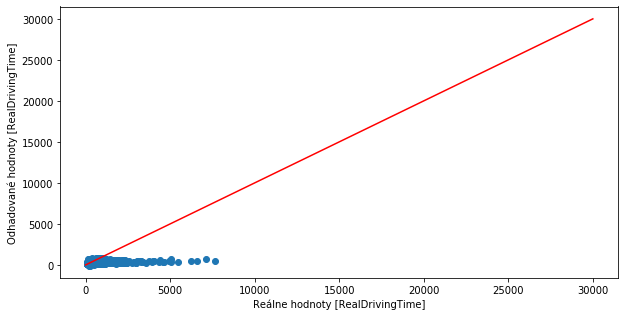

Najväčšia chyba:500.76861572265625
Najväčšia chyba v zápornom smere:-7184.32373046875
% približne správnych odhadov: 0.9639691257479148


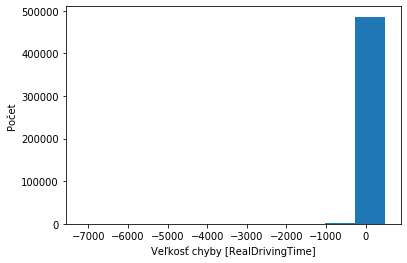

In [109]:
CreateAndFitModel("FILTER3", 0.001, 120, "FILTER3ModelTrainType",used_attributes)

Opäť rozdelíme dataset na trénovaciu a testovaciu časť a znormujeme hodnoty

## Vyhodnotenie

### BASE

#### ------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 49.04 RealDrivingTime [-8,52]
- Testing set Mean Sqrt Error: 301175.59 RealDrivingTime [-89 876‬]
- Testing set Root Mean Sqrt Error: 548.79 RealDrivingTime [-64]

------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 464.12 RealDrivingTime
- Testing set Mean Sqrt Error: 532327.06 RealDrivingTime
- Testing set Root Mean Sqrt Error: 729.61 RealDrivingTime

------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 518.79 RealDrivingTime
- Testing set Mean Sqrt Error: 665448.25 RealDrivingTime
- Testing set Root Mean Sqrt Error: 815.75 RealDrivingTime

------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 580.09 RealDrivingTime
- Testing set Mean Sqrt Error: 760480.38 RealDrivingTime
- Testing set Root Mean Sqrt Error: 872.06 RealDrivingTime

### FILTER1

------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 109.89 RealDrivingTime        
- Testing set Mean Sqrt Error: 1675617.00 RealDrivingTime   
- Testing set Root Mean Sqrt Error: 1294.46 RealDrivingTime 

#### ------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 35.23 RealDrivingTime         [-0,67]
- Testing set Mean Sqrt Error: 17814.88 RealDrivingTime     [-6 678]
- Testing set Root Mean Sqrt Error: 133.47 RealDrivingTime  [-23‬]

------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 37.08 RealDrivingTime         
- Testing set Mean Sqrt Error: 19694.25 RealDrivingTime     
- Testing set Root Mean Sqrt Error: 140.34 RealDrivingTime  

------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 41.30 RealDrivingTime         
- Testing set Mean Sqrt Error: 5190.81 RealDrivingTime      
- Testing set Root Mean Sqrt Error: 72.05 RealDrivingTime   


### FILTER2

------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 110.16 RealDrivingTime
- Testing set Mean Sqrt Error: 1277611.38 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1130.31 RealDrivingTime

------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 38.11 RealDrivingTime
- Testing set Mean Sqrt Error: 17891.04 RealDrivingTime
- Testing set Root Mean Sqrt Error: 133.76 RealDrivingTime

#### #### ------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 36.00 RealDrivingTime [-4,06‬]
- Testing set Mean Sqrt Error: 19515.37 RealDrivingTime [-6 716]
- Testing set Root Mean Sqrt Error: 139.70 RealDrivingTime [-22‬]

------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 42.08 RealDrivingTime
- Testing set Mean Sqrt Error: 4992.30 RealDrivingTime
- Testing set Root Mean Sqrt Error: 70.66 RealDrivingTime

### FILTER3

------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 111.15 RealDrivingTime
- Testing set Mean Sqrt Error: 1611435.50 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1269.42 RealDrivingTime

------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 41.34 RealDrivingTime
- Testing set Mean Sqrt Error: 18950.19 RealDrivingTime
- Testing set Root Mean Sqrt Error: 137.66 RealDrivingTime

------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 38.57 RealDrivingTime
- Testing set Mean Sqrt Error: 20452.76 RealDrivingTime
- Testing set Root Mean Sqrt Error: 143.01 RealDrivingTime

#### ------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 32.06 RealDrivingTime [-1,34]
- Testing set Mean Sqrt Error: 4333.63 RealDrivingTime [-61]
- Testing set Root Mean Sqrt Error: 65.83 RealDrivingTime [-0,46‬]

# Test 3 - vplyv ročných obodobí na jazdné doby vlakov
Podľa času výjazdu vlaku zo stanice som rozdelil dáta do štyroch skúpín 
- Jar 
- Leto
- Jeseň
- Zima

In [105]:
test3 = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDeparture',
         'Jar', 'Leto', 'Jesen', 'Zima',
         'RealDrivingTime']

In [106]:
used_attributes = test3
label = used_attributes[-1]

In [107]:
season = DFBASE['Season']
for seas in season_types:
    DFBASE[seas] = (season == seas)*1.0
    
season = DFFILTER1['Season']
for seas in season_types:
    DFFILTER1[seas] = (season == seas)*1.0
    
season = DFFILTER2['Season']
for seas in season_types:
    DFFILTER2[seas] = (season == seas)*1.0
    
season = DFFILTER3['Season']
for seas in season_types:
    DFFILTER3[seas] = (season == seas)*1.0

In [108]:
cor_vlastnosti = season_types.copy()
cor_vlastnosti = np.append(cor_vlastnosti,['RealDrivingTime'])
print(cor_vlastnosti)

DFCUT = DFFILTER1[cor_vlastnosti]
cor = DFCUT.corr()
print(cor[label].sort_values(ascending=False))

['Jar' 'Leto' 'Jesen' 'Zima' 'RealDrivingTime']
RealDrivingTime    1.000000
Jesen              0.011990
Jar                0.000004
Leto              -0.003767
Zima              -0.009385
Name: RealDrivingTime, dtype: float64


Korelačná matica ukazuje, že ročné obodbie nemá žiadny zaznamenateľný vplyv na jazdnú dobu vlaku. Toto môže viesť k dvom prípadom. Buď model prestane byť senzitívny na isté neuróny, alebo sa naučí zle, čím by sme mohli získať nepresnosť vo predikciách

Počet vlakov pre každú sezónu:
Jar: 658533
Leto: 756633
Jesen: 713488
Zima: 480155


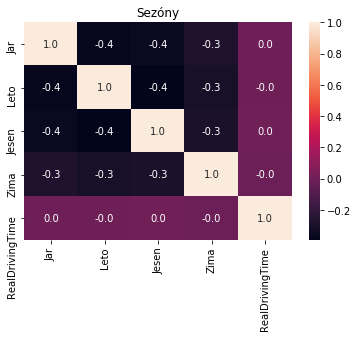

In [116]:
plt.title("Sezóny")
sns.heatmap(cor, annot = True, fmt='.1f')    

print("Počet vlakov pre každú sezónu:")
for roc_obd in season_types:
    print(roc_obd + ": " + str(len(DFFILTER1[(DFFILTER1[roc_obd] == 1.0)])))

In [119]:
jar = DFFILTER1[(DFFILTER1['Season'] == 'Jar')]
leto = DFFILTER1[(DFFILTER1['Season'] == 'Leto')]
jesen = DFFILTER1[(DFFILTER1['Season'] == 'Jesen')]
zima = DFFILTER1[(DFFILTER1['Season'] == 'Zima')]

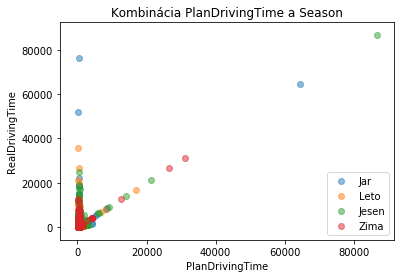

In [121]:
plt.scatter(jar['PlanDrivingTime'],jar['RealDrivingTime'],alpha=0.5,label="Jar")
plt.scatter(leto['PlanDrivingTime'],leto['RealDrivingTime'],alpha=0.5,label="Leto")
plt.scatter(jesen['PlanDrivingTime'],jesen['RealDrivingTime'],alpha=0.5,label="Jesen")
plt.scatter(zima['PlanDrivingTime'],zima['RealDrivingTime'],alpha=0.5,label="Zima")
plt.ylabel("RealDrivingTime")
plt.xlabel("PlanDrivingTime")
plt.title("Kombinácia PlanDrivingTime a Season")
plt.legend()
plt.show()


-----------------------------BASE---------------------------------
Veľkosť trénovacej množniy: (2485460, 12)
Veľkosť testovacej množniy: (621365, 12)

....................
....................
....................
....................
..... 
------Presnosť na BASE dátach-------- 
Testing set Loss : 296364.05 RealDrivingTime
Testing set Mean Abs Error: 48.80 RealDrivingTime
Testing set Mean Sqrt Error: 296364.25 RealDrivingTime
Testing set Root Mean Sqrt Error: 544.39 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Loss : 551564.38 RealDrivingTime
Testing set Mean Abs Error: 449.53 RealDrivingTime
Testing set Mean Sqrt Error: 551566.06 RealDrivingTime
Testing set Root Mean Sqrt Error: 742.67 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Loss : 666869.55 RealDrivingTime
Testing set Mean Abs Error: 490.91 RealDrivingTime
Testing set Mean Sqrt Error: 666868.81 RealDrivingTime
Testing set Root Mean Sqrt Error: 816.62 RealDrivingTime
------Presno

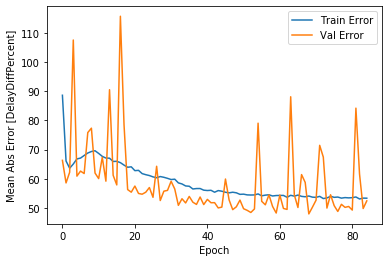

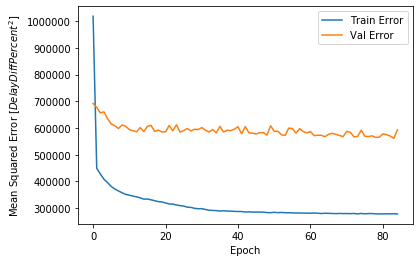

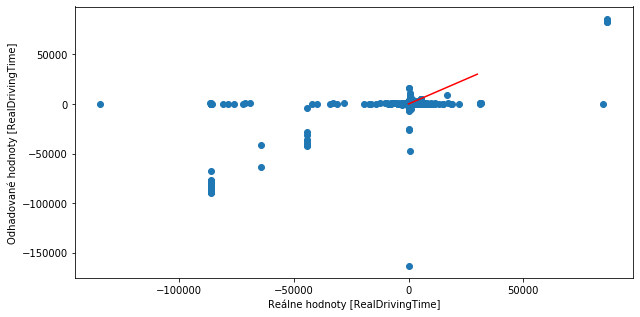

Najväčšia chyba:134265.0625
Najväčšia chyba v zápornom smere:-163621.390625
% približne správnych odhadov: 0.9312288268570004


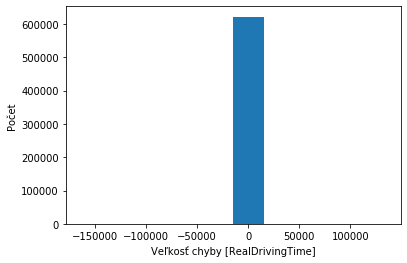

In [124]:
CreateAndFitModel("BASE",  0.001, 120, "BASEModelSeason",used_attributes)

-----------------------------FILTER1---------------------------------
Veľkosť trénovacej množniy: (2087047, 12)
Veľkosť testovacej množniy: (521762, 12)

................... 
------Presnosť na BASE dátach-------- 
Testing set Loss : 1629008.28 RealDrivingTime
Testing set Mean Abs Error: 108.08 RealDrivingTime
Testing set Mean Sqrt Error: 1629013.88 RealDrivingTime
Testing set Root Mean Sqrt Error: 1276.33 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Loss : 18012.14 RealDrivingTime
Testing set Mean Abs Error: 36.89 RealDrivingTime
Testing set Mean Sqrt Error: 18012.23 RealDrivingTime
Testing set Root Mean Sqrt Error: 134.21 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Loss : 19902.79 RealDrivingTime
Testing set Mean Abs Error: 38.74 RealDrivingTime
Testing set Mean Sqrt Error: 19902.79 RealDrivingTime
Testing set Root Mean Sqrt Error: 141.08 RealDrivingTime
------Presnosť na FILTER3 dátach-------- 
Testing set Loss : 5562.76 RealDrivingT

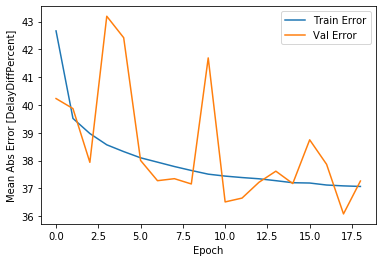

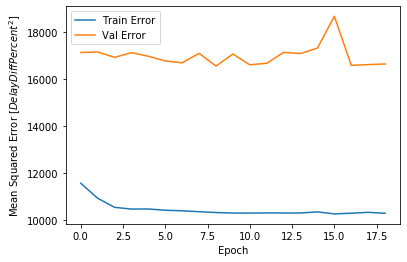

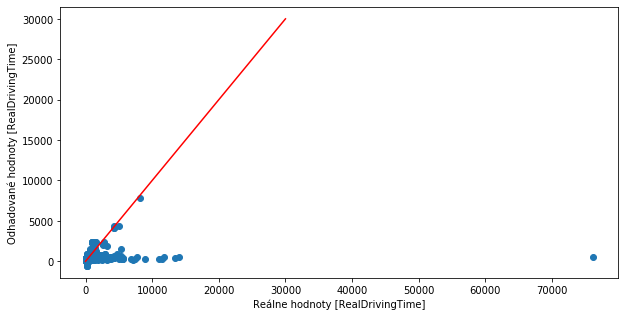

Najväčšia chyba:1398.8212890625
Najväčšia chyba v zápornom smere:-75596.28125
% približne správnych odhadov: 0.9549583909905283


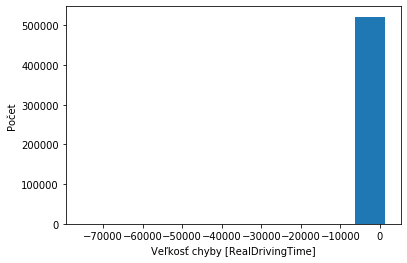

In [44]:
CreateAndFitModel("FILTER1", 0.001, 120, "FILTER1ModelSeason",used_attributes)

-----------------------------FILTER2---------------------------------
Veľkosť trénovacej množniy: (2087002, 12)
Veľkosť testovacej množniy: (521751, 12)

....................
....................
..... 
------Presnosť na BASE dátach-------- 
Testing set Loss : 1502507.55 RealDrivingTime
Testing set Mean Abs Error: 109.66 RealDrivingTime
Testing set Mean Sqrt Error: 1502506.25 RealDrivingTime
Testing set Root Mean Sqrt Error: 1225.77 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Loss : 18062.21 RealDrivingTime
Testing set Mean Abs Error: 39.14 RealDrivingTime
Testing set Mean Sqrt Error: 18062.16 RealDrivingTime
Testing set Root Mean Sqrt Error: 134.40 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Loss : 19645.94 RealDrivingTime
Testing set Mean Abs Error: 36.75 RealDrivingTime
Testing set Mean Sqrt Error: 19645.92 RealDrivingTime
Testing set Root Mean Sqrt Error: 140.16 RealDrivingTime
------Presnosť na FILTER3 dátach-------- 
Testing set

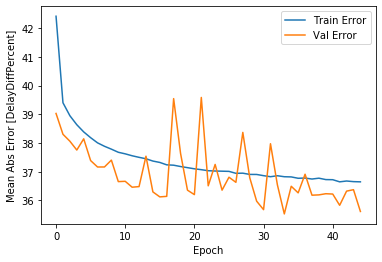

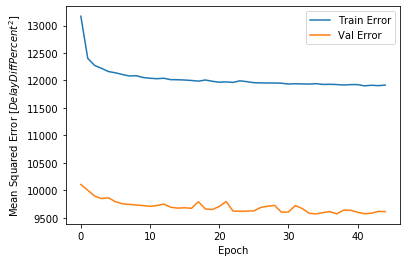

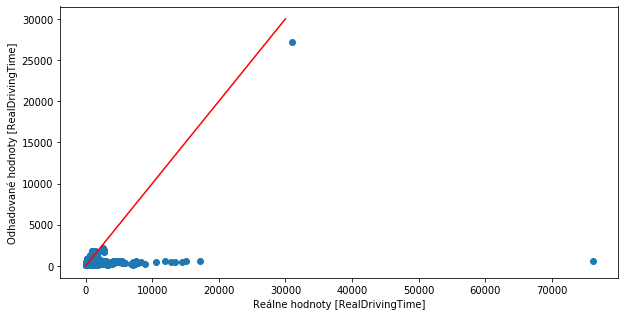

Najväčšia chyba:868.001708984375
Najväčšia chyba v zápornom smere:-75569.3828125
% približne správnych odhadov: 0.9561821635224466


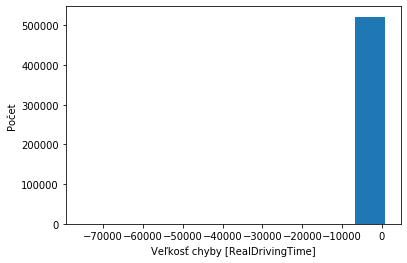

In [45]:
CreateAndFitModel("FILTER2", 0.001, 120, "FILTER2ModelSeason", used_attributes)

-----------------------------FILTER3---------------------------------
Veľkosť trénovacej množniy: (1954766, 12)
Veľkosť testovacej množniy: (488692, 12)

....................
....................
....................
....... 
------Presnosť na BASE dátach-------- 
Testing set Loss : 1641437.47 RealDrivingTime
Testing set Mean Abs Error: 111.17 RealDrivingTime
Testing set Mean Sqrt Error: 1641434.50 RealDrivingTime
Testing set Root Mean Sqrt Error: 1281.18 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Loss : 19272.66 RealDrivingTime
Testing set Mean Abs Error: 42.87 RealDrivingTime
Testing set Mean Sqrt Error: 19272.71 RealDrivingTime
Testing set Root Mean Sqrt Error: 138.83 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Loss : 20843.09 RealDrivingTime
Testing set Mean Abs Error: 40.22 RealDrivingTime
Testing set Mean Sqrt Error: 20842.96 RealDrivingTime
Testing set Root Mean Sqrt Error: 144.37 RealDrivingTime
------Presnosť na FILTER3 dáta

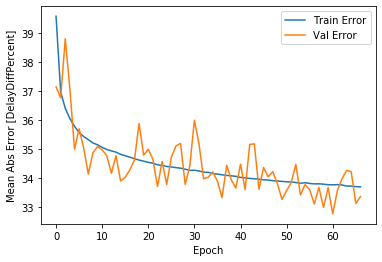

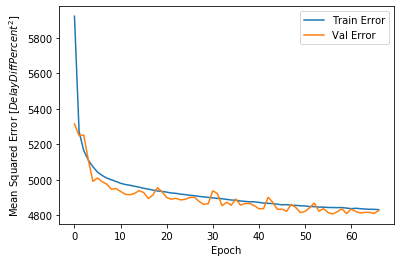

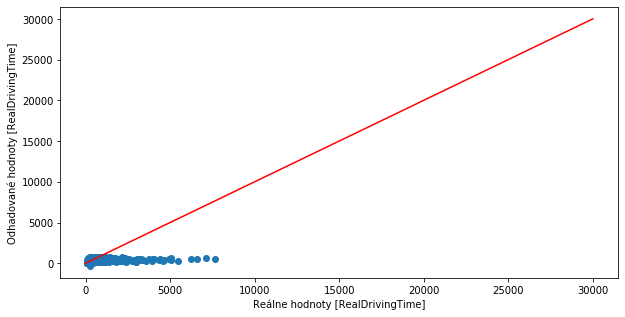

Najväčšia chyba:495.10308837890625
Najväčšia chyba v zápornom smere:-7145.7333984375
% približne správnych odhadov: 0.9614522030235814


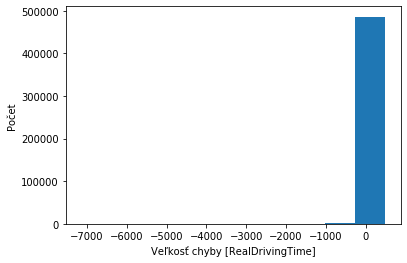

In [46]:
CreateAndFitModel("FILTER3", 0.001, 120, "FILTER3ModelSeason",used_attributes)

# Vyhodnotenie
Vidím, že ročné obdobie neprospieva modelu, a naopak, jeho vplyv práve zhoršuje presnosť modelu.


### BASE
#### ------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 48.80 RealDrivingTime [-8,76‬]
- Testing set Mean Sqrt Error: 296364.25 RealDrivingTime [-94 687]
- Testing set Root Mean Sqrt Error: 544.39 RealDrivingTime [-68‬]

------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 449.53 RealDrivingTime
- Testing set Mean Sqrt Error: 551566.06 RealDrivingTime
- Testing set Root Mean Sqrt Error: 742.67 RealDrivingTime

------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 490.91 RealDrivingTime
- Testing set Mean Sqrt Error: 666868.81 RealDrivingTime
- Testing set Root Mean Sqrt Error: 816.62 RealDrivingTime

------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 505.30 RealDrivingTime
- Testing set Mean Sqrt Error: 561800.12 RealDrivingTime
- Testing set Root Mean Sqrt Error: 749.53 RealDrivingTime
### FILTER1

------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 108.08 RealDrivingTime
- Testing set Mean Sqrt Error: 1629013.88 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1276.33 RealDrivingTime

#### ------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 36.89 RealDrivingTime [+0,99]
- Testing set Mean Sqrt Error: 18012.23 RealDrivingTime [-6 480]
- Testing set Root Mean Sqrt Error: 134.21 RealDrivingTime [-22‬]

------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 38.74 RealDrivingTime
- Testing set Mean Sqrt Error: 19902.79 RealDrivingTime
- Testing set Root Mean Sqrt Error: 141.08 RealDrivingTime

------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 44.73 RealDrivingTime
- Testing set Mean Sqrt Error: 5562.76 RealDrivingTime
- Testing set Root Mean Sqrt Error: 74.58 RealDrivingTime


### FILTER2

------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 109.66 RealDrivingTime
- Testing set Mean Sqrt Error: 1502506.25 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1225.77 RealDrivingTime

------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 39.14 RealDrivingTime
- Testing set Mean Sqrt Error: 18062.16 RealDrivingTime
- Testing set Root Mean Sqrt Error: 134.40 RealDrivingTime

#### ------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 36.75 RealDrivingTime [-3,31]
- Testing set Mean Sqrt Error: 19645.92 RealDrivingTime [-6 586]
- Testing set Root Mean Sqrt Error: 140.16 RealDrivingTime [-21‬]

------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 40.10 RealDrivingTime
- Testing set Mean Sqrt Error: 4963.36 RealDrivingTime
- Testing set Root Mean Sqrt Error: 70.45 RealDrivingTime


### FILTER3

------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 111.17 RealDrivingTime
- Testing set Mean Sqrt Error: 1641434.50 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1281.18 RealDrivingTime

------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 42.87 RealDrivingTime
- Testing set Mean Sqrt Error: 19272.71 RealDrivingTime
- Testing set Root Mean Sqrt Error: 138.83 RealDrivingTime

------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 40.22 RealDrivingTime
- Testing set Mean Sqrt Error: 20842.96 RealDrivingTime
- Testing set Root Mean Sqrt Error: 144.37 RealDrivingTime

#### ------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 32.99 RealDrivingTime [-0,41]
- Testing set Mean Sqrt Error: 4457.50 RealDrivingTime [+63‬]
- Testing set Root Mean Sqrt Error: 66.76 RealDrivingTime [+0,47]‬

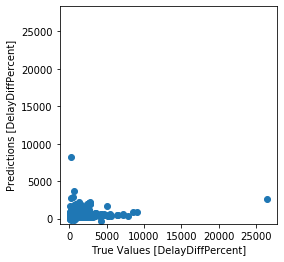

In [84]:
test_predictions = test3Model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

Najväčšia chyba:7920.373046875
Najväčšia chyba v zápornom smere:-23816.380859375
% chýb menších ako 2 minúty: 0.955540908738927


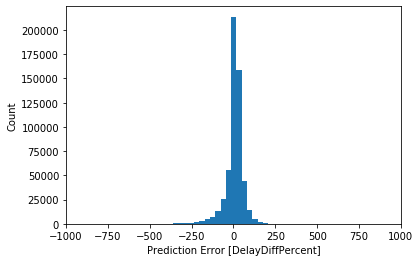

In [85]:
error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1000,1000])
_ = plt.ylabel("Count")

# Test 4 - vplyv obdobia dňa na jazdné doby 
Predpokladám, že vlaky v čase rána častejšie meškajú práve pre väčší počet spojov a cestujúcich. Do modelu pridávam vlastnosti
- Ráno
- Obed
- Večer
- Noc

In [86]:
test4 = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDeparture',
         'RealDrivingTime']

In [87]:
used_attributes = test4
label = used_attributes[-1]

In [109]:
type = DFBASE['DayTime']
for daytime in daytime_types:
    DFBASE[daytime] = (type == daytime)*1.0
    
type = DFFILTER1['DayTime']
for daytime in daytime_types:
    DFFILTER1[daytime] = (type == daytime)*1.0
    
type = DFFILTER2['DayTime']
for daytime in daytime_types:
    DFFILTER2[daytime] = (type == daytime)*1.0
    
type = DFFILTER3['DayTime']
for daytime in daytime_types:
    DFFILTER3[daytime] = (type == daytime)*1.0

Obdobie dňa má minimálny lineárny vplyv na jazdnú dobu.

In [110]:
cor_vlastnosti = daytime_types.copy()
cor_vlastnosti = np.append(cor_vlastnosti,['RealDrivingTime'])
print(cor_vlastnosti)

DFCUT = DFFILTER1[cor_vlastnosti]
cor = DFCUT.corr()
print(cor[label].sort_values(ascending=False))

['Obed' 'Rano' 'Noc' 'Vecer' 'RealDrivingTime']
RealDrivingTime    1.000000
Noc                0.058652
Rano              -0.009626
Vecer             -0.016293
Obed              -0.023647
Name: RealDrivingTime, dtype: float64


Počet vlakov pre každé obdobie:
Obed: 732494
Rano: 679428
Noc: 452544
Vecer: 744343


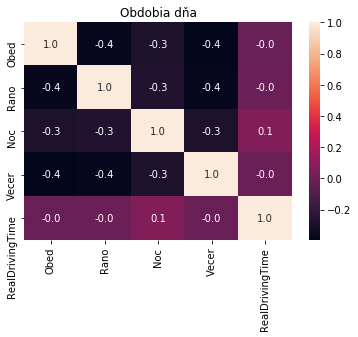

In [111]:
plt.title("Obdobia dňa")
sns.heatmap(cor, annot = True, fmt='.1f')    

print("Počet vlakov pre každé obdobie:")
for obdobie in daytime_types:
    print(obdobie + ": " + str(len(DFFILTER1[(DFFILTER1[obdobie] == 1.0)])))

-----------------------------BASE---------------------------------
Veľkosť trénovacej množniy: (2485460, 12)
Veľkosť testovacej množniy: (621365, 12)

....................
... 
------Presnosť na BASE dátach-------- 
Testing set Loss : 375182.85 RealDrivingTime
Testing set Mean Abs Error: 56.95 RealDrivingTime
Testing set Mean Sqrt Error: 375182.66 RealDrivingTime
Testing set Root Mean Sqrt Error: 612.52 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Loss : 256608.57 RealDrivingTime
Testing set Mean Abs Error: 324.54 RealDrivingTime
Testing set Mean Sqrt Error: 256608.92 RealDrivingTime
Testing set Root Mean Sqrt Error: 506.57 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Loss : 314965.97 RealDrivingTime
Testing set Mean Abs Error: 358.63 RealDrivingTime
Testing set Mean Sqrt Error: 314964.69 RealDrivingTime
Testing set Root Mean Sqrt Error: 561.22 RealDrivingTime
------Presnosť na FILTER3 dátach-------- 
Testing set Loss : 362737.90 RealDr

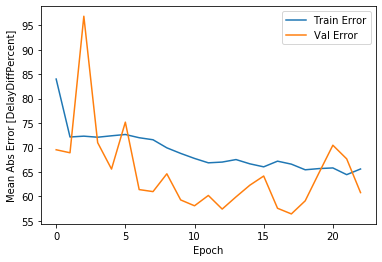

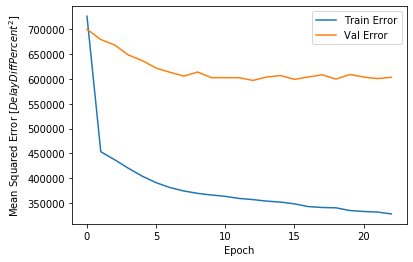

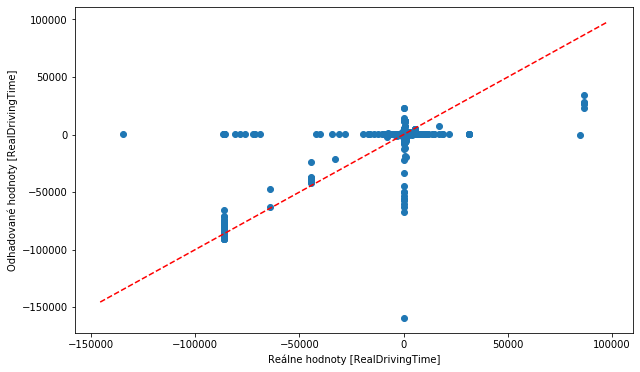

Najväčšia chyba:134790.734375
Najväčšia chyba v zápornom smere:-160017.96875
% približne správnych odhadov: 0.9196189035430061


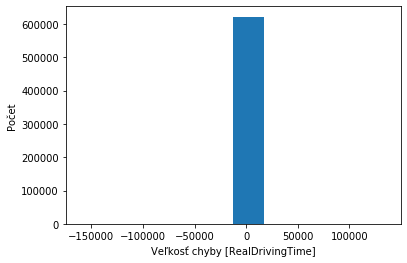

In [114]:
CreateAndFitModel("BASE", 0.001, 120, "BASEModelDayTime", used_attributes)

-----------------------------FILTER1---------------------------------
Veľkosť trénovacej množniy: (2087047, 12)
Veľkosť testovacej množniy: (521762, 12)

....................
....................
............. 
------Presnosť na BASE dátach-------- 
Testing set Loss : 1442834.44 RealDrivingTime
Testing set Mean Abs Error: 106.27 RealDrivingTime
Testing set Mean Sqrt Error: 1442830.25 RealDrivingTime
Testing set Root Mean Sqrt Error: 1201.18 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Loss : 17861.74 RealDrivingTime
Testing set Mean Abs Error: 35.93 RealDrivingTime
Testing set Mean Sqrt Error: 17861.75 RealDrivingTime
Testing set Root Mean Sqrt Error: 133.65 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Loss : 19734.84 RealDrivingTime
Testing set Mean Abs Error: 37.53 RealDrivingTime
Testing set Mean Sqrt Error: 19734.78 RealDrivingTime
Testing set Root Mean Sqrt Error: 140.48 RealDrivingTime
------Presnosť na FILTER3 dátach-------- 
Tes

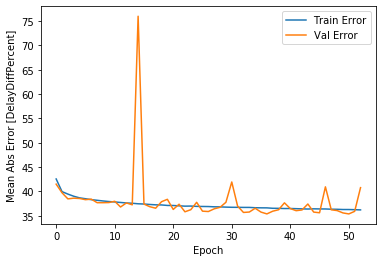

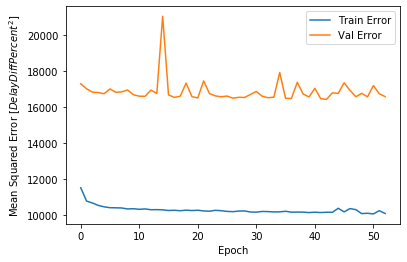

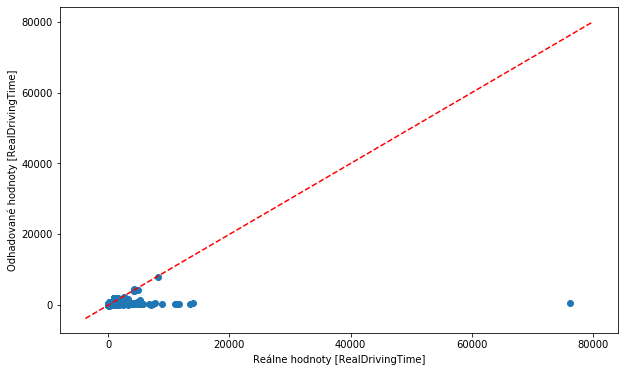

Najväčšia chyba:1090.104248046875
Najväčšia chyba v zápornom smere:-75567.3125
% približne správnych odhadov: 0.9559166823187584


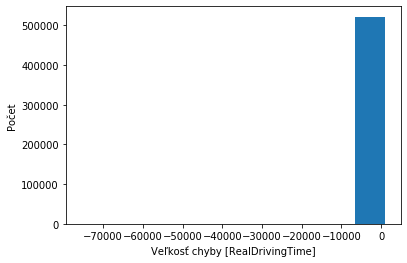

In [115]:
CreateAndFitModel("FILTER1", 0.001, 120, "FILTER1ModelDayTime", used_attributes)

-----------------------------FILTER2---------------------------------
Veľkosť trénovacej množniy: (2087002, 12)
Veľkosť testovacej množniy: (521751, 12)

....................
....................
....................
.. 
------Presnosť na BASE dátach-------- 
Testing set Loss : 1522335.85 RealDrivingTime
Testing set Mean Abs Error: 105.97 RealDrivingTime
Testing set Mean Sqrt Error: 1522337.75 RealDrivingTime
Testing set Root Mean Sqrt Error: 1233.83 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Loss : 17999.62 RealDrivingTime
Testing set Mean Abs Error: 37.71 RealDrivingTime
Testing set Mean Sqrt Error: 17999.59 RealDrivingTime
Testing set Root Mean Sqrt Error: 134.16 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Loss : 19596.79 RealDrivingTime
Testing set Mean Abs Error: 35.82 RealDrivingTime
Testing set Mean Sqrt Error: 19596.78 RealDrivingTime
Testing set Root Mean Sqrt Error: 139.99 RealDrivingTime
------Presnosť na FILTER3 dátach---

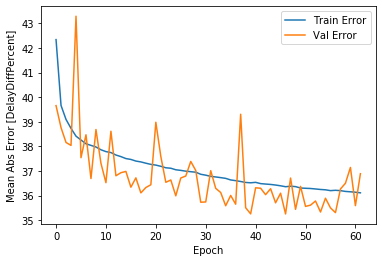

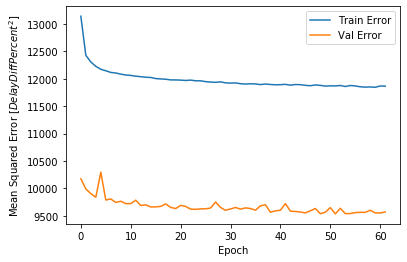

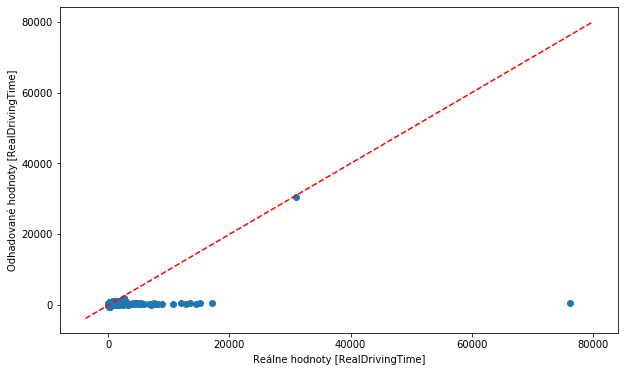

Najväčšia chyba:616.4736938476562
Najväčšia chyba v zápornom smere:-75599.8828125
% približne správnych odhadov: 0.956074832630891


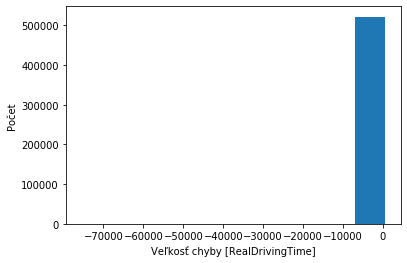

In [116]:
CreateAndFitModel("FILTER2", 0.001, 120, "FILTER2ModelDayTime",used_attributes)

-----------------------------FILTER3---------------------------------
Veľkosť trénovacej množniy: (1954766, 12)
Veľkosť testovacej množniy: (488692, 12)

....................
....................
....................
....................
...... 
------Presnosť na BASE dátach-------- 
Testing set Loss : 1564364.59 RealDrivingTime
Testing set Mean Abs Error: 109.04 RealDrivingTime
Testing set Mean Sqrt Error: 1564364.38 RealDrivingTime
Testing set Root Mean Sqrt Error: 1250.75 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Loss : 19146.77 RealDrivingTime
Testing set Mean Abs Error: 42.97 RealDrivingTime
Testing set Mean Sqrt Error: 19146.75 RealDrivingTime
Testing set Root Mean Sqrt Error: 138.37 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Loss : 20786.67 RealDrivingTime
Testing set Mean Abs Error: 40.04 RealDrivingTime
Testing set Mean Sqrt Error: 20786.66 RealDrivingTime
Testing set Root Mean Sqrt Error: 144.18 RealDrivingTime
------Pres

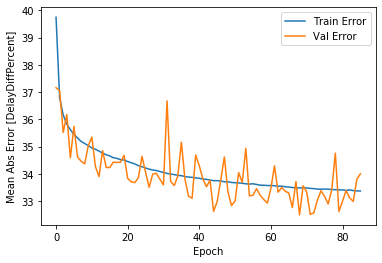

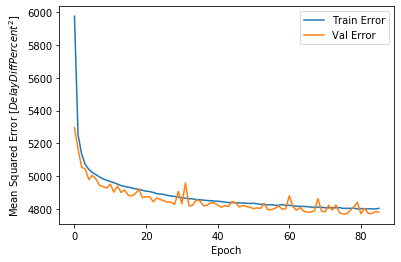

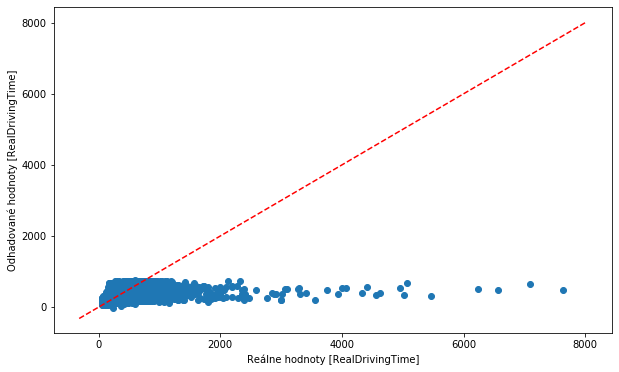

Najväčšia chyba:502.5411376953125
Najväčšia chyba v zápornom smere:-7152.13671875
% približne správnych odhadov: 0.9631628919646731


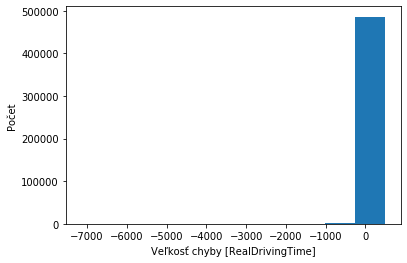

In [117]:
CreateAndFitModel("FILTER3", 0.001, 120, "FILTER3ModelDayTime",used_attributes)

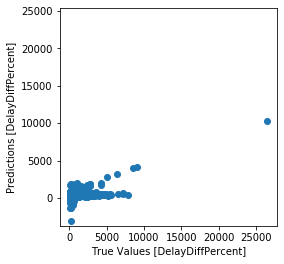

In [96]:
test_predictions = test4Model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

Najväčšia chyba:1588.075439453125
Najväčšia chyba v zápornom smere:-16140.400390625
% chýb menších ako 2 minúty: 0.9538589259441344


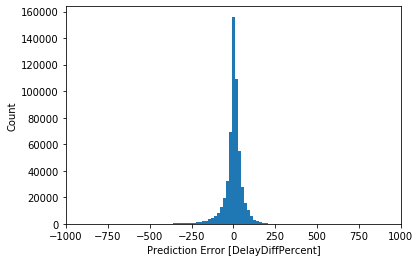

In [97]:
error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1000,1000])
_ = plt.ylabel("Count")

## Výsledky

### BASE 
#### ------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 56.95 RealDrivingTime [-0,61‬]
- Testing set Mean Sqrt Error: 375182.66 RealDrivingTime [-15 869]
- Testing set Root Mean Sqrt Error: 612.52 RealDrivingTime [+0,34]

------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 324.54 RealDrivingTime
- Testing set Mean Sqrt Error: 256608.92 RealDrivingTime
- Testing set Root Mean Sqrt Error: 506.57 RealDrivingTime

------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 358.63 RealDrivingTime
- Testing set Mean Sqrt Error: 314964.69 RealDrivingTime
- Testing set Root Mean Sqrt Error: 561.22 RealDrivingTime

------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 406.77 RealDrivingTime
- Testing set Mean Sqrt Error: 362737.62 RealDrivingTime
- Testing set Root Mean Sqrt Error: 602.28 RealDrivingTime


### FILTER1

------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 106.27 RealDrivingTime
- Testing set Mean Sqrt Error: 1442830.25 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1201.18 RealDrivingTime

#### ------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 35.93 RealDrivingTime [+0,03‬]
- Testing set Mean Sqrt Error: 17861.75 RealDrivingTime [-6 631‬]
- Testing set Root Mean Sqrt Error: 133.65 RealDrivingTime [-23]

------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 37.53 RealDrivingTime
- Testing set Mean Sqrt Error: 19734.78 RealDrivingTime
- Testing set Root Mean Sqrt Error: 140.48 RealDrivingTime

------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 43.49 RealDrivingTime
- Testing set Mean Sqrt Error: 5450.74 RealDrivingTime
- Testing set Root Mean Sqrt Error: 73.83 RealDrivingTime

### FILTER2

------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 105.97 RealDrivingTime
- Testing set Mean Sqrt Error: 1522337.75 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1233.83 RealDrivingTime

------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 37.71 RealDrivingTime 
- Testing set Mean Sqrt Error: 17999.59 RealDrivingTime 
- Testing set Root Mean Sqrt Error: 134.16 RealDrivingTime 

#### ------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 35.82 RealDrivingTime [-4,24]
- Testing set Mean Sqrt Error: 19596.78 RealDrivingTime [-6 635]
- Testing set Root Mean Sqrt Error: 139.99 RealDrivingTime [-22]

------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 40.07 RealDrivingTime
- Testing set Mean Sqrt Error: 4918.62 RealDrivingTime
- Testing set Root Mean Sqrt Error: 70.13 RealDrivingTime

### FILTER3

------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 109.04 RealDrivingTime
- Testing set Mean Sqrt Error: 1564364.38 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1250.75 RealDrivingTime

------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 42.97 RealDrivingTime
- Testing set Mean Sqrt Error: 19146.75 RealDrivingTime
- Testing set Root Mean Sqrt Error: 138.37 RealDrivingTime

------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 40.04 RealDrivingTime
- Testing set Mean Sqrt Error: 20786.66 RealDrivingTime
- Testing set Root Mean Sqrt Error: 144.18 RealDrivingTime

#### ------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 33.05 RealDrivingTime [-0,35‬]
- Testing set Mean Sqrt Error: 4425.37 RealDrivingTime [+31]
- Testing set Root Mean Sqrt Error: 66.52 RealDrivingTime [+0,23]

## Vyhodnotenie
Pridanie období dňa zlepšilo presnosť na všetkých typoch dát, okrem FILTER3. Uvidím, ako bude fungovať porpi ostatných filtroch.

# TEST 5 - pridanie lokality odkial a kam vlak smeruje
Chcem týmto donútiť model sa pretrénovať na trénvacích dátach, keďže vlaky často jazdia tú istú trasu a na danej trase sa často správajú podľa nejakého vzoru

In [48]:
test5 = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDeparture']
label = 'RealDrivingTime'

test5FILTER1 = test5.copy()
test5FILTER2 = test5.copy()
test5FILTER3 = test5.copy()

Odstránenie všetkých príznakov, ktoré sú príliš málo početné. Keď je príznak málo početný, tak ho nedokážeme normovať.

In [49]:
# BASE 
for stop in DFBASE.FromName.unique():
    check = DFBASE[(DFBASE['FromName'] == stop)].index
    if(len(check) < 5):
        DFBASE.drop(check,inplace=True)
    
for stop in DFBASE.ToName.unique():
    check = DFBASE[(DFBASE['ToName'] == stop)].index
    if(len(check) < 5):
        DFBASE.drop(check,inplace=True)

# FILTER1
for stop in DFFILTER1.FromName.unique():
    check = DFFILTER1[(DFFILTER1['FromName'] == stop)].index
    if(len(check) < 5):
        DFFILTER1.drop(check,inplace=True)
    
for stop in DFFILTER1.ToName.unique():
    check = DFFILTER1[(DFFILTER1['ToName'] == stop)].index
    if(len(check) < 5):
        DFFILTER1.drop(check,inplace=True)
        
# FILTER2
for stop in DFFILTER2.FromName.unique():
    check = DFFILTER2[(DFFILTER2['FromName'] == stop)].index
    if(len(check) < 5):
        DFFILTER2.drop(check,inplace=True)
    
for stop in DFFILTER2.ToName.unique():
    check = DFFILTER2[(DFFILTER2['ToName'] == stop)].index
    if(len(check) < 5):
        DFFILTER2.drop(check,inplace=True)
        
# FILTER3
for stop in DFFILTER3.FromName.unique():
    check = DFFILTER3[(DFFILTER3['FromName'] == stop)].index
    if(len(check) < 5):
        DFFILTER3.drop(check,inplace=True)
    
for stop in DFFILTER3.ToName.unique():
    check = DFFILTER3[(DFFILTER3['ToName'] == stop)].index
    if(len(check) < 5):
        DFFILTER3.drop(check,inplace=True)

Keďže nie všetky filtre obsahujú všetky zastávky, tak pre každý filter vytvoríme jeho vlastný zoznam atribútov.
Toto však má ale aj výrazný dopad na to, že jednotlivé filtre môžem porovnávať z hľadiska presnosti iba s rezervou. 
Pretože model dostane aj dáta z iných filtrov, ktoré obsahujú príznaky, na ktorých model netrénoval.

In [50]:
# BASE
type = DFBASE['FromName']
for zastavka in DFBASE.FromName.unique():
    test5.append("From" + zastavka)
    DFBASE["From" + zastavka] = (type == zastavka)*1.0
type = DFBASE['ToName']
for zastavka in DFBASE.ToName.unique():
    test5.append("To" + zastavka)
    DFBASE["To" + zastavka] = (type == zastavka)*1.0
    
test5.append("RealDrivingTime")

# FILTER1
type = DFFILTER1['FromName']
for zastavka in DFFILTER1.FromName.unique():
    test5FILTER1.append("From" + zastavka)
    DFFILTER1["From" + zastavka] = (type == zastavka)*1.0
type = DFFILTER1['ToName']
for zastavka in DFFILTER1.ToName.unique():
    test5FILTER1.append("To" + zastavka)
    DFFILTER1["To" + zastavka] = (type == zastavka)*1.0
    
test5FILTER1.append("RealDrivingTime")

#FILTER2
type = DFFILTER2['FromName']
for zastavka in DFFILTER2.FromName.unique():
    test5FILTER2.append("From" + zastavka)
    DFFILTER2["From" + zastavka] = (type == zastavka)*1.0
type = DFFILTER2['ToName']
for zastavka in DFFILTER2.ToName.unique():
    test5FILTER2.append("To" + zastavka)
    DFFILTER2["To" + zastavka] = (type == zastavka)*1.0
    
test5FILTER2.append("RealDrivingTime")

# FILTER3
type = DFFILTER3['FromName']
for zastavka in DFFILTER3.FromName.unique():
    test5FILTER3.append("From" + zastavka)
    DFFILTER3["From" + zastavka] = (type == zastavka)*1.0
type = DFFILTER3['ToName']
for zastavka in DFFILTER3.ToName.unique():
    test5FILTER3.append("To" + zastavka)
    DFFILTER3["To" + zastavka] = (type == zastavka)*1.0
    
test5FILTER3.append("RealDrivingTime")

### BASE

-----------------------------BASE---------------------------------
Veľkosť trénovacej množniy: (2485460, 51)
Veľkosť testovacej množniy: (621365, 51)

....................
....................
..................------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 44.65 RealDrivingTime
Testing set Mean Sqrt Error: 249243.69 RealDrivingTime
Testing set Root Mean Sqrt Error: 499.24 RealDrivingTime


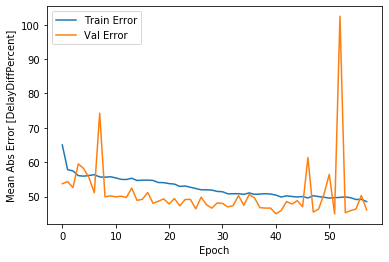

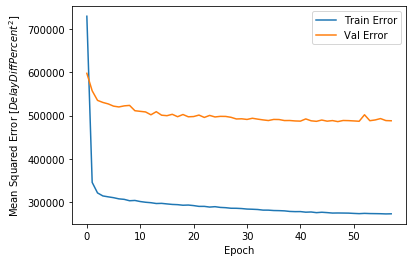

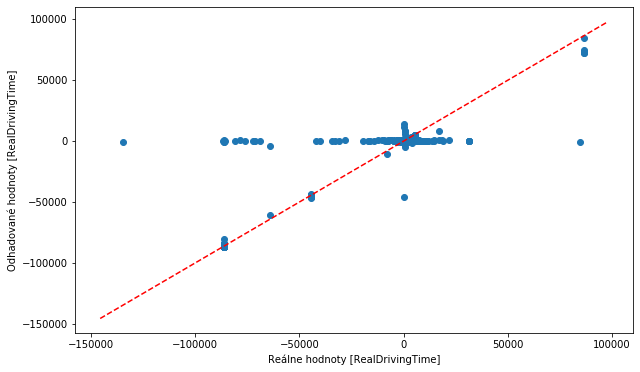

Najväčšia chyba:134091.421875
Najväčšia chyba v zápornom smere:-85776.9765625
% približne správnych odhadov: 0.9424460663217271


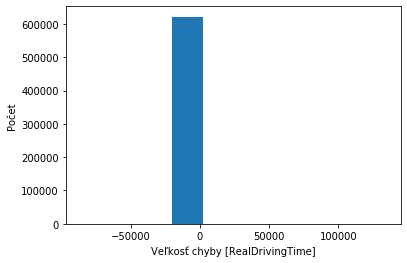

In [52]:
CreateAndFitModelLocations("BASE", 0.001, 120, "BASEModelLocations", test5) 

### FILTER1

-----------------------------FILTER1---------------------------------
Veľkosť trénovacej množniy: (2087046, 50)
Veľkosť testovacej množniy: (521762, 50)

....................
............------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 101.38 RealDrivingTime
Testing set Mean Sqrt Error: 1671351.00 RealDrivingTime
Testing set Root Mean Sqrt Error: 1292.81 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 34.43 RealDrivingTime
Testing set Mean Sqrt Error: 24282.11 RealDrivingTime
Testing set Root Mean Sqrt Error: 155.83 RealDrivingTime


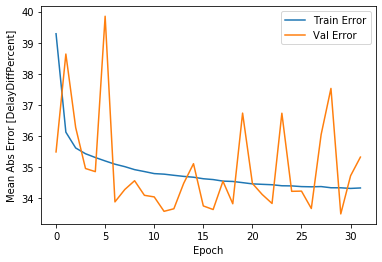

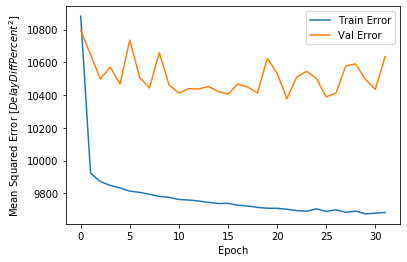

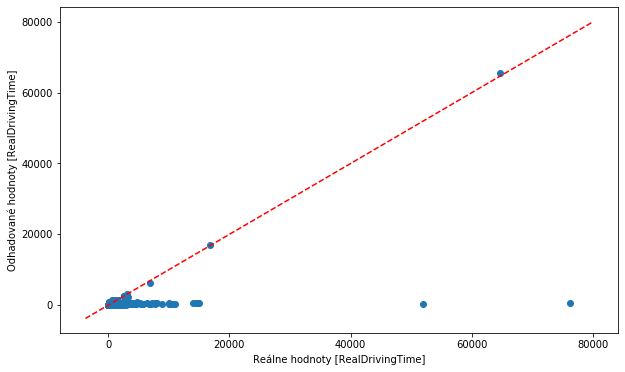

Najväčšia chyba:1008.625
Najväčšia chyba v zápornom smere:-75558.4609375
% približne správnych odhadov: 0.9577546850863037


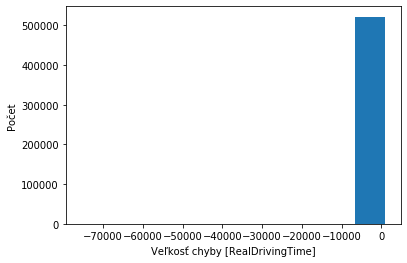

In [53]:
CreateAndFitModelLocations("FILTER1", 0.001, 120, "FILTER1ModelLocations", test5FILTER1)

### FILTER2

-----------------------------FILTER2---------------------------------
Veľkosť trénovacej množniy: (2087002, 50)
Veľkosť testovacej množniy: (521750, 50)

....................
....................------Presnosť na BASE dátach-------- 
Testing set Loss : 1660204.36 RealDrivingTime
Testing set Mean Abs Error: 99.20 RealDrivingTime
Testing set Mean Sqrt Error: 1660205.12 RealDrivingTime
Testing set Root Mean Sqrt Error: 1288.49 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Loss : 24336.78 RealDrivingTime
Testing set Mean Abs Error: 34.80 RealDrivingTime
Testing set Mean Sqrt Error: 24336.71 RealDrivingTime
Testing set Root Mean Sqrt Error: 156.00 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Loss : 24736.42 RealDrivingTime
Testing set Mean Abs Error: 33.69 RealDrivingTime
Testing set Mean Sqrt Error: 24736.40 RealDrivingTime
Testing set Root Mean Sqrt Error: 157.28 RealDrivingTime


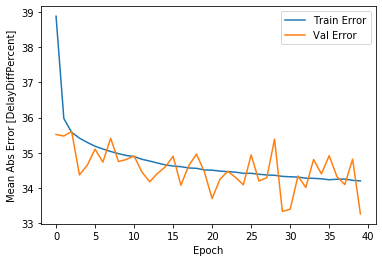

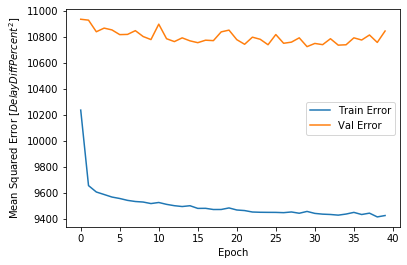

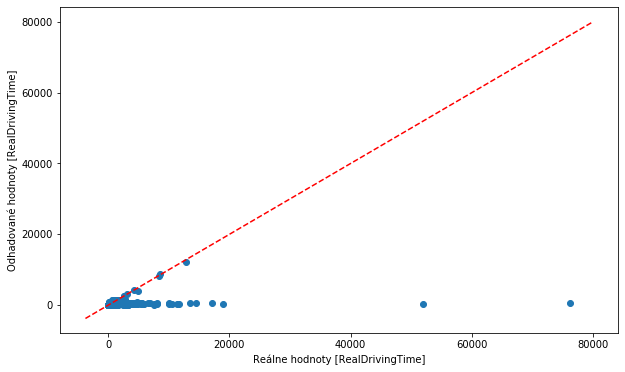

Najväčšia chyba:875.1009521484375
Najväčšia chyba v zápornom smere:-75593.1640625
% približne správnych odhadov: 0.9589075227599425


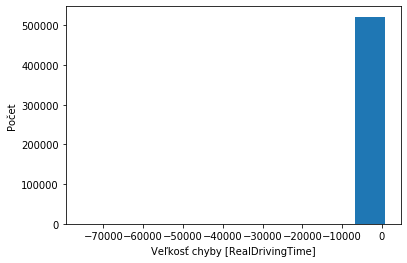

In [161]:
CreateAndFitModelLocations("FILTER2", 0.001, 120, "FILTER2ModelLocations", test5FILTER2)

### FILTER3

-----------------------------FILTER3---------------------------------
Veľkosť trénovacej množniy: (1954626, 44)
Veľkosť testovacej množniy: (488656, 44)

....................
....................
....................

MemoryError: Unable to allocate 702. MiB for an array with shape (37, 2485460) and data type float64

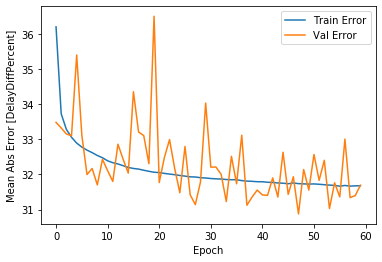

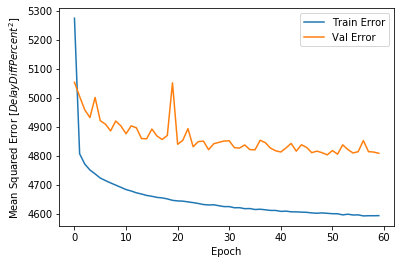

In [180]:
CreateAndFitModelLocations("FILTER3", 0.001, 120, "FILTER3ModelLocations", test5FILTER3)

In [182]:
testModel = load_model("FILTER3ModelLocations.h5")

eval_Model("BASE", testModel, test5FILTER3)
eval_Model("FILTER1", testModel, test5FILTER3)
eval_Model("FILTER2", testModel, test5FILTER3)
eval_Model("FILTER3", testModel, test5FILTER3)

------Presnosť na BASE dátach-------- 
Testing set Loss : 1638049.18 RealDrivingTime
Testing set Mean Abs Error: 97.83 RealDrivingTime
Testing set Mean Sqrt Error: 1638051.50 RealDrivingTime
Testing set Root Mean Sqrt Error: 1279.86 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Loss : 34589.97 RealDrivingTime
Testing set Mean Abs Error: 47.78 RealDrivingTime
Testing set Mean Sqrt Error: 34589.89 RealDrivingTime
Testing set Root Mean Sqrt Error: 185.98 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Loss : 32878.72 RealDrivingTime
Testing set Mean Abs Error: 47.29 RealDrivingTime
Testing set Mean Sqrt Error: 32878.74 RealDrivingTime
Testing set Root Mean Sqrt Error: 181.32 RealDrivingTime
------Presnosť na FILTER3 dátach-------- 
Testing set Loss : 4258.97 RealDrivingTime
Testing set Mean Abs Error: 31.32 RealDrivingTime
Testing set Mean Sqrt Error: 4258.96 RealDrivingTime
Testing set Root Mean Sqrt Error: 65.26 RealDrivingTime


## Vyhodnotenie

### BASE 

#### ------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 44.65 RealDrivingTime [-12,91]
- Testing set Mean Sqrt Error: 249243.69 RealDrivingTime [-141 808‬]
- Testing set Root Mean Sqrt Error: 499.24 RealDrivingTime [-126‬]



### FILTER1

------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 101.38 RealDrivingTime
- Testing set Mean Sqrt Error: 1671351.00 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1292.81 RealDrivingTime

#### ------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 34.43 RealDrivingTime [-1,47]
- Testing set Mean Sqrt Error: 24282.11 RealDrivingTime [-210]
- Testing set Root Mean Sqrt Error: 155.83 RealDrivingTime [-0,67]


### FILTER2

------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 99.20 RealDrivingTime
- Testing set Mean Sqrt Error: 1660205.12 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1288.49 RealDrivingTime

------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 34.80 RealDrivingTime
- Testing set Mean Sqrt Error: 24336.71 RealDrivingTime
- Testing set Root Mean Sqrt Error: 156.00 RealDrivingTime

#### ------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 33.69 RealDrivingTime [-6,37‬]
- Testing set Mean Sqrt Error: 24736.40 RealDrivingTime [-1 495‬]
- Testing set Root Mean Sqrt Error: 157.28 RealDrivingTime [-4‬]

### FILTER3

------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 97.83 RealDrivingTime
- Testing set Mean Sqrt Error: 1638051.50 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1279.86 RealDrivingTime

------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 47.78 RealDrivingTime
- Testing set Mean Sqrt Error: 34589.89 RealDrivingTime
- Testing set Root Mean Sqrt Error: 185.98 RealDrivingTime

------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 47.29 RealDrivingTime
- Testing set Mean Sqrt Error: 32878.74 RealDrivingTime
- Testing set Root Mean Sqrt Error: 181.32 RealDrivingTime

#### ------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 31.32 RealDrivingTime [-2,08]
- Testing set Mean Sqrt Error: 4258.96 RealDrivingTime [-136]
- Testing set Root Mean Sqrt Error: 65.26 RealDrivingTime [-1,03]

Pridanie lokálít výrazne pomohlo presnosti modelu. Priamo zlepšilo všetky sledované metriky a hlavne najdôležitejšiu MSE. Ďalej teda využijem tento filter a pokúsim sa nájsť vhodnú kombináciu parametrov, ktoré ma privedú k čo najpresnejšiemu modelu.

# Kombinácia Filtrov DayTime a Locations 
ich kombináciou budeme dúfať vo vzájomné zlepšienie presnosti

In [42]:
DTLOCBASE = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDeparture',
                   'Rano','Obed','Vecer','Noc'] 

label = 'RealDrivingTime'

DTLOCFILTER1 = DTLOCBASE.copy()
DTLOCFILTER2 = DTLOCBASE.copy()
DTLOCFILTER3 = DTLOCBASE.copy()

Odstránenie všetkých príznakov, ktoré sú príliš málo početné. Keď je príznak málo početný, tak ho nedokážeme normovať.

In [43]:
# BASE 
for stop in DFBASE.FromName.unique():
    check = DFBASE[(DFBASE['FromName'] == stop)].index
    if(len(check) < 5):
        DFBASE.drop(check,inplace=True)
    
for stop in DFBASE.ToName.unique():
    check = DFBASE[(DFBASE['ToName'] == stop)].index
    if(len(check) < 5):
        DFBASE.drop(check,inplace=True)

# FILTER1
for stop in DFFILTER1.FromName.unique():
    check = DFFILTER1[(DFFILTER1['FromName'] == stop)].index
    if(len(check) < 5):
        DFFILTER1.drop(check,inplace=True)
    
for stop in DFFILTER1.ToName.unique():
    check = DFFILTER1[(DFFILTER1['ToName'] == stop)].index
    if(len(check) < 5):
        DFFILTER1.drop(check,inplace=True)
        
# FILTER2
for stop in DFFILTER2.FromName.unique():
    check = DFFILTER2[(DFFILTER2['FromName'] == stop)].index
    if(len(check) < 5):
        DFFILTER2.drop(check,inplace=True)
    
for stop in DFFILTER2.ToName.unique():
    check = DFFILTER2[(DFFILTER2['ToName'] == stop)].index
    if(len(check) < 5):
        DFFILTER2.drop(check,inplace=True)
        
# FILTER3
for stop in DFFILTER3.FromName.unique():
    check = DFFILTER3[(DFFILTER3['FromName'] == stop)].index
    if(len(check) < 5):
        DFFILTER3.drop(check,inplace=True)
    
for stop in DFFILTER3.ToName.unique():
    check = DFFILTER3[(DFFILTER3['ToName'] == stop)].index
    if(len(check) < 5):
        DFFILTER3.drop(check,inplace=True)

Keďže nie všetky filtre obsahujú všetky zastávky, tak pre každý filter vytvoríme jeho vlastný zoznam atribútov.
Toto však má ale aj výrazný dopad na to, že jednotlivé filtre môžem porovnávať z hľadiska presnosti iba s rezervou. 
Pretože model dostane aj dáta z iných filtrov, ktoré obsahujú príznaky, na ktorých model netrénoval.

In [44]:
# BASE
type = DFBASE['FromName']
for zastavka in DFBASE.FromName.unique():
    DTLOCBASE.append("From" + zastavka)
    DFBASE["From" + zastavka] = (type == zastavka)*1.0
type = DFBASE['ToName']
for zastavka in DFBASE.ToName.unique():
    DTLOCBASE.append("To" + zastavka)
    DFBASE["To" + zastavka] = (type == zastavka)*1.0
    
DTLOCBASE.append("RealDrivingTime")

# FILTER1
type = DFFILTER1['FromName']
for zastavka in DFFILTER1.FromName.unique():
    DTLOCFILTER1.append("From" + zastavka)
    DFFILTER1["From" + zastavka] = (type == zastavka)*1.0
type = DFFILTER1['ToName']
for zastavka in DFFILTER1.ToName.unique():
    DTLOCFILTER1.append("To" + zastavka)
    DFFILTER1["To" + zastavka] = (type == zastavka)*1.0
    
DTLOCFILTER1.append("RealDrivingTime")

#FILTER2
type = DFFILTER2['FromName']
for zastavka in DFFILTER2.FromName.unique():
    DTLOCFILTER2.append("From" + zastavka)
    DFFILTER2["From" + zastavka] = (type == zastavka)*1.0
type = DFFILTER2['ToName']
for zastavka in DFFILTER2.ToName.unique():
    DTLOCFILTER2.append("To" + zastavka)
    DFFILTER2["To" + zastavka] = (type == zastavka)*1.0
    
DTLOCFILTER2.append("RealDrivingTime")

# FILTER3
type = DFFILTER3['FromName']
for zastavka in DFFILTER3.FromName.unique():
    DTLOCFILTER3.append("From" + zastavka)
    DFFILTER3["From" + zastavka] = (type == zastavka)*1.0
type = DFFILTER3['ToName']
for zastavka in DFFILTER3.ToName.unique():
    DTLOCFILTER3.append("To" + zastavka)
    DFFILTER3["To" + zastavka] = (type == zastavka)*1.0
    
DTLOCFILTER3.append("RealDrivingTime")

In [46]:
type = DFBASE['DayTime']
for daytime in daytime_types:
    DFBASE[daytime] = (type == daytime)*1.0
    
type = DFFILTER1['DayTime']
for daytime in daytime_types:
    DFFILTER1[daytime] = (type == daytime)*1.0
    
type = DFFILTER2['DayTime']
for daytime in daytime_types:
    DFFILTER2[daytime] = (type == daytime)*1.0
    
type = DFFILTER3['DayTime']
for daytime in daytime_types:
    DFFILTER3[daytime] = (type == daytime)*1.0

-----------------------------BASE---------------------------------
Veľkosť trénovacej množniy: (2485460, 55)
Veľkosť testovacej množniy: (621365, 55)

....................
....................
....................
...------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 47.24 RealDrivingTime
Testing set Mean Sqrt Error: 255245.27 RealDrivingTime
Testing set Root Mean Sqrt Error: 505.22 RealDrivingTime


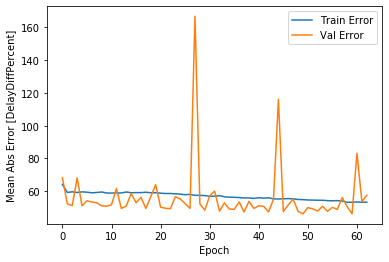

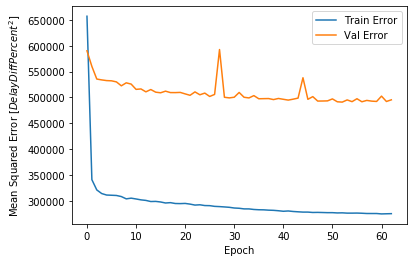

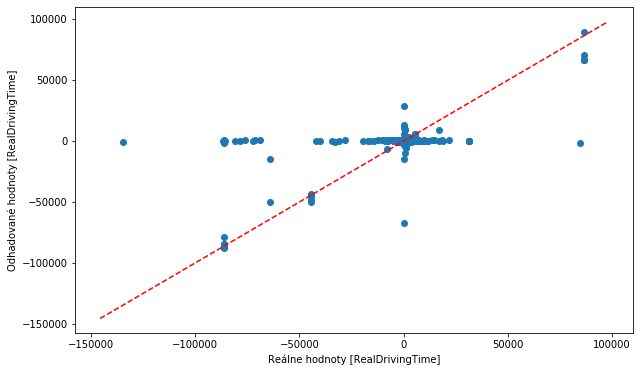

Najväčšia chyba:134103.953125
Najväčšia chyba v zápornom smere:-85966.1484375
% približne správnych odhadov: 0.9393013768075125


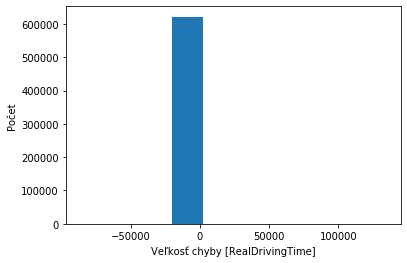

In [47]:
CreateAndFitModelLocations("BASE", 0.001, 120, "BASEModelDTLOC", DTLOCBASE) 

-----------------------------FILTER1---------------------------------
Veľkosť trénovacej množniy: (2087046, 54)
Veľkosť testovacej množniy: (521762, 54)

....................
.....------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 99.45 RealDrivingTime
Testing set Mean Sqrt Error: 1651114.62 RealDrivingTime
Testing set Root Mean Sqrt Error: 1284.96 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 33.69 RealDrivingTime
Testing set Mean Sqrt Error: 24330.54 RealDrivingTime
Testing set Root Mean Sqrt Error: 155.98 RealDrivingTime


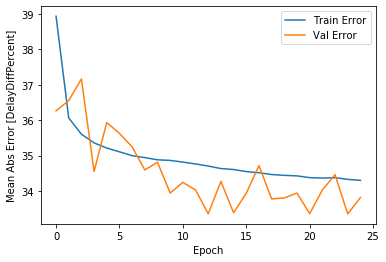

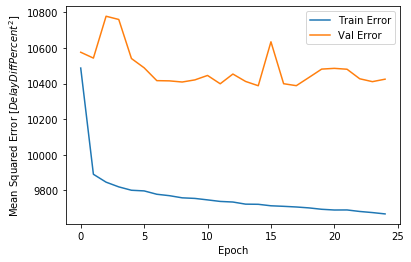

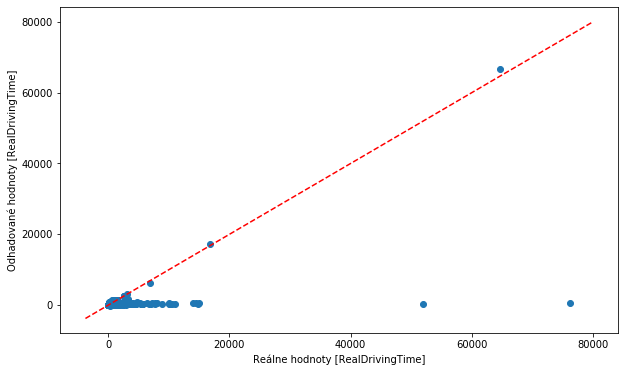

Najväčšia chyba:2021.828125
Najväčšia chyba v zápornom smere:-75619.765625
% približne správnych odhadov: 0.958392907110905


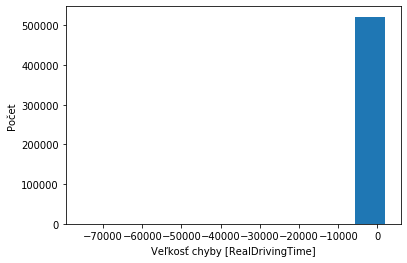

In [48]:
CreateAndFitModelLocations("FILTER1", 0.001, 120, "FILTER1ModelDTLOC", DTLOCFILTER1) 

-----------------------------FILTER2---------------------------------
Veľkosť trénovacej množniy: (2087002, 54)
Veľkosť testovacej množniy: (521750, 54)

....................
..........------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 99.39 RealDrivingTime
Testing set Mean Sqrt Error: 1663787.25 RealDrivingTime
Testing set Root Mean Sqrt Error: 1289.88 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 35.37 RealDrivingTime
Testing set Mean Sqrt Error: 24359.82 RealDrivingTime
Testing set Root Mean Sqrt Error: 156.08 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 34.47 RealDrivingTime
Testing set Mean Sqrt Error: 24715.10 RealDrivingTime
Testing set Root Mean Sqrt Error: 157.21 RealDrivingTime


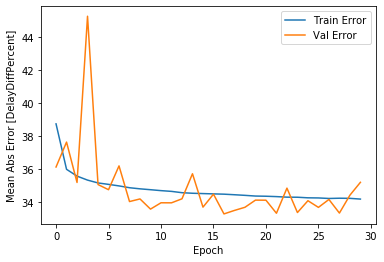

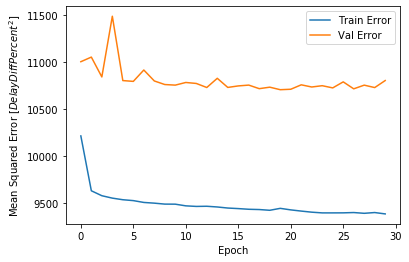

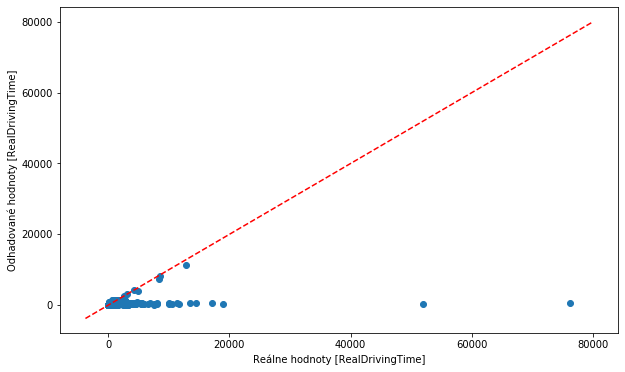

Najväčšia chyba:817.412353515625
Najväčšia chyba v zápornom smere:-75612.09375
% približne správnych odhadov: 0.9599635840919981


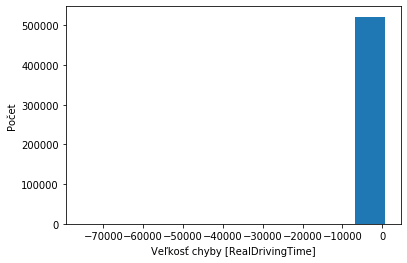

In [49]:
CreateAndFitModelLocations("FILTER2", 0.001, 120, "FILTER2ModelDTLOC", DTLOCFILTER2) 

-----------------------------FILTER3---------------------------------
Veľkosť trénovacej množniy: (1954766, 51)
Veľkosť testovacej množniy: (488691, 51)

....................
....................
....................
....................
....................
....................------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 104.16 RealDrivingTime
Testing set Mean Sqrt Error: 1610430.62 RealDrivingTime
Testing set Root Mean Sqrt Error: 1269.03 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 55.42 RealDrivingTime
Testing set Mean Sqrt Error: 48186.06 RealDrivingTime
Testing set Root Mean Sqrt Error: 219.51 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 55.06 RealDrivingTime
Testing set Mean Sqrt Error: 42565.75 RealDrivingTime
Testing set Root Mean Sqrt Error: 206.31 RealDrivingTime
------Presnosť na FILTER3 dátach-------- 
Testing set Mean Abs Error: 30.79 RealDrivingTime
Testing set Mean Sq

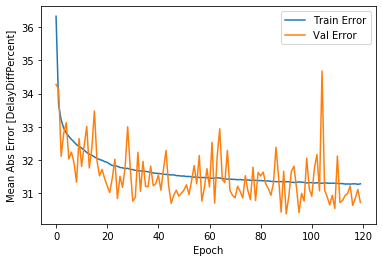

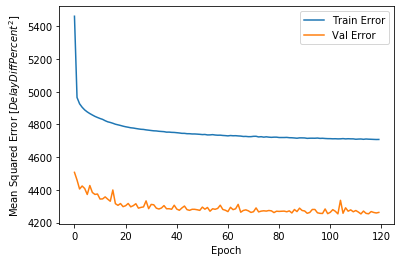

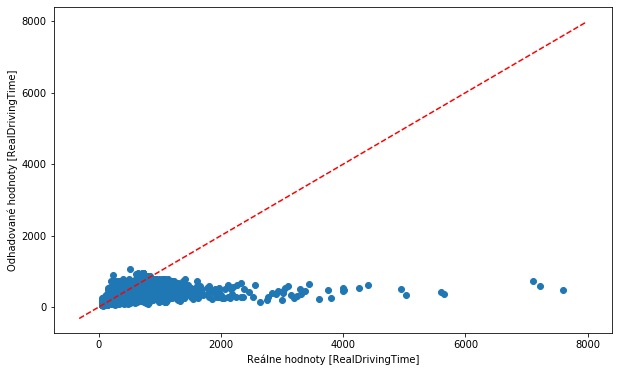

Najväčšia chyba:650.2119750976562
Najväčšia chyba v zápornom smere:-7120.53271484375
% približne správnych odhadov: 0.9643762623007176


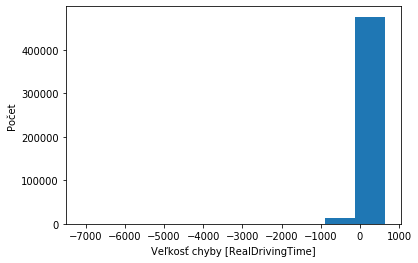

In [50]:
CreateAndFitModelLocations("FILTER3", 0.001, 120, "FILTER3ModelDTLOC", DTLOCFILTER3) 

## Vyhodnotenie - Kombinácia Locations a DayTime

Vidím, že táto kombinácia nepriniesla dodatočnú presnosť ktorú model potrebuje.

### BASE 

#### ------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 47.24 RealDrivingTime [2,59‬]
- Testing set Mean Sqrt Error: 255245.27 RealDrivingTime [6 002‬]
- Testing set Root Mean Sqrt Error: 505.22 RealDrivingTime [6]

### FILTER1

------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 99.45 RealDrivingTime
- Testing set Mean Sqrt Error: 1651114.62 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1284.96 RealDrivingTime

#### ------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 33.69 RealDrivingTime [-0,74]
- Testing set Mean Sqrt Error: 24330.54 RealDrivingTime [+48]
- Testing set Root Mean Sqrt Error: 155.98 RealDrivingTime [+0,15]

### FILTER2

------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 99.39 RealDrivingTime
- Testing set Mean Sqrt Error: 1663787.25 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1289.88 RealDrivingTime

------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 35.37 RealDrivingTime
- Testing set Mean Sqrt Error: 24359.82 RealDrivingTime
- Testing set Root Mean Sqrt Error: 156.08 RealDrivingTime

#### ------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 34.47 RealDrivingTime [+0,78]
- Testing set Mean Sqrt Error: 24715.10 RealDrivingTime [-21]
- Testing set Root Mean Sqrt Error: 157.21 RealDrivingTime [-0,07]

### FILTER3

------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 104.16 RealDrivingTime
- Testing set Mean Sqrt Error: 1610430.62 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1269.03 RealDrivingTime

------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 55.42 RealDrivingTime
- Testing set Mean Sqrt Error: 48186.06 RealDrivingTime
- Testing set Root Mean Sqrt Error: 219.51 RealDrivingTime

------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 55.06 RealDrivingTime
- Testing set Mean Sqrt Error: 42565.75 RealDrivingTime
- Testing set Root Mean Sqrt Error: 206.31 RealDrivingTime

#### ------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 30.79 RealDrivingTime [-0,53‬]
- Testing set Mean Sqrt Error: 4190.26 RealDrivingTime [-68‬]
- Testing set Root Mean Sqrt Error: 64.73 RealDrivingTime [-0,53]



# Kombinácia Locations a Seasons

In [52]:
SELOCBASE = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDeparture',
            'Jar','Leto','Jesen','Zima'] 

label = 'RealDrivingTime'

SELOCFILTER1 = SELOCBASE.copy()
SELOCFILTER2 = SELOCBASE.copy()
SELOCFILTER3 = SELOCBASE.copy()

Odstránenie všetkých príznakov, ktoré sú príliš málo početné. Keď je príznak málo početný, tak ho nedokážeme normovať.

In [53]:
# BASE 
for stop in DFBASE.FromName.unique():
    check = DFBASE[(DFBASE['FromName'] == stop)].index
    if(len(check) < 5):
        DFBASE.drop(check,inplace=True)
    
for stop in DFBASE.ToName.unique():
    check = DFBASE[(DFBASE['ToName'] == stop)].index
    if(len(check) < 5):
        DFBASE.drop(check,inplace=True)

# FILTER1
for stop in DFFILTER1.FromName.unique():
    check = DFFILTER1[(DFFILTER1['FromName'] == stop)].index
    if(len(check) < 5):
        DFFILTER1.drop(check,inplace=True)
    
for stop in DFFILTER1.ToName.unique():
    check = DFFILTER1[(DFFILTER1['ToName'] == stop)].index
    if(len(check) < 5):
        DFFILTER1.drop(check,inplace=True)
        
# FILTER2
for stop in DFFILTER2.FromName.unique():
    check = DFFILTER2[(DFFILTER2['FromName'] == stop)].index
    if(len(check) < 5):
        DFFILTER2.drop(check,inplace=True)
    
for stop in DFFILTER2.ToName.unique():
    check = DFFILTER2[(DFFILTER2['ToName'] == stop)].index
    if(len(check) < 5):
        DFFILTER2.drop(check,inplace=True)
        
# FILTER3
for stop in DFFILTER3.FromName.unique():
    check = DFFILTER3[(DFFILTER3['FromName'] == stop)].index
    if(len(check) < 5):
        DFFILTER3.drop(check,inplace=True)
    
for stop in DFFILTER3.ToName.unique():
    check = DFFILTER3[(DFFILTER3['ToName'] == stop)].index
    if(len(check) < 5):
        DFFILTER3.drop(check,inplace=True)

Keďže nie všetky filtre obsahujú všetky zastávky, tak pre každý filter vytvoríme jeho vlastný zoznam atribútov.
Toto však má ale aj výrazný dopad na to, že jednotlivé filtre môžem porovnávať z hľadiska presnosti iba s rezervou. 
Pretože model dostane aj dáta z iných filtrov, ktoré obsahujú príznaky, na ktorých model netrénoval.

In [54]:
# BASE
type = DFBASE['FromName']
for zastavka in DFBASE.FromName.unique():
    SELOCBASE.append("From" + zastavka)
    DFBASE["From" + zastavka] = (type == zastavka)*1.0
type = DFBASE['ToName']
for zastavka in DFBASE.ToName.unique():
    SELOCBASE.append("To" + zastavka)
    DFBASE["To" + zastavka] = (type == zastavka)*1.0
    
SELOCBASE.append("RealDrivingTime")

# FILTER1
type = DFFILTER1['FromName']
for zastavka in DFFILTER1.FromName.unique():
    SELOCFILTER1.append("From" + zastavka)
    DFFILTER1["From" + zastavka] = (type == zastavka)*1.0
type = DFFILTER1['ToName']
for zastavka in DFFILTER1.ToName.unique():
    SELOCFILTER1.append("To" + zastavka)
    DFFILTER1["To" + zastavka] = (type == zastavka)*1.0
    
SELOCFILTER1.append("RealDrivingTime")

#FILTER2
type = DFFILTER2['FromName']
for zastavka in DFFILTER2.FromName.unique():
    SELOCFILTER2.append("From" + zastavka)
    DFFILTER2["From" + zastavka] = (type == zastavka)*1.0
type = DFFILTER2['ToName']
for zastavka in DFFILTER2.ToName.unique():
    SELOCFILTER2.append("To" + zastavka)
    DFFILTER2["To" + zastavka] = (type == zastavka)*1.0
    
SELOCFILTER2.append("RealDrivingTime")

# FILTER3
type = DFFILTER3['FromName']
for zastavka in DFFILTER3.FromName.unique():
    SELOCFILTER3.append("From" + zastavka)
    DFFILTER3["From" + zastavka] = (type == zastavka)*1.0
type = DFFILTER3['ToName']
for zastavka in DFFILTER3.ToName.unique():
    SELOCFILTER3.append("To" + zastavka)
    DFFILTER3["To" + zastavka] = (type == zastavka)*1.0
    
SELOCFILTER3.append("RealDrivingTime")

In [55]:
season = DFBASE['Season']
for seas in season_types:
    DFBASE[seas] = (season == seas)*1.0
    
season = DFFILTER1['Season']
for seas in season_types:
    DFFILTER1[seas] = (season == seas)*1.0
    
season = DFFILTER2['Season']
for seas in season_types:
    DFFILTER2[seas] = (season == seas)*1.0
    
season = DFFILTER3['Season']
for seas in season_types:
    DFFILTER3[seas] = (season == seas)*1.0

-----------------------------BASE---------------------------------
Veľkosť trénovacej množniy: (2485460, 55)
Veľkosť testovacej množniy: (621365, 55)

....................
....................
..................------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 47.98 RealDrivingTime
Testing set Mean Sqrt Error: 247598.25 RealDrivingTime
Testing set Root Mean Sqrt Error: 497.59 RealDrivingTime


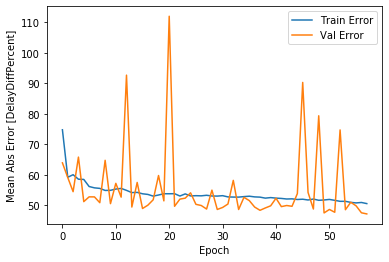

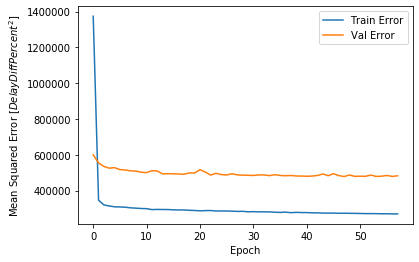

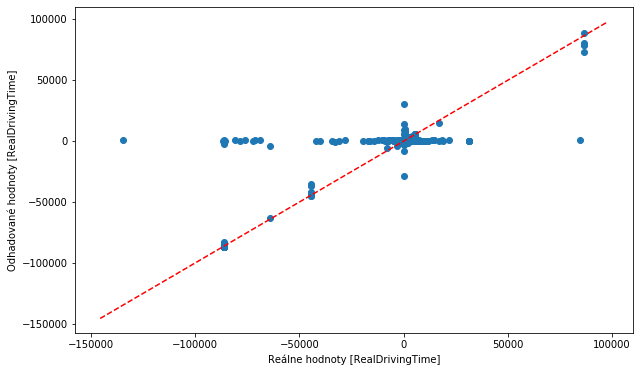

Najväčšia chyba:135046.828125
Najväčšia chyba v zápornom smere:-84135.171875
% približne správnych odhadov: 0.9395025468122601


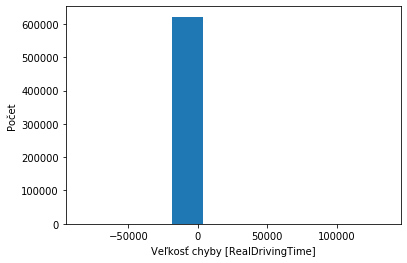

In [58]:
CreateAndFitModelLocations("BASE", 0.001, 120, "BASEModelSELOC", SELOCBASE) 

-----------------------------FILTER1---------------------------------
Veľkosť trénovacej množniy: (2087046, 54)
Veľkosť testovacej množniy: (521762, 54)

....................
....------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 105.45 RealDrivingTime
Testing set Mean Sqrt Error: 1576803.12 RealDrivingTime
Testing set Root Mean Sqrt Error: 1255.71 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 34.41 RealDrivingTime
Testing set Mean Sqrt Error: 24325.76 RealDrivingTime
Testing set Root Mean Sqrt Error: 155.97 RealDrivingTime


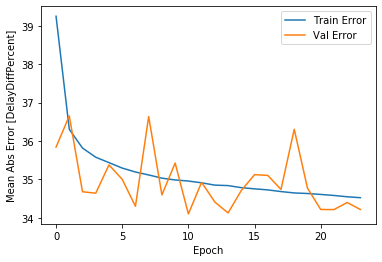

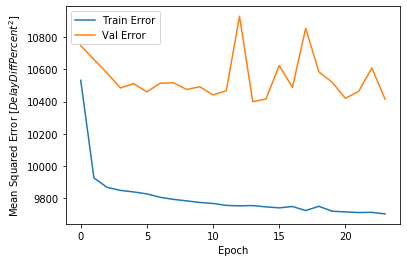

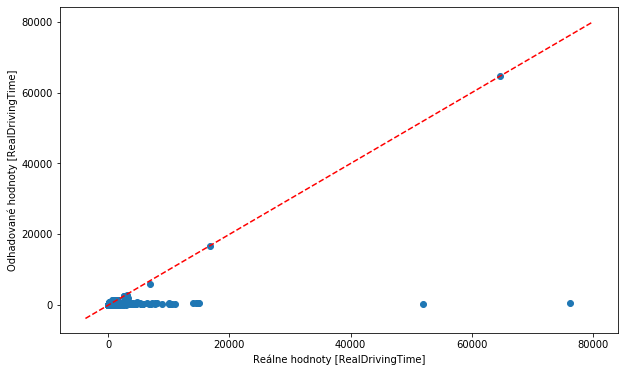

Najväčšia chyba:759.4285888671875
Najväčšia chyba v zápornom smere:-75589.7265625
% približne správnych odhadov: 0.9587474749023501


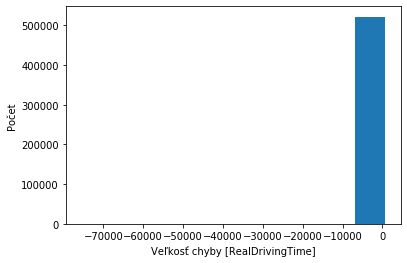

In [59]:
CreateAndFitModelLocations("FILTER1", 0.001, 120, "FILTER1ModelSELOC", SELOCFILTER1) 

-----------------------------FILTER2---------------------------------
Veľkosť trénovacej množniy: (2087002, 54)
Veľkosť testovacej množniy: (521750, 54)

....................
....................
.........------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 97.86 RealDrivingTime
Testing set Mean Sqrt Error: 1636531.62 RealDrivingTime
Testing set Root Mean Sqrt Error: 1279.27 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 34.92 RealDrivingTime
Testing set Mean Sqrt Error: 24359.94 RealDrivingTime
Testing set Root Mean Sqrt Error: 156.08 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 34.16 RealDrivingTime
Testing set Mean Sqrt Error: 24720.53 RealDrivingTime
Testing set Root Mean Sqrt Error: 157.23 RealDrivingTime


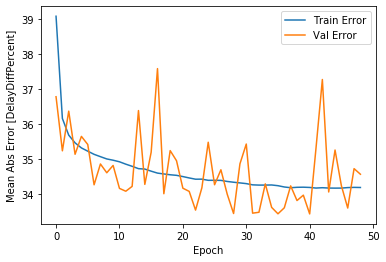

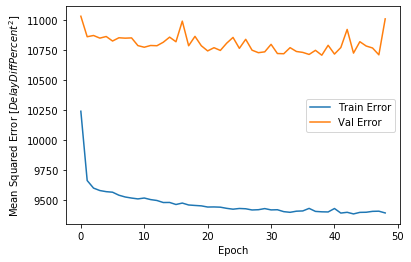

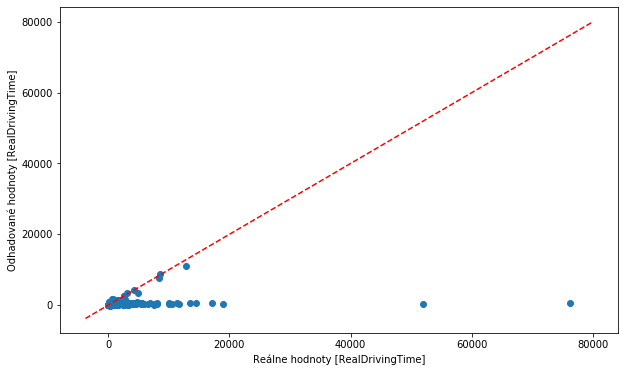

Najväčšia chyba:1023.8807373046875
Najväčšia chyba v zápornom smere:-75602.6015625
% približne správnych odhadov: 0.9591950167704839


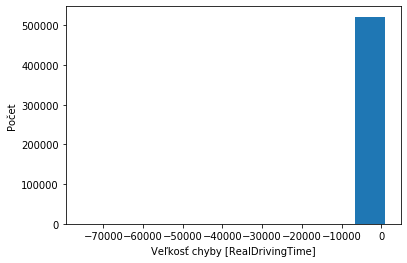

In [60]:
CreateAndFitModelLocations("FILTER2", 0.001, 120, "FILTER2ModelSELOC", SELOCFILTER2) 

-----------------------------FILTER3---------------------------------
Veľkosť trénovacej množniy: (1954766, 51)
Veľkosť testovacej množniy: (488691, 51)

....................
....................
....................
...............------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 102.00 RealDrivingTime
Testing set Mean Sqrt Error: 1613984.62 RealDrivingTime
Testing set Root Mean Sqrt Error: 1270.43 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 50.83 RealDrivingTime
Testing set Mean Sqrt Error: 39147.72 RealDrivingTime
Testing set Root Mean Sqrt Error: 197.86 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 50.63 RealDrivingTime
Testing set Mean Sqrt Error: 38768.57 RealDrivingTime
Testing set Root Mean Sqrt Error: 196.90 RealDrivingTime
------Presnosť na FILTER3 dátach-------- 
Testing set Mean Abs Error: 30.97 RealDrivingTime
Testing set Mean Sqrt Error: 4213.16 RealDrivingTime
Testing set R

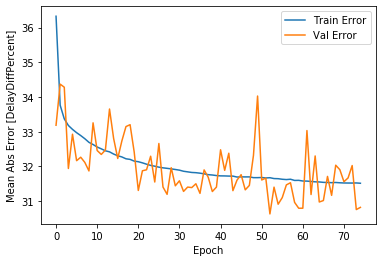

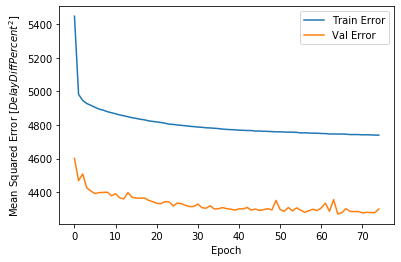

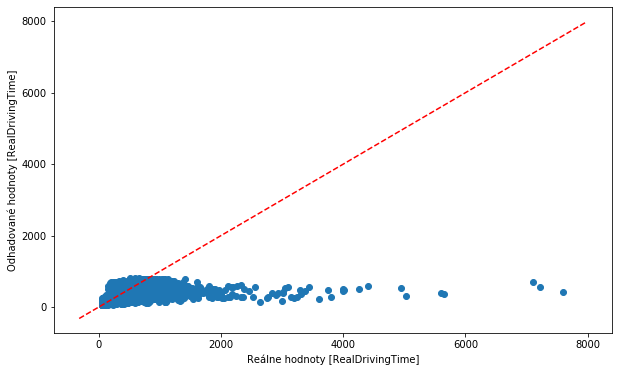

Najväčšia chyba:504.2584228515625
Najväčšia chyba v zápornom smere:-7169.650390625
% približne správnych odhadov: 0.9648387222191528


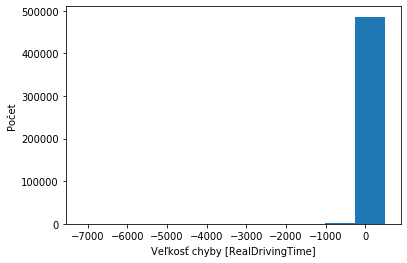

In [61]:
CreateAndFitModelLocations("FILTER3", 0.001, 120, "FILTER3ModelSELOC", SELOCFILTER3) 

# Vyhodnotenie - Kombinácia Seasons a Locations

### BASE 

#### ------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 47.98 RealDrivingTime
- Testing set Mean Sqrt Error: 247598.25 RealDrivingTime
- Testing set Root Mean Sqrt Error: 497.59 RealDrivingTime

### FILTER1

------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 105.45 RealDrivingTime
- Testing set Mean Sqrt Error: 1576803.12 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1255.71 RealDrivingTime

#### ------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 34.41 RealDrivingTime
- Testing set Mean Sqrt Error: 24325.76 RealDrivingTime
- Testing set Root Mean Sqrt Error: 155.97 RealDrivingTime

### FILTER2

------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 97.86 RealDrivingTime
- Testing set Mean Sqrt Error: 1636531.62 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1279.27 RealDrivingTime

------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 34.92 RealDrivingTime
- Testing set Mean Sqrt Error: 24359.94 RealDrivingTime
- Testing set Root Mean Sqrt Error: 156.08 RealDrivingTime

#### ------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 34.16 RealDrivingTime
- Testing set Mean Sqrt Error: 24720.53 RealDrivingTime
- Testing set Root Mean Sqrt Error: 157.23 RealDrivingTime

### FILTER3

------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 102.00 RealDrivingTime
- Testing set Mean Sqrt Error: 1613984.62 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1270.43 RealDrivingTime

------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 50.83 RealDrivingTime
- Testing set Mean Sqrt Error: 39147.72 RealDrivingTime
- Testing set Root Mean Sqrt Error: 197.86 RealDrivingTime

------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 50.63 RealDrivingTime
- Testing set Mean Sqrt Error: 38768.57 RealDrivingTime
- Testing set Root Mean Sqrt Error: 196.90 RealDrivingTime

#### ------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 30.97 RealDrivingTime
- Testing set Mean Sqrt Error: 4213.16 RealDrivingTime
- Testing set Root Mean Sqrt Error: 64.91 RealDrivingTime

# Kombinácia  TrainTypes  a Locations = TTLOC

In [43]:
TTLOCBASE = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDeparture']

label = 'RealDrivingTime'

TTLOCFILTER1 = TTLOCBASE.copy()
TTLOCFILTER2 = TTLOCBASE.copy()
TTLOCFILTER3 = TTLOCBASE.copy()

Odstránenie všetkých príznakov, ktoré sú príliš málo početné. Keď je príznak málo početný, tak ho nedokážeme normovať.

Keďže nie všetky filtre obsahujú všetky zastávky, tak pre každý filter vytvoríme jeho vlastný zoznam atribútov.
Toto však má ale aj výrazný dopad na to, že jednotlivé filtre môžem porovnávať z hľadiska presnosti iba s rezervou. 
Pretože model dostane aj dáta z iných filtrov, ktoré obsahujú príznaky, na ktorých model netrénoval.

In [44]:
# BASE
type = DFBASE['FromName']
for zastavka in DFBASE.FromName.unique():
    TTLOCBASE.append("From" + zastavka)
    DFBASE["From" + zastavka] = (type == zastavka)*1.0
    
type = DFBASE['ToName']
for zastavka in DFBASE.ToName.unique():
    TTLOCBASE.append("To" + zastavka)
    DFBASE["To" + zastavka] = (type == zastavka)*1.0
    
type = DFBASE['TrainType']
for typ in DFBASE.TrainType.unique():
    TTLOCBASE.append(typ)
    DFBASE[typ] = (type == typ)*1.0
    


# FILTER1
type = DFFILTER1['FromName']
for zastavka in DFFILTER1.FromName.unique():
    TTLOCFILTER1.append("From" + zastavka)
    DFFILTER1["From" + zastavka] = (type == zastavka)*1.0
    
type = DFFILTER1['ToName']
for zastavka in DFFILTER1.ToName.unique():
    TTLOCFILTER1.append("To" + zastavka)
    DFFILTER1["To" + zastavka] = (type == zastavka)*1.0

type = DFFILTER1['TrainType']
for typ in DFFILTER1.TrainType.unique():
    TTLOCFILTER1.append(typ)
    DFFILTER1[typ] = (type == typ)*1.0
    


#FILTER2
type = DFFILTER2['FromName']
for zastavka in DFFILTER2.FromName.unique():
    TTLOCFILTER2.append("From" + zastavka)
    DFFILTER2["From" + zastavka] = (type == zastavka)*1.0
    
type = DFFILTER2['ToName']
for zastavka in DFFILTER2.ToName.unique():
    TTLOCFILTER2.append("To" + zastavka)
    DFFILTER2["To" + zastavka] = (type == zastavka)*1.0

type = DFFILTER2['TrainType']
for typ in DFFILTER2.TrainType.unique():
    TTLOCFILTER2.append(typ)
    DFFILTER2[typ] = (type == typ)*1.0
    


# FILTER3
type = DFFILTER3['FromName']
for zastavka in DFFILTER3.FromName.unique():
    TTLOCFILTER3.append("From" + zastavka)
    DFFILTER3["From" + zastavka] = (type == zastavka)*1.0
    
type = DFFILTER3['ToName']
for zastavka in DFFILTER3.ToName.unique():
    TTLOCFILTER3.append("To" + zastavka)
    DFFILTER3["To" + zastavka] = (type == zastavka)*1.0
    
type = DFFILTER3['TrainType']
for typ in DFFILTER3.TrainType.unique():
    TTLOCFILTER3.append(typ)
    DFFILTER3[typ] = (type == typ)*1.0
    


In [45]:
TTLOCBASE.append("RealDrivingTime")
TTLOCFILTER1.append("RealDrivingTime")
TTLOCFILTER2.append("RealDrivingTime")
TTLOCFILTER3.append("RealDrivingTime")

-----------------------------BASE---------------------------------
Veľkosť trénovacej množniy: (2485460, 62)
Veľkosť testovacej množniy: (621365, 62)

....................
....................
....................
..................------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 50.55 RealDrivingTime
Testing set Mean Sqrt Error: 245074.62 RealDrivingTime
Testing set Root Mean Sqrt Error: 495.05 RealDrivingTime


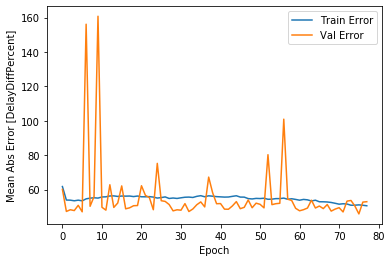

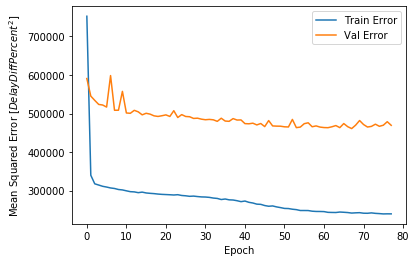

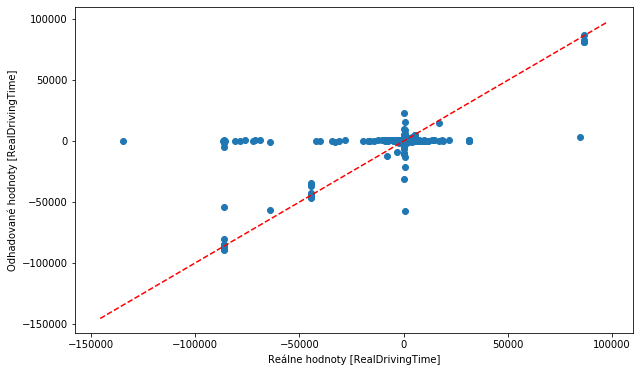

Najväčšia chyba:134731.03125
Najväčšia chyba v zápornom smere:-81490.2265625
% približne správnych odhadov: 0.919795933147184


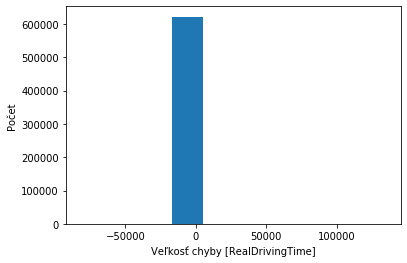

In [85]:
CreateAndFitModelLocations("BASE", 0.001, 120, "BASEModelTTLOC", TTLOCBASE) 

-----------------------------FILTER1---------------------------------
Veľkosť trénovacej množniy: (2087046, 61)
Veľkosť testovacej množniy: (521762, 61)

....................
.........------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 87.06 RealDrivingTime 
Testing set Mean Sqrt Error: 1715508.00 RealDrivingTime 
Testing set Root Mean Sqrt Error: 1309.77 RealDrivingTime 


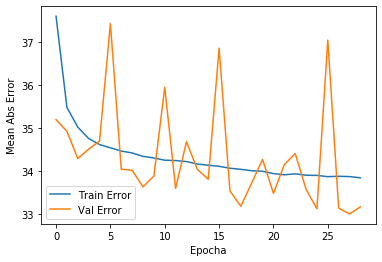

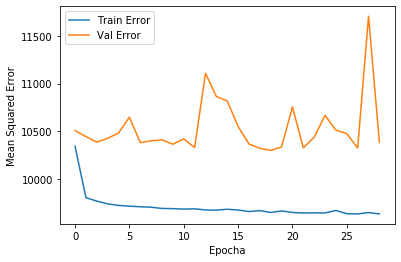

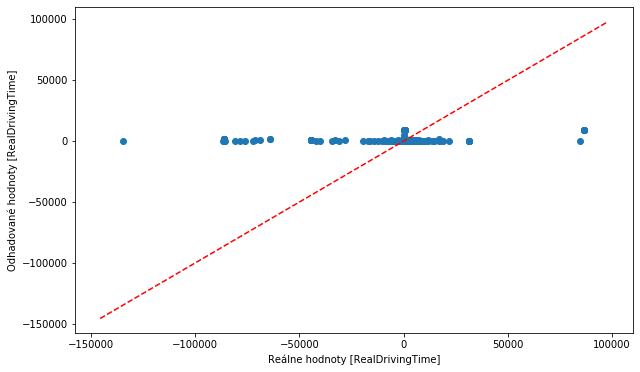

Najväčšia chyba:134844.84375
Najväčšia chyba v zápornom smere:-84610.40625
% približne správnych odhadov: 0.850126737102991


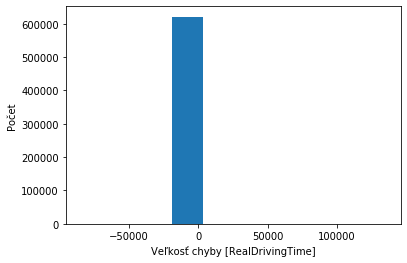

------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 34.01 RealDrivingTime 
Testing set Mean Sqrt Error: 24225.99 RealDrivingTime 
Testing set Root Mean Sqrt Error: 155.65 RealDrivingTime 


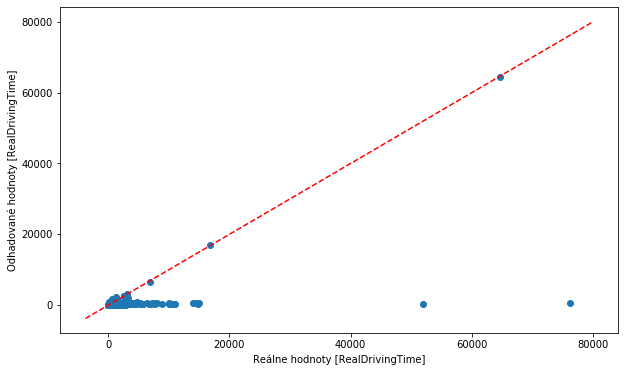

Najväčšia chyba:1080.975830078125
Najväčšia chyba v zápornom smere:-75577.375
% približne správnych odhadov: 0.9599855872984234


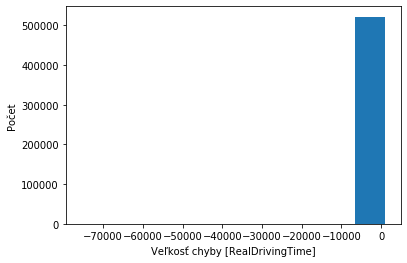

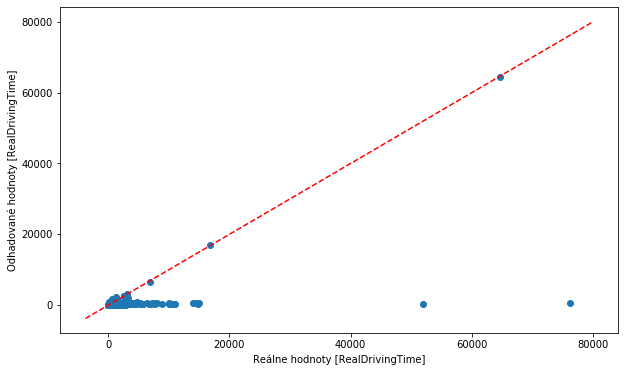

Najväčšia chyba:1080.975830078125
Najväčšia chyba v zápornom smere:-75577.375
% približne správnych odhadov: 0.9599855872984234


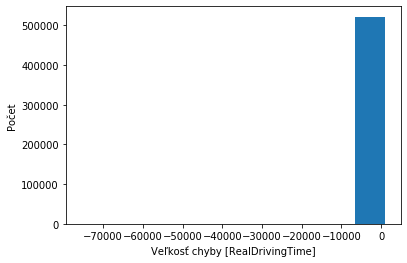

In [55]:
CreateAndFitModelLocations("FILTER1", 0.001, 120, "FILTER1ModelTTLOC", TTLOCFILTER1) 

-----------------------------FILTER1---------------------------------
Veľkosť trénovacej množniy: (2087046, 61)
Veľkosť testovacej množniy: (521762, 61)

....................
....................
....................
....................
............------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 90.02 RealDrivingTime 
Testing set Mean Sqrt Error: 1651904.75 RealDrivingTime 
Testing set Root Mean Sqrt Error: 1285.26 RealDrivingTime 


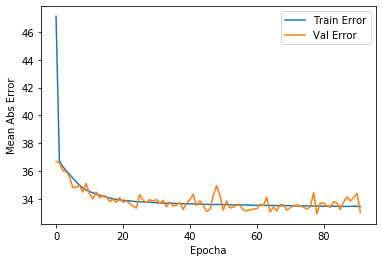

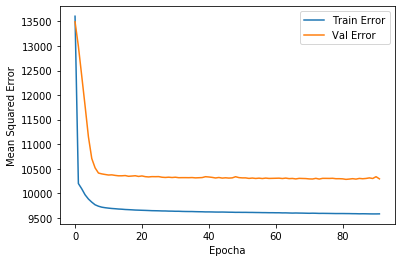

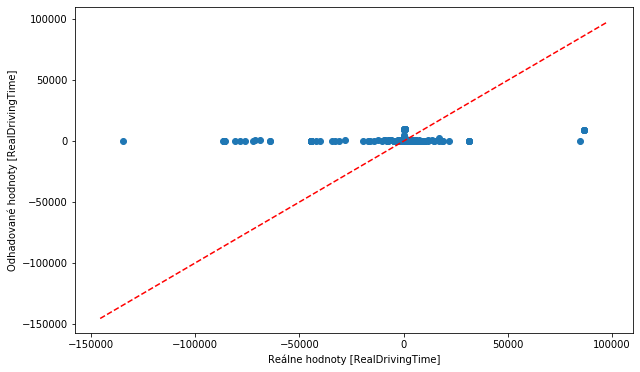

Najväčšia chyba:134823.296875
Najväčšia chyba v zápornom smere:-84649.359375
% približne správnych odhadov: 0.8391605578041892


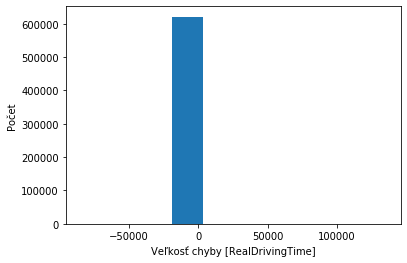

------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 33.78 RealDrivingTime 
Testing set Mean Sqrt Error: 24205.55 RealDrivingTime 
Testing set Root Mean Sqrt Error: 155.58 RealDrivingTime 


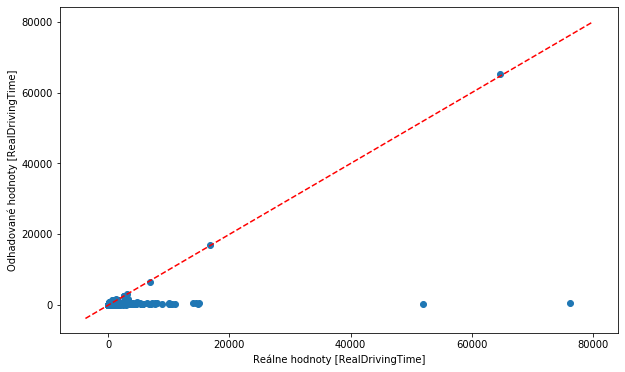

Najväčšia chyba:969.91015625
Najväčšia chyba v zápornom smere:-75589.6875
% približne správnych odhadov: 0.961141286640269


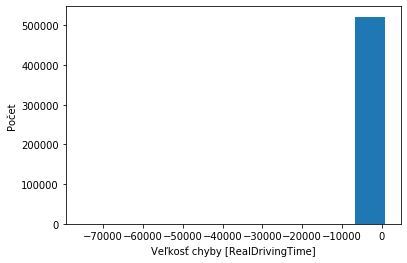

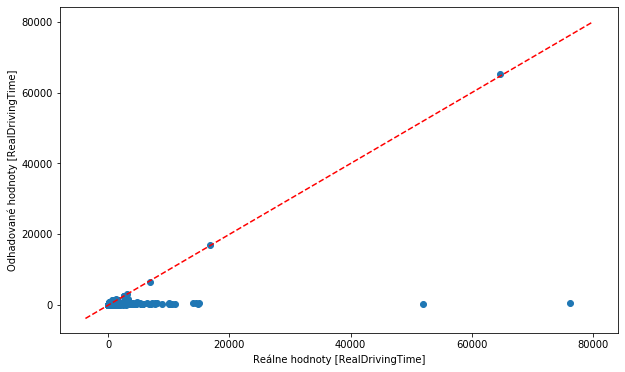

Najväčšia chyba:969.91015625
Najväčšia chyba v zápornom smere:-75589.6875
% približne správnych odhadov: 0.961141286640269


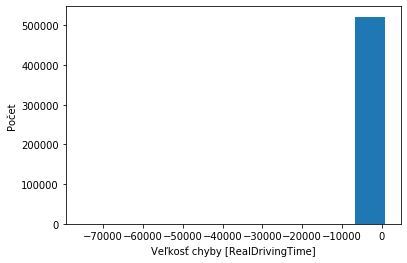

In [60]:
CreateAndFitModelLocations("FILTER1", 0.0001, 120, "FILTER1ModelTTLOCExp", TTLOCFILTER1) 

-----------------------------FILTER2---------------------------------
Veľkosť trénovacej množniy: (2087002, 61)
Veľkosť testovacej množniy: (521750, 61)

....................

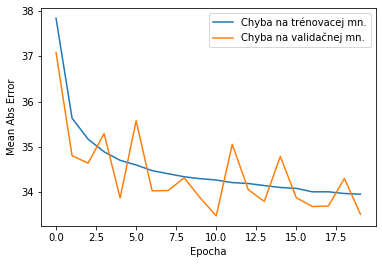

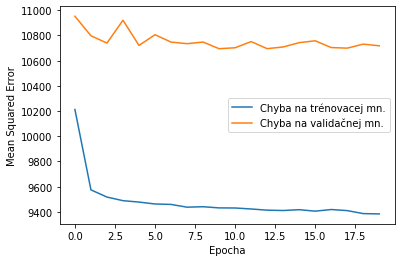

------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 87.00 RealDrivingTime 
Testing set Mean Sqrt Error: 1710548.75 RealDrivingTime 
Testing set Root Mean Sqrt Error: 1307.88 RealDrivingTime 


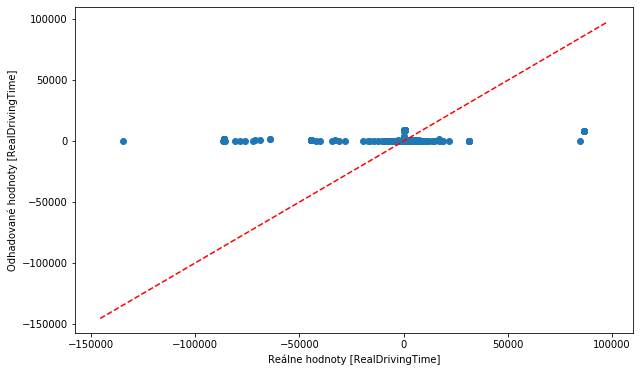

Najväčšia chyba:134813.71875
Najväčšia chyba v zápornom smere:-84479.9140625
% približne správnych odhadov: 0.8689755618678232


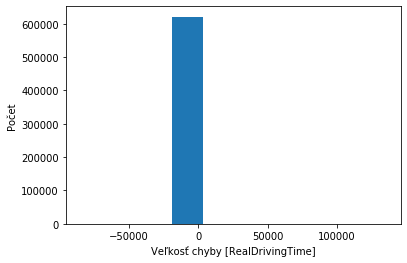

Weight  Length  CarCount  AxisCount  PlanDrivingTime  LengthSect  \
7870       2578     452        32        130           -44190        79.0   
28044       115      53         2          8              270        79.0   
30804      2379     580         0          0           -44190        79.0   
66389      2571     455        32        130           -44190        79.0   
124862     2539     522        32        128           -44190        79.0   
...         ...     ...       ...        ...              ...         ...   
3037011    2305     428        31        124              300        37.0   
3038295       0       0         0          0           -86220        33.0   
3049479       0       0         0          0           -86220        33.0   
3064677     700     414        28        112           -86220        33.0   
3068466      85      18         1          4              240        47.0   

         SectIdx  DelayDeparture  FromOstrava-Svinov  FromPolanka n. O.  ...  \
7870           9           -6480                 0.0                0.0  ...   
28044          1             186                 0.0                0.0  ...   
30804          9            4680                 0.0                0.0  ...   
66389          9            5100                 0.0                0.0  ...   
124862         9           12300                 0.0                0.0  ...   
...          ...             ...                 ...                ...  ...   
3037011        1           40284                 0.0                0.0  ...   
3038295        0           49140                 0.0                0.0  ...   
3049479        0           63720                 0.0                0.0  ...   
3064677        0            -540                 0.0                0.0  ...   
3068466        0           37302                 0.0                0.0  ...   

          Os    R  Nex   Sp   Sv   Mn   Lv  Sluz  Vlec  RealDrivingTime  
7870     0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0           -44190  
28044    1.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0           -85592  
30804    0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0           -44190  
66389    0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0           -44190  
124862   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0           -44190  
...      ...  ...  ...  ...  ...  ...  ...   ...   ...              ...  
3037011  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0           -39900  
3038295  0.0  0.0  1.0  0.0  0.0  0.0  0.0   0.0   0.0           -86220  
3049479  0.0  0.0  1.0  0.0  0.0  0.0  0.0   0.0   0.0           -86220  
3064677  0.0  0.0  1.0  0.0  0.0  0.0  0.0   0.0   0.0           -86220  
3068466  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0           -31132  

[172 rows x 62 columns]

------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 35.06 RealDrivingTime 
Testing set Mean Sqrt Error: 24325.18 RealDrivingTime 
Testing set Root Mean Sqrt Error: 155.97 RealDrivingTime 


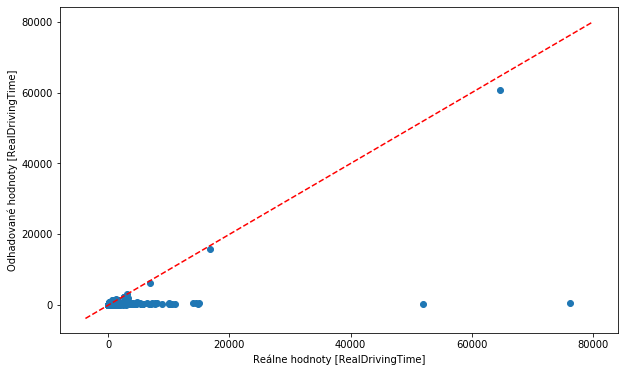

Najväčšia chyba:765.3472900390625
Najväčšia chyba v zápornom smere:-75603.984375
% približne správnych odhadov: 0.9607273047864735


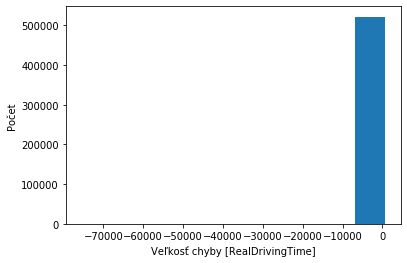

Weight  Length  CarCount  AxisCount  PlanDrivingTime  LengthSect  \
47006       879     444        33        132              510        12.0   
1267082     346     149         6         24              330       103.0   
1687118    1365     272        19         74              480         7.0   
2296855    1065     375        24         96              240         4.0   
2536734     438     200         8         32              360        88.0   
2536796     487     131         7         28              480        88.0   
2702193     162      31         2          8              330        79.0   
2814676    2379     431        31        124              420       103.0   

         SectIdx  DelayDeparture  FromOstrava-Svinov  FromPolanka n. O.  ...  \
47006          2           34376                 0.0                0.0  ...   
1267082        5             152                 0.0                0.0  ...   
1687118        6            6395                 0.0                0.0  ...   
2296855        0           24120                 1.0                0.0  ...   
2536734        0          -13770                 0.0                0.0  ...   
2536796        0          -21360                 0.0                0.0  ...   
2702193        2           -3464                 0.0                0.0  ...   
2814676        4           44451                 0.0                0.0  ...   

          Os    R  Nex   Sp   Sv   Mn   Lv  Sluz  Vlec  RealDrivingTime  
47006    0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0            76133  
1267082  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0            10540  
1687118  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0            14462  
2296855  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0            51933  
2536734  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0            14834  
2536796  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0            15015  
2702193  0.0  0.0  1.0  0.0  0.0  0.0  0.0   0.0   0.0            11054  
2814676  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0            14048  

[8 rows x 62 columns]

------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 34.20 RealDrivingTime 
Testing set Mean Sqrt Error: 24698.94 RealDrivingTime 
Testing set Root Mean Sqrt Error: 157.16 RealDrivingTime 


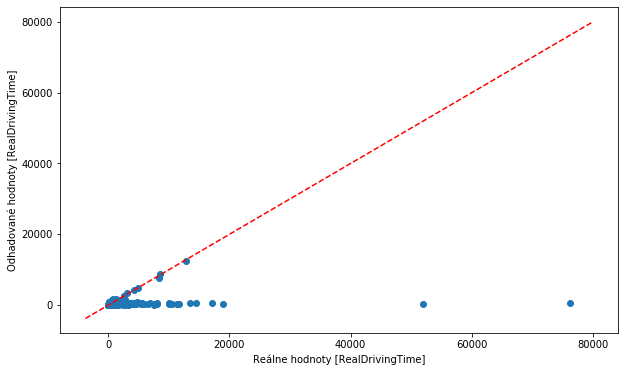

Najväčšia chyba:891.53271484375
Najväčšia chyba v zápornom smere:-75598.8515625
% približne správnych odhadov: 0.9606190704360326


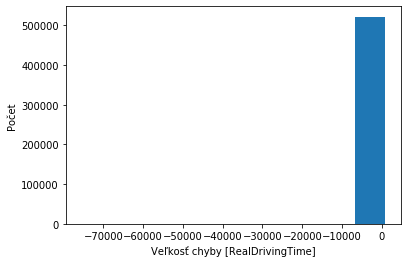

Weight  Length  CarCount  AxisCount  PlanDrivingTime  LengthSect  \
47006       879     444        33        132              510        12.0   
504310     1281     558        31        122              600        12.0   
1267082     346     149         6         24              330       103.0   
1687118    1365     272        19         74              480         7.0   
1842402     144      28         2          8              300        47.0   
2296855    1065     375        24         96              240         4.0   
2536624     412     185         7         28              360        88.0   
2811450     136      31         2          8              450        79.0   
2909399     642     472        21         84              540        12.0   

         SectIdx  DelayDeparture  FromOstrava-Svinov  FromPolanka n. O.  ...  \
47006          2           34376                 0.0                0.0  ...   
504310         6            5942                 0.0                0.0  ...   
1267082        5             152                 0.0                0.0  ...   
1687118        6            6395                 0.0                0.0  ...   
1842402        7            1786                 0.0                0.0  ...   
2296855        0           24120                 1.0                0.0  ...   
2536624        0          -10830                 0.0                0.0  ...   
2811450        0           16031                 0.0                0.0  ...   
2909399        0           17025                 0.0                0.0  ...   

          Os    R  Nex   Sp   Sv   Mn   Lv  Sluz  Vlec  RealDrivingTime  
47006    0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0            76133  
504310   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0            17204  
1267082  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0            10540  
1687118  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0            14462  
1842402  0.0  0.0  0.0  0.0  0.0  0.0  1.0   0.0   0.0            18921  
2296855  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0            51933  
2536624  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0            11382  
2811450  0.0  0.0  0.0  0.0  0.0  0.0  1.0   0.0   0.0            11743  
2909399  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0            13455  

[9 rows x 62 columns]

In [47]:
CreateAndFitModelLocations("FILTER2", 0.001, 120, "FILTER2ModelTTLOC", TTLOCFILTER2) 

-----------------------------FILTER3---------------------------------
Veľkosť trénovacej množniy: (1954766, 58)
Veľkosť testovacej množniy: (488691, 58)

....................
...................

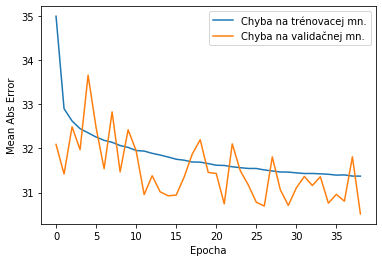

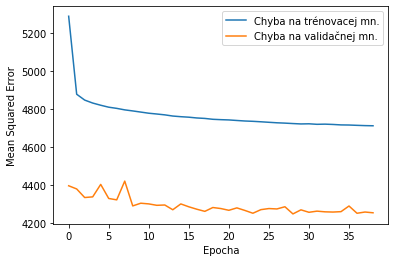

------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 82.51 RealDrivingTime 
Testing set Mean Sqrt Error: 1669102.38 RealDrivingTime 
Testing set Root Mean Sqrt Error: 1291.94 RealDrivingTime 


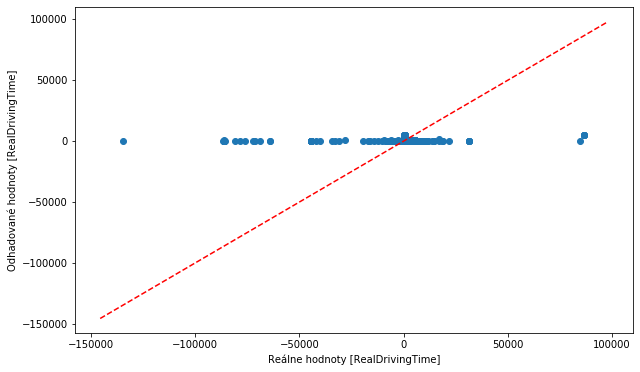

Najväčšia chyba:134785.859375
Najväčšia chyba v zápornom smere:-84511.03125
% približne správnych odhadov: 0.8827742148334715


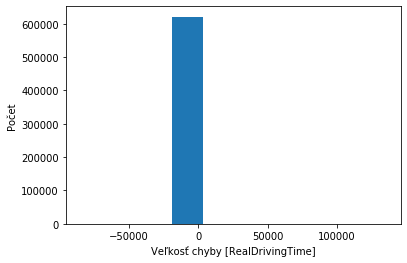

------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 40.99 RealDrivingTime 
Testing set Mean Sqrt Error: 28032.43 RealDrivingTime 
Testing set Root Mean Sqrt Error: 167.43 RealDrivingTime 


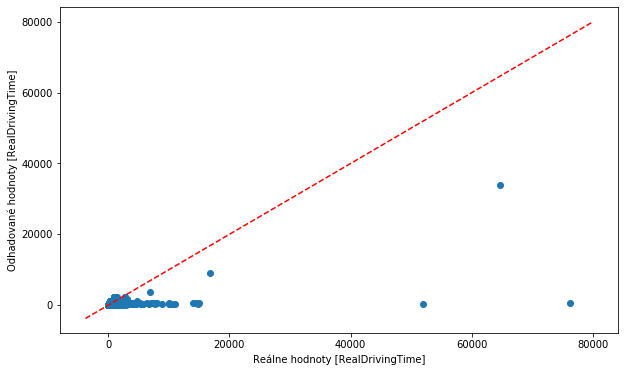

Najväčšia chyba:1319.320068359375
Najväčšia chyba v zápornom smere:-75590.0546875
% približne správnych odhadov: 0.9382112917383788


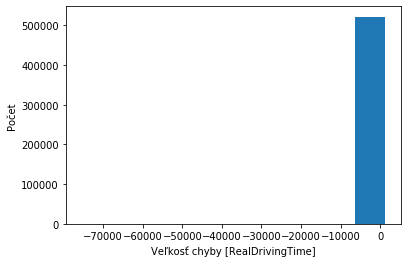

------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 40.43 RealDrivingTime 
Testing set Mean Sqrt Error: 26715.21 RealDrivingTime 
Testing set Root Mean Sqrt Error: 163.45 RealDrivingTime 


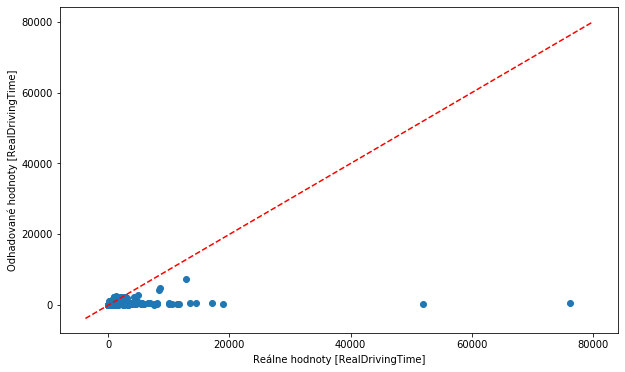

Najväčšia chyba:1388.797607421875
Najväčšia chyba v zápornom smere:-75586.3125
% približne správnych odhadov: 0.9384935313847628


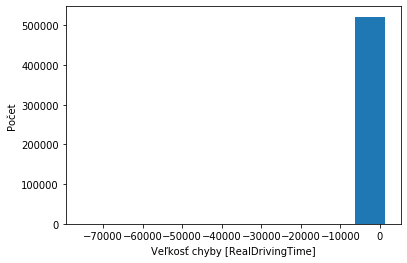

------Presnosť na FILTER3 dátach-------- 
Testing set Mean Abs Error: 31.07 RealDrivingTime 
Testing set Mean Sqrt Error: 4190.00 RealDrivingTime 
Testing set Root Mean Sqrt Error: 64.73 RealDrivingTime 


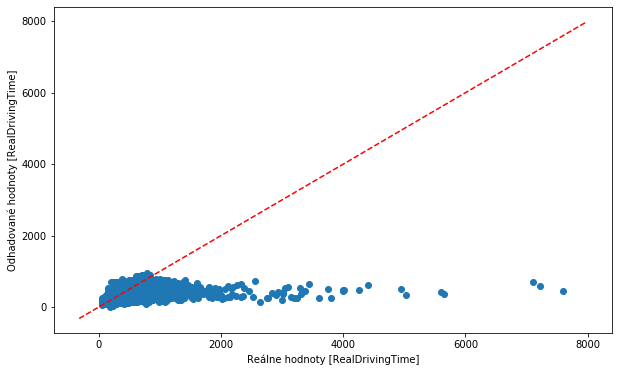

Najväčšia chyba:495.2901611328125
Najväčšia chyba v zápornom smere:-7143.23095703125
% približne správnych odhadov: 0.9654300979555588


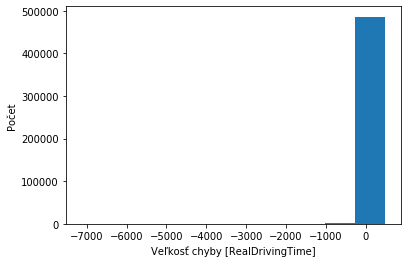

In [49]:
CreateAndFitModelLocations("FILTER3", 0.001, 120, "FILTER3ModelTTLOC", TTLOCFILTER3) 

# Kombinácia DayTime a Seasons = DTSEAS

In [41]:
DTSEASBASE = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDeparture',
                   'Rano','Obed','Vecer','Noc','Jar','Leto','Jesen','Zima', 'RealDrivingTime']

In [45]:
used_attributes = DTSEASBASE
label = DTSEASBASE[-1]

In [46]:
type = DFBASE['DayTime']
for daytime in daytime_types:
    DFBASE[daytime] = (type == daytime)*1.0
    
type = DFFILTER1['DayTime']
for daytime in daytime_types:
    DFFILTER1[daytime] = (type == daytime)*1.0
    
type = DFFILTER2['DayTime']
for daytime in daytime_types:
    DFFILTER2[daytime] = (type == daytime)*1.0
    
type = DFFILTER3['DayTime']
for daytime in daytime_types:
    DFFILTER3[daytime] = (type == daytime)*1.0

In [47]:
season = DFBASE['Season']
for seas in season_types:
    DFBASE[seas] = (season == seas)*1.0
    
season = DFFILTER1['Season']
for seas in season_types:
    DFFILTER1[seas] = (season == seas)*1.0
    
season = DFFILTER2['Season']
for seas in season_types:
    DFFILTER2[seas] = (season == seas)*1.0
    
season = DFFILTER3['Season']
for seas in season_types:
    DFFILTER3[seas] = (season == seas)*1.0

-----------------------------BASE---------------------------------
Veľkosť trénovacej množniy: (2485460, 16)
Veľkosť testovacej množniy: (621365, 16)

....................
........------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 55.14 RealDrivingTime
Testing set Mean Sqrt Error: 340339.66 RealDrivingTime
Testing set Root Mean Sqrt Error: 583.39 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 369.70 RealDrivingTime
Testing set Mean Sqrt Error: 496101.81 RealDrivingTime
Testing set Root Mean Sqrt Error: 704.34 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 411.62 RealDrivingTime
Testing set Mean Sqrt Error: 621458.50 RealDrivingTime
Testing set Root Mean Sqrt Error: 788.33 RealDrivingTime
------Presnosť na FILTER3 dátach-------- 
Testing set Mean Abs Error: 441.32 RealDrivingTime
Testing set Mean Sqrt Error: 594020.62 RealDrivingTime
Testing set Root Mean Sqrt Error: 770.73 RealDrivingTime


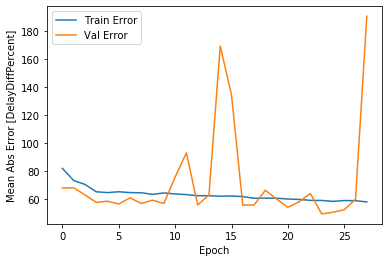

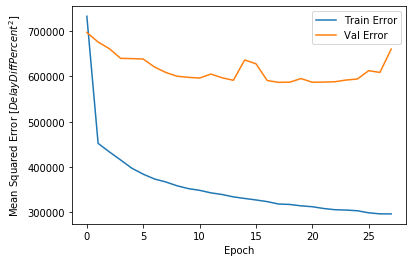

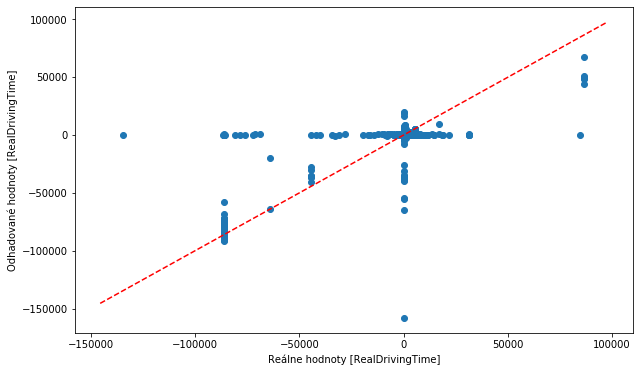

Najväčšia chyba:134566.234375
Najväčšia chyba v zápornom smere:-158857.6875
% približne správnych odhadov: 0.9228472797791958


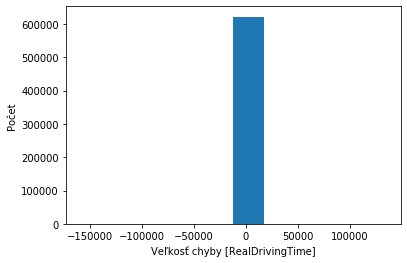

In [48]:
CreateAndFitModel("BASE", 0.001, 120, "BASEModelDTSEAS",used_attributes)

-----------------------------FILTER1---------------------------------
Veľkosť trénovacej množniy: (2087047, 16)
Veľkosť testovacej množniy: (521762, 16)

....................
....................
..........------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 105.97 RealDrivingTime
Testing set Mean Sqrt Error: 1519922.75 RealDrivingTime
Testing set Root Mean Sqrt Error: 1232.85 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 35.54 RealDrivingTime
Testing set Mean Sqrt Error: 17849.01 RealDrivingTime
Testing set Root Mean Sqrt Error: 133.60 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 36.85 RealDrivingTime
Testing set Mean Sqrt Error: 19665.07 RealDrivingTime
Testing set Root Mean Sqrt Error: 140.23 RealDrivingTime
------Presnosť na FILTER3 dátach-------- 
Testing set Mean Abs Error: 42.25 RealDrivingTime
Testing set Mean Sqrt Error: 5213.32 RealDrivingTime
Testing set Root Mean Sqrt Error: 72.20

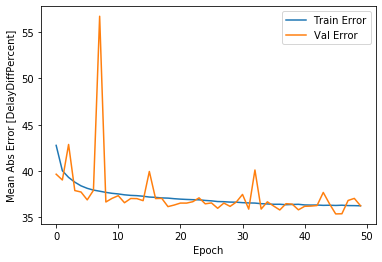

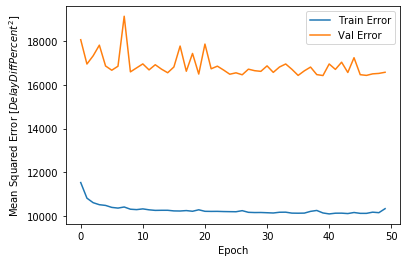

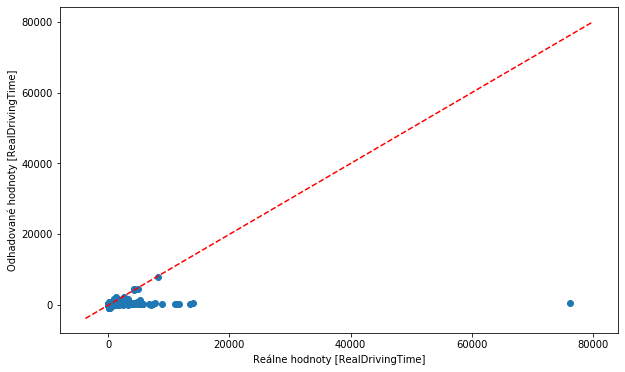

Najväčšia chyba:940.109130859375
Najväčšia chyba v zápornom smere:-75584.4140625
% približne správnych odhadov: 0.9565759867525807


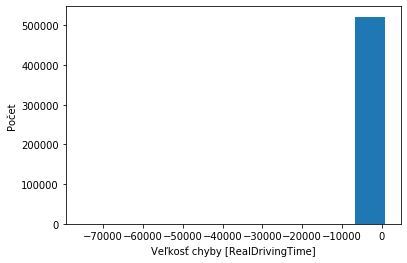

In [49]:
CreateAndFitModel("FILTER1", 0.001, 120, "FILTER1ModelDTSEAS",used_attributes)

-----------------------------FILTER2---------------------------------
Veľkosť trénovacej množniy: (2087002, 16)
Veľkosť testovacej množniy: (521751, 16)

....................
....................
....................
...........------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 106.37 RealDrivingTime
Testing set Mean Sqrt Error: 1350886.50 RealDrivingTime
Testing set Root Mean Sqrt Error: 1162.28 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 36.77 RealDrivingTime
Testing set Mean Sqrt Error: 17904.89 RealDrivingTime
Testing set Root Mean Sqrt Error: 133.81 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 34.71 RealDrivingTime
Testing set Mean Sqrt Error: 19503.80 RealDrivingTime
Testing set Root Mean Sqrt Error: 139.66 RealDrivingTime
------Presnosť na FILTER3 dátach-------- 
Testing set Mean Abs Error: 38.75 RealDrivingTime
Testing set Mean Sqrt Error: 4799.19 RealDrivingTime
Testing set Root 

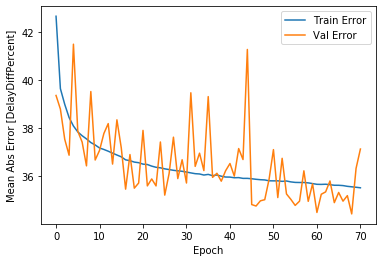

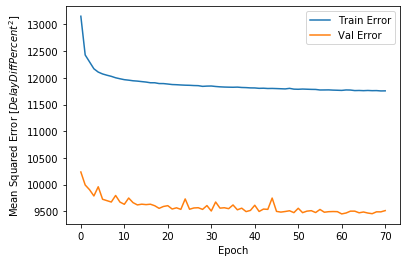

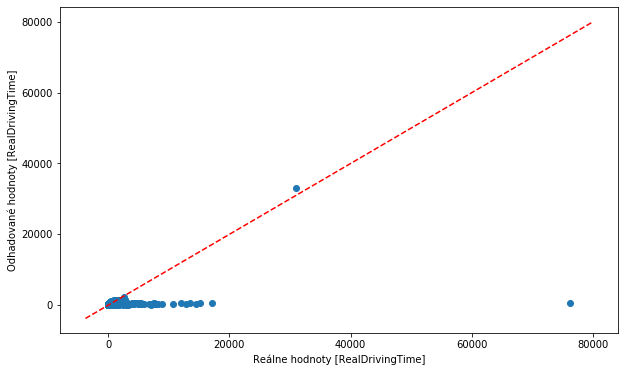

Najväčšia chyba:1891.82421875
Najväčšia chyba v zápornom smere:-75566.1875
% približne správnych odhadov: 0.9576004645894306


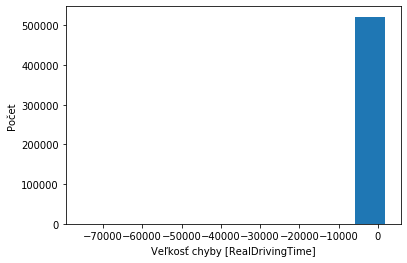

In [50]:
CreateAndFitModel("FILTER2", 0.001, 120, "FILTER2ModelDTSEAS",used_attributes)

-----------------------------FILTER3---------------------------------
Veľkosť trénovacej množniy: (1954766, 16)
Veľkosť testovacej množniy: (488692, 16)

....................
....................
....................
..................------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 108.08 RealDrivingTime
Testing set Mean Sqrt Error: 1637910.00 RealDrivingTime
Testing set Root Mean Sqrt Error: 1279.81 RealDrivingTime
------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 42.26 RealDrivingTime
Testing set Mean Sqrt Error: 19036.10 RealDrivingTime
Testing set Root Mean Sqrt Error: 137.97 RealDrivingTime
------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 39.47 RealDrivingTime
Testing set Mean Sqrt Error: 20966.60 RealDrivingTime
Testing set Root Mean Sqrt Error: 144.80 RealDrivingTime
------Presnosť na FILTER3 dátach-------- 
Testing set Mean Abs Error: 32.61 RealDrivingTime
Testing set Mean Sqrt Error: 4379.90 RealDrivingTime
Testing se

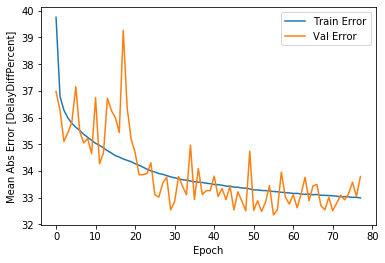

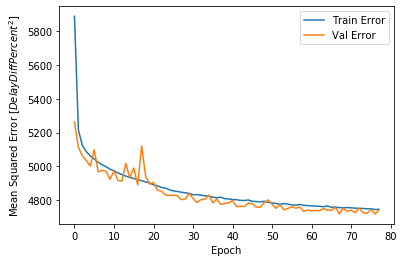

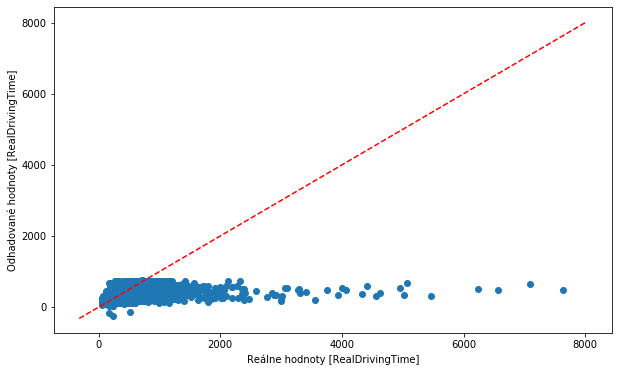

Najväčšia chyba:509.76318359375
Najväčšia chyba v zápornom smere:-7170.00390625
% približne správnych odhadov: 0.9633286405343243


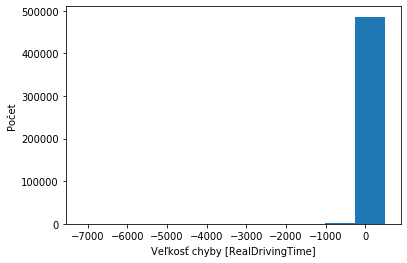

In [51]:
CreateAndFitModel("FILTER3", 0.001, 120, "FILTER3ModelDTSEAS",used_attributes)

## Vyhodnotenie - Kombinácia DayTime a Season

### BASE
#### ------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 55.14 RealDrivingTime [+6,34‬]
- Testing set Mean Sqrt Error: 340339.66 RealDrivingTime [+43 975‬]
- Testing set Root Mean Sqrt Error: 583.39 RealDrivingTime [+39‬]

------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 369.70 RealDrivingTime
- Testing set Mean Sqrt Error: 496101.81 RealDrivingTime
- Testing set Root Mean Sqrt Error: 704.34 RealDrivingTime

------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 411.62 RealDrivingTime
- Testing set Mean Sqrt Error: 621458.50 RealDrivingTime
- Testing set Root Mean Sqrt Error: 788.33 RealDrivingTime

------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 441.32 RealDrivingTime
- Testing set Mean Sqrt Error: 594020.62 RealDrivingTime
- Testing set Root Mean Sqrt Error: 770.73 RealDrivingTime

### FILTER1
------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 105.97 RealDrivingTime
- Testing set Mean Sqrt Error: 1519922.75 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1232.85 RealDrivingTime

#### ------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 35.54 RealDrivingTime [-1,35]
- Testing set Mean Sqrt Error: 17849.01 RealDrivingTime [-163]
- Testing set Root Mean Sqrt Error: 133.60 RealDrivingTime[-1]

------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 36.85 RealDrivingTime
- Testing set Mean Sqrt Error: 19665.07 RealDrivingTime
- Testing set Root Mean Sqrt Error: 140.23 RealDrivingTime

------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 42.25 RealDrivingTime
- Testing set Mean Sqrt Error: 5213.32 RealDrivingTime
- Testing set Root Mean Sqrt Error: 72.20 RealDrivingTime

### FILTER2
------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 106.37 RealDrivingTime
- Testing set Mean Sqrt Error: 1350886.50 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1162.28 RealDrivingTime

------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 36.77 RealDrivingTime
- Testing set Mean Sqrt Error: 17904.89 RealDrivingTime
- Testing set Root Mean Sqrt Error: 133.81 RealDrivingTime

#### ------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 34.71 RealDrivingTime [-2,04‬]
- Testing set Mean Sqrt Error: 19503.80 RealDrivingTime [-142‬]
- Testing set Root Mean Sqrt Error: 139.66 RealDrivingTime [-1]

------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 38.75 RealDrivingTime
- Testing set Mean Sqrt Error: 4799.19 RealDrivingTime
- Testing set Root Mean Sqrt Error: 69.28 RealDrivingTime

### FILTER3
------Presnosť na BASE dátach-------- 
- Testing set Mean Abs Error: 108.08 RealDrivingTime
- Testing set Mean Sqrt Error: 1637910.00 RealDrivingTime
- Testing set Root Mean Sqrt Error: 1279.81 RealDrivingTime

------Presnosť na FILTER1 dátach-------- 
- Testing set Mean Abs Error: 42.26 RealDrivingTime
- Testing set Mean Sqrt Error: 19036.10 RealDrivingTime
- Testing set Root Mean Sqrt Error: 137.97 RealDrivingTime

------Presnosť na FILTER2 dátach-------- 
- Testing set Mean Abs Error: 39.47 RealDrivingTime
- Testing set Mean Sqrt Error: 20966.60 RealDrivingTime
- Testing set Root Mean Sqrt Error: 144.80 RealDrivingTime

#### ------Presnosť na FILTER3 dátach-------- 
- Testing set Mean Abs Error: 32.61 RealDrivingTime [-0.38]
- Testing set Mean Sqrt Error: 4379.90 RealDrivingTime [-78‬]
- Testing set Root Mean Sqrt Error: 66.18 RealDrivingTime [-0,58]

# Kombinácia DayTimes a TrainTypes = DTTT

In [44]:
DTTTBASE = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDeparture',
                   'Rano','Obed','Vecer','Noc']

In [45]:
DTTTFILTER1 = DTTTBASE.copy()
DTTTFILTER2 = DTTTBASE.copy()
DTTTFILTER3 = DTTTBASE.copy()

In [46]:
type = DFBASE['TrainType']
for typ in DFBASE.TrainType.unique():
    DTTTBASE.append(typ)
    DFBASE[typ] = (type == typ)*1.0
    
type = DFFILTER1['TrainType']
for typ in DFFILTER1.TrainType.unique():
    DTTTFILTER1.append(typ)
    DFFILTER1[typ] = (type == typ)*1.0

type = DFFILTER2['TrainType']
for typ in DFFILTER2.TrainType.unique():
    DTTTFILTER2.append(typ)
    DFFILTER2[typ] = (type == typ)*1.0

type = DFFILTER3['TrainType']
for typ in DFFILTER3.TrainType.unique():
    DTTTFILTER3.append(typ)
    DFFILTER3[typ] = (type == typ)*1.0

DTTTBASE.append('RealDrivingTime')    
DTTTFILTER1.append('RealDrivingTime')
DTTTFILTER2.append('RealDrivingTime')
DTTTFILTER3.append('RealDrivingTime')

In [47]:
type = DFBASE['DayTime']
for daytime in daytime_types:
    DFBASE[daytime] = (type == daytime)*1.0
    
type = DFFILTER1['DayTime']
for daytime in daytime_types:
    DFFILTER1[daytime] = (type == daytime)*1.0
    
type = DFFILTER2['DayTime']
for daytime in daytime_types:
    DFFILTER2[daytime] = (type == daytime)*1.0
    
type = DFFILTER3['DayTime']
for daytime in daytime_types:
    DFFILTER3[daytime] = (type == daytime)*1.0

-----------------------------BASE---------------------------------
Veľkosť trénovacej množniy: (2485460, 23)
Veľkosť testovacej množniy: (621365, 23)

....................
....................
....................
....................
....................
....................

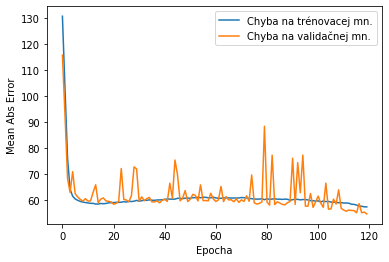

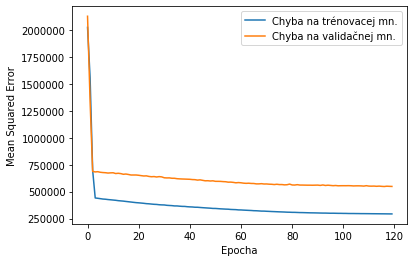

------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 57.89 RealDrivingTime 
Testing set Mean Sqrt Error: 319028.12 RealDrivingTime 
Testing set Root Mean Sqrt Error: 564.83 RealDrivingTime 


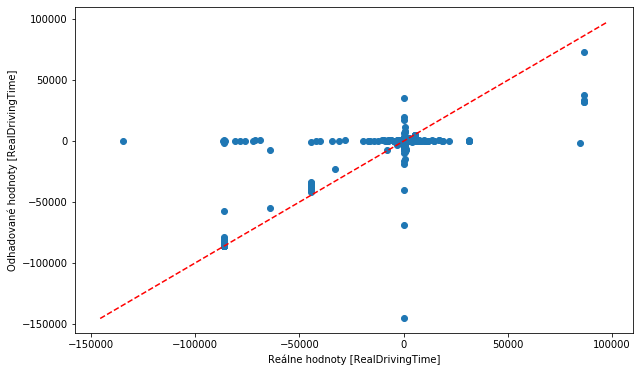

Najväčšia chyba:134497.609375
Najväčšia chyba v zápornom smere:-145199.0
% približne správnych odhadov: 0.9034818504421717


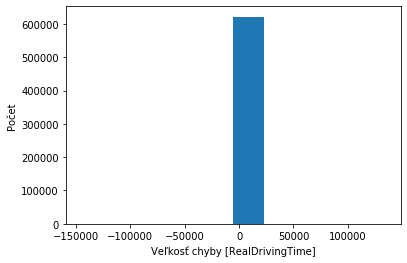

------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 739.07 RealDrivingTime 
Testing set Mean Sqrt Error: 1906836.12 RealDrivingTime 
Testing set Root Mean Sqrt Error: 1380.88 RealDrivingTime 


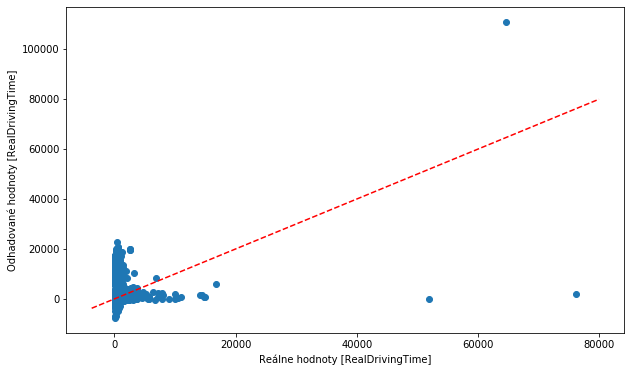

Najväčšia chyba:46274.0546875
Najväčšia chyba v zápornom smere:-74072.171875
% približne správnych odhadov: 0.1492845396943434


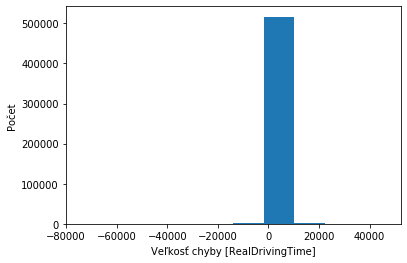

------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 775.65 RealDrivingTime 
Testing set Mean Sqrt Error: 2018261.25 RealDrivingTime 
Testing set Root Mean Sqrt Error: 1420.66 RealDrivingTime 


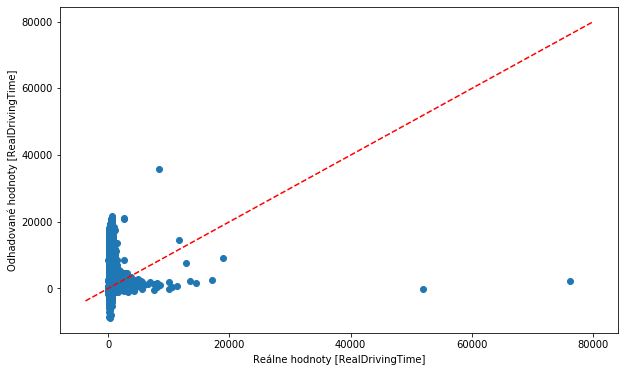

Najväčšia chyba:27454.9453125
Najväčšia chyba v zápornom smere:-73959.453125
% približne správnych odhadov: 0.1374719693339722


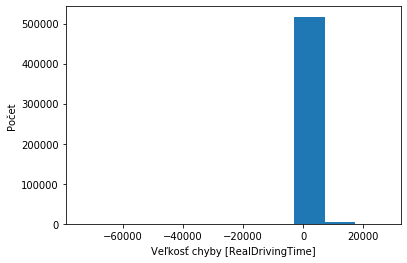

------Presnosť na FILTER3 dátach-------- 
Testing set Mean Abs Error: 966.46 RealDrivingTime 
Testing set Mean Sqrt Error: 2584831.75 RealDrivingTime 
Testing set Root Mean Sqrt Error: 1607.74 RealDrivingTime 


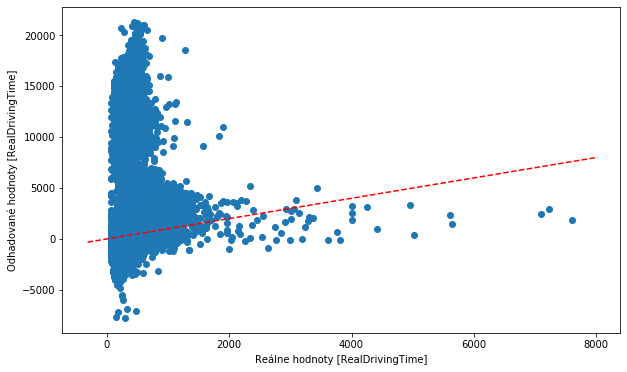

Najväčšia chyba:20886.1640625
Najväčšia chyba v zápornom smere:-8118.82861328125
% približne správnych odhadov: 0.12824054463863668


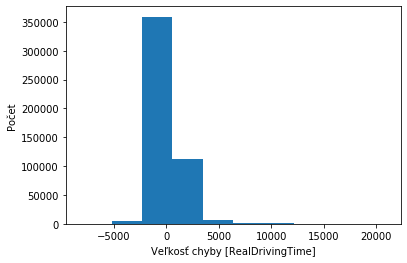

In [65]:
CreateAndFitModel("BASE", 0.0001, 120, "BASEModelDTTT", DTTTBASE)

-----------------------------FILTER1---------------------------------
Veľkosť trénovacej množniy: (2087046, 23)
Veľkosť testovacej množniy: (521762, 23)

....................
....................
......

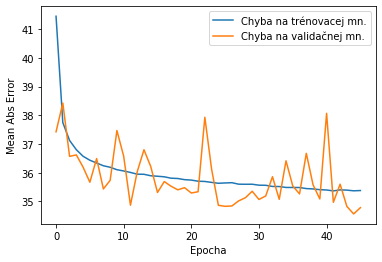

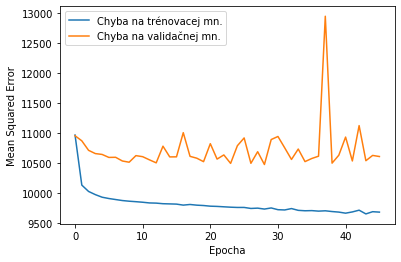

------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 109.19 RealDrivingTime 
Testing set Mean Sqrt Error: 1572586.00 RealDrivingTime 
Testing set Root Mean Sqrt Error: 1254.03 RealDrivingTime 


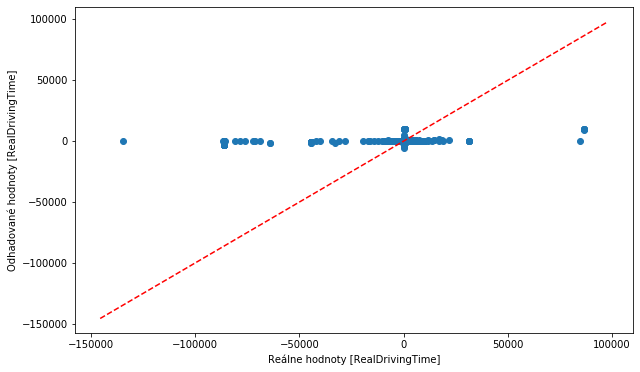

Najväčšia chyba:134733.46875
Najväčšia chyba v zápornom smere:-84618.046875
% približne správnych odhadov: 0.7687188689417653


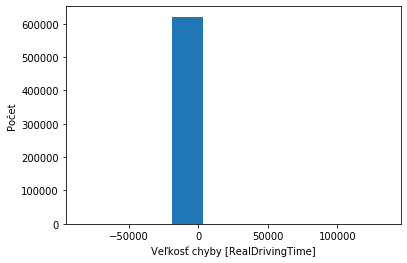

------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 35.40 RealDrivingTime 
Testing set Mean Sqrt Error: 24356.39 RealDrivingTime 
Testing set Root Mean Sqrt Error: 156.07 RealDrivingTime 


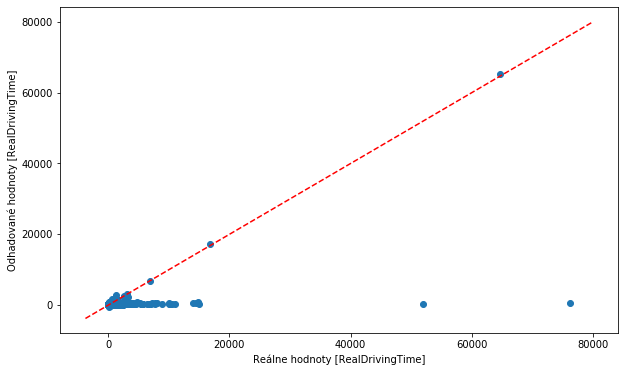

Najväčšia chyba:1595.554443359375
Najväčšia chyba v zápornom smere:-75585.0546875
% približne správnych odhadov: 0.9585309010621701


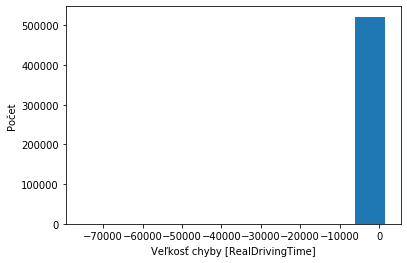

------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 36.45 RealDrivingTime 
Testing set Mean Sqrt Error: 24874.42 RealDrivingTime 
Testing set Root Mean Sqrt Error: 157.72 RealDrivingTime 


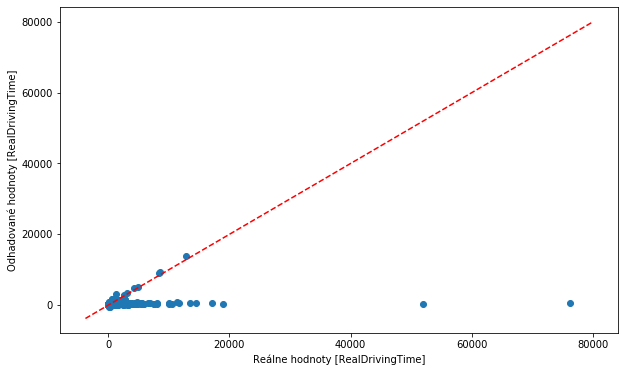

Najväčšia chyba:1809.15478515625
Najväčšia chyba v zápornom smere:-75579.3125
% približne správnych odhadov: 0.9576636320076665


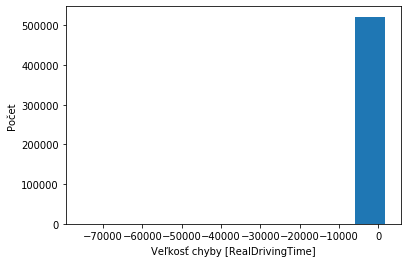

------Presnosť na FILTER3 dátach-------- 
Testing set Mean Abs Error: 42.48 RealDrivingTime 
Testing set Mean Sqrt Error: 5116.78 RealDrivingTime 
Testing set Root Mean Sqrt Error: 71.53 RealDrivingTime 


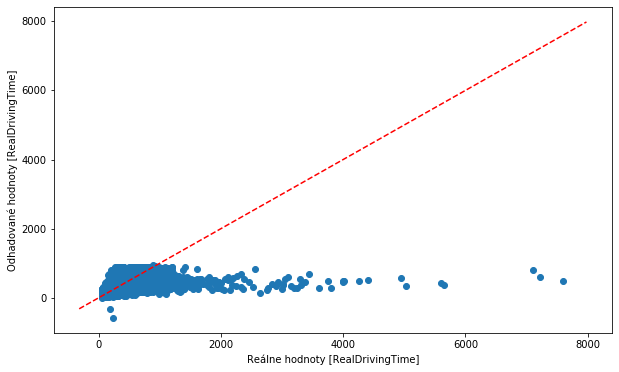

Najväčšia chyba:623.5695190429688
Najväčšia chyba v zápornom smere:-7110.71240234375
% približne správnych odhadov: 0.9510795165042941


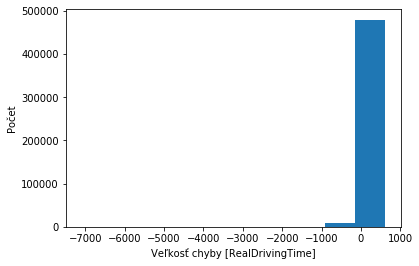

In [48]:
CreateAndFitModel("FILTER1", 0.001, 120, "FILTER1ModelDTTT",DTTTFILTER1)

-----------------------------FILTER2---------------------------------
Veľkosť trénovacej množniy: (2087002, 23)
Veľkosť testovacej množniy: (521750, 23)

....................
....................
....................
....................
....................
....................
....................
..........

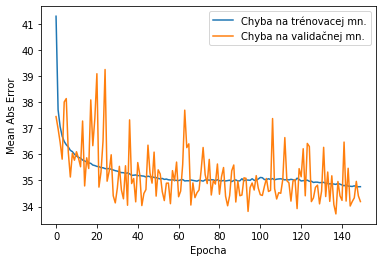

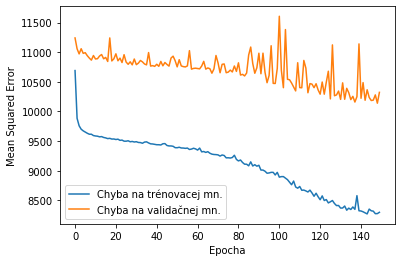

------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 148.77 RealDrivingTime 
Testing set Mean Sqrt Error: 1487869.62 RealDrivingTime 
Testing set Root Mean Sqrt Error: 1219.78 RealDrivingTime 


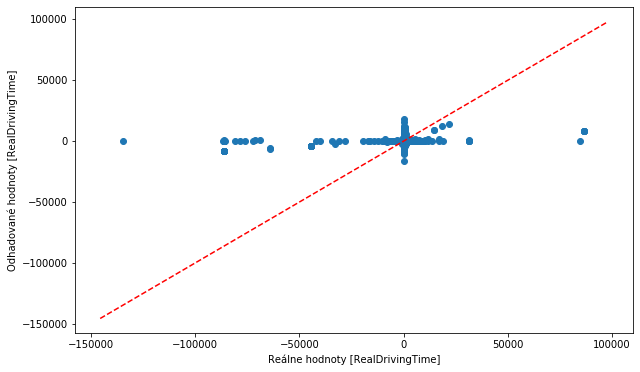

Najväčšia chyba:134774.6875
Najväčšia chyba v zápornom smere:-84617.671875
% približne správnych odhadov: 0.7380283730174696


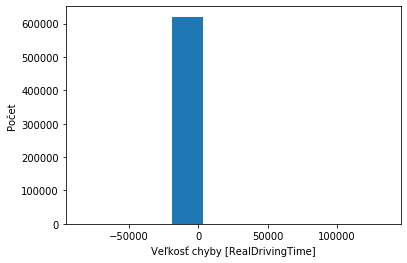

------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 36.08 RealDrivingTime 
Testing set Mean Sqrt Error: 23961.60 RealDrivingTime 
Testing set Root Mean Sqrt Error: 154.80 RealDrivingTime 


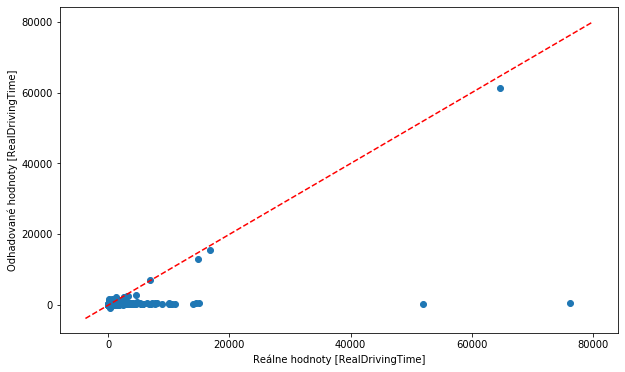

Najväčšia chyba:1490.486328125
Najväčšia chyba v zápornom smere:-75595.21875
% približne správnych odhadov: 0.9595275240435295


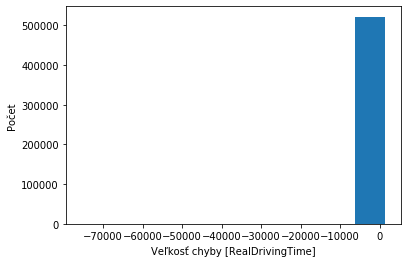

------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 34.78 RealDrivingTime 
Testing set Mean Sqrt Error: 24519.04 RealDrivingTime 
Testing set Root Mean Sqrt Error: 156.59 RealDrivingTime 


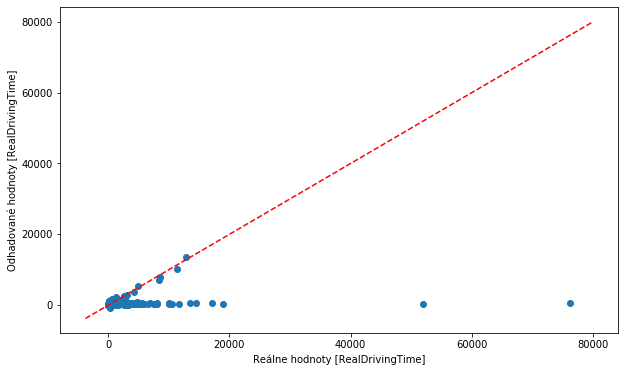

Najväčšia chyba:1270.1572265625
Najväčšia chyba v zápornom smere:-75590.09375
% približne správnych odhadov: 0.9595955917585051


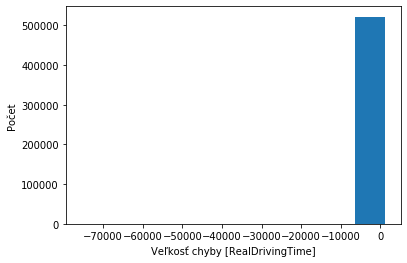

------Presnosť na FILTER3 dátach-------- 
Testing set Mean Abs Error: 46.08 RealDrivingTime 
Testing set Mean Sqrt Error: 5673.56 RealDrivingTime 
Testing set Root Mean Sqrt Error: 75.32 RealDrivingTime 


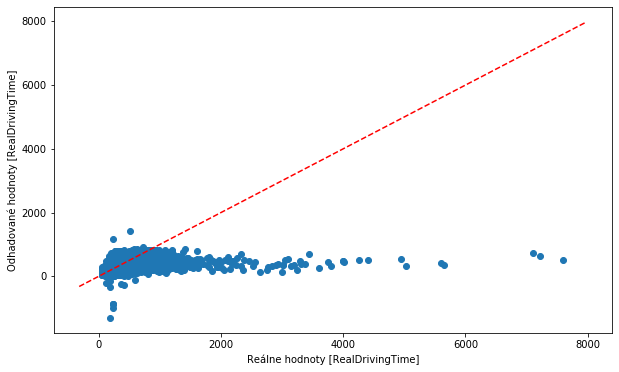

Najväčšia chyba:930.5390625
Najväčšia chyba v zápornom smere:-7094.75048828125
% približne správnych odhadov: 0.9495898226077419


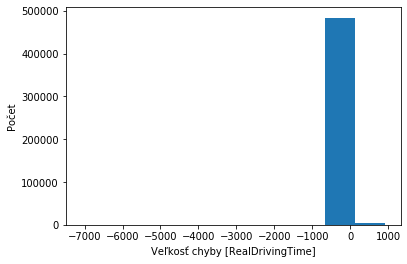

In [49]:
CreateAndFitModel("FILTER2", 0.001, 120, "FILTER2ModelDTTT",DTTTFILTER2)

-----------------------------FILTER3---------------------------------
Veľkosť trénovacej množniy: (1954766, 23)
Veľkosť testovacej množniy: (488691, 23)

....................
....................
....................
............

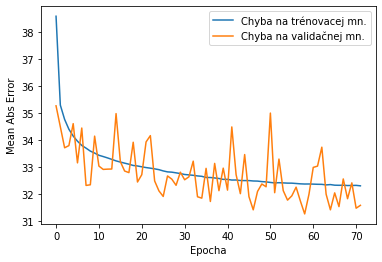

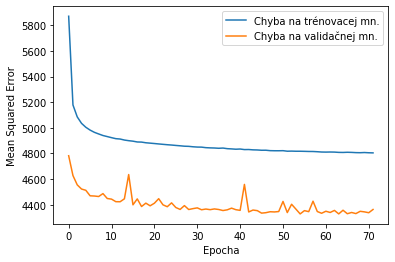

------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 108.16 RealDrivingTime 
Testing set Mean Sqrt Error: 1534489.50 RealDrivingTime 
Testing set Root Mean Sqrt Error: 1238.75 RealDrivingTime 


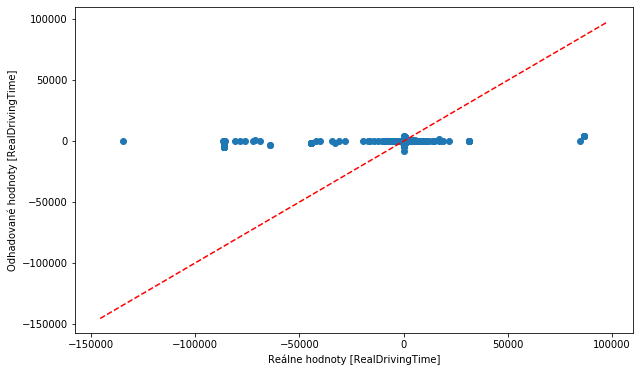

Najväčšia chyba:134763.640625
Najväčšia chyba v zápornom smere:-84600.7734375
% približne správnych odhadov: 0.7787146041376647


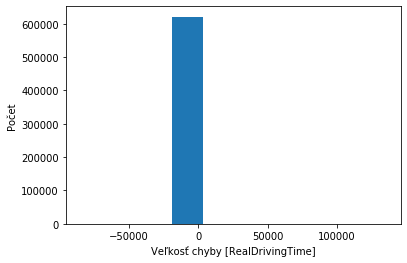

------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 40.60 RealDrivingTime 
Testing set Mean Sqrt Error: 28088.34 RealDrivingTime 
Testing set Root Mean Sqrt Error: 167.60 RealDrivingTime 


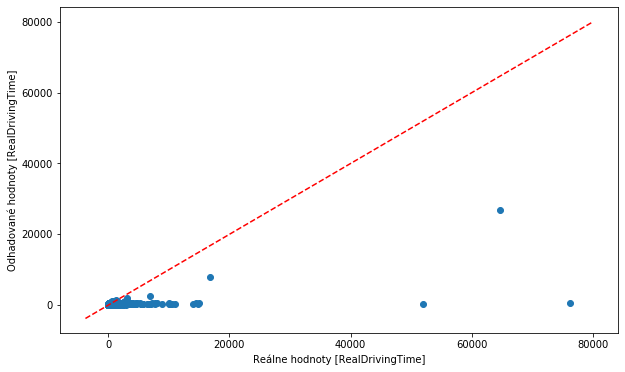

Najväčšia chyba:584.4959716796875
Najväčšia chyba v zápornom smere:-75594.8515625
% približne správnych odhadov: 0.9405150240914439


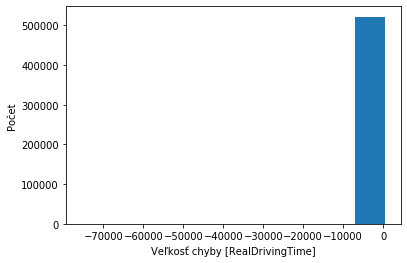

------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 38.54 RealDrivingTime 
Testing set Mean Sqrt Error: 25518.45 RealDrivingTime 
Testing set Root Mean Sqrt Error: 159.74 RealDrivingTime 


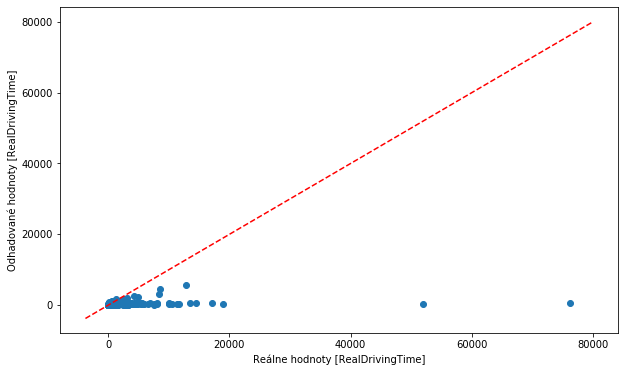

Najväčšia chyba:617.658935546875
Najväčšia chyba v zápornom smere:-75590.7421875
% približne správnych odhadov: 0.9494700527072353


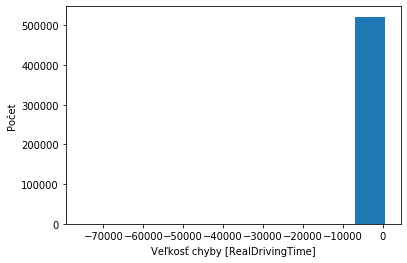

------Presnosť na FILTER3 dátach-------- 
Testing set Mean Abs Error: 31.76 RealDrivingTime 
Testing set Mean Sqrt Error: 4257.81 RealDrivingTime 
Testing set Root Mean Sqrt Error: 65.25 RealDrivingTime 


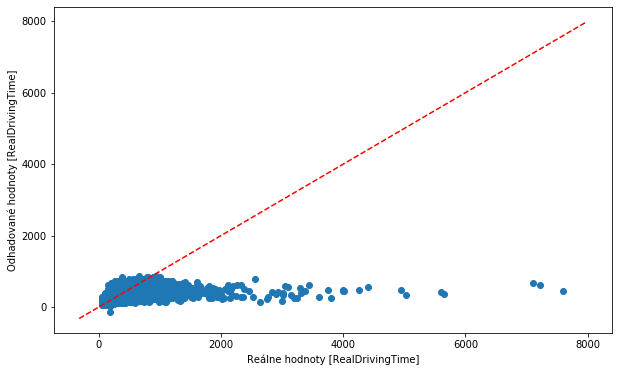

Najväčšia chyba:470.35821533203125
Najväčšia chyba v zápornom smere:-7138.02978515625
% približne správnych odhadov: 0.9645563351893118


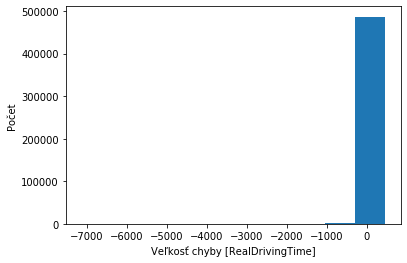

In [50]:
CreateAndFitModel("FILTER3", 0.001, 120, "FILTER3ModelDTTT",DTTTFILTER3)

## Vyhodnotenie DTTT

### BASE
------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 57.89 RealDrivingTime 
Testing set Mean Sqrt Error: 319028.12 RealDrivingTime 
Testing set Root Mean Sqrt Error: 564.83 RealDrivingTime 

------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 739.07 RealDrivingTime 
Testing set Mean Sqrt Error: 1906836.12 RealDrivingTime 
Testing set Root Mean Sqrt Error: 1380.88 RealDrivingTime 

------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 775.65 RealDrivingTime 
Testing set Mean Sqrt Error: 2018261.25 RealDrivingTime 
Testing set Root Mean Sqrt Error: 1420.66 RealDrivingTime 

------Presnosť na FILTER3 dátach-------- 
Testing set Mean Abs Error: 966.46 RealDrivingTime 
Testing set Mean Sqrt Error: 2584831.75 RealDrivingTime 
Testing set Root Mean Sqrt Error: 1607.74 RealDrivingTime

### FILTER1

------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 109.19 RealDrivingTime 
Testing set Mean Sqrt Error: 1572586.00 RealDrivingTime 
Testing set Root Mean Sqrt Error: 1254.03 RealDrivingTime 

------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 35.40 RealDrivingTime 
Testing set Mean Sqrt Error: 24356.39 RealDrivingTime 
Testing set Root Mean Sqrt Error: 156.07 RealDrivingTime

------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 36.45 RealDrivingTime 
Testing set Mean Sqrt Error: 24874.42 RealDrivingTime 
Testing set Root Mean Sqrt Error: 157.72 RealDrivingTime 

------Presnosť na FILTER3 dátach-------- 
Testing set Mean Abs Error: 42.48 RealDrivingTime 
Testing set Mean Sqrt Error: 5116.78 RealDrivingTime 
Testing set Root Mean Sqrt Error: 71.53 RealDrivingTime 


# Kombinácia Seasons a TrainTypes = SETT

In [51]:
SETTBASE = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDeparture',
                   'Jar','Leto','Jesen','Zima']

In [52]:
SETTFILTER1 = SETTBASE.copy()
SETTFILTER2 = SETTBASE.copy()
SETTFILTER3 = SETTBASE.copy()

In [53]:
type = DFBASE['TrainType']
for typ in DFBASE.TrainType.unique():
    SETTBASE.append(typ)
    DFBASE[typ] = (type == typ)*1.0
    
type = DFFILTER1['TrainType']
for typ in DFFILTER1.TrainType.unique():
    SETTFILTER1.append(typ)
    DFFILTER1[typ] = (type == typ)*1.0

type = DFFILTER2['TrainType']
for typ in DFFILTER2.TrainType.unique():
    SETTFILTER2.append(typ)
    DFFILTER2[typ] = (type == typ)*1.0

type = DFFILTER3['TrainType']
for typ in DFFILTER3.TrainType.unique():
    SETTFILTER3.append(typ)
    DFFILTER3[typ] = (type == typ)*1.0

SETTBASE.append('RealDrivingTime')    
SETTFILTER1.append('RealDrivingTime')
SETTFILTER2.append('RealDrivingTime')
SETTFILTER3.append('RealDrivingTime')

In [54]:
type = DFBASE['Season']
for season in season_types:
    DFBASE[season] = (type == season)*1.0
    
type = DFFILTER1['Season']
for season in season_types:
    DFFILTER1[season] = (type == season)*1.0
    
type = DFFILTER2['Season']
for season in season_types:
    DFFILTER2[season] = (type == season)*1.0
    
type = DFFILTER3['Season']
for season in season_types:
    DFFILTER3[season] = (type == season)*1.0

-----------------------------BASE---------------------------------
Veľkosť trénovacej množniy: (2485460, 23)
Veľkosť testovacej množniy: (621365, 23)

....................
....................
....................
....................
....................
....................
....................
..........

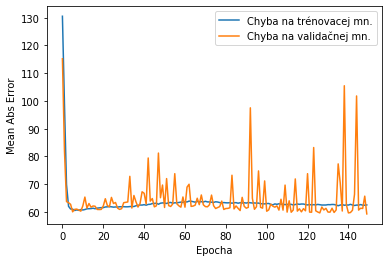

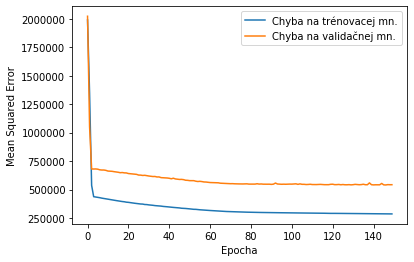

------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 60.59 RealDrivingTime 
Testing set Mean Sqrt Error: 309000.25 RealDrivingTime 
Testing set Root Mean Sqrt Error: 555.88 RealDrivingTime 


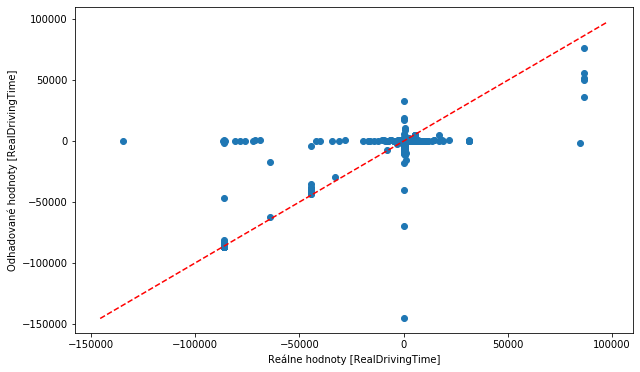

Najväčšia chyba:134535.21875
Najväčšia chyba v zápornom smere:-145711.984375
% približne správnych odhadov: 0.8975336557417942


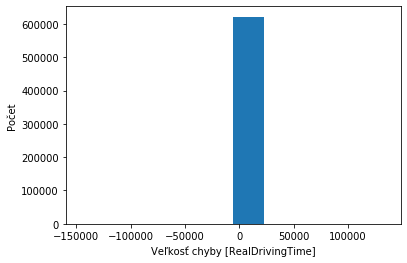

------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 819.50 RealDrivingTime 
Testing set Mean Sqrt Error: 3279217.75 RealDrivingTime 
Testing set Root Mean Sqrt Error: 1810.86 RealDrivingTime 


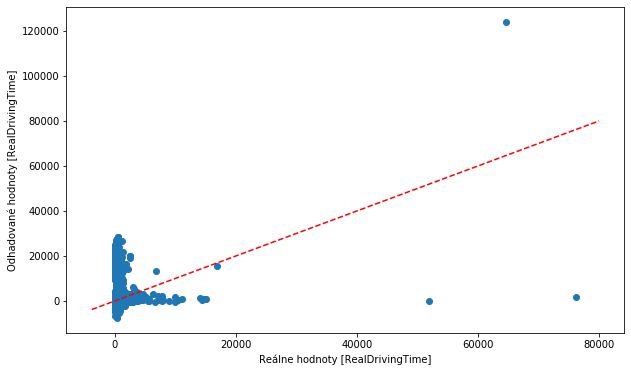

Najväčšia chyba:59254.4453125
Najväčšia chyba v zápornom smere:-74311.6796875
% približne správnych odhadov: 0.15057056665682822


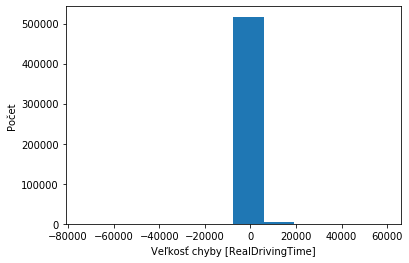

------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 856.34 RealDrivingTime 
Testing set Mean Sqrt Error: 3404229.25 RealDrivingTime 
Testing set Root Mean Sqrt Error: 1845.06 RealDrivingTime 


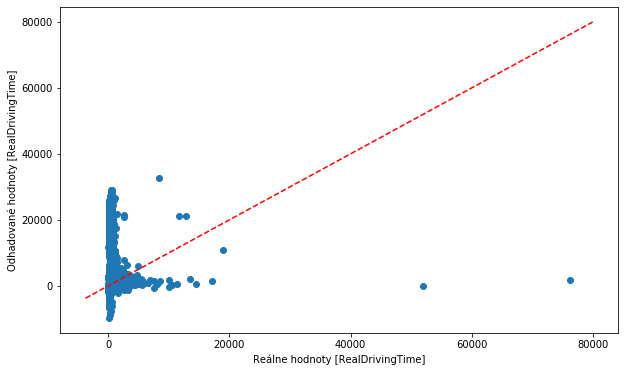

Najväčšia chyba:28447.416015625
Najväčšia chyba v zápornom smere:-74207.203125
% približne správnych odhadov: 0.14030857690464782


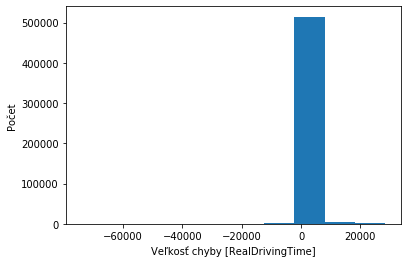

------Presnosť na FILTER3 dátach-------- 
Testing set Mean Abs Error: 1104.78 RealDrivingTime 
Testing set Mean Sqrt Error: 4037808.25 RealDrivingTime 
Testing set Root Mean Sqrt Error: 2009.43 RealDrivingTime 


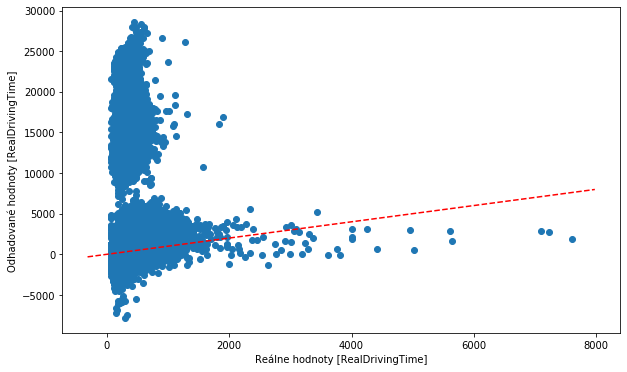

Najväčšia chyba:28153.654296875
Najväčšia chyba v zápornom smere:-8199.474609375
% približne správnych odhadov: 0.0939080114018879


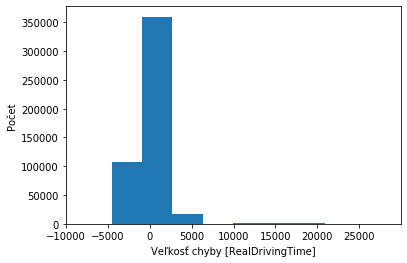

In [55]:
CreateAndFitModel("BASE", 0.0001, 120, "BASEModelSETT", SETTBASE)

-----------------------------FILTER1---------------------------------
Veľkosť trénovacej množniy: (2087046, 23)
Veľkosť testovacej množniy: (521762, 23)

....................
....................
....

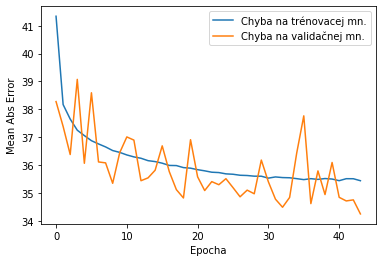

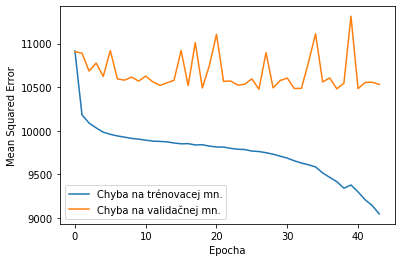

------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 106.76 RealDrivingTime 
Testing set Mean Sqrt Error: 1562531.50 RealDrivingTime 
Testing set Root Mean Sqrt Error: 1250.01 RealDrivingTime 


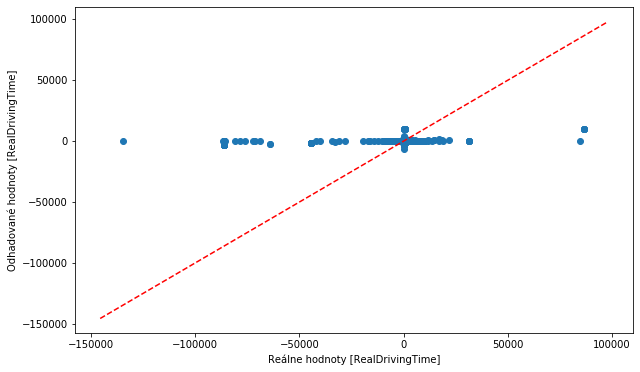

Najväčšia chyba:134710.171875
Najväčšia chyba v zápornom smere:-84629.8203125
% približne správnych odhadov: 0.7878203632325605


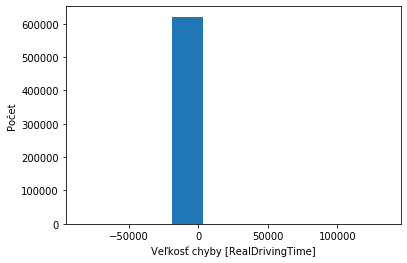

------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 35.14 RealDrivingTime 
Testing set Mean Sqrt Error: 24388.99 RealDrivingTime 
Testing set Root Mean Sqrt Error: 156.17 RealDrivingTime 


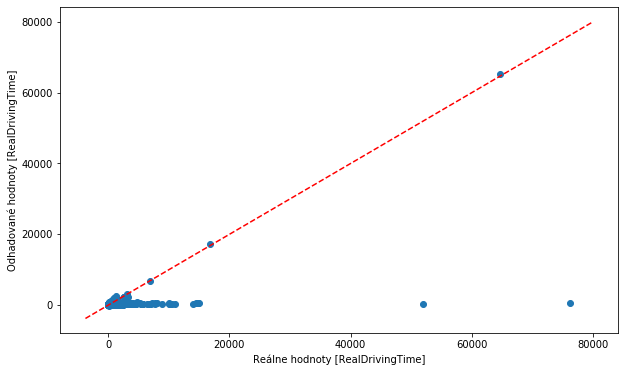

Najväčšia chyba:1405.390625
Najväčšia chyba v zápornom smere:-75592.1171875
% približne správnych odhadov: 0.9579195111947593


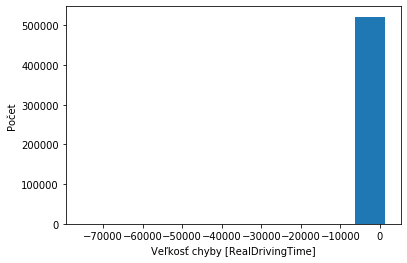

------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 35.89 RealDrivingTime 
Testing set Mean Sqrt Error: 24889.87 RealDrivingTime 
Testing set Root Mean Sqrt Error: 157.77 RealDrivingTime 


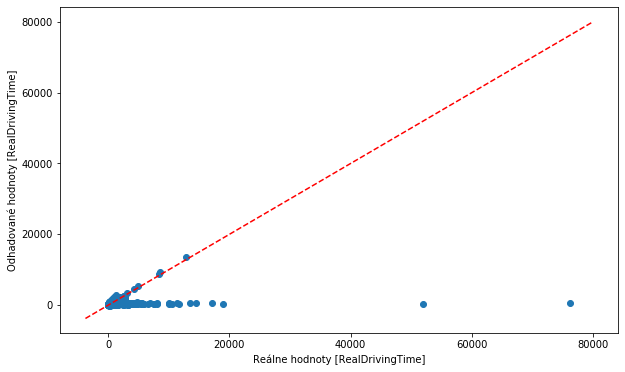

Najväčšia chyba:1597.84716796875
Najväčšia chyba v zápornom smere:-75586.71875
% približne správnych odhadov: 0.9572573071394346


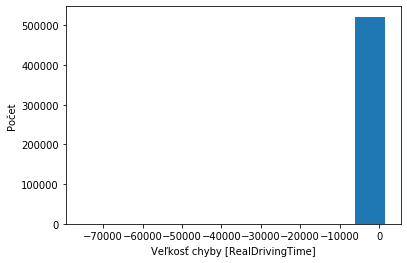

------Presnosť na FILTER3 dátach-------- 
Testing set Mean Abs Error: 40.17 RealDrivingTime 
Testing set Mean Sqrt Error: 4957.85 RealDrivingTime 
Testing set Root Mean Sqrt Error: 70.41 RealDrivingTime 


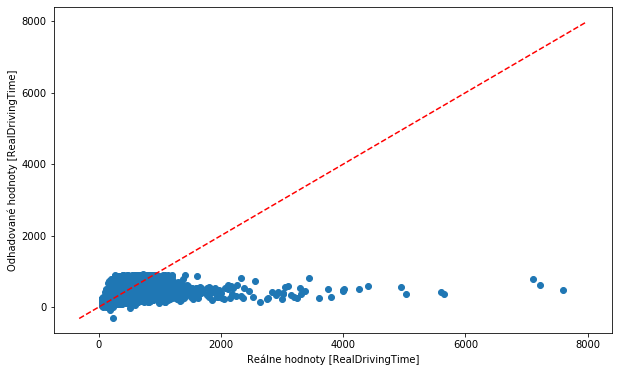

Najväčšia chyba:615.9376831054688
Najväčšia chyba v zápornom smere:-7120.205078125
% približne správnych odhadov: 0.9510078966054214


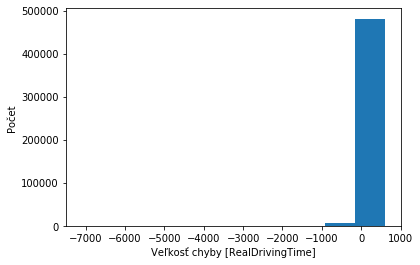

In [56]:
CreateAndFitModel("FILTER1", 0.001, 120, "FILTER1ModelSETT",SETTFILTER1)

-----------------------------FILTER2---------------------------------
Veľkosť trénovacej množniy: (2087002, 23)
Veľkosť testovacej množniy: (521750, 23)

....................
....................
....................
....................
....................
....................
....................
..........

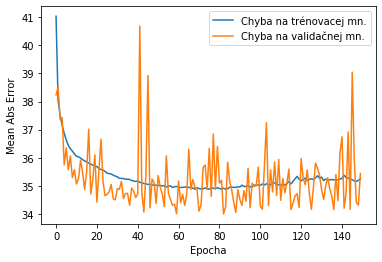

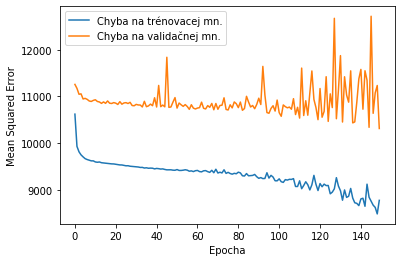

------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 162.26 RealDrivingTime 
Testing set Mean Sqrt Error: 1374338.88 RealDrivingTime 
Testing set Root Mean Sqrt Error: 1172.32 RealDrivingTime 


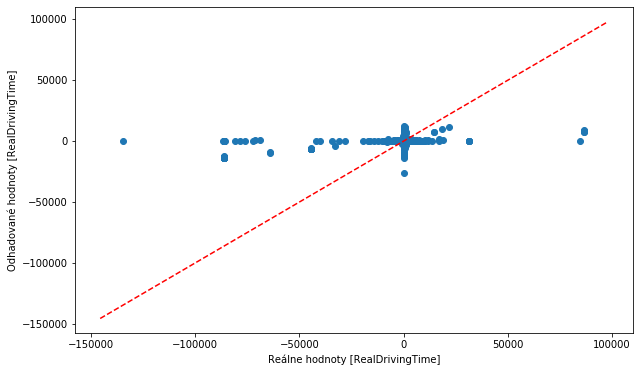

Najväčšia chyba:134822.03125
Najväčšia chyba v zápornom smere:-84677.96875
% približne správnych odhadov: 0.6881752271209354


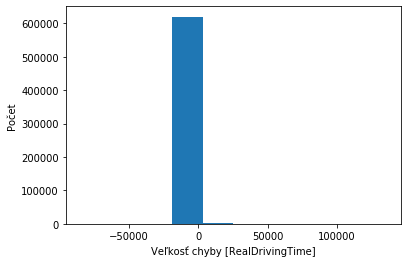

------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 36.81 RealDrivingTime 
Testing set Mean Sqrt Error: 25531.05 RealDrivingTime 
Testing set Root Mean Sqrt Error: 159.78 RealDrivingTime 


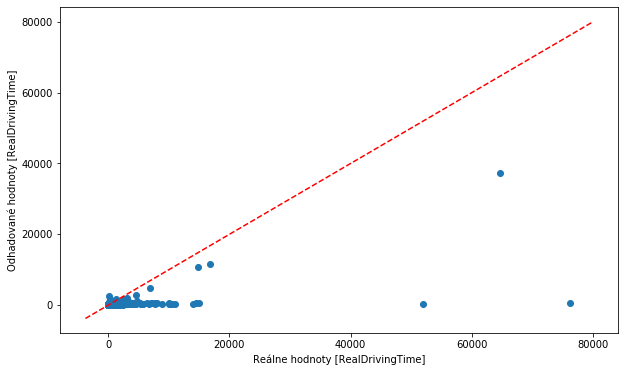

Najväčšia chyba:2538.955078125
Najväčšia chyba v zápornom smere:-75601.8984375
% približne správnych odhadov: 0.9593186165339752


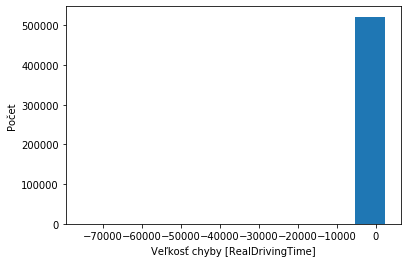

------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 35.79 RealDrivingTime 
Testing set Mean Sqrt Error: 24617.71 RealDrivingTime 
Testing set Root Mean Sqrt Error: 156.90 RealDrivingTime 


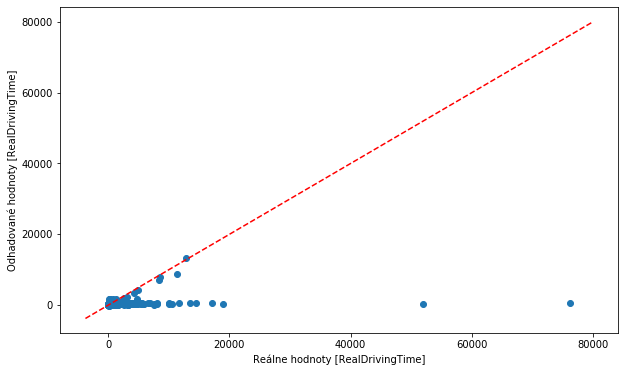

Najväčšia chyba:1600.09716796875
Najväčšia chyba v zápornom smere:-75597.1875
% približne správnych odhadov: 0.9588040249161476


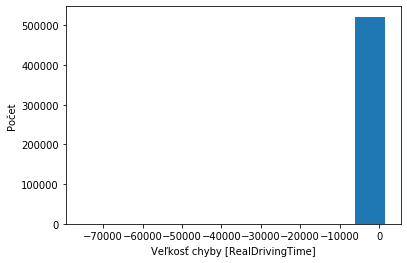

------Presnosť na FILTER3 dátach-------- 
Testing set Mean Abs Error: 58.91 RealDrivingTime 
Testing set Mean Sqrt Error: 8289.70 RealDrivingTime 
Testing set Root Mean Sqrt Error: 91.05 RealDrivingTime 


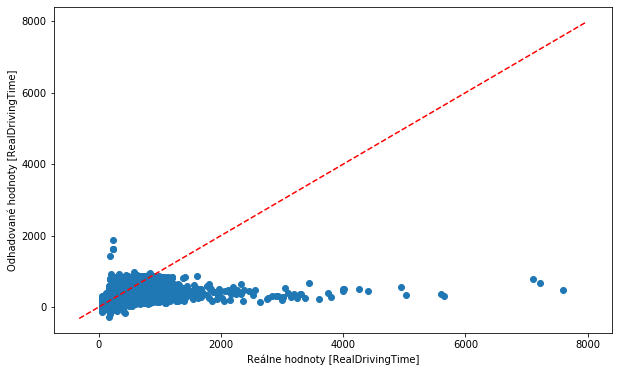

Najväčšia chyba:1647.55908203125
Najväčšia chyba v zápornom smere:-7115.89501953125
% približne správnych odhadov: 0.8747633985483669


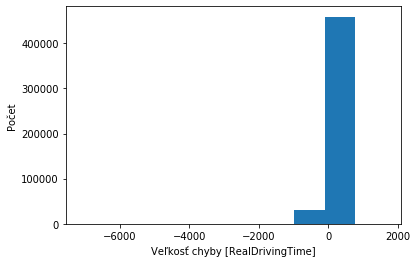

In [57]:
CreateAndFitModel("FILTER2", 0.001, 120, "FILTER2ModelSETT",SETTFILTER2)

-----------------------------FILTER3---------------------------------
Veľkosť trénovacej množniy: (1954766, 23)
Veľkosť testovacej množniy: (488691, 23)

....................
....................
....................
....................
....................
....................
....................
..........

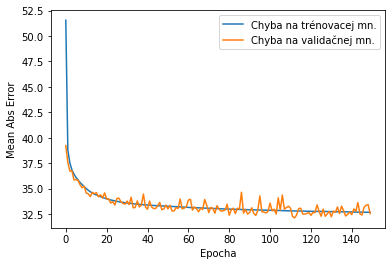

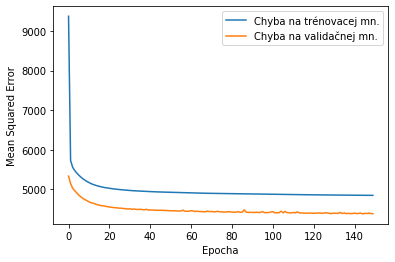

------Presnosť na BASE dátach-------- 
Testing set Mean Abs Error: 114.80 RealDrivingTime 
Testing set Mean Sqrt Error: 1766593.62 RealDrivingTime 
Testing set Root Mean Sqrt Error: 1329.13 RealDrivingTime 


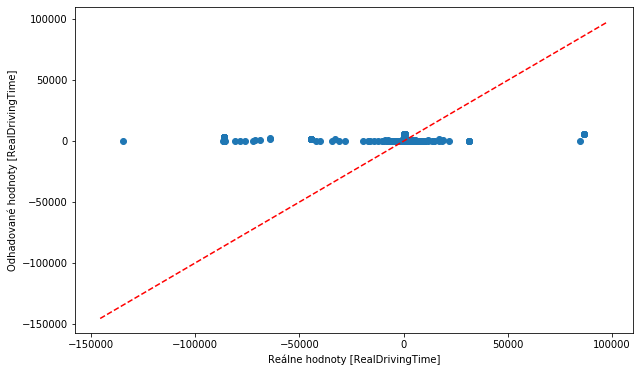

Najväčšia chyba:134828.734375
Najväčšia chyba v zápornom smere:-84614.9296875
% približne správnych odhadov: 0.7720148382995502


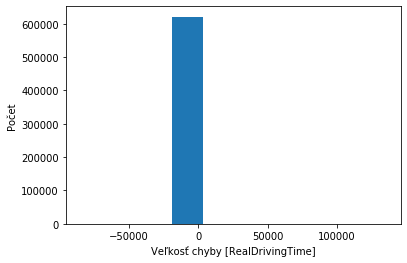

------Presnosť na FILTER1 dátach-------- 
Testing set Mean Abs Error: 45.38 RealDrivingTime 
Testing set Mean Sqrt Error: 26984.25 RealDrivingTime 
Testing set Root Mean Sqrt Error: 164.27 RealDrivingTime 


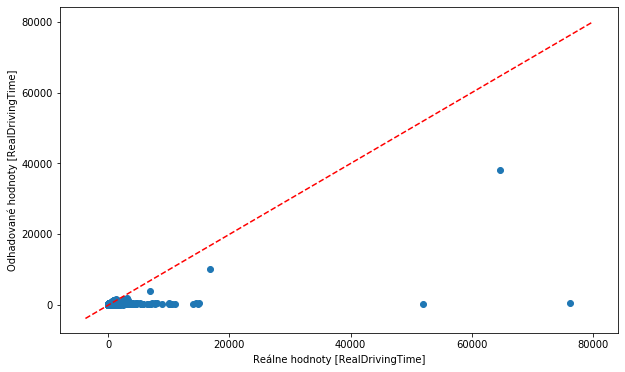

Najväčšia chyba:645.7572021484375
Najväčšia chyba v zápornom smere:-75589.8359375
% približne správnych odhadov: 0.9345563686125091


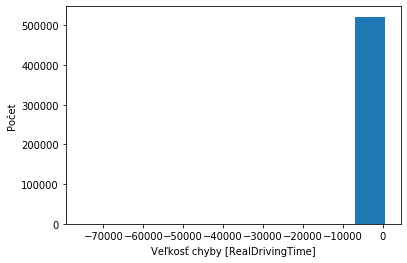

------Presnosť na FILTER2 dátach-------- 
Testing set Mean Abs Error: 43.76 RealDrivingTime 
Testing set Mean Sqrt Error: 25822.07 RealDrivingTime 
Testing set Root Mean Sqrt Error: 160.69 RealDrivingTime 


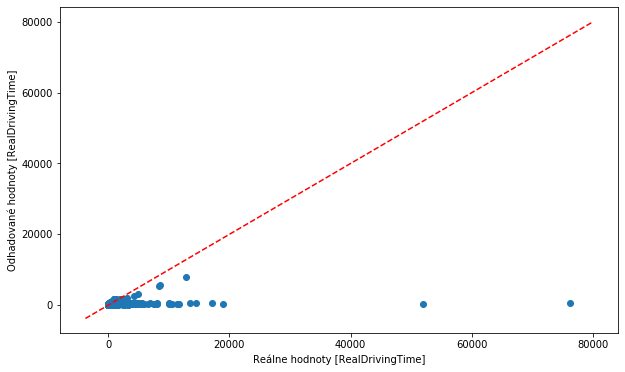

Najväčšia chyba:725.8443603515625
Najväčšia chyba v zápornom smere:-75583.0390625
% približne správnych odhadov: 0.944065165309056


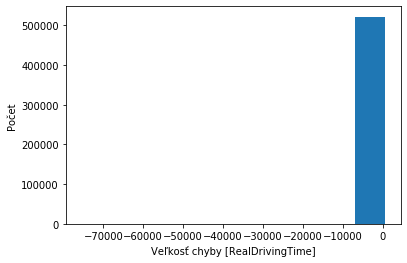

------Presnosť na FILTER3 dátach-------- 
Testing set Mean Abs Error: 32.48 RealDrivingTime 
Testing set Mean Sqrt Error: 4313.37 RealDrivingTime 
Testing set Root Mean Sqrt Error: 65.68 RealDrivingTime 


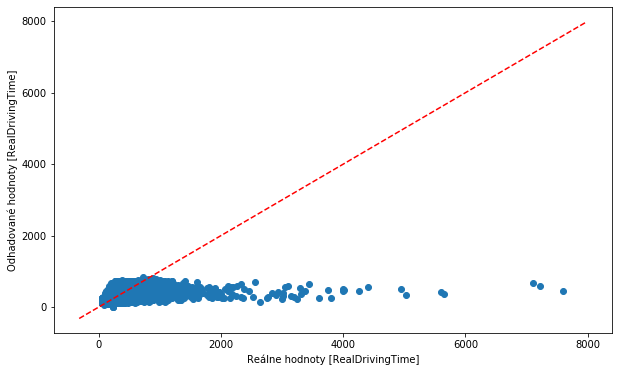

Najväčšia chyba:455.6697998046875
Najväčšia chyba v zápornom smere:-7151.376953125
% približne správnych odhadov: 0.9642616704625213


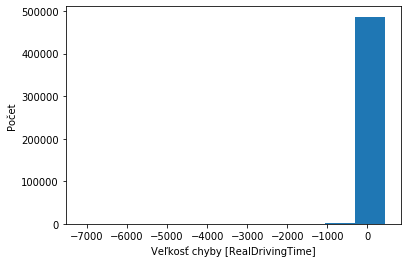

In [59]:
CreateAndFitModel("FILTER3", 0.0001, 120, "FILTER3ModelSETT",SETTFILTER3)

# Úvaha
Uvedomujem si, že nejväčším vplyvom na reálnu jazdnú dobu má práve plánovaná doba trasy, keďže v ideálnom prípade, sa reálna jazdná doba zhoduje s plánovanou. Vtedy môže nastať situácia, že model bude odhadovať jazdnú dobu iba tým, že vyhlási, že úsek nemá žiadne meškanie, a štatistiky modelu by preukázali, že tento model nieje veľmi nepresný. Preto ak chcem skúmať vplyv vlastností ako ročné obdobie, alebo obdobie dňa tak sa musím sledovať inú premennú. Na začiatok by sme mali sledovať vplyv vlastností na meškanie, ktoré vypočítame ako RealDrivingTime - PlanDrivingTime. Už teraz tuším, že najväčší vplyv na veľkosť meškania bude mať časová dĺžka trasy, pretože na dhlších tratiach sa meškania akumulujú rýchlejšie. Preto našu sledovanú premennú uvediem ako pomer meškania k časovej dĺžke trasy. Pri vypočítaní týchto meškaní potom jednoducho získame jazdné doby vynásobením premennou PlanDrivingTime a jej pripočítaním. 

- DelayDiff = Rozdiel medzi reálnym trvaním trasy a plánovaným trvaním trasy
    - DelayDiff = RealDrivingTime - PlanDrivingTime
- DelayDiffPercent = podiel meškania ku plánovanému časovému trvaniu trasy
    - DelayDiffPercent = DelayDiff / PlanDrivingTime

In [107]:
def getDrivingTime(a,b):  
    return a * b + b

# Test 1 Alternatíva skúmanie vplyvu parametrov vlaku na jeho meškanie v pomere k plánovanému trvaniu trasy

In [49]:
test1Alt = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDeparture',
         'DelayDiffPercent']

In [50]:
used_attributes = test1Alt
label = used_attributes[-1]

koreláčná matica ukazuje veľmi malý lineárny vplyv atribútov na meškanie.

In [51]:
print(used_attributes)
dffcut = df[used_attributes]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDeparture', 'DelayDiffPercent']
DelayDiffPercent    1.000000
CarCount            0.071952
AxisCount           0.070630
Weight              0.069227
Length              0.062288
DelayDeparture      0.043824
LengthSect          0.002520
SectIdx            -0.069227
PlanDrivingTime    -0.113058
Name: DelayDiffPercent, dtype: float64


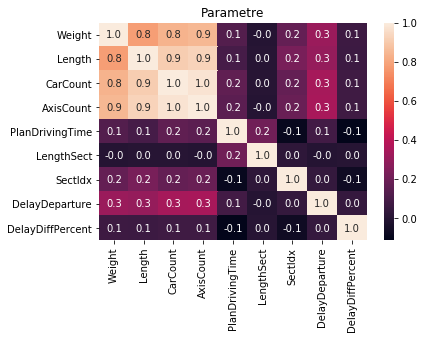

In [52]:
plt.title("Parametre")
sns.heatmap(cor, annot = True, fmt='.1f')    
plt.show()

In [53]:
dffcut = df[used_attributes]

train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset) 

(2221186, 8)
(555297, 8)


In [54]:
test1AltModel = build_model()
print(test1AltModel.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________
None


In [55]:
test1AltModelFit = test1AltModel.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop, PrintDot()])


......................

In [100]:
def plot_history_Percent(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [' + label + ']')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label='Val Error')
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error [$' + label + '^2$]')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label='Val Error')
    plt.legend()

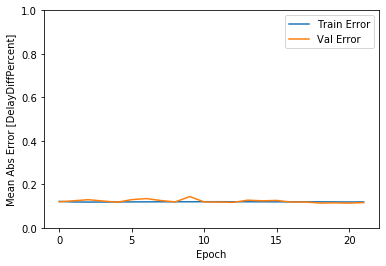

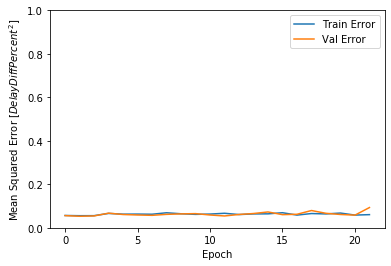

In [57]:
plot_history_Percent(test1AltModelFit, train_dataset['PlanDrivingTime'])

Použijem upravenú metódu eval ktorá prevedie meškanie na reálnu jazdnú dobu. 

In [99]:
import math
def eval_Percent(errors):
    
    # mae
    mae = sum(abs(errors)) / len(errors)
    print("MAE:")
    print(mae)
    # mse, loss 
    mse = sum(np.square(errors)) / len(errors)
    print("MSE:")
    print(mse)
    # RMSE 
    rmse = math.sqrt(mse)
    print("RMSE:")  
    print(rmse)

## Vyhodnotenie
Vidím, že sledovanie novej premennej zatiaľ základnému modelu nijak nepomohol. Keď sa pozriem na vlastnosti úsekov v ktorých sa model najviac zmýlil, tak vídím, že vlastnosť ktorá výrazne vyčnieva od ostatných je doterajšie meškani v sekundách. Model sa snaží generalizovať, a preto pri vysokých doterajších meškaniach lineárne zvyšuje meškanie. Preto túto vlastnosť odstánime.

In [59]:
test_predictions = test1AltModel.predict(normed_test_data).flatten()

In [60]:
inter = getDrivingTime(test_predictions,test_dataset['PlanDrivingTime'])
inter_real = getDrivingTime(test_labels,test_dataset['PlanDrivingTime'])

In [61]:
errors = inter - inter_real

In [62]:
eval_Percent(errors.values)

MAE:
37.22108314366366
MSE:
921196.8385197944
RMSE:
959.7899970930071


In [65]:
eval(test1AltModel)

Testing set Loss :  0.07 RealDrivingTime
Testing set Mean Abs Error:  0.12 RealDrivingTime
Testing set Mean Sqrt Error:  0.07 RealDrivingTime
Testing set Root Mean Sqrt Error:  0.26 RealDrivingTime


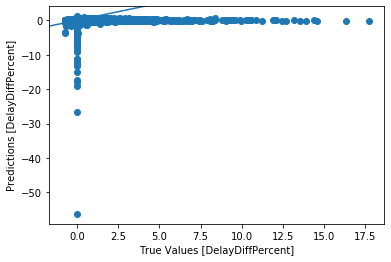

In [66]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
#plt.axis('equal')
#plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

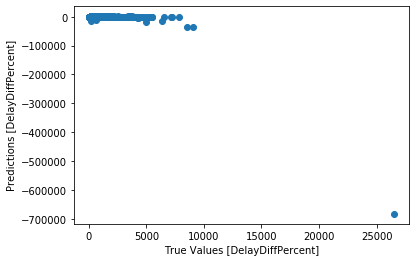

In [67]:
plt.scatter(getDrivingTime(test_labels, test_dataset['PlanDrivingTime']), getDrivingTime(test_predictions,  test_dataset['PlanDrivingTime']))
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
#plt.axis('equal')
#plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

In [68]:
big = errors[(abs(errors.values) > 3000)]

In [69]:
for key, value in big.items():
    print("Odhad: " + str(inter[key]),"Planovana hodnota: " + str(test_dataset['PlanDrivingTime'][key]), "Realna hodnota: " + str(test_dataset['PlanDrivingTime'][key] * test_labels[key] + test_dataset['PlanDrivingTime'][key]))
    print(test_dataset.loc[key])
    print("\n")
    

Odhad: -1312.0093 Planovana hodnota: 2610 Realna hodnota: 2610.0
Weight               85.0
Length               18.0
CarCount              1.0
AxisCount             4.0
PlanDrivingTime    2610.0
LengthSect           33.0
SectIdx               0.0
DelayDeparture     9540.0
Name: 210173, dtype: float64


Odhad: -2297.6323 Planovana hodnota: 2610 Realna hodnota: 2610.0
Weight               614.0
Length               331.0
CarCount              17.0
AxisCount             68.0
PlanDrivingTime     2610.0
LengthSect            33.0
SectIdx                0.0
DelayDeparture     41100.0
Name: 213102, dtype: float64


Odhad: -2345.2236 Planovana hodnota: 2610 Realna hodnota: 2610.0
Weight              1314.0
Length               322.0
CarCount              17.0
AxisCount             68.0
PlanDrivingTime     2610.0
LengthSect            33.0
SectIdx                0.0
DelayDeparture     40380.0
Name: 216922, dtype: float64


Odhad: 526.7746 Planovana hodnota: 480 Realna hodnota: 4054.0
Weight    

Najväčšia chyba:617.975341796875
Najväčšia chyba v zápornom smere:-708795.6875
% chýb menších ako 2 minúty: 0.9502104279331601


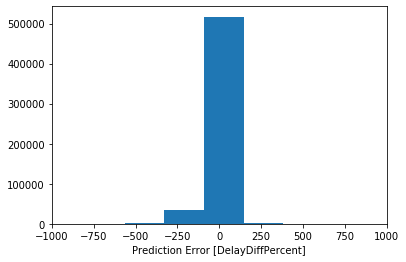

In [70]:
#error = test_predictions - test_labels
error = errors.values

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=3000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1000,1000])
plt.show()
#_ = plt.ylabel("Count")

# Upravený Alternatívny Test 1 - bez doterajšieho meškania v sekundách
- Očakávam, že vyradenie tohoto atribútu aspoň trochu pomôže presnosti modelu, ktorý už nebude pri veľkých doterajších meškaniach ukazovať veľkú chybu

In [87]:
test1Alt = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 
         'DelayDiffPercent']

In [88]:
used_attributes = test1Alt
label = used_attributes[-1]

koreláčná matica ukazuje veľmi malý lineárny vplyv atribútov na meškanie.

In [89]:
print(used_attributes)
dffcut = DFFILTER1[used_attributes]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDiffPercent']
DelayDiffPercent    1.000000
CarCount            0.050811
AxisCount           0.050112
Weight              0.048508
Length              0.043778
LengthSect          0.000214
SectIdx            -0.048379
PlanDrivingTime    -0.079763
Name: DelayDiffPercent, dtype: float64


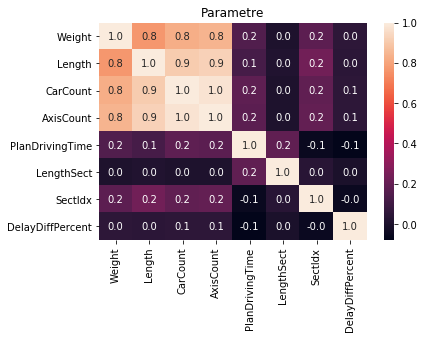

In [90]:
plt.title("Parametre")
sns.heatmap(cor, annot = True, fmt='.1f')    
plt.show()

In [91]:
train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset) 

(2087046, 7)
(521762, 7)


In [168]:
def build_model(lr=0.001):
    model = keras.Sequential([
        layers.Dense(32, activation=tf.nn.relu, input_shape=[len(normed_train_data.keys())]),
        layers.Dense(32, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(lr)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae','mse'])
    return model

In [93]:
test1AltModel = build_model()
print(test1AltModel.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                256       
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________
None


In [97]:
test1AltModelFit = test1AltModel.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop,save_best_model("FILTER1DDModel1.h5"), PrintDot()])


....................
....

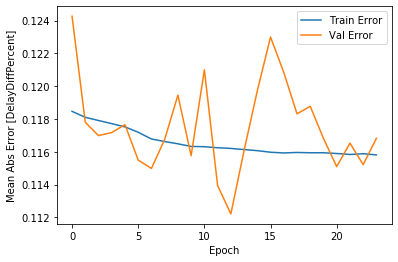

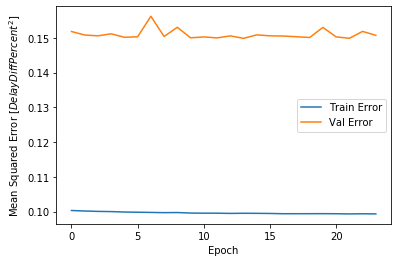

In [102]:
plot_history_Percent(test1AltModelFit)

## Vyhodnotenie
Vyradenie DelayDeparture výrazne pomohlo, ale stále môj model neukazuje lepšie výsledky ako pôvodný model. Skúsim teda zaviesť filtre ktoré som použil na pôvodnom modeli a uvidím rozdiel vo vplyve.

In [104]:
test1AltModel = load_model("FILTER1DDModel1.h5")

In [105]:
test_predictions = test1AltModel.predict(normed_test_data).flatten()

In [108]:
inter = getDrivingTime(test_predictions,test_dataset['PlanDrivingTime'])
inter_real = getDrivingTime(test_labels,test_dataset['PlanDrivingTime'])

In [109]:
errors = inter - inter_real

In [110]:
eval_Percent(errors.values)

MAE:
36.340614529833765
MSE:
155911.0096464338
RMSE:
394.8556820490669


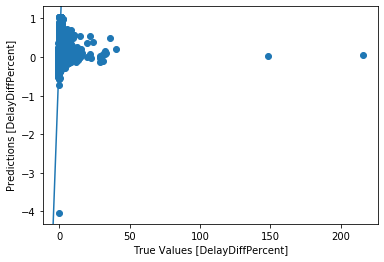

In [111]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
#plt.axis('equal')
#plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

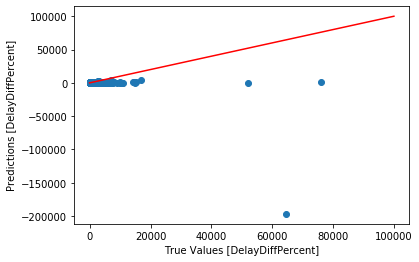

In [116]:
plt.scatter(getDrivingTime(test_labels, test_dataset['PlanDrivingTime']), getDrivingTime(test_predictions,  test_dataset['PlanDrivingTime']))
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
#plt.axis('equal')
#plt.axis('square')
#plt.xlim([plt.xlim()[0],plt.xlim()[1]])
#plt.ylim([plt.ylim()[0],plt.ylim()[1]])
plt.plot([-100,100000],[-100,100000],'r')
plt.show()

In [117]:
big = errors[(abs(errors.values) > 3000)]

In [118]:
for key, value in big.items():
    print("Odhad: " + str(inter[key]),"Planovana hodnota: " + str(test_dataset['PlanDrivingTime'][key]), "Realna hodnota: " + str(test_dataset['PlanDrivingTime'][key] * test_labels[key] + test_dataset['PlanDrivingTime'][key]))
    print(test_dataset.loc[key])
    print("\n")
    

Odhad: 518.06476 Planovana hodnota: 510 Realna hodnota: 76133.0
Weight             879.0
Length             444.0
CarCount            33.0
AxisCount          132.0
PlanDrivingTime    510.0
LengthSect          12.0
SectIdx              2.0
Name: 47006, dtype: float64


Odhad: 381.89008 Planovana hodnota: 360 Realna hodnota: 5466.0
Weight             1438.0
Length              611.0
CarCount             37.0
AxisCount           147.0
PlanDrivingTime     360.0
LengthSect           79.0
SectIdx               7.0
Name: 144998, dtype: float64


Odhad: 356.5903 Planovana hodnota: 360 Realna hodnota: 5679.0
Weight             673.0
Length             504.0
CarCount            18.0
AxisCount           72.0
PlanDrivingTime    360.0
LengthSect          79.0
SectIdx              7.0
Name: 180428, dtype: float64


Odhad: 524.12744 Planovana hodnota: 480 Realna hodnota: 4552.0
Weight             1970.0
Length              642.0
CarCount             39.0
AxisCount           154.0
PlanDrivingTime     

Najväčšia chyba:814.822998046875
Najväčšia chyba v zápornom smere:-261540.53125
% chýb menších ako 2 minúty: 0.9556656099907621


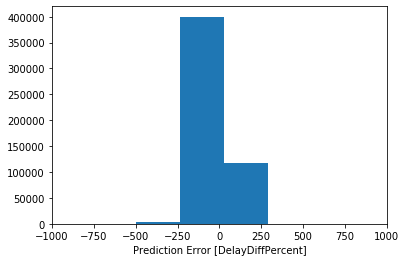

In [119]:
#error = test_predictions - test_labels
error = errors.values

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1000,1000])
plt.show()
#_ = plt.ylabel("Count")

# Test 2 Alternatíva - skúmanie vplyvu typu vlaku na percento meškania


In [90]:
test2Alt = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx',
         'Ex', 'Mn', 'Nex', 'Os', 'Pn', 'R', 'Sluz', 'Sp', 'Sv', 'Vlec',
         'DelayDiffPercent']

In [91]:
used_attributes = test2Alt
label = used_attributes[-1]

Vidím, že teraz majú jednotlivé typy nižšiu koreláciu, čo je však v poriadku. V predošlých pokusoch vyššia korelácia znamenala, že isté typy vlakov majú dlhšie reálne jazdné doby, čo môže znamenať to, že aj ich plánované jazdné doby sú dlhé. Napríklad nákladné vlaky a rýchliky ukazovali vyššiu koreláciu, pretože nákladné vlaky jazdia často dlhé trate bez zastávok, zatiaľ čo rýchliky sú rýchlejšie a majú v trase mnoho zastávok. Teraz model ukazuje vplyv typu vlaku na meškanie a vidím, že nákladné vlaky na svojej trase viac meškajú ako iné vlaky. Naopak rýchliky a expresy málokedy meškajú.

In [92]:
type = df['TrainType']
for train_type in train_types:
    df[train_type] = (type == train_type)*1.0

In [93]:
cor_vlastnosti = train_types.copy()
cor_vlastnosti.append(label)
print(cor_vlastnosti)

dffcut = df[cor_vlastnosti]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

['Ex', 'Mn', 'Nex', 'Os', 'Pn', 'R', 'Sluz', 'Sp', 'Sv', 'Vlec', 'DelayDiffPercent']
DelayDiffPercent    1.000000
Pn                  0.065619
Os                  0.019558
Sluz                0.008031
Nex                 0.004540
Sv                 -0.004536
Sp                 -0.005439
Mn                 -0.017532
Vlec               -0.033671
Ex                 -0.040693
R                  -0.050080
Name: DelayDiffPercent, dtype: float64


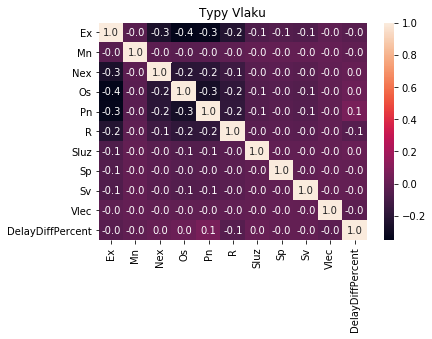

In [94]:
plt.title("Typy Vlaku")
sns.heatmap(cor, annot = True, fmt='.1f')    
plt.show()

In [95]:
dffcut = df[used_attributes]

train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

print(train_stats.describe())
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
print(normed_train_data.describe())   

(2221186, 17)
(555297, 17)
           count        mean         std        min         25%         50%  \
count       17.0   17.000000   17.000000  17.000000   17.000000   17.000000   
mean   2221186.0   73.778618   58.545193   5.470588   33.235294   56.294118   
std          0.0  161.078441  142.001233  20.763904   73.109105  118.246969   
min    2221186.0    0.000952    0.030843   0.000000    0.000000    0.000000   
25%    2221186.0    0.012555    0.111342   0.000000    0.000000    0.000000   
50%    2221186.0    0.219984    0.414235   0.000000    0.000000    0.000000   
75%    2221186.0   46.146443   36.411201   1.000000   12.000000   28.000000   
max    2221186.0  592.213798  567.140111  86.000000  224.000000  392.000000   

              75%           max  
count   17.000000     17.000000  
mean    94.882353   5462.000000  
std    199.959334  20979.582792  
min      0.000000      1.000000  
25%      0.000000      1.000000  
50%      0.000000      1.000000  
75%     76.000000    11

In [96]:
test2AltModel = build_model()
print(test2AltModel.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                1152      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________
None


In [97]:
test2AltModelFit = test2AltModel.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop, PrintDot()])


.................................

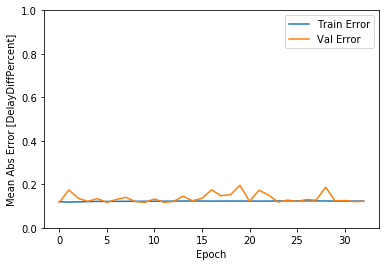

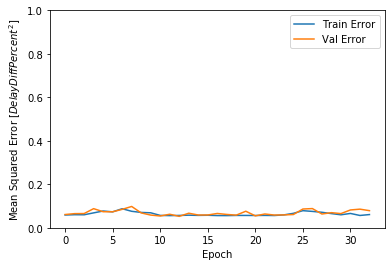

In [98]:
plot_history_Percent(test2AltModelFit, train_dataset['PlanDrivingTime'])

## Vyhodnotenie


In [99]:
test_predictions = test2AltModel.predict(normed_test_data).flatten()

In [100]:
inter = getDrivingTime(test_predictions,test_dataset['PlanDrivingTime'])
inter_real = getDrivingTime(test_labels,test_dataset['PlanDrivingTime'])

In [101]:
errors = inter - inter_real

In [102]:
eval_Percent(errors)

MAE:
40.46055956016179
MSE:
2426557.7501240005
RMSE:
1557.741233364515


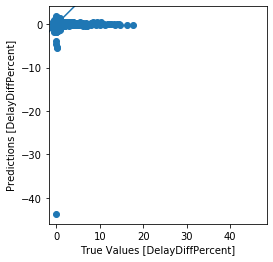

In [103]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

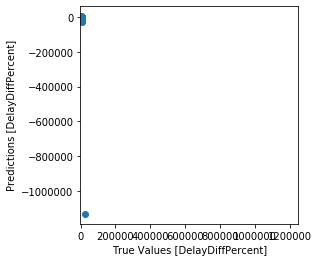

In [104]:
plt.scatter(getDrivingTime(test_labels, test_dataset['PlanDrivingTime']), getDrivingTime(test_predictions,  test_dataset['PlanDrivingTime']))
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

Najväčšia chyba:1484.97998046875
Najväčšia chyba v zápornom smere:-1157913.5
% chýb menších ako 2 minúty: 0.9471562064985044


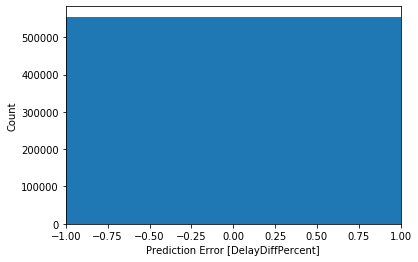

In [105]:
#error = test_predictions - test_labels
error = errors

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1,1])
_ = plt.ylabel("Count")

# Test 3 Alternatíva - skúmanie vplyvu ročného obdobia na percento meškania


In [106]:
test3Alt = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx',
         'Jar','Leto', 'Jesen', 'Zima',
         'DelayDiffPercent']

In [107]:
used_attributes = test3Alt
label = used_attributes[-1]

Vidím, že teraz majú jednotlivé typy nižšiu koreláciu, čo je však v poriadku. V predošlých pokusoch vyššia korelácia znamenala, že isté typy vlakov majú dlhšie reálne jazdné doby, čo môže znamenať to, že aj ich plánované jazdné doby sú dlhé. Napríklad nákladné vlaky a rýchliky ukazovali vyššiu koreláciu, pretože nákladné vlaky jazdia často dlhé trate bez zastávok, zatiaľ čo rýchliky sú rýchlejšie a majú v trase mnoho zastávok. Teraz model ukazuje vplyv typu vlaku na meškanie a vidím, že nákladné vlaky na svojej trase viac meškajú ako iné vlaky. Naopak rýchliky a expresy málokedy meškajú.

In [108]:
type = df['Season']
for season_type in season_types:
    df[season_type] = (type == season_type)*1.0

In [109]:
cor_vlastnosti = season_types.copy()
cor_vlastnosti.append(label)
print(cor_vlastnosti)

dffcut = df[cor_vlastnosti]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

['Jar', 'Leto', 'Jesen', 'Zima', 'DelayDiffPercent']
DelayDiffPercent    1.000000
Jesen               0.021465
Jar                -0.005363
Leto               -0.007009
Zima               -0.010482
Name: DelayDiffPercent, dtype: float64


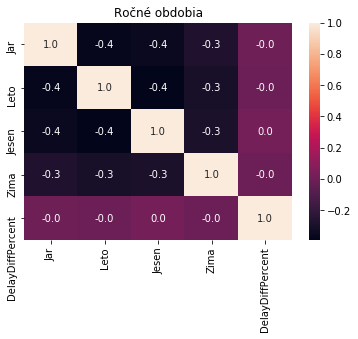

In [110]:
plt.title("Ročné obdobia")
sns.heatmap(cor, annot = True, fmt='.1f')    
plt.show()

In [111]:
dffcut = df[used_attributes]

train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

print(train_stats.describe())
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
print(normed_train_data.describe())   

(2221186, 11)
(555297, 11)
           count        mean         std        min         25%         50%  \
count       11.0   11.000000   11.000000  11.000000   11.000000   11.000000   
mean   2221186.0  114.021500   90.424539   8.454545   51.363636   87.000000   
std          0.0  190.962347  170.574078  25.730774   86.762057  139.403013   
min    2221186.0    0.183892    0.387396   0.000000    0.000000    0.000000   
25%    2221186.0    0.282046    0.449908   0.000000    0.000000    0.000000   
50%    2221186.0   11.438174   10.262214   1.000000    4.000000    7.000000   
75%    2221186.0  141.444981  102.793034   1.500000   57.000000  113.500000   
max    2221186.0  592.213798  567.140111  86.000000  224.000000  392.000000   

              75%           max  
count   11.000000     11.000000  
mean   146.818182   8440.727273  
std    235.727732  26011.055731  
min      0.000000      1.000000  
25%      1.000000      1.000000  
50%     19.000000     78.000000  
75%    208.000000    64

In [112]:
test3AltModel = build_model()
print(test3AltModel.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                768       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________
None


In [113]:
test3AltModelFit = test3AltModel.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop, PrintDot()])


...............................

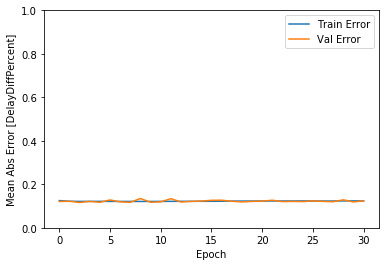

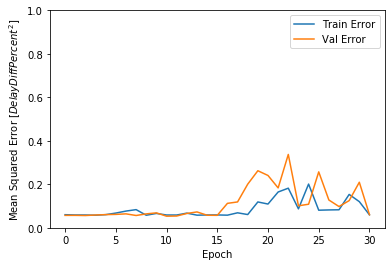

In [114]:
plot_history_Percent(test3AltModelFit, train_dataset['PlanDrivingTime'])

## Vyhodnotenie


In [115]:
test_predictions = test3AltModel.predict(normed_test_data).flatten()

In [116]:
inter = getDrivingTime(test_predictions,test_dataset['PlanDrivingTime'])
inter_real = getDrivingTime(test_labels,test_dataset['PlanDrivingTime'])

In [117]:
errors = inter - inter_real

In [118]:
eval_Percent(errors)

MAE:
39.65405120903742
MSE:
314273.0469448312
RMSE:
560.600612686814


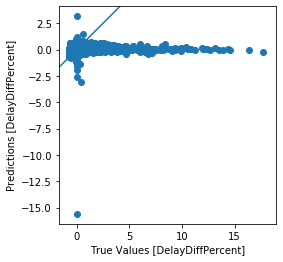

In [119]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

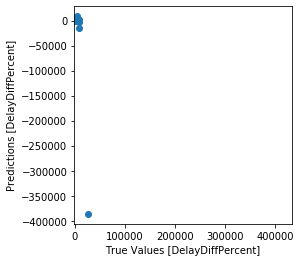

In [120]:
plt.scatter(getDrivingTime(test_labels, test_dataset['PlanDrivingTime']), getDrivingTime(test_predictions,  test_dataset['PlanDrivingTime']))
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

Najväčšia chyba:3632.3544921875
Najväčšia chyba v zápornom smere:-412940.71875
% chýb menších ako 2 minúty: 0.944622427277655


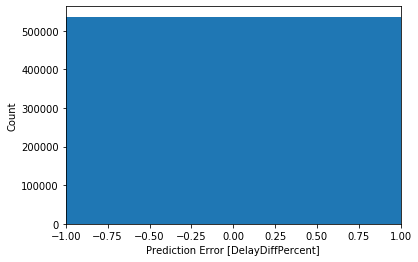

In [121]:
#error = test_predictions - test_labels
error = errors

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1,1])
_ = plt.ylabel("Count")

# Test 4 Alternatíva - skúmanie vplyvu obdobia dňa na percento meškania


In [122]:
test4Alt = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx',
         'Rano', 'Obed', 'Vecer', 'Noc',
         'DelayDiffPercent']

In [123]:
used_attributes = test4Alt
label = used_attributes[-1]

Vidím, že teraz majú jednotlivé typy nižšiu koreláciu, čo je však v poriadku. V predošlých pokusoch vyššia korelácia znamenala, že isté typy vlakov majú dlhšie reálne jazdné doby, čo môže znamenať to, že aj ich plánované jazdné doby sú dlhé. Napríklad nákladné vlaky a rýchliky ukazovali vyššiu koreláciu, pretože nákladné vlaky jazdia často dlhé trate bez zastávok, zatiaľ čo rýchliky sú rýchlejšie a majú v trase mnoho zastávok. Teraz model ukazuje vplyv typu vlaku na meškanie a vidím, že nákladné vlaky na svojej trase viac meškajú ako iné vlaky. Naopak rýchliky a expresy málokedy meškajú.

In [124]:
type = df['DayTime']
for daytime_type in daytime_types:
    df[daytime_type] = (type == daytime_type)*1.0

In [125]:
cor_vlastnosti = daytime_types.copy()
cor_vlastnosti.append(label)
print(cor_vlastnosti)

dffcut = df[cor_vlastnosti]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

['Rano', 'Obed', 'Vecer', 'Noc', 'DelayDiffPercent']
DelayDiffPercent    1.000000
Rano                0.007800
Obed                0.001822
Vecer              -0.003652
Noc                -0.006911
Name: DelayDiffPercent, dtype: float64


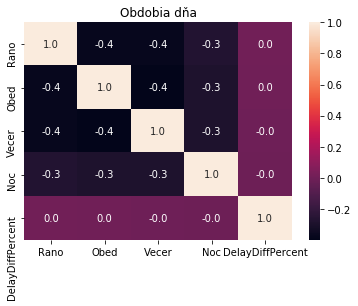

In [126]:
plt.title("Obdobia dňa")
sns.heatmap(cor, annot = True, fmt='.1f')    
plt.show()

In [127]:
dffcut = df[used_attributes]

train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

print(train_stats.describe())
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
print(normed_train_data.describe())   

(2221186, 11)
(555297, 11)
           count        mean         std        min         25%         50%  \
count       11.0   11.000000   11.000000  11.000000   11.000000   11.000000   
mean   2221186.0  114.021500   90.424147   8.454545   51.363636   87.000000   
std          0.0  190.962347  170.574306  25.730774   86.762057  139.403013   
min    2221186.0    0.169953    0.375592   0.000000    0.000000    0.000000   
25%    2221186.0    0.285018    0.451422   0.000000    0.000000    0.000000   
50%    2221186.0   11.438174   10.262214   1.000000    4.000000    7.000000   
75%    2221186.0  141.444981  102.793034   1.500000   57.000000  113.500000   
max    2221186.0  592.213798  567.140111  86.000000  224.000000  392.000000   

              75%           max  
count   11.000000     11.000000  
mean   146.818182   8440.727273  
std    235.727732  26011.055731  
min      0.000000      1.000000  
25%      1.000000      1.000000  
50%     19.000000     78.000000  
75%    208.000000    64

In [128]:
test4AltModel = build_model()
print(test4AltModel.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                768       
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________
None


In [129]:
test4AltModelFit = test4AltModel.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop, PrintDot()])


.......................

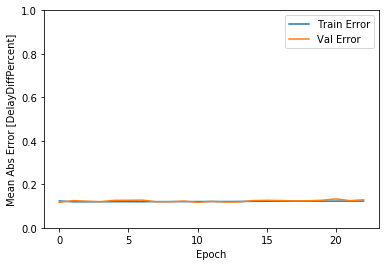

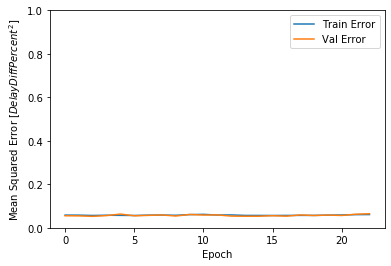

In [130]:
plot_history_Percent(test4AltModelFit, train_dataset['PlanDrivingTime'])

## Vyhodnotenie


In [132]:
test_predictions = test4AltModel.predict(normed_test_data).flatten()

In [133]:
inter = getDrivingTime(test_predictions,test_dataset['PlanDrivingTime'])
inter_real = getDrivingTime(test_labels,test_dataset['PlanDrivingTime'])

In [134]:
errors = inter - inter_real

In [135]:
eval_Percent(errors)

MAE:
41.52294867912508
MSE:
1053482.923705676
RMSE:
1026.3931623435906


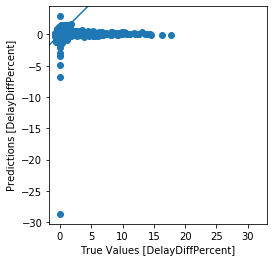

In [136]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

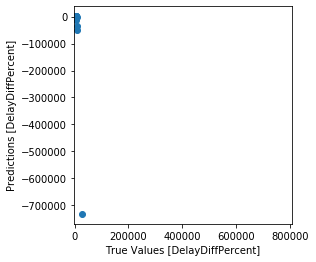

In [137]:
plt.scatter(getDrivingTime(test_labels, test_dataset['PlanDrivingTime']), getDrivingTime(test_predictions,  test_dataset['PlanDrivingTime']))
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

Najväčšia chyba:1035.176513671875
Najväčšia chyba v zápornom smere:-758740.25
% chýb menších ako 2 minúty: 0.9454922320848123


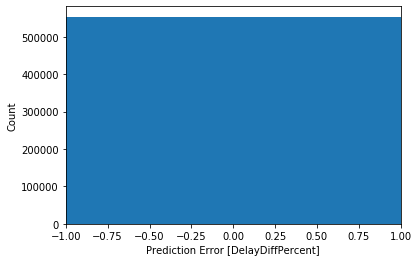

In [138]:
#error = test_predictions - test_labels
error = errors

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1,1])
_ = plt.ylabel("Count")

# Pridanie predošlých meškaní do modelu
Očakávam, že pridaním predošlých meškaní, bude model môcť využiť časový rad pre zlepšenie presnosti. Avšak bude mať obmedzenia z pohľadu úsekov, ktoré sú na začiatku trasy a teda nemajú predošlé meškanie.

In [28]:
casovy_rad = ['Ar1', 'Ar2', 'Ar3', 'Ar4', 'Ar5', 'Ar6', 'Ar7', 'Ar8', 'Ar9']
testCasovyRad = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx',
                 'Ar1', 'Ar2', 'Ar3', 'Ar4', 'Ar5', 'Ar6', 'Ar7', 'Ar8', 'Ar9', 
                 'DelayDiffPercent']

In [29]:
used_attributes = testCasovyRad
label = used_attributes[-1]

In [30]:
cor_vlastnosti = casovy_rad.copy()
cor_vlastnosti.append(label)
print(cor_vlastnosti)

dffcut = df[cor_vlastnosti]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

['Ar1', 'Ar2', 'Ar3', 'Ar4', 'Ar5', 'Ar6', 'Ar7', 'Ar8', 'Ar9', 'DelayDiffPercent']
DelayDiffPercent    1.000000
Ar1                 0.160644
Ar2                 0.054488
Ar3                 0.045771
Ar4                 0.022079
Ar6                 0.017665
Ar5                 0.014066
Ar8                 0.012634
Ar7                 0.008600
Ar9                -0.001929
Name: DelayDiffPercent, dtype: float64


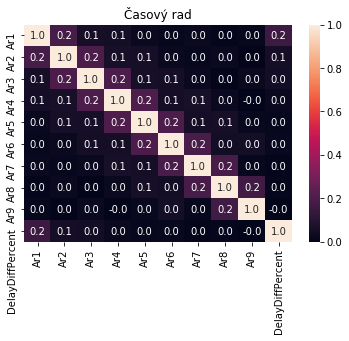

In [31]:
plt.title("Časový rad")
sns.heatmap(cor, annot = True, fmt='.1f')    
plt.show()

In [32]:
dffcut = df[used_attributes]

train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

print(train_stats.describe())
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
print(normed_train_data.describe())   

(2221186, 16)
(555297, 16)
           count        mean         std        min         25%         50%  \
count       16.0   16.000000   16.000000  16.000000   16.000000   16.000000   
mean   2221186.0   78.332688   62.154619   5.398004   35.300099   59.812500   
std          0.0  165.227054  145.850636  21.518478   74.993094  121.202431   
min    2221186.0    0.007300    0.097431  -0.746032   -0.083333    0.000000   
25%    2221186.0    0.009922    0.167936  -0.741667   -0.001389    0.000000   
50%    2221186.0    0.011951    0.228012  -0.717949    0.000000    0.000000   
75%    2221186.0   48.908031   37.620664   1.000000   13.000000   34.250000   
max    2221186.0  592.213798  567.140111  86.000000  224.000000  392.000000   

              75%           max  
count   16.000000     16.000000  
mean   100.753971   5812.442448  
std    204.997919  21616.206463  
min      0.000000     15.950000  
25%      0.000000     17.100000  
50%      0.031766     18.382639  
75%     78.250000    16

In [33]:
testCasovyRadModel = build_model()
print(testCasovyRadModel.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1088      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,313
Trainable params: 5,313
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
testCasovyRadFit = testCasovyRadModel.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop, PrintDot()])


.......................

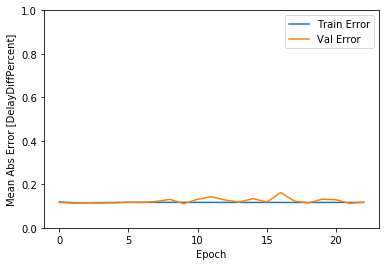

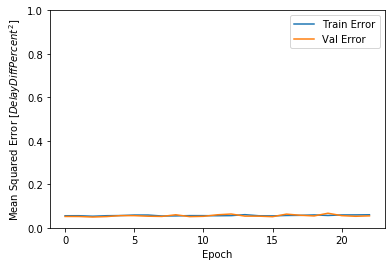

In [37]:
plot_history_Percent(testCasovyRadFit, train_dataset['PlanDrivingTime'])

## Vyhodnotenie


In [38]:
test_predictions = testCasovyRadModel.predict(normed_test_data).flatten()

In [41]:
inter = getDrivingTime(test_predictions,test_dataset['PlanDrivingTime'])
inter_real = getDrivingTime(test_labels,test_dataset['PlanDrivingTime'])

In [42]:
errors = inter - inter_real

In [45]:
eval_Percent(errors)

MAE:
36.67511922299004
MSE:
203050.12192479693
RMSE:
450.61083201005823


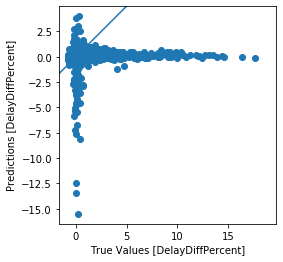

In [46]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

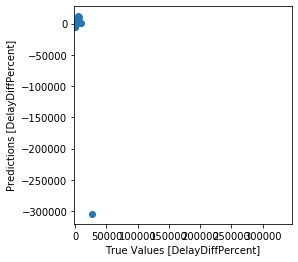

In [47]:
plt.scatter(getDrivingTime(test_labels, test_dataset['PlanDrivingTime']), getDrivingTime(test_predictions,  test_dataset['PlanDrivingTime']))
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

Najväčšia chyba:6673.548828125
Najväčšia chyba v zápornom smere:-330924.5625
% chýb menších ako 2 minúty: 0.9558416487033066


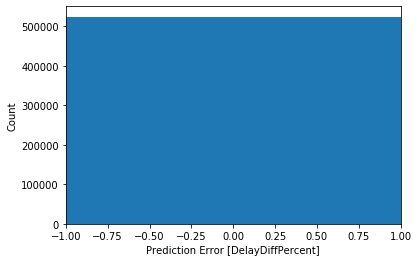

In [48]:
#error = test_predictions - test_labels
error = errors

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1000,1000])
_ = plt.ylabel("Count")

# uprava iba na 2 posledne meskania

In [49]:
casovy_rad = ['Ar1', 'Ar2', 'Ar3', 'Ar4', 'Ar5', 'Ar6', 'Ar7', 'Ar8', 'Ar9']
testCasovyRad = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx',
                 'Ar1', 'Ar2',
                 'DelayDiffPercent']

In [50]:
used_attributes = testCasovyRad
label = used_attributes[-1]

In [52]:
cor_vlastnosti = ['Ar1', 'Ar2']
cor_vlastnosti.append(label)
print(cor_vlastnosti)

dffcut = df[cor_vlastnosti]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

['Ar1', 'Ar2', 'DelayDiffPercent']
DelayDiffPercent    1.000000
Ar1                 0.160644
Ar2                 0.054488
Name: DelayDiffPercent, dtype: float64


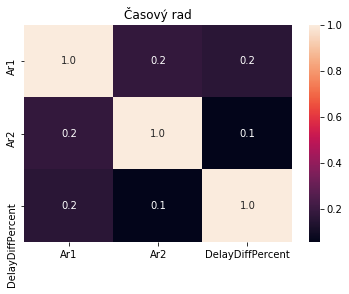

In [53]:
plt.title("Časový rad")
sns.heatmap(cor, annot = True, fmt='.1f')    
plt.show()

In [54]:
dffcut = df[used_attributes]

train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

print(train_stats.describe())
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
print(normed_train_data.describe())   

(2221186, 9)
(555297, 9)
           count        mean         std        min         25%         50%  \
count        9.0    9.000000    9.000000   9.000000    9.000000    9.000000   
mean   2221186.0  139.251137  110.378285  10.168034   62.761111  106.333333   
std          0.0  204.070435  184.135412  28.455242   92.767450  148.252319   
min    2221186.0    0.010502    0.215567  -0.746032   -0.083333    0.000000   
25%    2221186.0    3.569621    2.958493   0.000000    1.000000    3.000000   
50%    2221186.0   46.146443   36.411201   1.000000   12.000000   28.000000   
75%    2221186.0  225.697169  164.337015   2.000000   98.000000  174.000000   
max    2221186.0  592.213798  567.140111  86.000000  224.000000  392.000000   

              75%           max  
count    9.000000      9.000000  
mean   179.118170  10320.085031  
std    251.006507  28703.044536  
min      0.015385     17.902778  
25%      6.000000     19.000000  
50%     76.000000    111.000000  
75%    331.000000    973.

In [55]:
testCasovyRadModel2 = build_model()
print(testCasovyRadModel2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________
None


In [56]:
testCasovyRad2Fit = testCasovyRadModel2.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop, PrintDot()])


...............................

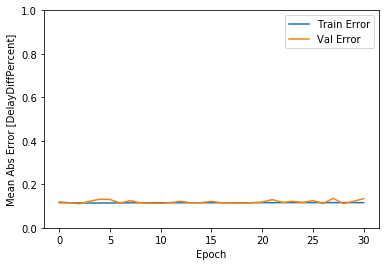

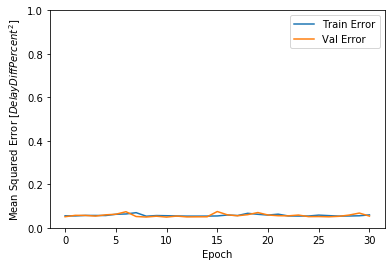

In [57]:
plot_history_Percent(testCasovyRad2Fit, train_dataset['PlanDrivingTime'])

## Vyhodnotenie


In [58]:
test_predictions = testCasovyRadModel2.predict(normed_test_data).flatten()

In [59]:
inter = getDrivingTime(test_predictions,test_dataset['PlanDrivingTime'])
inter_real = getDrivingTime(test_labels,test_dataset['PlanDrivingTime'])

In [60]:
errors = inter - inter_real

In [61]:
eval_Percent(errors)

MAE:
42.19376788292202
MSE:
79413.4725035644
RMSE:
281.80396112113897


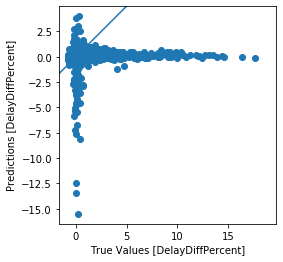

In [46]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

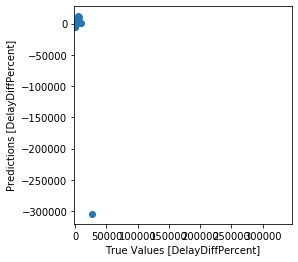

In [47]:
plt.scatter(getDrivingTime(test_labels, test_dataset['PlanDrivingTime']), getDrivingTime(test_predictions,  test_dataset['PlanDrivingTime']))
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

Najväčšia chyba:6673.548828125
Najväčšia chyba v zápornom smere:-330924.5625
% chýb menších ako 2 minúty: 0.9558416487033066


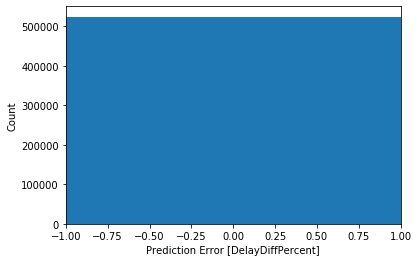

In [48]:
#error = test_predictions - test_labels
error = errors

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1,1])
_ = plt.ylabel("Count")

# Odhad parametrov vlaku na základe jeho jazdných dôb
Očakávam, že presnosť týchto modelov bude o niečo presnejšia, niektoré parametre sa často opakujú na istých trasách, a teda jediným faktor zostáva časová dĺžka trasy ktorá môže priamo rozhodnút o parametri. Avšak očakávam, že týmto dôjde aj k pretrénovaniu, a na validačnej množine nebude dosahovať dostatočne presné výsledky.

In [152]:
odhadParameters = []
dfPar = pd.DataFrame()

In [153]:
type = DFFILTER1['FromName']
for zastavka in DFFILTER1.FromName.unique():
    odhadParameters.append("From" + zastavka)
    dfPar["From" + zastavka] = (type == zastavka)*1.0

In [155]:
type = DFFILTER1['ToName']
for zastavka in DFFILTER1.ToName.unique():
    odhadParameters.append("To" + zastavka)
    dfPar["To" + zastavka] = (type == zastavka)*1.0

In [156]:
dfPar["RealDrivingTime"] = DFFILTER1["RealDrivingTime"]

In [157]:
odhadParameters.append("RealDrivingTime")

# Odhad počtu vagónov v súprave

In [158]:
dfPar['CarCount'] = DFFILTER1['CarCount']
label = 'CarCount'
used_attributes = odhadParameters.copy()
used_attributes.append('CarCount')

In [159]:
dffcut = dfPar[used_attributes]

cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

CarCount                 1.000000
RealDrivingTime          0.176910
ToPolom                  0.047551
FromPolom                0.047548
FromLipník nad Beèv.     0.029731
ToLipník nad Beèv.       0.029541
ToDrahotue              0.029394
FromDrahotue            0.029377
ToProsenice              0.029307
FromProsenice            0.029155
ToHranice na Mor.        0.027514
FromHranice na Mor.      0.026407
FromSuchdol nad Odr.     0.017403
ToSuchdol nad Odr.       0.015831
ToPøerov os.n.           0.013785
FromPøerov os.n.         0.012803
FromJistebník            0.008479
ToJistebník              0.008411
ToPolanka n. O.          0.006967
FromPolanka n. O.        0.003804
ToVýh Dluhonice          0.002204
FromVýh Dluhonice        0.002088
ToFulnek                -0.004601
FromFulnek              -0.004956
ToStudénka              -0.019935
FromStudénka            -0.022018
FromHranice mìsto       -0.025725
ToHranice mìsto         -0.030655
ToOstrava-Vítkovice     -0.033118
FromOstrava-Ví

In [35]:
train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
print(normed_train_data.describe())

(2067026, 44)
(516757, 44)
       FromOdb Skalka  FromOstrava-Svinov  FromPolanka n. O.  FromJistebník  \
count    2.067026e+06        2.067026e+06       2.067026e+06   2.067026e+06   
mean     6.187113e-15        1.022564e-14      -3.276275e-15   3.326076e-15   
std      1.000000e+00        1.000000e+00       1.000000e+00   1.000000e+00   
min     -1.455914e-01       -2.405279e-01      -3.064463e-01  -3.070316e-01   
25%     -1.455914e-01       -2.405279e-01      -3.064463e-01  -3.070316e-01   
50%     -1.455914e-01       -2.405279e-01      -3.064463e-01  -3.070316e-01   
75%     -1.455914e-01       -2.405279e-01      -3.064463e-01  -3.070316e-01   
max      6.868536e+00        4.157520e+00       3.263213e+00   3.256993e+00   

       FromStudénka  FromSuchdol nad Odr.     FromPolom  FromHranice na Mor.  \
count  2.067026e+06          2.067026e+06  2.067026e+06         2.067026e+06   
mean  -4.444105e-15         -6.402715e-15 -1.802550e-15        -1.070819e-15   
std    1.000000e+00  

In [53]:
testParModelCarCount0_01 = build_model(0.1)
#print(testParModelCarCount0_01.summary())

In [54]:
testParModelCarCountFit = testParModelCarCount0_01.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop,save_best_model("testParModelCarCount0_01.h5"), PrintDot()])


.............

In [76]:
#testParModel.save("CarCountModel.h5")

In [55]:
testmodel = load_model("testParModelCarCount0_01.h5")

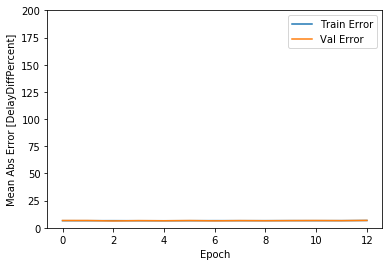

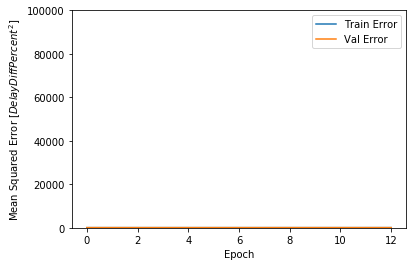

In [56]:
plot_history(testParModelCarCountFit)

In [57]:
eval(testmodel)

Testing set Loss : 78.79 RealDrivingTime
Testing set Mean Abs Error:  6.30 RealDrivingTime
Testing set Mean Sqrt Error: 78.79 RealDrivingTime
Testing set Root Mean Sqrt Error:  8.88 RealDrivingTime


## Vyhodnotenie
Pred Odstánením vlakov s jedným vagónom 
- Testing set Mean Abs Error:  6.04 RealDrivingTime
- Testing set Mean Sqrt Error: 70.75 RealDrivingTime
- Testing set Root Mean Sqrt Error:  8.41 RealDrivingTime

Po filtrácií
- Testing set Mean Abs Error:  5.88 RealDrivingTime
- Testing set Mean Sqrt Error: 69.18 RealDrivingTime
- Testing set Root Mean Sqrt Error:  8.32 RealDrivingTime

Model sa iba minimálne zlepšíl, ale hlavne z dôvodu, že sa naučil na dátach, ktoré už nemali chyby, a tým sa zameral na presné dáta, ktoré majú v niektorch prípadoch viac vagónov, a práve k týmto dátam, sa model priblížil.

Model však aj napriek tomu, nedokáže modelovať danú vlastnosť, a úspešne sa trafí iba v 57% prípadov, s odchýlkou 5 vagónov

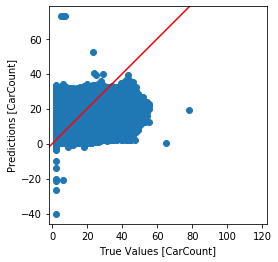

In [50]:
test_predictions = testmodel.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [CarCount]')
plt.ylabel('Predictions [CarCount]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100],'r')

Najväčšia chyba:67.81771850585938
Najväčšia chyba v zápornom smere:-64.58448028564453
% priblizne správnych: 0.5794270808136126


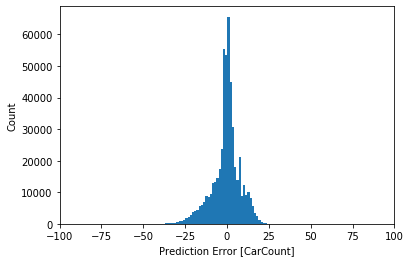

In [51]:
error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

goodPercent = error[abs(error) < 5] 
print("% priblizne správnych: " + str(len(goodPercent)/len(error)))

plt.hist(error, bins=100)
plt.xlabel('Prediction Error [CarCount]')
plt.xlim([-100,100])
_ = plt.ylabel("Count")

# Experiment - odhad počtu vagónov pomocou modelu vytvoreného pre daný úsek
Vybrané úseky  
    - Drahotuše -> Lipník nad Bečv. 
    - Ostrava-Svinov -> Polanka n. O.

In [160]:
dfPar['CarCount'] = DFFILTER1['CarCount']
label = 'CarCount'
used_attributes = ['RealDrivingTime', 'CarCount']

In [161]:
dffcut = dfPar[((dfPar['FromOstrava-Svinov'] == 1) & (dfPar['ToPolanka n. O.'] == 1))]
#dffcut = dfPar[((dfPar['FromDrahotue'] == 1) & (dfPar['ToLipník nad Beèv.'] == 1))]
dffcut = dffcut[used_attributes]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

print(dffcut.shape)

CarCount           1.000000
RealDrivingTime    0.218223
Name: CarCount, dtype: float64
(106504, 2)


Ako na prvý pohľad vidím, tak model nebude môcť odhadnúť z jazdnej doby počet vozňov, čo nám potvrdzuje ako korelácia, tak aj graf závislosti týchto dvoch vlastností.

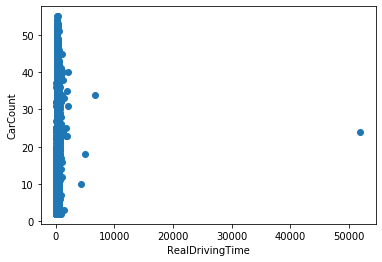

In [162]:
plt.scatter(dffcut['RealDrivingTime'],dffcut['CarCount'])
plt.ylabel('CarCount')
plt.xlabel('RealDrivingTime')
plt.show()

In [163]:
train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

(85203, 1)
(21301, 1)


In [176]:
def build_model(lr=0.001):
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(normed_train_data.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(lr)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae','mse'])
    return model

In [177]:
testParModelCarCountOneTrack = build_model()


............

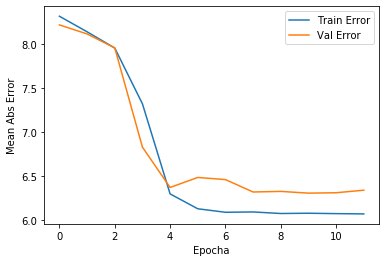

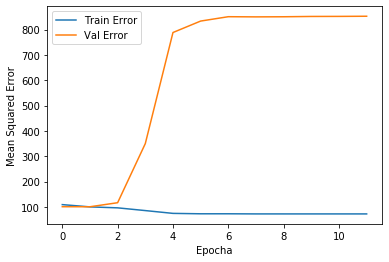

In [178]:
testFit = testParModelCarCountOneTrack.fit(normed_train_data, train_labels, epochs=EPOCHS,
                   validation_split=0.25, verbose=0, callbacks=[save_best_model("testParModelCarCountOneTrack.h5"),early_stop,reduce_lr, PrintDot()])
plot_history(testFit)

In [179]:
testParModelLengthOneTrack = load_model('testParModelCarCountOneTrack.h5')
eval(testParModelCarCountOneTrack)

Testing set Loss : 71.33 RealDrivingTime
Testing set Mean Abs Error:  6.10 RealDrivingTime
Testing set Mean Sqrt Error: 71.33 RealDrivingTime
Testing set Root Mean Sqrt Error:  8.45 RealDrivingTime


## Vyhodnotenie
Vidím, že zameranie sa na jeden úsek pomáha presnoti modelu, ale model dokáže iba do istej miery predpovedať, kde sa trafí v 51% prípadov s odchýlkou 4 vagónov, takže stále ho nepovažujeme za dostatočne presný.

pre trasu Drahotuše -> Lipník nad Bečv. 
- Testing set Mean Abs Error:  5.67 RealDrivingTime
- Testing set Mean Sqrt Error: 63.85 RealDrivingTime
- Testing set Root Mean Sqrt Error:  7.99 RealDrivingTime
    
        - Táto trasa málokedy zaznamená nulové meškanie, preto je dobrým príkladom dobre zaznamenaných dát
        
pre trasu Ostrava-Svinov -> Polanka n. O.
- Testing set Mean Abs Error:  5.69 RealDrivingTime
- Testing set Mean Sqrt Error: 64.32 RealDrivingTime
- Testing set Root Mean Sqrt Error:  8.02 RealDrivingTime


        - Táto trasa má často ako keby nadiktované výsledky, kde vlaky majú v niektorých prípadoch rovnaké jazdné doby

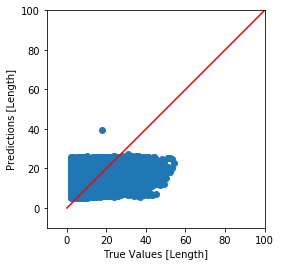

Najväčšia chyba:23.774511337280273
Najväčšia chyba v zápornom smere:-37.685028076171875
% priblizne správnych: 0.5149405692096415


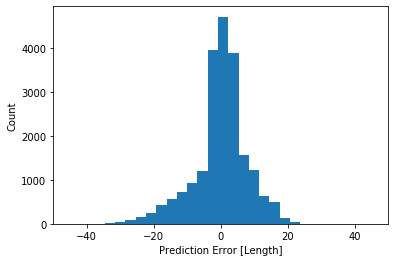

In [117]:
test_predictions = testParModelCarCountOneTrack.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Length]')
plt.ylabel('Predictions [Length]')
plt.axis('equal')
plt.axis('square')
plt.xlim([-10,100])
plt.ylim([-10,100])
_ = plt.plot([0,100],[0,100],'r')
plt.show()

error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

goodPercent = error[abs(error) < 4] 
print("% priblizne správnych: " + str(len(goodPercent)/len(error)))

plt.hist(error, bins=20)
plt.xlabel('Prediction Error [Length]')
plt.xlim([-50,50])
_ = plt.ylabel("Count")

# Odhad počtu náprav v súprave

In [118]:
dfPar['AxisCount'] = df['AxisCount']
label = 'AxisCount'
used_attributes = odhadParameters.copy()
used_attributes.append('AxisCount')

In [119]:
dffcut = dfPar[used_attributes]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

AxisCount                1.000000
RealDrivingTime          0.172168
ToPolom                  0.048755
FromPolom                0.048755
FromLipník nad Beèv.     0.030251
ToLipník nad Beèv.       0.030051
ToDrahotue              0.029940
FromDrahotue            0.029889
ToProsenice              0.029778
FromProsenice            0.029208
ToHranice na Mor.        0.028383
FromHranice na Mor.      0.027313
FromPøerov os.n.         0.016232
ToPøerov os.n.           0.015783
FromSuchdol nad Odr.     0.015300
ToSuchdol nad Odr.       0.013674
ToJistebník              0.009322
FromJistebník            0.009314
ToPolanka n. O.          0.007954
FromPolanka n. O.        0.004332
FromCement Hranice      -0.000075
ToVýh Dluhonice         -0.000860
FromVýh Dluhonice       -0.001091
ToFulnek                -0.005070
FromFulnek              -0.005461
ToStudénka              -0.023286
FromHranice mìsto       -0.025480
FromStudénka            -0.025517
FromOstrava-Vítkovice   -0.027700
ToOstrava-Vítk

In [121]:
train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


(2067026, 44)
(516757, 44)


In [128]:
testParModelAxis = build_model(0.001)


...................

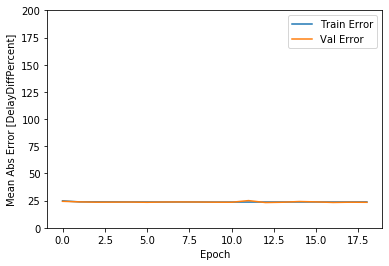

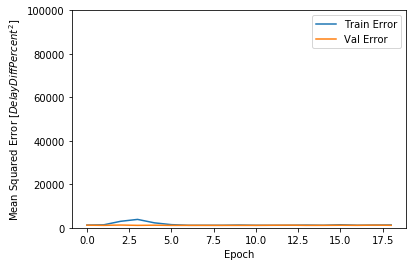

In [129]:
testParModelAxisFit = testParModelAxis.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[save_best_model("AxisModel.h5"),early_stop, PrintDot()])
plot_history(testParModelAxisFit)

In [130]:
testmodel = load_model("AxisModel.h5")

In [131]:
eval(testmodel)

Testing set Loss : 1105.65 RealDrivingTime
Testing set Mean Abs Error: 23.65 RealDrivingTime
Testing set Mean Sqrt Error: 1105.65 RealDrivingTime
Testing set Root Mean Sqrt Error: 33.25 RealDrivingTime


## Vyhodnotenie

- Testing set Mean Abs Error: 23.65 RealDrivingTime
- Testing set Mean Sqrt Error: 1105.65 RealDrivingTime
- Testing set Root Mean Sqrt Error: 33.25 RealDrivingTime

Model správne odhadne 58% prípadov s ochýlkou 20 náprav. Nestačí to na to, aby som ho označil za dotatočne presný

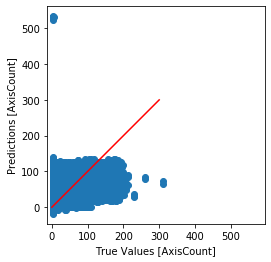

Najväčšia chyba:529.8419799804688
Najväčšia chyba v zápornom smere:-245.80941772460938
% chýb menších ako 20 náprav: 0.5790903654909367


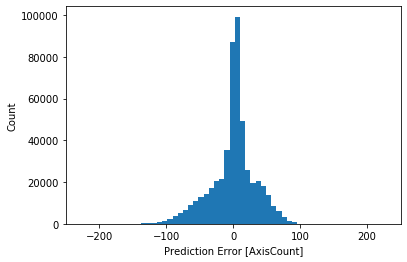

In [134]:
test_predictions = testmodel.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [AxisCount]')
plt.ylabel('Predictions [AxisCount]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([0,300],[0,300],'r')
plt.show()

error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

goodError = error[abs(error) < 20] 
print("% chýb menších ako 20 náprav: " + str(len(goodError)/len(error)))

plt.hist(error, bins=100)
plt.xlabel('Prediction Error [AxisCount]')
plt.xlim([-250,250])
_ = plt.ylabel("Count")

## Experiment - odhad počtu náprav na modeli konkrétneho úseku
Vybrané úseky  
    - Drahotuše -> Lipník nad Bečv. 
    - Ostrava-Svinov -> Polanka n. O.

In [137]:
label = 'AxisCount'
dfPar[label] = df[label]
used_attributes = ['RealDrivingTime', label]

In [150]:
#dffcut = dfPar[((dfPar['FromOstrava-Svinov'] == 1) & (dfPar['ToPolanka n. O.'] == 1))]
dffcut = dfPar[((dfPar['FromDrahotue'] == 1) & (dfPar['ToLipník nad Beèv.'] == 1))]
dffcut = dffcut[used_attributes]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

print(dffcut.shape)

AxisCount          1.000000
RealDrivingTime    0.356696
Name: AxisCount, dtype: float64
(116955, 2)


Ako na prvý pohľad vidím, tak model nebude môcť odhadnúť z jazdnej doby počet náprav, čo nám potvrdzuje ako korelácia, tak aj graf závislosti týchto dvoch vlastností.

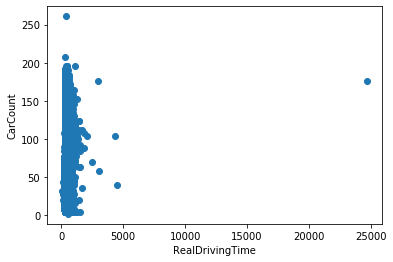

In [151]:
plt.scatter(dffcut['RealDrivingTime'],dffcut[label])
plt.ylabel(label)
plt.xlabel('RealDrivingTime')
plt.show()

In [152]:
train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

(93564, 1)
(23391, 1)


In [153]:
testParModelAxisCountOneTrack = build_model()


....................
.

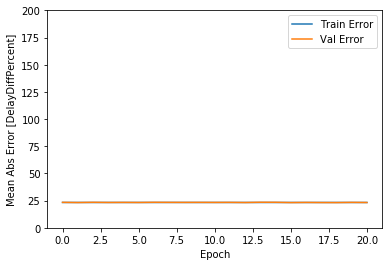

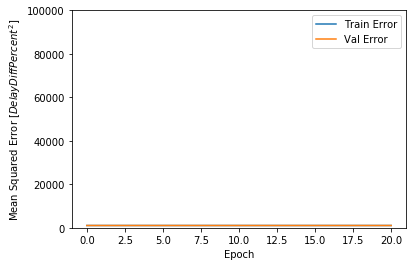

In [156]:
testFit = testParModelAxisCountOneTrack.fit(normed_train_data, train_labels, epochs=EPOCHS,
                   validation_split=0.25, verbose=0, callbacks=[save_best_model("AxisModelOneTrack.h5"),early_stop,reduce_lr, PrintDot()])
plot_history(testFit)

In [157]:
testParModelAxisCountOneTrack = load_model('AxisModelOneTrack.h5')
eval(testParModelAxisCountOneTrack)

Testing set Loss : 1036.08 RealDrivingTime
Testing set Mean Abs Error: 23.11 RealDrivingTime
Testing set Mean Sqrt Error: 1036.08 RealDrivingTime
Testing set Root Mean Sqrt Error: 32.19 RealDrivingTime


### Vyhodnotenie
Vidím, že zameranie sa na jeden úsek nepomáha výrazne presnoti modelu, kde sa trafí s podobnou presnoťou ako predošlý model v 52% prípadoch s odchýlkou 16 náprav, takže stále ho nepovažujeme za dostatočne presný.

pre trasu Drahotuše -> Lipník nad Bečv. 
- Testing set Mean Abs Error: 23.11 RealDrivingTime
- Testing set Mean Sqrt Error: 1036.08 RealDrivingTime
- Testing set Root Mean Sqrt Error: 32.19 RealDrivingTime
    
        - Táto trasa málokedy zaznamená nulové meškanie, preto je dobrým príkladom dobre zaznamenaných dát
        
pre trasu Ostrava-Svinov -> Polanka n. O.
- Testing set Mean Abs Error: 22.75 RealDrivingTime
- Testing set Mean Sqrt Error: 1001.90 RealDrivingTime
- Testing set Root Mean Sqrt Error: 31.65 RealDrivingTime


        - Táto trasa má často ako keby nadiktované výsledky, kde vlaky majú v niektorých prípadoch rovnaké jazdné doby

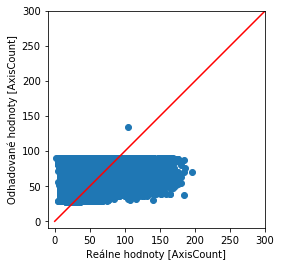

Najväčšia chyba:388.70989990234375
Najväčšia chyba v zápornom smere:-146.8528594970703
% priblizne správnych: 0.5108375016031808


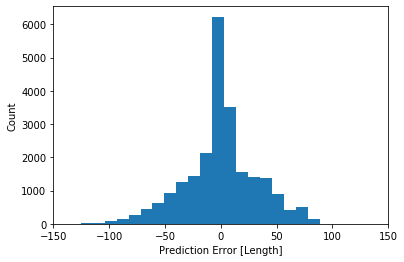

In [158]:
test_predictions = testParModelAxisCountOneTrack.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('Reálne hodnoty [' + label + ']')
plt.ylabel('Odhadované hodnoty [' + label + ']')
plt.axis('equal')
plt.axis('square')
plt.xlim([-10,300])
plt.ylim([-10,300])
_ = plt.plot([0,300],[0,300],'r')
plt.show()

error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

goodPercent = error[abs(error) < 16] 
print("% priblizne správnych: " + str(len(goodPercent)/len(error)))

plt.hist(error, bins=50)
plt.xlabel('Prediction Error [Length]')
plt.xlim([-150,150])
_ = plt.ylabel("Count")

# Odhad dĺžky vlakovej súpravy

In [159]:
label = 'Length'
dfPar[label] = df[label]
used_attributes = odhadParameters.copy()
used_attributes.append(label)

In [160]:
dffcut = dfPar[used_attributes]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

Length                   1.000000
RealDrivingTime          0.124322
FromPolom                0.055862
ToPolom                  0.055856
FromLipník nad Beèv.     0.040115
ToLipník nad Beèv.       0.039873
ToDrahotue              0.039670
FromDrahotue            0.039590
ToProsenice              0.039507
FromProsenice            0.039038
ToHranice na Mor.        0.034293
FromHranice na Mor.      0.033154
FromSuchdol nad Odr.     0.015485
ToSuchdol nad Odr.       0.013534
FromPøerov os.n.         0.013007
ToVýh Dluhonice          0.011850
FromVýh Dluhonice        0.011399
ToPøerov os.n.           0.010202
ToJistebník              0.009571
FromJistebník            0.009517
ToPolanka n. O.          0.007556
FromPolanka n. O.        0.002958
FromCement Hranice      -0.000301
ToFulnek                -0.005987
FromFulnek              -0.006446
FromHranice mìsto       -0.029710
ToStudénka              -0.030096
FromStudénka            -0.032773
ToHranice mìsto         -0.034462
FromOstrava-Ví

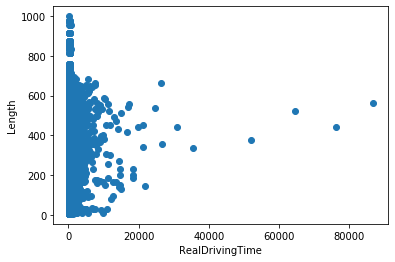

In [161]:
plt.scatter(dffcut['RealDrivingTime'],dffcut[label])
plt.ylabel(label)
plt.xlabel('RealDrivingTime')
plt.show()

In [162]:
train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

(2067026, 44)
(516757, 44)


In [166]:
testParModelLength = build_model(0.001)


....................
..

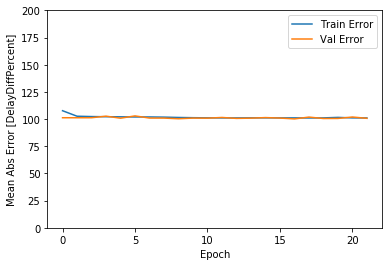

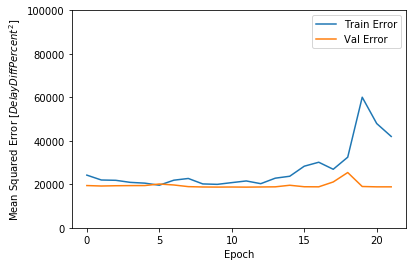

In [167]:
testParModelLengthFit = testParModelLength.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[reduce_lr,early_stop,save_best_model("testParModelLengthGeneral.h5"), PrintDot()])
plot_history(testParModelLengthFit)

In [168]:
testModel = load_model('testParModelLengthGeneral.h5')
eval(testModel)

Testing set Loss : 18653.71 RealDrivingTime
Testing set Mean Abs Error: 101.29 RealDrivingTime
Testing set Mean Sqrt Error: 18653.76 RealDrivingTime
Testing set Root Mean Sqrt Error: 136.58 RealDrivingTime


## Vyhodnotenie
Model sa priblížil iba v 25% testovacích prípadov, čo nieje ani zdaľeka dostatočné

- Testing set Mean Abs Error: 101.29 RealDrivingTime
- Testing set Mean Sqrt Error: 18653.76 RealDrivingTime
- Testing set Root Mean Sqrt Error: 136.58 RealDrivingTime

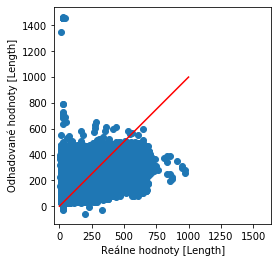

Najväčšia chyba:1438.185791015625
Najväčšia chyba v zápornom smere:-715.02392578125
% priblizne správnych: 0.2601493545322076


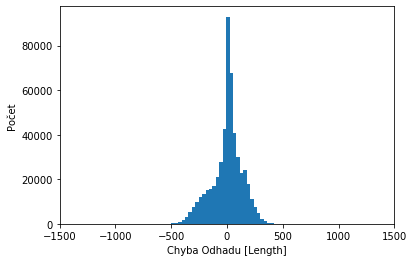

In [175]:
test_predictions = testModel.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('Reálne hodnoty ['+label+']')
plt.ylabel('Odhadované hodnoty ['+label+']')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([0,1000],[0,1000], 'r')
plt.show()

error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

goodPercent = error[abs(error) < 28] 
print("% priblizne správnych: " + str(len(goodPercent)/len(error)))

plt.hist(error, bins=70)
plt.xlabel('Chyba Odhadu ['+label+']')
plt.xlim([-1500,1500])
_ = plt.ylabel("Počet")


# Experiment Odhad dĺžky vlakovej súpravy na konkrétnom úseku
Mojim cieľom je zistiť, či model vytvorený pre špecifický úsek je presnejší ako model s použitím one-hot encoding

In [176]:
label = 'Length'
dfPar[label] = df[label]
used_attributes = ['RealDrivingTime', label]

In [182]:
dffcut = dfPar[((dfPar['FromOstrava-Svinov'] == 1) & (dfPar['ToPolanka n. O.'] == 1))]
#dffcut = dfPar[((dfPar['FromDrahotue'] == 1) & (dfPar['ToLipník nad Beèv.'] == 1))]

dffcut = dffcut[used_attributes]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

print(dffcut.shape)

Length             1.000000
RealDrivingTime    0.193244
Name: Length, dtype: float64
(105587, 2)


In [183]:
train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

(84470, 1)
(21117, 1)


In [184]:
testParModelLengthOneTrack = build_model()


....................

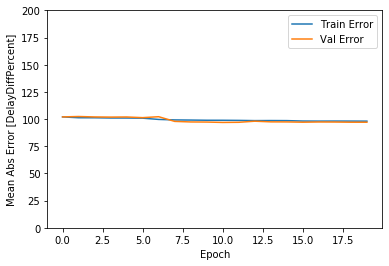

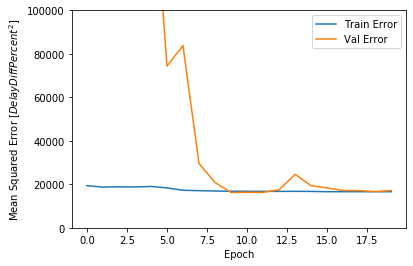

In [185]:
testParModelLengthFit = testParModelLengthOneTrack.fit(normed_train_data, train_labels, epochs=EPOCHS,
                   validation_split=0.25, verbose=0, callbacks=[save_best_model("testParModelLengthOneTrack.h5"),early_stop,reduce_lr, PrintDot()])
plot_history(testParModelLengthFit)

In [186]:
testModel = load_model('testParModelLengthOneTrack.h5')
eval(testModel)

Testing set Loss : 16650.66 RealDrivingTime
Testing set Mean Abs Error: 98.56 RealDrivingTime
Testing set Mean Sqrt Error: 16650.65 RealDrivingTime
Testing set Root Mean Sqrt Error: 129.04 RealDrivingTime


## Vyhodnotenie
Zameranie sa na jeden úsek sa zdá že nepomáha presnoti modelu, a trafí sa iba v 20% prípadov s odchýlkou 28 metrov čo je  5% horší výsledok. Teda usudzujem, že sa nedá odhadnúť dĺžka vlaku z jeho jazdnej doby.

pre trasu Drahotuše -> Lipník nad Bečv. 
- Testing set Mean Abs Error: 102.28 RealDrivingTime
- Testing set Mean Sqrt Error: 18510.44 RealDrivingTime
- Testing set Root Mean Sqrt Error: 136.05 RealDrivingTime
    
        - Táto trasa málokedy zaznamená nulové meškanie, preto je dobrým príkladom dobre zaznamenaných dát
        
pre trasu Ostrava-Svinov -> Polanka n. O.
- Testing set Mean Abs Error: 98.56 RealDrivingTime
- Testing set Mean Sqrt Error: 16650.65 RealDrivingTime
- Testing set Root Mean Sqrt Error: 129.04 RealDrivingTime


        - Táto trasa má často ako keby nadiktované výsledky, kde vlaky majú v niektorých prípadoch rovnaké jazdné doby

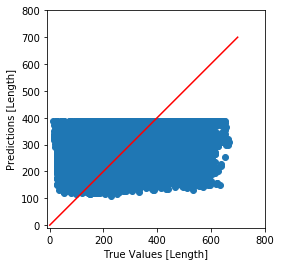

Najväčšia chyba:375.17572021484375
Najväčšia chyba v zápornom smere:-709.595703125
% priblizne správnych: 0.2079367334375148


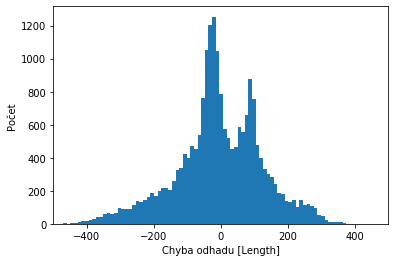

In [187]:
test_predictions = testModel.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values ['+label+']')
plt.ylabel('Predictions ['+label+']')
plt.axis('equal')
plt.axis('square')
plt.xlim([-10,800])
plt.ylim([-10,800])
_ = plt.plot([0,700],[0,700],'r')
plt.show()

error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

goodPercent = error[abs(error) < 28] 
print("% priblizne správnych: " + str(len(goodPercent)/len(error)))

plt.hist(error, bins=100)
plt.xlabel('Chyba odhadu ['+label+']')
plt.xlim([-500,500])
_ = plt.ylabel("Počet")

# Odhad váhy vlakovej súpravy

In [189]:
label = 'Weight'
dfPar[label] = df[label]
used_attributes = odhadParameters.copy()
used_attributes.append(label)

In [190]:
dffcut = dfPar[used_attributes]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

Weight                   1.000000
RealDrivingTime          0.150296
ToPolom                  0.045031
FromPolom                0.045026
ToPøerov os.n.           0.036322
FromLipník nad Beèv.     0.028945
FromDrahotue            0.028291
ToDrahotue              0.028052
ToProsenice              0.027888
ToLipník nad Beèv.       0.027730
FromProsenice            0.027297
ToHranice na Mor.        0.026508
FromHranice na Mor.      0.025630
FromSuchdol nad Odr.     0.013425
ToSuchdol nad Odr.       0.011986
ToVýh Dluhonice          0.009483
ToJistebník              0.008757
FromJistebník            0.008750
ToPolanka n. O.          0.006825
FromPolanka n. O.        0.004491
FromCement Hranice       0.000217
ToFulnek                -0.004750
FromFulnek              -0.005099
FromVýh Dluhonice       -0.005510
FromOstrava-Svinov      -0.011271
FromPøerov os.n.        -0.012418
ToOstrava-Vítkovice     -0.021138
ToStudénka              -0.021968
FromStudénka            -0.024248
FromHranice mì

In [191]:
train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

(2067026, 44)
(516757, 44)


In [200]:
testParModelWeight = build_model(0.001)


....................
....................
.......

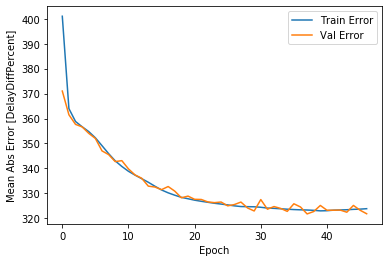

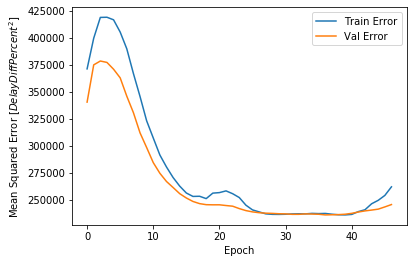

In [201]:
testParModelWeightFit = testParModelWeight.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop,save_best_model("testParModelWeightGeneral.h5"), PrintDot()])
plot_history(testParModelWeightFit)

In [202]:
testModel = load_model("testParModelWeightGeneral.h5")
eval(testModel)

Testing set Loss : 233971.17 RealDrivingTime
Testing set Mean Abs Error: 323.74 RealDrivingTime
Testing set Mean Sqrt Error: 233970.70 RealDrivingTime
Testing set Root Mean Sqrt Error: 483.71 RealDrivingTime


## Vyhodnotenie
Vidím že tento model nedokáže spoľahlivo predpovedať váhu vlaku
- Testing set Mean Abs Error: 323.74 RealDrivingTime
- Testing set Mean Sqrt Error: 233970.70 RealDrivingTime
- Testing set Root Mean Sqrt Error: 483.71 RealDrivingTime

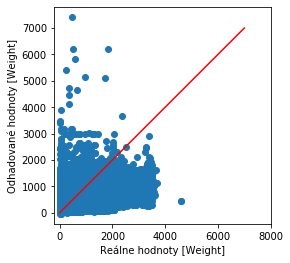

Najväčšia chyba:6980.16455078125
Najväčšia chyba v zápornom smere:-4152.72314453125


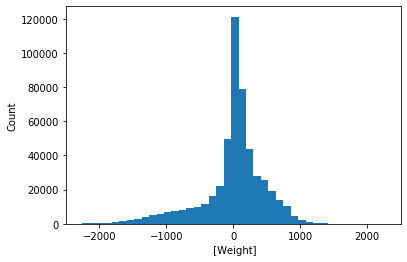

In [206]:
test_predictions = testModel.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('Reálne hodnoty ['+label+']')
plt.ylabel('Odhadované hodnoty ['+label+']')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([0,7000],[0,7000], 'r')
plt.show()

error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

plt.hist(error, bins=100)
plt.xlabel(' ['+label+']')
plt.xlim([-2500,2500])
_ = plt.ylabel("Count")

# Experiment Odhad váhy vlakovej súpravy na konkrétnom úseku
Mojim cieľom je zistiť, či model vytvorený pre špecifický úsek je presnejší ako model s použitím one-hot encoding

In [207]:
label = 'Weight'
dfPar[label] = df[label]
used_attributes = ['RealDrivingTime', label]

In [225]:
#dffcut = dfPar[((dfPar['FromOstrava-Svinov'] == 1) & (dfPar['ToPolanka n. O.'] == 1))]
dffcut = dfPar[((dfPar['FromDrahotue'] == 1) & (dfPar['ToLipník nad Beèv.'] == 1))]

dffcut = dffcut[used_attributes]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

print(dffcut.shape)

Weight             1.000000
RealDrivingTime    0.322788
Name: Weight, dtype: float64
(116955, 2)


In [226]:
train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

(93564, 1)
(23391, 1)


In [231]:
testParModelWeightOneTrack = build_model(0.005)


....................
....................
..........

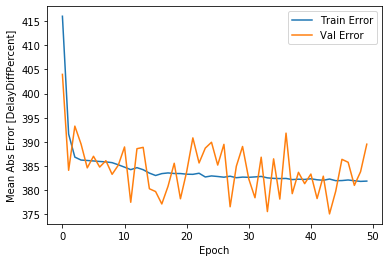

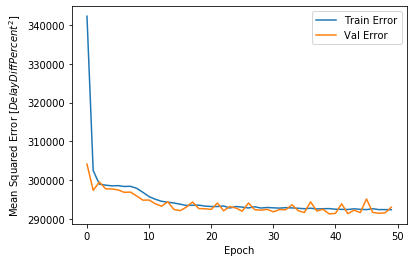

In [232]:
WeightOneTrackHistory = testParModelWeightOneTrack.fit(normed_train_data, train_labels, epochs=EPOCHS,
                   validation_split=0.25, verbose=0, callbacks=[save_best_model("testParModelWeightOneTrack.h5"),early_stop, PrintDot()])
plot_history(WeightOneTrackHistory)

In [233]:
testModel = load_model('testParModelWeightOneTrack.h5')
eval(testModel)

Testing set Loss : 289685.47 RealDrivingTime
Testing set Mean Abs Error: 381.80 RealDrivingTime
Testing set Mean Sqrt Error: 289685.44 RealDrivingTime
Testing set Root Mean Sqrt Error: 538.22 RealDrivingTime


## Vyhodnotenie
Zameranie sa na jeden úsek sa zdá že nepomáha presnoti modelu, a trafí sa iba v 3-6% prípadov. Takéto zhoršenie oproti všeobecnému modelu môže znamenať, že existujú úseky, ktoré sa odhadnúť dajú oveľa lepšie ako moje vybrané. 
pre trasu Drahotuše -> Lipník nad Bečv. 
- Testing set Mean Abs Error: 381.80 RealDrivingTime
- Testing set Mean Sqrt Error: 289685.44 RealDrivingTime
- Testing set Root Mean Sqrt Error: 538.22 RealDrivingTime
    
        - Táto trasa málokedy zaznamená nulové meškanie, preto je dobrým príkladom dobre zaznamenaných dát
        
pre trasu Ostrava-Svinov -> Polanka n. O.
- Testing set Mean Abs Error: 363.64 RealDrivingTime
- Testing set Mean Sqrt Error: 281428.50 RealDrivingTime
- Testing set Root Mean Sqrt Error: 530.50 RealDrivingTime


        - Táto trasa má často ako keby nadiktované výsledky, kde vlaky majú v niektorých prípadoch rovnaké jazdné doby

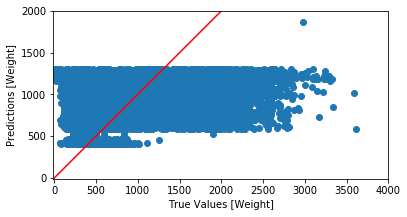

Najväčšia chyba:1298.6484375
Najväčšia chyba v zápornom smere:-3024.20849609375
% priblizne správnych: 0.30866572613398313


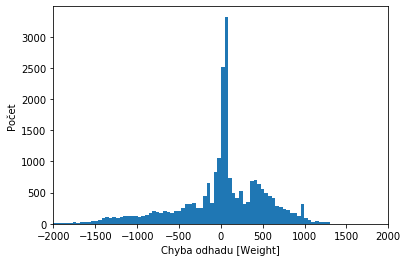

In [240]:
test_predictions = testModel.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values ['+label+']')
plt.ylabel('Predictions ['+label+']')
plt.axis('equal')
plt.axis('square')
plt.xlim([-10,4000])
plt.ylim([-10,2000])
_ = plt.plot([0,5000],[0,5000],'r')
plt.show()

error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

goodPercent = error[abs(error) < 80] 
print("% priblizne správnych: " + str(len(goodPercent)/len(error)))

plt.hist(error, bins=100)
plt.xlabel('Chyba odhadu ['+label+']')
plt.xlim([-2000,2000])
_ = plt.ylabel("Počet")

# Odhad Typu vlaku

In [209]:
dfPar['TrainType'] = df['TrainType']
label = 'TrainLabel'
used_attributes = odhadParameters.copy()
used_attributes = used_attributes + [label]

In [210]:
dfPar[label] = dfPar['TrainType'].astype('category')
dfPar[label] = dfPar[label].cat.codes

In [211]:
dffcut = dfPar[used_attributes]

train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)


train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

(2067026, 44)
(516757, 44)


In [225]:
def build_classification_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(10, activation=tf.nn.softmax)
    ])

    optimizer = tf.keras.optimizers.Adam(0.00001)

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [223]:
testParModelType = build_classification_model()

In [217]:
early_stop_classification = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25)

In [218]:
def plot_class_history(history):
    plt.subplot(211)
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()

    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()

In [44]:
def class_eval(model):
    loss, accuracy = model.evaluate(normed_test_data, test_labels, verbose=0)
    print("Testing set Accuracy : {:5.2f} % ".format(accuracy*100))

In [224]:
def save_best_class_model(model_name):
    return keras.callbacks.ModelCheckpoint(model_name, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False)


....................
....................
....................
....................
....................
....................
....................
..........

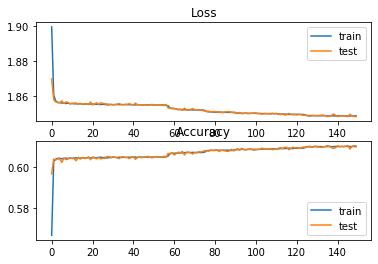

In [226]:
testParModelTypeFit = testParModelType.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop_classification,save_best_model("TestParModelTypeGeneralAdam.h5"), PrintDot()])
plot_class_history(testParModelTypeFit)

In [227]:
testModel = load_model("TestParModelTypeGeneralAdam.h5")
class_eval(testModel)

Testing set Accuracy : 61.04 % 


## Vyhodnotenie
Tento model vykazuje na testovacej mnozine presnost 
- 61.04 %

očakával som väčšiu presnosť.

In [47]:
test_predictions = testModel.predict(normed_test_data)

print(np.argmax(test_predictions[0]))
print(test_labels.iloc[0])

for i in range(10):
    plt.subplot(1,2,2)
    plt.bar(range(10), test_predictions[i])
    plt.title(train_types[test_labels.iloc[i]])
    plt.xticks(range(10), train_types, rotation=45)
    plt.show()

Najväčšia chyba:True
Najväčšia chyba v zápornom smere:True
% chýb menších ako 2 minúty: 1.0


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


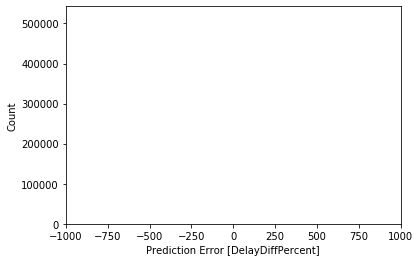

In [327]:
error = (test_predictions != test_labels)

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1000,1000])
_ = plt.ylabel("Count")

## Experiment - odhad typu vlaku na základe jazdnej doby na konkrétnom úseku

In [199]:
dfPar['TrainType'] = df['TrainType']
label = 'TrainLabel'
used_attributes = ['TrainLabel','RealDrivingTime']

In [200]:
dfPar[label] = dfPar['TrainType'].astype('category')
dfPar[label] = dfPar[label].cat.codes

In [201]:
dffcut = dfPar[((dfPar['FromOstrava-Svinov'] == 1) & (dfPar['ToPolanka n. O.'] == 1))]
#dffcut = dfPar[((dfPar['FromDrahotue'] == 1) & (dfPar['ToLipník nad Beèv.'] == 1))]

dffcut = dffcut[used_attributes]
print(dffcut.shape)

(105587, 2)


In [202]:
train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

(84470, 1)
(21117, 1)


In [203]:
def build_classification_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(len(train_types), activation=tf.nn.softmax)
    ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [204]:
testTypeModel = build_classification_model()

In [205]:
EPOCHS = 150

In [206]:
early_stop_classification = keras.callbacks.EarlyStopping(monitor='accuracy', mode='max', patience=30)


....................
....................
........

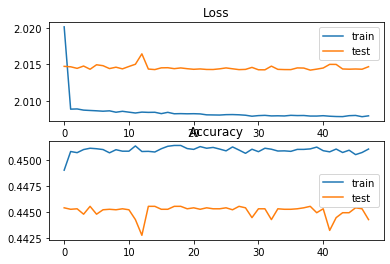

In [207]:
testTypeModelHistory = testTypeModel.fit(normed_train_data, train_labels, epochs=EPOCHS,
                   validation_split=0.25, verbose=0, callbacks=[save_best_model("testTypeModelOneTrack.h5"), early_stop_classification, reduce_lr, PrintDot()])
plot_class_history(testTypeModelHistory)

In [208]:
testModel = load_model('testTypeModelOneTrack.h5')
class_eval(testModel)

Testing set Accuracy : 45.12 % 


## Vyhodnotenie
Zameranie sa na jeden úsek sa zdá že nepomáha presnoti modelu, a trafí sa iba v 3-6% prípadov. Takéto zhoršenie oproti všeobecnému modelu môže znamenať, že existujú úseky, ktoré sa odhadnúť dajú oveľa lepšie ako moje vybrané. 
pre trasu Drahotuše -> Lipník nad Bečv. 
- Accuracy: 59.20 % 
    
        - Táto trasa málokedy zaznamená nulové meškanie, preto je dobrým príkladom dobre zaznamenaných dát
        
pre trasu Ostrava-Svinov -> Polanka n. O.
- Testing set Mean Abs Error: 363.64 RealDrivingTime
- Testing set Mean Sqrt Error: 281428.50 RealDrivingTime
- Testing set Root Mean Sqrt Error: 530.50 RealDrivingTime


        - Táto trasa má často ako keby nadiktované výsledky, kde vlaky majú v niektorých prípadoch rovnaké jazdné doby

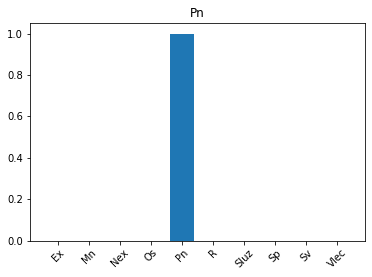

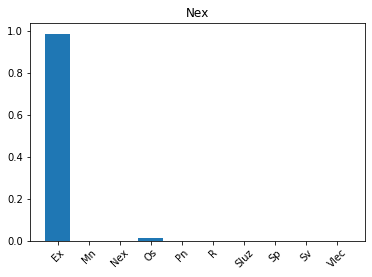

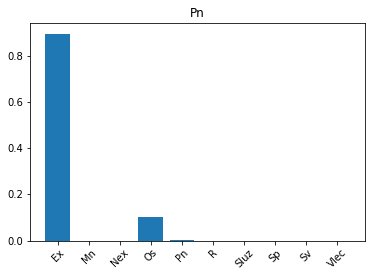

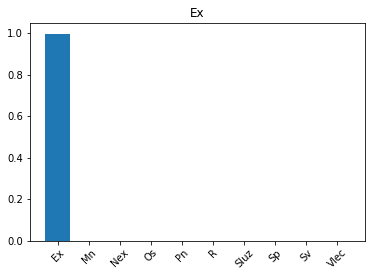

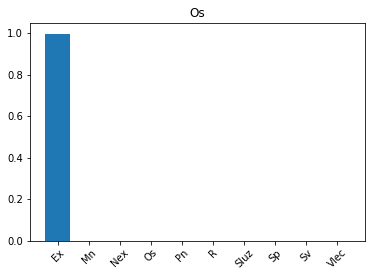

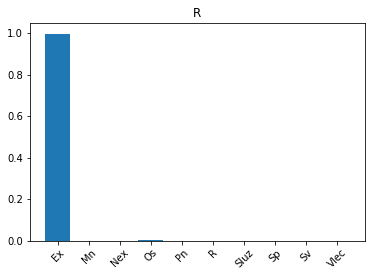

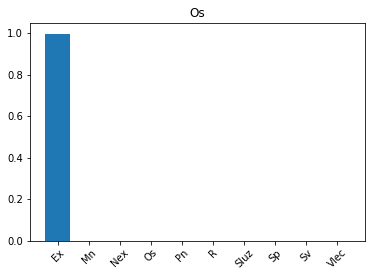

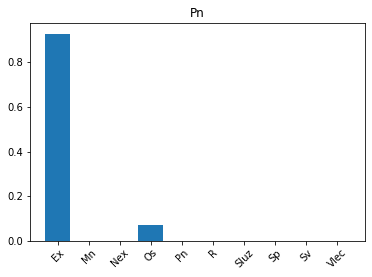

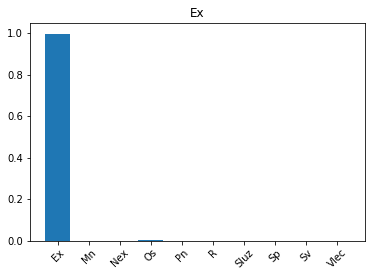

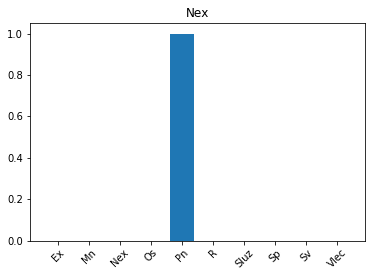

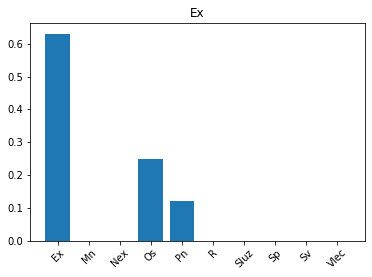

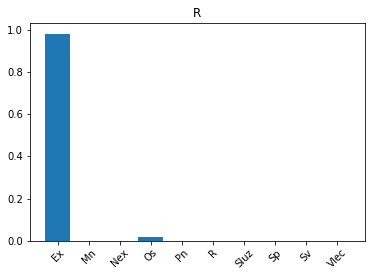

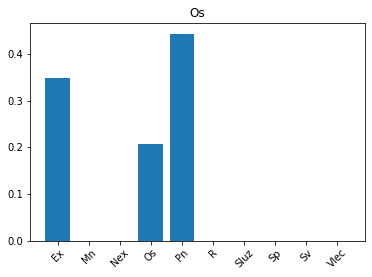

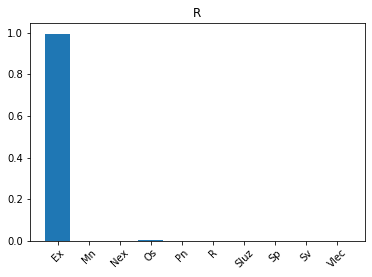

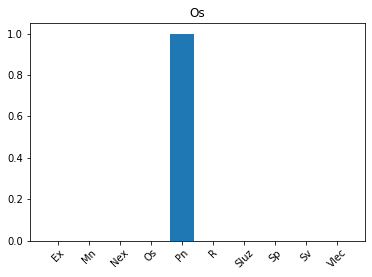

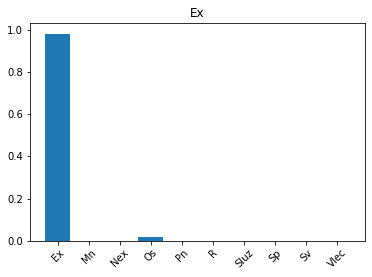

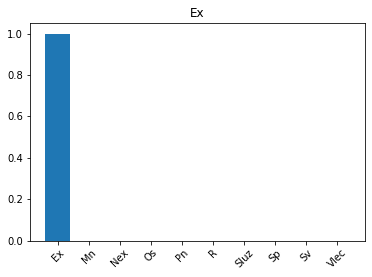

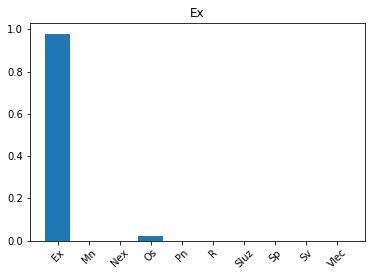

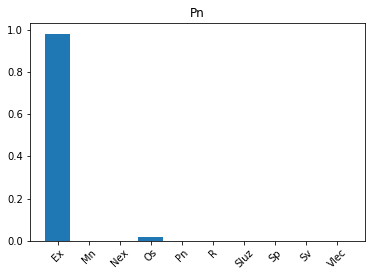

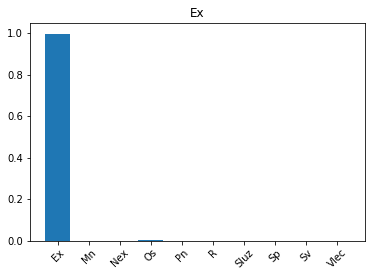

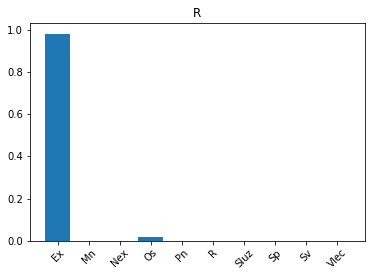

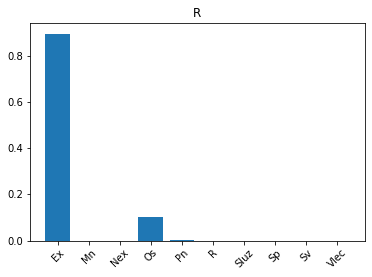

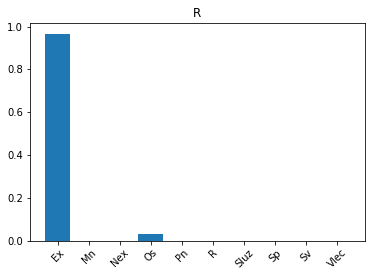

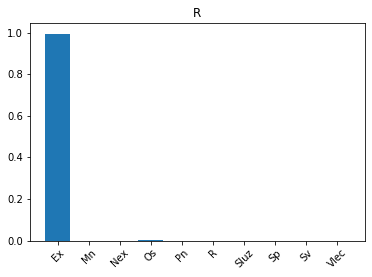

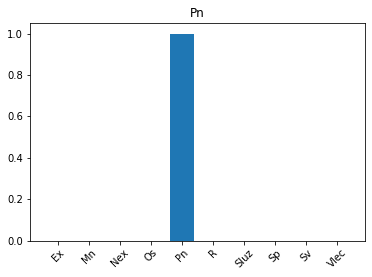

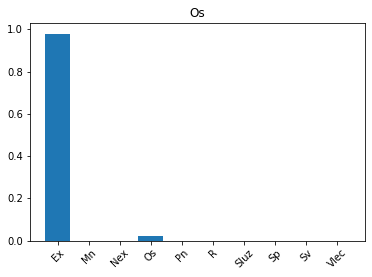

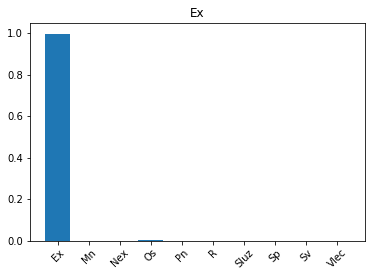

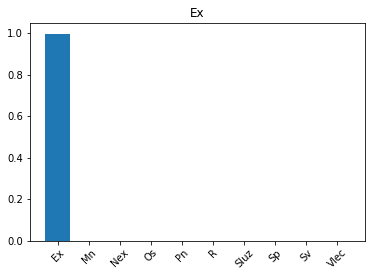

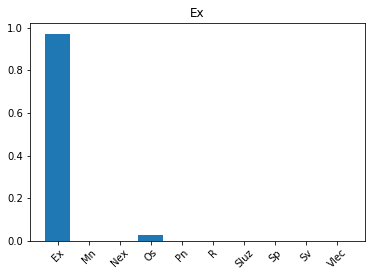

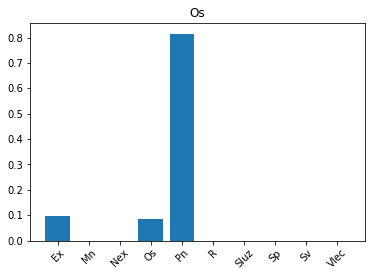

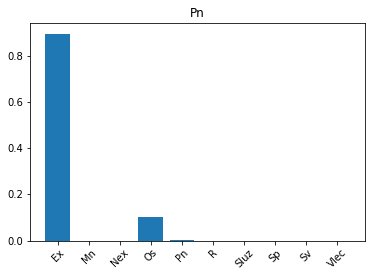

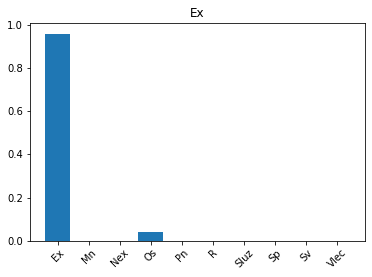

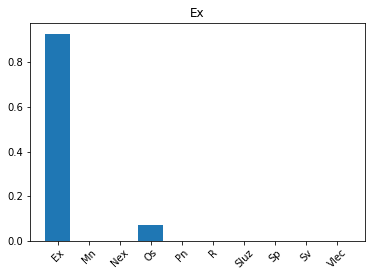

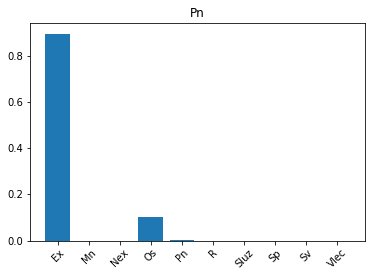

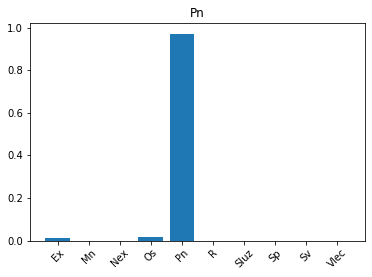

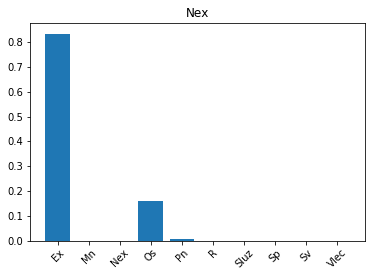

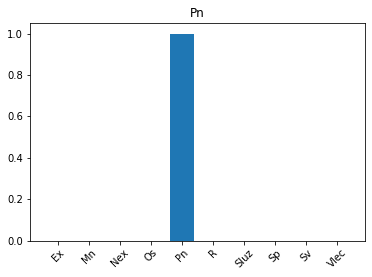

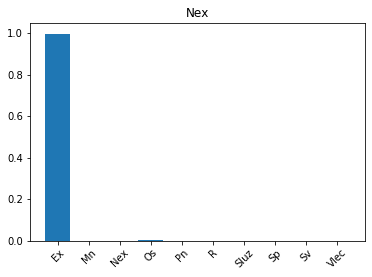

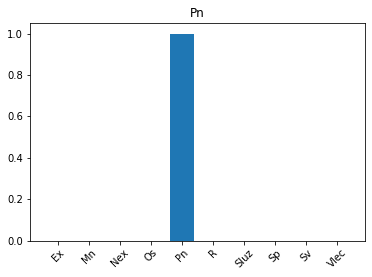

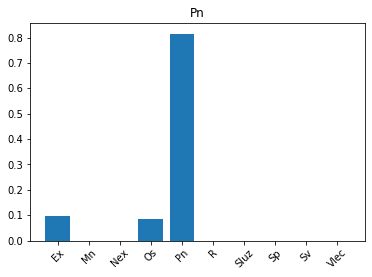

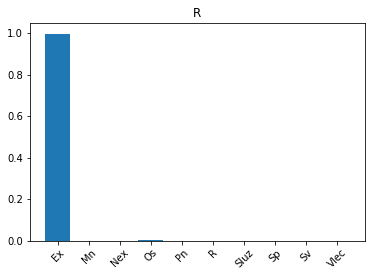

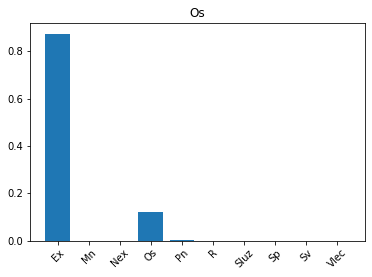

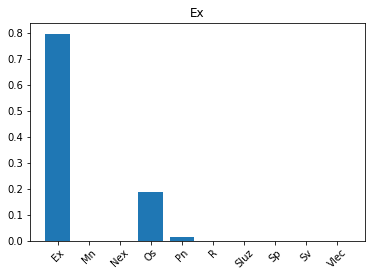

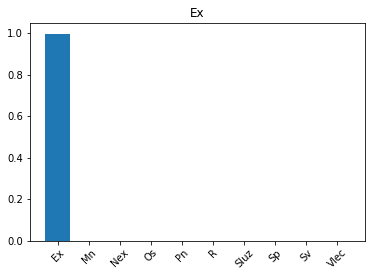

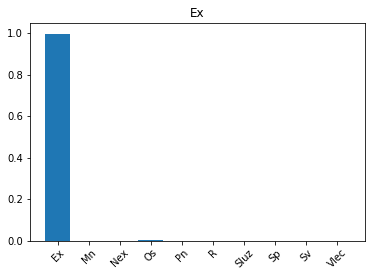

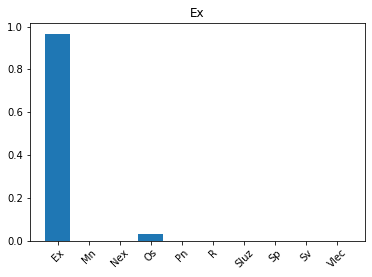

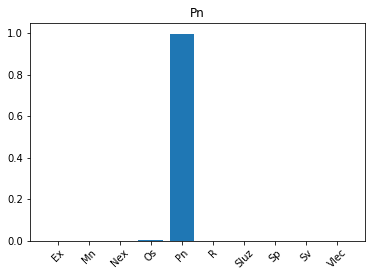

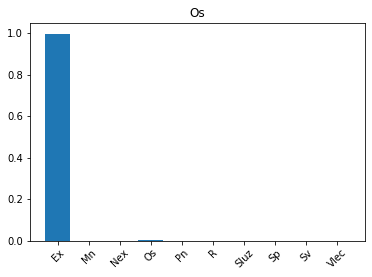

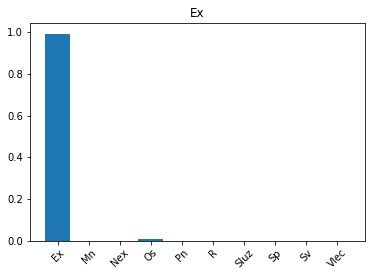

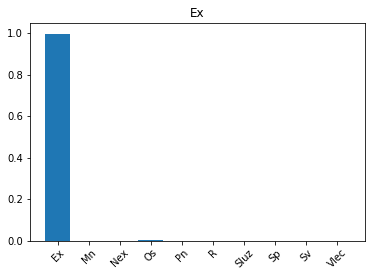

In [113]:
test_predictions = testModel.predict(normed_test_data)


for i in range(50): 
    plt.subplot(1,1,1)
    plt.bar(range(len(train_types)), test_predictions[i])
    plt.title(train_types[test_labels.iloc[i]])
    plt.xticks(range(len(train_types)), train_types, rotation=45)
    plt.show()

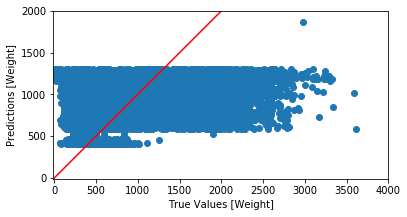

Najväčšia chyba:1298.6484375
Najväčšia chyba v zápornom smere:-3024.20849609375
% priblizne správnych: 0.30866572613398313


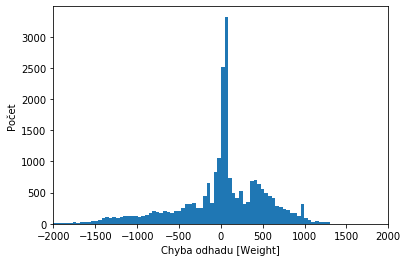

In [240]:
test_predictions = testModel.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values ['+label+']')
plt.ylabel('Predictions ['+label+']')
plt.axis('equal')
plt.axis('square')
plt.xlim([-10,4000])
plt.ylim([-10,2000])
_ = plt.plot([0,5000],[0,5000],'r')
plt.show()

error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

goodPercent = error[abs(error) < 80] 
print("% priblizne správnych: " + str(len(goodPercent)/len(error)))

plt.hist(error, bins=100)
plt.xlabel('Chyba odhadu ['+label+']')
plt.xlim([-2000,2000])
_ = plt.ylabel("Počet")